In [2]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

# DEFINITION DE TOUS LES PARAMETRES

In [45]:
# @param Save Figure
show_fig    = True       # If True : Show the figure that are plot
save_fig    = False      # If True : Save the figure that are plot ; If show_fig == False, figure won't be save 
save_folder = 'UC3_fig'  # Folder where the figure is saved

# All stuffs for the connection to the DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'dlt-bi.database.windows.net'
username = 'WVN-TEST'
database = 'DelitraiteurBI_Prod'
password = 'jYei0u22cGZiE9F4VFER'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';PORT=1433;DATABASE=' + database + 
         ';UID=' + username + 
         ';PWD=' + password)



# @param DB / Table / Column Name   -> Should be changed if you change DB
"""
    Il faut ici récupérer tous les articles vendus dans la même transaction -> le même ticket.
    Pour ça, on va récupérer la clé primaire du ticket, contenu dans [Entete_Ticket.KEY].
    Le contenu du ticket est dans la table de détail du ticket : [Detail_Ticket.Article.KEY].
    
    Les tables détail et entête ne sont pas liés par des clés étrangère.
    Pour les liés, il faut que la date ET le numéro de ticket.
    
    Pour ne pas perdre le sens des articles dans l'analyse, on utilise leur groupement par univers.
    Ces univers sont composés de 4 niveau de précision (1 étant le moins précis avec 16 univers, 4 étant le plus précis avec 490 univers).
    Cette précision peut être modifier avec la variable @Univers_Depth.
    
    La table CONSOMMATEUR est utilisé pour filtré les clients fidélisés ou les segments de clientèle.
"""
DB            = database                                         
TABLE_ENTETE  = "Recette_entete_ticket"                                                 
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
CONSOMMATEUR  = "Consommateur"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
RECETTE_DETAIL = TABLE_DETAIL            + ".Total_net_ttc_ligne"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 3         # Jusqu'où on ira dans l'univers ? = [1;4]
nbr_data       = 5000000  # Nombres de lignes à sélectionner

# @param Variable influançant la sélection des données
"""
    Afin d'analyser sous plus d'angle, la possibilité de ne prendre que les transactions de clients fidélisé est données.
    Dans la DB Archive2018_2019_prod, les tickets de clients fidélisés commencent à partir de la clé 16.000.000.
    Pour mixer les données fidéliser et non fidélisées, il vaut mieux commencer à sécectionner les tickets à partir de cette bornes.
    Pour n'obtenir que des tickets non-fidélisé, il suffit de mettre take_only_fid = False, start_fid_key = 0 et nbr_ticket_max < 16.000.000.
"""
take_only_fid  = True     # If true, only transactions with fidelised cunsommer will be select
# start_fid_key  = 16000000  # Key of TABLE_ENTETE where begin to mix fidelised and unfidelised cunsummer
# nbr_ticket_max = 5000000   # MAX = 26.671.566 for Archive2018_2019_prod. Try to not select more thant 10.000.000 ticket

# @param Permet de faire varier l'analyse
"""
    Tout ces paramètres servent à faire l'analyse du support et de confidence pour l'Apriori Algorithm.
    Le choix final de min_support et min_confidence est assez subjectif, donc tester dans différentes valeurs peut être intéressant.
    La fonction Analyse fera ça selon les paramètre ci-dessous.
"""
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif - Apriori Algorithm
min_support    = 0.001         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
min_confidence = 0.15       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

# @param effectuer l'analyse sur les magasins ou pas
do_shop              = True

In [46]:
# TEST & CREATE Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# DEFINITION DES FONCTIONS

### Prétraitements des données

In [47]:
"""
    Les Articles sont regroupés en univers.
    Les Univers possèdent 4 niveau de profondeur/précision.
    Plus la profondeur est élevés, plus il y a d'univers et plus c'est précis.
        Univers_Depth = 1 => #Univers = 16
        Univers_Depth = 4 => #Univers = 490
    
    Deux univers sont commun à N niveau près si leur N premier libellé sont commun.
    Pour obtenir les univers d'une ceraines profondeurs, on regarde alors les libellés distincts.
    
    
        @ Input : 
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où aller
        
        @ Ouput : 
            - Univers Correspondance [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Dictionnaire permettant de savoir quel univers correspond à un autre pour un certain degré de profondeur.
                L'univers Univers_Key devient Univers_Key_Correspondance pour une profondeur Univers_Depth
        
"""
def get_univers_correspondance(Univers_Depth):
    #SQL Request to select Key + 4 level of libelle of the table Dim_Univers
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
        [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''

    #Connexion to DB and load DataFrame
    conn = engine.connect()
    df_univers = pd.read_sql(sql_command, conn)
    conn.close()

    #Variable to return
    univers_correspondance = {}
    #Stocks Univers key which is deleted.
    deleted = set()
    
    """
        Double boucle, on vérifie pour l'univers 1 si il existe des univers commun,
        puis sur l'univers 2 si il n'est pas supprimé, 
        puis sur le 3, etc.
    """
    for item in df_univers.values:
        if item[0] in deleted:
            continue
        for cor in df_univers.values: 
            if item[0] != cor[0]:
                # If libelle 1 to Univers_Depth of both univers are the same, they are the same
                if (
                    item[1] == cor[1] and
                    (item[2] == cor[2] or Univers_Depth < 2) and
                    (item[3] == cor[3] or Univers_Depth < 3) and
                    (item[4] == cor[4] or Univers_Depth < 4)
                ):
                    univers_correspondance[cor[0]] = item[0]
                    deleted.add(cor[0])
    return univers_correspondance

univers_correspondance = get_univers_correspondance(Univers_Depth)

In [48]:
"""
    Charge les transactions en les groupant de trois manière :
        - Toutes les transactions chargées par la DB de manière générale;
        - Toutes les transactions chargées par la DB groupée par magasin;
        - Toutes les transactions chargées par la DB groupée par article, 
            avec en plus le CA de l'article et le CA en dehors de l'articles chargés pour chaque transactions;
            
    Pour charger les transactions, on crée juste une nouvelle transactiosn dès que la clé du ticket est différentes.
    
        @ Input : 
            - dataframe [pd.DataFrame] | column = ["Univers.KEY","Entete_Ticket.KEY", "Detail_Ticket.CA", "Magasin.KEY"]
                Contient toutes les données des tickets
                Les colonnes doivent être gardés dance cette ordre (ou la fonction doit être changé)
            - univ_cor [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Correspondance des univers en fonction de la profondeur utilisée.
                output de la fonction get_univers_correspondance(Univers_Depth)
            - all_mag_key [set]
                Contient toutes les clés de magasin présente dans le dataframe
            - all_univ_key [set]
                Contient toutes les clés d'univers présente dans le dataframe
                
        @ Output : 
            - transactions [list[tupple]]
                Contient la liste du contenu de toutes les transactions
            - all_mag_tra [dict] = {(Magasin_Key : list(tupple))}
                Contient pour chaque magasin la liste du contenu de toutes les transactions de ce magasin
            - univ_transactions = {(Univers_Key : list(tupple))}
                Contient pour chaque univers la liste du contenu de toutes les transactions de cet univers
            - univ_CA
                Contient pour chaque univers le CA produit par cette univers
            - univ_CA_sans_univ
                Contient pour chaque univers le CA produit par les transctions qui contenaient l'univers moins le CA produit par l'univers
"""
def load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key):
    start = time()

    # Initialisation of output variable
    transactions      = []
    
    all_mag_tra = {mag_key:[] for mag_key in all_mag_key}
    
    univ_transactions = {univ_key:[] for univ_key in all_univ_key}
    univ_CA           = {univ_key:0  for univ_key in all_univ_key}
    univ_CA_sans_univ = {univ_key:0  for univ_key in all_univ_key}
    
    # Variable for the loop initialisation
    actual_key_ticket = -1
    CA_trans   = {}
    
    for item in dataframe.values:
        # Get variable of dataframe -> Column have to be ["Univers.KEY","Entete_Ticket.KEY", "Detail_Ticket.CA", "Magasin.KEY"]
        key_univ = item[0]
        key_tic  = item[1]
        rec_lig  = item[2]
        key_mag  = item[3]
        
        # When key ticket change, we save the transaction and reinisialize the data
        if actual_key_ticket != key_tic:
            # if ticket == -1 (or len(CA_trans) == 0), we don't save the data
            if actual_key_ticket != -1:
                transactions.append(tuple(l))
                all_mag_tra[key_mag].append(tuple(l))
            
            for k in CA_trans.keys():
                univ_transactions[k].append(tuple(l))
                univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]

            # Reinitialize the loop variable
            actual_key_ticket = key_tic
            CA_trans   = {}
            l = []

        # Get univers_correspondance of univ_key
        if key_univ in univ_cor.keys():
            key_univ = univ_cor[key_univ]
        # Add key to the transaction
        l.append(int(key_univ))
        
        # Save the CA of the line
        if not key_univ in CA_trans.keys():
            CA_trans[key_univ] = 0
        CA_trans[key_univ] += rec_lig
        univ_CA[key_univ] += rec_lig
        
    # When leave the loop, save a last time the data
    all_mag_tra[key_mag].append(tuple(l))
    transactions.append(tuple(l))

    for k in CA_trans.keys():
        univ_transactions[k].append(tuple(l))
        univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
    
    # environ 10s * #tickets / 2.000.000.
    print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 
    
    return transactions, all_mag_tra, univ_transactions, univ_CA, univ_CA_sans_univ

### Analyses des données

In [49]:
"""
    Analyse les valeurs de seuil de support et de confidence pour l'Apriori Algorithm.
    La fonction va run l'Apriori Algorithm pour toutes les valeurs de support entre min_sup et max_sup et de confidence entre min_conf et max_conf.
    Il regarde ensuite le nombre de règles créé et le temps de run de l'algo.
    
    Une alternative plus rapide à l'algorithme ci-dessous peut être faite : 
        run l'algorithm pour max_sup et min_conf et l'Apriori Algorithm sort les stats de support et confidence pour chaque règle
        On traite chacune des règles et on regarde les stats
    Cette alternative ne permet cependant pas de ressortir les temps de runs.
    
        @ Input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - min_sup [float] = [0.0;1.0]
                Minimum support qui sera testé
            - max_sup [float] = [0.0;1.0]
                Maximum support qui sera testé
            - sup_iter [int] >= 0
                Nombre-1 de seuil de support qui sera testé
            - min_conf [float] = [0.0;1.0]
                Minimum confidence qui sera testé
            - max_conf [float] = [0.0;1.0]
                Maximum confidence qui sera testé
            - conf_iter [int] >= 0
                Nombre-1 de seuil de confidence qui sera testé
                
        @ Output :
            - df_rules [pd.DataFrame]
                Support en index, confidence en column, nombre de règle en value
            - df_time [pd.DataFrame]
                Support en index, confidence en column, temps de run en value

"""
def Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter):
    # initialization of output
    data_rules = {}
    data_time  = {}
    
    # Double loop to run algo on all min_sup / max_sup
    for i_support in range(sup_iter+1):
        # Setting value of min_supp
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter
        min_support = min(min_support, 1)
        
        # Algorithm can't run for min_support <= 0 ->
        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            # Setting value of min_conf
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter
            min_confidence = min(min_confidence, 1)

            print(min_confidence, end = '... ')

            #running Apriori Algorithm
            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")

    #change output to dataframe
    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)
    
    return df_rules, df_time

In [50]:
"""
    Pour un ensemble de transactions, va charger un dictionnaire contenant la fréquence à laquelle des univers apparaissent.
    Ex: Si l'univers 299 apparait dans 50% des transactions, l'output va contenir l'objet : (299:0.5)
    
    La fonction va également plot un graphique en barre des plus grande fréquence d'univers.
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - show_plot [boolean]
                True : affiche le plot
            - nbr_to_plt [int] >= 0
                Top X des fréquences qui seront plot si show_plot = True
                
        @output :
            - rec_article [dict] = {(univ_key:frequency)}
                Pour chaque univers, la fréquence à laquelle l'article apparait dans les transactions
            - nbr_univ [int]
                Nombre totale d'univers distinct dans les transactions
"""
def load_recurence(transactions, show_plot = True, nbr_to_plt = 20):
    start = time()
    rec_article = {}

    # Recup for every univers the récurence
    for t in transactions:
        for art in set(t):
            if not str(art) in rec_article.keys():
                rec_article[str(art)] = 0
            rec_article[str(art)]+=1

    # Divide recurence by the number of transaction
    N = len(transactions)
    for k in rec_article.keys():
        rec_article[k]/= N
    print(N)

    #environ 1min
    print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

    # Sort DESC the frequency
    rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}
    nbr_univ = len(rec_article.keys())

    # plot the frequency
    if show_plot:
        fig = plt.figure(figsize=(15, 5))
        plt.bar(list(rec_article.keys())[:min(nbr_to_plt, nbr_univ)]
                    ,list(rec_article.values())[:min(nbr_to_plt, nbr_univ)],1)

        plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")

        if save_fig:
            title = save_folder+"/"+str(Univers_Depth)+"_Proportion-Article"
            if list(rec_article.values())[0] == 1:
                title += "_"+str(list(rec_article.keys())[0])
            plt.savefig(title+".jpg")
        plt.show()

    return rec_article, nbr_univ

In [51]:
"""
    Récupère pour chaque transaction le nombre d'article qui sont vendu en plus d'une liste d'univers particulier
        et le nombre d'article de la liste d'univers particulier
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - univ_keys [list(int)]
                liste de clé à filter pour les output
                
        @ output :
            - nbr_article_sans_univ [list(int)]
                pour chaque transaction, le nombre de fois qu'un article d'un univers non-inclu dans univ_keys est présent
            - nbr_article_univ [list(int)]
                pour chaque transaction, le nombre de fois qu'un article d'un univers inclu dans univ_keys est présent
"""
def get_nbr_sans_univ(transactions, univ_keys):
    #initialization of the output
    nbr_article_sans_univ = [0 for _ in range(len(transactions))]
    nbr_article_univ      = [0 for _ in range(len(transactions))]
    
    # for each transactions : inscrease nbr_article_sans_univ if article not in univ_keys else increase nbr_article_univ
    for i in range(len(transactions)):
        for item in transactions[i]:
            if not item in univ_keys:
                nbr_article_sans_univ[i] += 1
            else:
                nbr_article_univ[i] += 1
                
    return nbr_article_sans_univ, nbr_article_univ     

### Apriori Algorithm - Getting Association Rules

In [52]:
"""
    Run l'Apriori Algorithm sur les transactions pour un certains support et confidence.
    L'Apriori Algorithm est un algorithme calculant les meilleurs règles d'associations entre article.
    Les règles d'associations sont sous la forme :
        "Si le client achetent de la mozzarella, alors il a 35% de chance d'acheter des tomates. 
        Cette événement s'est produit dans 1% de toutes les transactions"
    Le 35% représente ici la confidence, et le 1% représente le support.
    
    Un seuil de support et de confidence sont mis pour pas se retrouver avec 50k règles et un algo qui prends 6 ans à run.
    Sans ces seuils, la complexité est factorielle, donc je déconseille de mettre min_support à 0.
    Si le support est à 0, il est calculé automatiquement en le mettant à 1/#univers (environ 1/400)
    
    A noter que l'Apriori Algorithm ressort une solution exacte par rapport au min_support/min_confidence.
    Il ne sert donc à rien de le run plusieurs fois en espérant que ça change la solution.
    
    Pour plus d'info sur l'algorithme : https://www.youtube.com/watch?v=43CMKRHdH30
    Pour plus d'info sur la libraire  : https://efficient-apriori.readthedocs.io/en/latest/
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - min_support [float] = [0;1]
                Seuil de fréquence d'apparition de la règles
            - min_confidence [float] = [0;1]
                Seuil de confiance en une règle 
            - nbr_univ [int]
                Nombre d'univers distinct dans les transactions
                
        @ output : 
            - Rules [list(Rule) (voir librairie)]
                Règles ressortie par l'algorithme
"""
def get_rules(transactions, min_support, min_confidence, nbr_univ = 490):
    start = time()

    # Recalculate the support if min_support <= 0
    min_supp = 1/nbr_univ if min_support <= 0 else min_support
    print(min_supp)

    # Run Apriori Algorithm
    _, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

    # eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
    print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
    
    return rules

In [53]:
"""
    Affiche les règles avec leur libellé plutot que les règles avec les clés d'univers.
    Prend en compte la profondeur d'univers.
    
    Si une removed_key est entrée, alors les règles contenant cette clé ne seront pas affichés.
    Cette particularité est surtout utile pour voir les règles dans le cas des transactions contenant toujours un univers (cas des transactions regroupés par univers)
    
    La rule est skip si le lift = 1 car ça n'a pas de sens de la garder par définition mathématique (proof is let to the reader).
    
        @ input : 
            - rules [list(Rule) (voir librairie)]
                Règles ressortie par l'apriori algorithm
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où les articles sont regroupés
            - conn
                connexion au serveur sql
            - removed_key [int] = -1 || [1;490]
                clé que l'on souhaite ne pas avoir dans les règles affichées.
        
        @ output :
            None
"""
def print_rules(rules, Univers_Depth, conn, removed_key = -1):
    conn = engine.connect()

    for rule in sorted(rules, key=lambda rule: rule.lift):
        # Skip rule if lift = 1 or if rule contain removed_key
        if rule.lift <= 1 or removed_key in rule.lhs or removed_key in rule.rhs:
            continue

        print("\n\nRule : ", rule)

        # SQL command to get the libelle 
        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        # SQL command to get the libelle 
        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

    conn.close()

In [54]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1931secondes


## Chargements et prétraitements des données

In [55]:
start = time()

# SQL Query to get the usefull data for the transactions. 
sql_command = '''SELECT TOP(''' + str(nbr_data) + ''')
[''' + TABLE_ARTICLE + '''.'''  + TABLE_UNIVERS + '''.KEY],
[''' + TABLE_ENTETE   + '''.KEY], 
[''' + RECETTE_DETAIL + '''],
[''' + TABLE_ENTETE   +'''.''' + TABLE_MAGASIN + '''.KEY]
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[ARC].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[ARC].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''       + TEMPS_DETAIL  + '''] = [''' + TEMPS_ENTETE    + '''] 
AND ['''      + NUMERO_DETAIL + '''] = [''' + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388 ''' + ('''
AND ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY] != -1 ''')*int(take_only_fid) + '''
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''


# SQL Query is print to debug it easily
print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT TOP(5000000)
[Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY], 
[Recette_detail_ticket.Total_net_ttc_ligne],
[Recette_entete_ticket.Magasin.KEY]
FROM [DelitraiteurBI_Prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [DelitraiteurBI_Prod].[ARC].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [DelitraiteurBI_Prod].[ARC].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Article_meti_HIST.Univers.KEY] != 388 
AND [Recette_entete_ticket.Consommateur.KEY] != -1 
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~1129secondes
         Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0                           

In [56]:
# SQL Query to get Magasin Libelle
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [DelitraiteurBI_Prod].[DWH].[Dim_Magasin]



In [57]:
# Get libelle of magasin linked with key
all_mag_lib  = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
# Get all Magasin that can be found in the transactions
all_mag_key  = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])
# Get all Univers that can be found in the transactions
all_univ_key = set([i for i in range(max(df_art_ticket[TABLE_ARTICLE+"."+TABLE_UNIVERS + ".KEY"])+1)])

In [58]:
# Load all the transactions 
(transactions, all_mag_tra, univ_transactions, 
 univ_CA, univ_CA_sans_univ) = load_transactions(df_art_ticket, univers_correspondance, 
                                                 all_mag_key, all_univ_key)
print(len(transactions))

Time Taken to load transaction: ~18secondes
909783


## Analyse et run des algos

909783
Time Taken to load recurence: ~2secondes


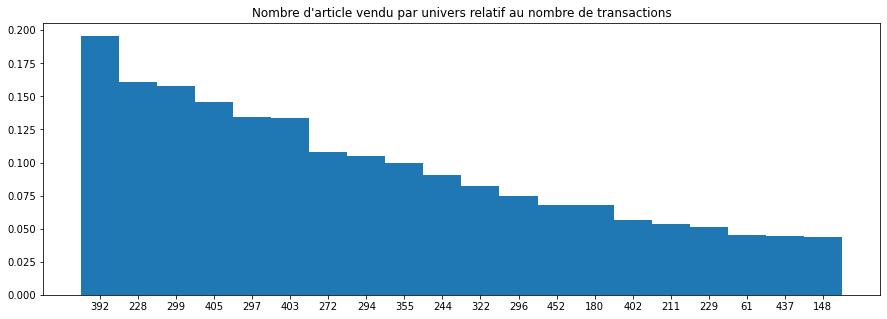

0.001
Time Taken to run Apriori Algorithm : ~123secondes


Rule :  {322, 355} -> {299} (conf: 0.158, supp: 0.001, lift: 1.001, conv: 1.000)
 Univ_KEY                     Univ_1                    Univ_2        Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS         CHIPS
      355              PRET A MANGER                   SALADES SALADES REPAS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {129, 228} -> {299} (conf: 0.158, supp: 0.002, lift: 1.001, conv: 1.000)
 Univ_KEY   Univ_1                Univ_2     Univ_3
      129  DESSERT CONFISERIE CHOCOLATEE CANDY BARS
      228 BOISSONS           SOFT DRINKS       SODA
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {117} -> {392} (conf: 0.196, supp: 0.004, lift: 1.002, conv: 1.001)
 Univ_KEY  Univ_1             Univ_2  Univ_3
      117 DESSERT BISCUITERIE SUCREE GAUFRES
->
 Univ

 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {13, 297} -> {299} (conf: 0.162, supp: 0.001, lift: 1.025, conv: 1.005)
 Univ_KEY          Univ_1                       Univ_2  Univ_3
       13 PRET A CUISINER                4 ET 5  GAMME SALADES
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {413} -> {228} (conf: 0.165, supp: 0.003, lift: 1.026, conv: 1.005)
 Univ_KEY        Univ_1         Univ_2     Univ_3
      413 PRET A MANGER PLATS PREPARES GREEK FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {148} -> {299} (conf: 0.162, supp: 0.007, lift: 1.027, conv: 1.005)
 Univ_KEY  Univ_1     Univ_2                Univ_3
      148 DESSERT PATISSERIE PATISSERIE INDIVIVUEL
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES




 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {18} -> {299} (conf: 0.164, supp: 0.003, lift: 1.039, conv: 1.007)
 Univ_KEY          Univ_1                     Univ_2  Univ_3
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {123} -> {228} (conf: 0.167, supp: 0.001, lift: 1.040, conv: 1.008)
 Univ_KEY  Univ_1   Univ_2   Univ_3
      123 DESSERT CHOCOLAT PRALINES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {272, 355} -> {299} (conf: 0.164, supp: 0.001, lift: 1.040, conv: 1.008)
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
      355   PRET A MANGER            SALADES      SALADES REPAS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule 

 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {219} -> {405} (conf: 0.154, supp: 0.002, lift: 1.058, conv: 1.010)
 Univ_KEY   Univ_1   Univ_2                 Univ_3
      219 BOISSONS JUS SECS JUS DE FRUITS SEC > 1P
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {294, 405} -> {299} (conf: 0.167, supp: 0.002, lift: 1.059, conv: 1.011)
 Univ_KEY         Univ_1                       Univ_2       Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    BAGUETTES
      405  PRET A MANGER               PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {244, 294} -> {228} (conf: 0.170, supp: 0.002, lift: 1.059, conv: 1.012)
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      244       BOISSONS                         VINS    FRANCE
      2

 Univ_KEY         Univ_1            Univ_2     Univ_3
      303 PETIT DEJEUNER PRODUITS LAITIERS LAITS SECS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {148, 403} -> {299} (conf: 0.169, supp: 0.001, lift: 1.071, conv: 1.014)
 Univ_KEY        Univ_1         Univ_2                Univ_3
      148       DESSERT     PATISSERIE PATISSERIE INDIVIVUEL
      403 PRET A MANGER PLATS PREPARES        TRADITION FOOD
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {297, 405} -> {299} (conf: 0.169, supp: 0.003, lift: 1.072, conv: 1.014)
 Univ_KEY         Univ_1                       Univ_2       Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS        PAINS
      405  PRET A MANGER               PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {52} -> {22

 Univ_KEY          Univ_1                       Univ_2      Univ_3
       27 PRET A CUISINER                    BOUCHERIE SPECIALITES
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS       PAINS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {51, 296} -> {228} (conf: 0.174, supp: 0.001, lift: 1.085, conv: 1.017)
 Univ_KEY          Univ_1                       Univ_2     Univ_3
       51 PRET A CUISINER                      FROMAGE  PATE DURE
      296  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {228, 355} -> {405} (conf: 0.158, supp: 0.003, lift: 1.086, conv: 1.015)
 Univ_KEY        Univ_1      Univ_2        Univ_3
      228      BOISSONS SOFT DRINKS          SODA
      355 PRET A MANGER     SALADES SALADES REPAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {13, 180} -

 Univ_KEY  Univ_1        Univ_2      Univ_3
      138 DESSERT DESSERT FRAIS GAMME SANTE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {74, 296} -> {228} (conf: 0.178, supp: 0.001, lift: 1.105, conv: 1.021)
 Univ_KEY          Univ_1                       Univ_2     Univ_3
       74 PRET A CUISINER                       SPREAD     SPREAD
      296  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {51} -> {228} (conf: 0.178, supp: 0.007, lift: 1.105, conv: 1.021)
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {13, 294} -> {228} (conf: 0.178, supp: 0.001, lift: 1.106, conv: 1.021)
 Univ_KEY          Univ_1                       Univ_2    Univ_3
       13 PRET A CUISINER                4 ET 5  GAMME   SALADES
      294  PETIT D

 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {392, 403} -> {299} (conf: 0.177, supp: 0.003, lift: 1.123, conv: 1.024)
 Univ_KEY        Univ_1         Univ_2            Univ_3
      392 PRET A MANGER     SANDWICHES SANDWICHES FROIDS
      403 PRET A MANGER PLATS PREPARES    TRADITION FOOD
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {322, 355} -> {297} (conf: 0.151, supp: 0.001, lift: 1.123, conv: 1.019)
 Univ_KEY                     Univ_1                    Univ_2        Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS         CHIPS
      355              PRET A MANGER                   SALADES SALADES REPAS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {297, 355} -> {299} (conf: 0.177, supp: 0.002, lift: 1.124, conv: 1.024)
 Univ_KEY    

 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {138} -> {405} (conf: 0.165, supp: 0.001, lift: 1.132, conv: 1.023)
 Univ_KEY  Univ_1        Univ_2      Univ_3
      138 DESSERT DESSERT FRAIS GAMME SANTE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {29} -> {228} (conf: 0.182, supp: 0.002, lift: 1.133, conv: 1.026)
 Univ_KEY          Univ_1    Univ_2   Univ_3
       29 PRET A CUISINER BOUCHERIE VOLAILLE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {290} -> {403} (conf: 0.151, supp: 0.001, lift: 1.133, conv: 1.021)
 Univ_KEY         Univ_1                  Univ_2          Univ_3
      290 PETIT DEJEUNER TARTINABLES ET CEREALES PATE A TARTINER
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {355, 403} -> {228} (conf: 0.182, supp: 0.00

 Univ_KEY                     Univ_1                    Univ_2         Univ_3
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {228, 297} -> {403} (conf: 0.153, supp: 0.003, lift: 1.141, conv: 1.022)
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      228       BOISSONS                  SOFT DRINKS   SODA
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {215} -> {405} (conf: 0.167, supp: 0.002, lift: 1.141, conv: 1.025)
 Univ_KEY   Univ_1    Univ_2        Univ_3
      215 BOISSONS JUS FRAIS JUS DE FRUITS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {303} -> {299} (conf: 0.181, supp: 0.004, lift: 1.143, conv: 1.028)
 Univ_K

 Univ_KEY         Univ_1                       Univ_2                       Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                    BAGUETTES
      452       ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {228, 452} -> {299} (conf: 0.182, supp: 0.003, lift: 1.154, conv: 1.030)
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      228 BOISSONS                  SOFT DRINKS                         SODA
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {272, 322} -> {297} (conf: 0.155, supp: 0.001, lift: 1.154, conv: 1.024)
 Univ_KEY                     Univ_1                    Univ_2             Univ_3
      272            TABACS   PRESSE        TABAC   CI

 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {432} -> {405} (conf: 0.170, supp: 0.001, lift: 1.163, conv: 1.029)
 Univ_KEY                     Univ_1       Univ_2       Univ_3
      432 APERITIF   ENTREES   TAPAS POTAGE FRAIS GRAND FORMAT
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {339} -> {405} (conf: 0.170, supp: 0.001, lift: 1.164, conv: 1.029)
 Univ_KEY                     Univ_1      Univ_2             Univ_3
      339 APERITIF   ENTREES   TAPAS SAURISSERIE POISSONS CRUSTACES
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {228, 297} -> {405} (conf: 0.170, supp: 0.003, lift: 1.164, conv: 1.029)
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      228       BOISSONS                  SOFT DRINKS   SODA
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
->
 Univ_KEY        Univ_1

 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {212, 228} -> {403} (conf: 0.157, supp: 0.001, lift: 1.177, conv: 1.028)
 Univ_KEY   Univ_1      Univ_2           Univ_3
      212 BOISSONS        EAUX EAUX PETILLANTES
      228 BOISSONS SOFT DRINKS             SODA
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {120} -> {403} (conf: 0.157, supp: 0.003, lift: 1.177, conv: 1.028)
 Univ_KEY  Univ_1   Univ_2 Univ_3
      120 DESSERT CHOCOLAT BATONS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {121} -> {405} (conf: 0.172, supp: 0.004, lift: 1.177, conv: 1.031)
 Univ_KEY  Univ_1   Univ_2    Univ_3
      121 DESSERT CHOCOLAT TABLETTES
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {228, 272} -> {392} (conf: 0.231, supp: 0.005, lift: 1.178, 

 Univ_KEY          Univ_1                       Univ_2    Univ_3
       51 PRET A CUISINER                      FROMAGE PATE DURE
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {224, 392} -> {228} (conf: 0.191, supp: 0.001, lift: 1.186, conv: 1.037)
 Univ_KEY        Univ_1     Univ_2            Univ_3
      224      BOISSONS  SMOOTHIES            FRUITS
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {272, 437} -> {392} (conf: 0.232, supp: 0.001, lift: 1.186, conv: 1.048)
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
      437  PETIT DEJEUNER       CAFE SERVICE       CAFE SERVICE
->
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Rule :  {74, 297} -

 Univ_KEY          Univ_1             Univ_2                Univ_3
      231        BOISSONS        SOFT DRINKS BOISSONS ENERGISANTES
      272 TABACS   PRESSE TABAC   CIGARETTES    TABAC   CIGARETTES
->
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Rule :  {294, 322} -> {405} (conf: 0.175, supp: 0.002, lift: 1.200, conv: 1.035)
 Univ_KEY                     Univ_1                       Univ_2    Univ_3
      294             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS     CHIPS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {61, 297} -> {403} (conf: 0.160, supp: 0.002, lift: 1.200, conv: 1.032)
 Univ_KEY          Univ_1                       Univ_2  Univ_3
       61 PRET A CUISINER                  CHARCUTERIE JAMBONS
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   PAINS
-

 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {125, 322} -> {403} (conf: 0.162, supp: 0.001, lift: 1.212, conv: 1.034)
 Univ_KEY                     Univ_1                    Univ_2  Univ_3
      125                    DESSERT                CONFISERIE BONBONS
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS   CHIPS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {287} -> {228} (conf: 0.195, supp: 0.002, lift: 1.212, conv: 1.042)
 Univ_KEY         Univ_1                  Univ_2   Univ_3
      287 PETIT DEJEUNER TARTINABLES ET CEREALES CEREALES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {228, 294} -> {299} (conf: 0.192, supp: 0.003, lift: 1.212, conv: 1.041)
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      228       BOISSONS                  SOFT DRINKS      SODA
     

 Univ_KEY   Univ_1      Univ_2             Univ_3
      232 BOISSONS SOFT DRINKS BOISSONS SPORTIVES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {111} -> {403} (conf: 0.164, supp: 0.002, lift: 1.225, conv: 1.036)
 Univ_KEY  Univ_1             Univ_2           Univ_3
      111 DESSERT BISCUITERIE SUCREE BISCUITS FOURRES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {115} -> {405} (conf: 0.179, supp: 0.001, lift: 1.225, conv: 1.040)
 Univ_KEY  Univ_1             Univ_2 Univ_3
      115 DESSERT BISCUITERIE SUCREE  CAKES
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {125, 297} -> {299} (conf: 0.194, supp: 0.001, lift: 1.225, conv: 1.044)
 Univ_KEY         Univ_1                       Univ_2  Univ_3
      125        DESSERT                   CONFISERIE BONBONS
      297 PETIT 

 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      244 BOISSONS                         VINS                       FRANCE
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {61, 452} -> {405} (conf: 0.181, supp: 0.001, lift: 1.240, conv: 1.043)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3
       61 PRET A CUISINER                  CHARCUTERIE                      JAMBONS
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {322} -> {405} (conf: 0.181, supp: 0.015, lift: 1.240, conv: 1.043)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->


 Univ_KEY          Univ_1      Univ_2  Univ_3
       68 PRET A CUISINER CHARCUTERIE SALAMIS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {111} -> {405} (conf: 0.183, supp: 0.002, lift: 1.254, conv: 1.045)
 Univ_KEY  Univ_1             Univ_2           Univ_3
      111 DESSERT BISCUITERIE SUCREE BISCUITS FOURRES
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {174} -> {403} (conf: 0.168, supp: 0.004, lift: 1.254, conv: 1.041)
 Univ_KEY           Univ_1 Univ_2             Univ_3
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {296, 355} -> {228} (conf: 0.202, supp: 0.002, lift: 1.257, conv: 1.052)
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    M

 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {294, 392} -> {297} (conf: 0.170, supp: 0.002, lift: 1.268, conv: 1.043)
 Univ_KEY         Univ_1                       Univ_2            Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         BAGUETTES
      392  PRET A MANGER                   SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {83, 297} -> {299} (conf: 0.201, supp: 0.001, lift: 1.271, conv: 1.054)
 Univ_KEY          Univ_1                       Univ_2 Univ_3
       83 PRET A CUISINER                        OEUFS  OEUFS
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {180, 392} -> {299} (conf: 0.201, supp: 0.001, lift: 1.272, conv: 1.054)
 Univ_KEY           Univ_1     Univ_2     

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {114} -> {403} (conf: 0.173, supp: 0.003, lift: 1.290, conv: 1.047)
 Univ_KEY  Univ_1             Univ_2        Univ_3
      114 DESSERT BISCUITERIE SUCREE BISCUITS SECS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {300} -> {297} (conf: 0.173, supp: 0.004, lift: 1.292, conv: 1.047)
 Univ_KEY         Univ_1                   Univ_2                   Univ_3
      300 PETIT DEJEUNER BOULANGERIE PRE EMBALLEE BOULANGERIE PRE EMBALLEE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {294, 355} -> {228} (conf: 0.208, supp: 0.002, lift: 1.292, conv: 1.059)
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES
      355  PRET

 Univ_KEY        Univ_1                  Univ_2       Univ_3
      151       DESSERT SALADES DE FRUITS FRAIS INDIVIDUELLE
      405 PRET A MANGER          PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {151} -> {405} (conf: 0.191, supp: 0.005, lift: 1.308, conv: 1.055)
 Univ_KEY  Univ_1                  Univ_2       Univ_3
      151 DESSERT SALADES DE FRUITS FRAIS INDIVIDUELLE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {331} -> {297} (conf: 0.176, supp: 0.002, lift: 1.308, conv: 1.050)
 Univ_KEY                     Univ_1 Univ_2 Univ_3
      331 APERITIF   ENTREES   TAPAS  TAPAS OLIVES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {403, 452} -> {297} (conf: 0.176, supp: 0.002, lift: 1.308, conv: 1.050)
 Univ_KEY        Univ_1                       Univ_2   

 Univ_KEY          Univ_1           Univ_2  Univ_3
       45 PRET A CUISINER SAUCES AMBIANTES FROIDES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {228, 322} -> {405} (conf: 0.193, supp: 0.004, lift: 1.323, conv: 1.058)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      228                   BOISSONS               SOFT DRINKS   SODA
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {322, 452} -> {403} (conf: 0.177, supp: 0.002, lift: 1.323, conv: 1.052)
 Univ_KEY                     Univ_1                       Univ_2                       Univ_3
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS                        CHIPS
      452                   ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2         U

 Univ_KEY  Univ_1             Univ_2  Univ_3
      117 DESSERT BISCUITERIE SUCREE GAUFRES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {299, 405} -> {228} (conf: 0.216, supp: 0.004, lift: 1.342, conv: 1.070)
 Univ_KEY         Univ_1         Univ_2        Univ_3
      299 PETIT DEJEUNER   VIENNOISERIE VIENNOISERIES
      405  PRET A MANGER PLATS PREPARES  ITALIAN FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {162, 322} -> {405} (conf: 0.196, supp: 0.001, lift: 1.343, conv: 1.062)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      162                   SURGELES                  DESSERTS GLACES
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {229, 452} -> {403} (conf: 0.180, supp: 0.001, lift: 1.344, conv:

->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {322, 452} -> {297} (conf: 0.183, supp: 0.002, lift: 1.362, conv: 1.059)
 Univ_KEY                     Univ_1                       Univ_2                       Univ_3
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS                        CHIPS
      452                   ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {325} -> {228} (conf: 0.219, supp: 0.006, lift: 1.362, conv: 1.074)
 Univ_KEY                     Univ_1 Univ_2                  Univ_3
      325 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {57, 405} -> {228} (conf: 0.219, supp: 0.001, lift: 1.363, conv: 1.075)
 Univ_KEY          Univ_1

 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {297, 452} -> {403} (conf: 0.185, supp: 0.002, lift: 1.383, conv: 1.063)
 Univ_KEY         Univ_1                       Univ_2                       Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                        PAINS
      452       ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {162, 403} -> {228} (conf: 0.223, supp: 0.001, lift: 1.385, conv: 1.080)
 Univ_KEY        Univ_1         Univ_2         Univ_3
      162      SURGELES       DESSERTS         GLACES
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {277} -> {272} (conf: 0.150, supp: 0.001, lift: 1.389, conv: 1.049)
 Univ_KEY Univ_1 Univ_2 Univ_3
      277 DIVERS  BA

 Univ_KEY        Univ_1      Univ_2        Univ_3
      229      BOISSONS SOFT DRINKS   THES FROIDS
      355 PRET A MANGER     SALADES SALADES REPAS
->
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Rule :  {244, 355} -> {405} (conf: 0.205, supp: 0.001, lift: 1.403, conv: 1.074)
 Univ_KEY        Univ_1  Univ_2        Univ_3
      244      BOISSONS    VINS        FRANCE
      355 PRET A MANGER SALADES SALADES REPAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {61, 322} -> {405} (conf: 0.205, supp: 0.001, lift: 1.404, conv: 1.074)
 Univ_KEY                     Univ_1                    Univ_2  Univ_3
       61            PRET A CUISINER               CHARCUTERIE JAMBONS
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS   CHIPS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {

 Univ_KEY           Univ_1 Univ_2   Univ_3
      168 FRUITS   LEGUMES FRUITS A NOYAUX
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {66} -> {403} (conf: 0.191, supp: 0.001, lift: 1.426, conv: 1.070)
 Univ_KEY          Univ_1      Univ_2 Univ_3
       66 PRET A CUISINER CHARCUTERIE  PATES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {244, 322} -> {272} (conf: 0.154, supp: 0.002, lift: 1.426, conv: 1.055)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      244                   BOISSONS                      VINS FRANCE
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {148, 299} -> {297} (conf: 0.192, supp: 0.001, lift: 1.428, conv: 1.071)
 Univ_KEY         

 Univ_KEY   Univ_1 Univ_2      Univ_3
      211 BOISSONS   EAUX EAUX PLATES
->
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Rule :  {78} -> {297} (conf: 0.193, supp: 0.002, lift: 1.440, conv: 1.073)
 Univ_KEY          Univ_1      Univ_2 Univ_3
       78 PRET A CUISINER PATES   RIZ  PATES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {213, 228} -> {392} (conf: 0.282, supp: 0.001, lift: 1.440, conv: 1.120)
 Univ_KEY   Univ_1      Univ_2           Univ_3
      213 BOISSONS        EAUX EAUX AROMATISEES
      228 BOISSONS SOFT DRINKS             SODA
->
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Rule :  {271} -> {228} (conf: 0.232, supp: 0.001, lift: 1.441, conv: 1.092)
 Univ_KEY          Univ_1             Univ_2             Univ_3
      271 TABACS   PRESSE TABAC   ACCESSOIRE 

 Univ_KEY           Univ_1  Univ_2         Univ_3
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {370} -> {228} (conf: 0.234, supp: 0.002, lift: 1.457, conv: 1.096)
 Univ_KEY Univ_1             Univ_2  Univ_3
      370 DIVERS PRODUITS DE PAPIER PAPIERS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {296, 405} -> {294} (conf: 0.152, supp: 0.001, lift: 1.457, conv: 1.056)
 Univ_KEY         Univ_1                       Univ_2       Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   MINI PAINS
      405  PRET A MANGER               PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {180, 452} -> {228} (conf: 0.234, supp: 0.002, li

 Univ_KEY  Univ_1        Univ_2        Univ_3
      134 DESSERT DESSERT FRAIS YAOURT FRUITE
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {297, 322} -> {228} (conf: 0.239, supp: 0.003, lift: 1.486, conv: 1.103)
 Univ_KEY                     Univ_1                       Univ_2 Univ_3
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {412, 452} -> {228} (conf: 0.239, supp: 0.001, lift: 1.488, conv: 1.103)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3
      412 PRET A MANGER               PLATS PREPARES                    THAI FOOD
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :

 Univ_KEY                     Univ_1      Univ_2                  Univ_3
      228                   BOISSONS SOFT DRINKS                    SODA
      325 APERITIF   ENTREES   TAPAS       TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {136} -> {297} (conf: 0.202, supp: 0.002, lift: 1.507, conv: 1.085)
 Univ_KEY  Univ_1        Univ_2        Univ_3
      136 DESSERT DESSERT FRAIS FROMAGE FRAIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {61, 228} -> {272} (conf: 0.163, supp: 0.001, lift: 1.509, conv: 1.066)
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS
      228        BOISSONS SOFT DRINKS    SODA
->
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES


Ru

 Univ_KEY                     Univ_1                    Univ_2        Univ_3
      299             PETIT DEJEUNER              VIENNOISERIE VIENNOISERIES
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS         CHIPS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {402, 452} -> {228} (conf: 0.246, supp: 0.001, lift: 1.531, conv: 1.113)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3
      402 PRET A MANGER               PLATS PREPARES                 CHINESE FOOD
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {296, 322} -> {299} (conf: 0.242, supp: 0.001, lift: 1.531, conv: 1.111)
 Univ_KEY                     Univ_1                       Univ_2     Univ_3
      296             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI

 Univ_KEY                     Univ_1                    Univ_2    Univ_3
       51            PRET A CUISINER                   FROMAGE PATE DURE
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS     CHIPS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {392, 405} -> {228} (conf: 0.249, supp: 0.004, lift: 1.547, conv: 1.117)
 Univ_KEY        Univ_1         Univ_2            Univ_3
      392 PRET A MANGER     SANDWICHES SANDWICHES FROIDS
      405 PRET A MANGER PLATS PREPARES      ITALIAN FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {125, 297} -> {228} (conf: 0.249, supp: 0.001, lift: 1.549, conv: 1.117)
 Univ_KEY         Univ_1                       Univ_2  Univ_3
      125        DESSERT                   CONFISERIE BONBONS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   PAINS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {296, 392} 

 Univ_KEY                     Univ_1      Univ_2                  Univ_3
      228                   BOISSONS SOFT DRINKS                    SODA
      325 APERITIF   ENTREES   TAPAS       TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {296, 322} -> {228} (conf: 0.253, supp: 0.001, lift: 1.571, conv: 1.123)
 Univ_KEY                     Univ_1                       Univ_2     Univ_3
      296             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS      CHIPS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {244, 297} -> {272} (conf: 0.170, supp: 0.002, lift: 1.571, conv: 1.074)
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      244       BOISSONS                         VINS FRANCE
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANT

 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {322, 325} -> {228} (conf: 0.255, supp: 0.002, lift: 1.588, conv: 1.127)
 Univ_KEY                     Univ_1                    Univ_2                  Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS                   CHIPS
      325 APERITIF   ENTREES   TAPAS                     TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {160} -> {297} (conf: 0.213, supp: 0.001, lift: 1.588, conv: 1.100)
 Univ_KEY   Univ_1                Univ_2           Univ_3
      160 SURGELES PLATS ACCOMPAGNEMENTS LEGUMES   HERBES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {211, 452} -> {355} (conf: 0.159, supp: 0.001, lift: 1.589, conv: 1.070)
 Univ_KEY   Univ_1                       Univ_2                    

 Univ_KEY   Univ_1      Univ_2             Univ_3
      232 BOISSONS SOFT DRINKS BOISSONS SPORTIVES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {215} -> {299} (conf: 0.255, supp: 0.003, lift: 1.611, conv: 1.130)
 Univ_KEY   Univ_1    Univ_2        Univ_3
      215 BOISSONS JUS FRAIS JUS DE FRUITS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {211, 244} -> {228} (conf: 0.259, supp: 0.001, lift: 1.612, conv: 1.133)
 Univ_KEY   Univ_1 Univ_2      Univ_3
      211 BOISSONS   EAUX EAUX PLATES
      244 BOISSONS   VINS      FRANCE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {272, 355} -> {228} (conf: 0.259, supp: 0.002, lift: 1.613, conv: 1.133)
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
      355   PRET A MANGER            SALADES      SALADES REPAS

 Univ_KEY                     Univ_1                    Univ_2        Univ_3
      299             PETIT DEJEUNER              VIENNOISERIE VIENNOISERIES
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS         CHIPS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {120, 228} -> {392} (conf: 0.319, supp: 0.001, lift: 1.632, conv: 1.182)
 Univ_KEY   Univ_1      Univ_2 Univ_3
      120  DESSERT    CHOCOLAT BATONS
      228 BOISSONS SOFT DRINKS   SODA
->
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Rule :  {125, 299} -> {228} (conf: 0.262, supp: 0.001, lift: 1.633, conv: 1.138)
 Univ_KEY         Univ_1       Univ_2        Univ_3
      125        DESSERT   CONFISERIE       BONBONS
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {180, 297}

 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {212, 299} -> {228} (conf: 0.265, supp: 0.001, lift: 1.650, conv: 1.142)
 Univ_KEY         Univ_1       Univ_2           Univ_3
      212       BOISSONS         EAUX EAUX PETILLANTES
      299 PETIT DEJEUNER VIENNOISERIE    VIENNOISERIES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {113} -> {355} (conf: 0.165, supp: 0.001, lift: 1.653, conv: 1.078)
 Univ_KEY  Univ_1             Univ_2                 Univ_3
      113 DESSERT BISCUITERIE SUCREE BISCUITS NUTRITIONNELS
->
 Univ_KEY        Univ_1  Univ_2        Univ_3
      355 PRET A MANGER SALADES SALADES REPAS


Rule :  {27, 322} -> {228} (conf: 0.266, supp: 0.001, lift: 1.653, conv: 1.143)
 Univ_KEY                     Univ_1                    Univ_2      Univ_3
       27            PRET A CUISINER                 BOUCHERIE SPECIALITES
      322 APERITIF   ENTREES   TAPAS BISCUIT

 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {41} -> {244} (conf: 0.151, supp: 0.002, lift: 1.670, conv: 1.071)
 Univ_KEY          Univ_1           Univ_2       Univ_3
       41 PRET A CUISINER SAUCES AMBIANTES A RECHAUFFER
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {211, 392} -> {228} (conf: 0.268, supp: 0.004, lift: 1.670, conv: 1.147)
 Univ_KEY        Univ_1     Univ_2            Univ_3
      211      BOISSONS       EAUX       EAUX PLATES
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {148, 297} -> {403} (conf: 0.223, supp: 0.001, lift: 1.670, conv: 1.115)
 Univ_KEY         Univ_1                       Univ_2                Univ_3
      148        DESSERT                   PATISSERIE PATISSERIE INDIVIVUEL
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                 PAINS
->
 Univ_KEY        Univ_1        

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {144} -> {403} (conf: 0.227, supp: 0.006, lift: 1.699, conv: 1.121)
 Univ_KEY  Univ_1        Univ_2      Univ_3
      144 DESSERT DESSERT FRAIS SPECIALITES
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {296} -> {294} (conf: 0.178, supp: 0.013, lift: 1.701, conv: 1.089)
 Univ_KEY         Univ_1                       Univ_2     Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {51, 296} -> {299} (conf: 0.269, supp: 0.002, lift: 1.703, conv: 1.152)
 Univ_KEY          Univ_1                       Univ_2     Univ_3
       51 PRET A CUISINER                      FROMAGE  PATE DURE
      296  PETIT DEJEUNER BOULANGERIE   PROD CRO

 Univ_KEY        Univ_1     Univ_2                Univ_3
      148       DESSERT PATISSERIE PATISSERIE INDIVIVUEL
      355 PRET A MANGER    SALADES         SALADES REPAS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {162, 322} -> {228} (conf: 0.277, supp: 0.002, lift: 1.724, conv: 1.161)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      162                   SURGELES                  DESSERTS GLACES
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {296, 298} -> {299} (conf: 0.272, supp: 0.001, lift: 1.724, conv: 1.157)
 Univ_KEY         Univ_1                       Univ_2            Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS        MINI PAINS
      298 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS PETITES BAGUETTES
->
 Univ_KEY         Univ_1       Univ_2       

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {171, 405} -> {297} (conf: 0.235, supp: 0.001, lift: 1.750, conv: 1.132)
 Univ_KEY           Univ_1         Univ_2       Univ_3
      171 FRUITS   LEGUMES         FRUITS     EXOTIQUE
      405    PRET A MANGER PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {180, 228} -> {297} (conf: 0.235, supp: 0.003, lift: 1.751, conv: 1.132)
 Univ_KEY           Univ_1      Univ_2         Univ_3
      180 FRUITS   LEGUMES     LEGUMES AUTRES LEGUMES
      228         BOISSONS SOFT DRINKS           SODA
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {169, 180} -> {244} (conf: 0.158, supp: 0.001, lift: 1.751, conv: 1.081)
 Univ_KEY           Univ_1  Univ_2         Univ_3
  

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {327} -> {244} (conf: 0.160, supp: 0.002, lift: 1.775, conv: 1.083)
 Univ_KEY                     Univ_1 Univ_2           Univ_3
      327 APERITIF   ENTREES   TAPAS  TAPAS DIPS   TAPENADES
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {133} -> {297} (conf: 0.239, supp: 0.002, lift: 1.776, conv: 1.137)
 Univ_KEY  Univ_1        Univ_2        Univ_3
      133 DESSERT DESSERT FRAIS YAOURT NATURE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {180, 228} -> {244} (conf: 0.161, supp: 0.002, lift: 1.779, conv: 1.084)
 Univ_KEY           Univ_1      Univ_2         Univ_3
      180 FRUITS   LEGUMES     LEGUMES AUTRES LEGUMES
      228         BOISSONS SOFT DRINKS           SODA
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {272, 403} -> {244} (conf: 0.163, supp: 0.002, lift: 1.805, conv: 1.087)
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
      403   PRET A MANGER     PLATS PREPARES     TRADITION FOOD
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {180, 452} -> {244} (conf: 0.163, supp: 0.002, lift: 1.805, conv: 1.087)
 Univ_KEY           Univ_1                       Univ_2                       Univ_3
      180 FRUITS   LEGUMES                      LEGUMES               AUTRES LEGUMES
      452         ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {299, 408} -> {405} (conf: 0.263, supp: 0.001, lift: 1.806, conv: 1.160)
 Univ_KEY         Univ_1         Univ_

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {211, 299, 392} -> {228} (conf: 0.294, supp: 0.001, lift: 1.831, conv: 1.189)
 Univ_KEY         Univ_1       Univ_2            Univ_3
      211       BOISSONS         EAUX       EAUX PLATES
      299 PETIT DEJEUNER VIENNOISERIE     VIENNOISERIES
      392  PRET A MANGER   SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {51} -> {322} (conf: 0.150, supp: 0.006, lift: 1.832, conv: 1.080)
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {148, 228} -> {322} (conf: 0.150, supp: 0.001, lift: 1.833, conv: 1.080)
 Univ_KEY   Univ_1      Univ_2                Univ_3
      148  DESSERT  PATISSERIE PATISSERIE I

 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {129, 299} -> {228} (conf: 0.299, supp: 0.002, lift: 1.858, conv: 1.197)
 Univ_KEY         Univ_1                Univ_2        Univ_3
      129        DESSERT CONFISERIE CHOCOLATEE    CANDY BARS
      299 PETIT DEJEUNER          VIENNOISERIE VIENNOISERIES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {148, 322} -> {405} (conf: 0.271, supp: 0.001, lift: 1.859, conv: 1.172)
 Univ_KEY                     Univ_1                    Univ_2                Univ_3
      148                    DESSERT                PATISSERIE PATISSERIE INDIVIVUEL
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS                 CHIPS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {355, 408} -> {403} (conf: 0.249, supp: 0.001, lift: 1.860, 

 Univ_KEY   Univ_1                Univ_2                    Univ_3
      157 SURGELES PLATS ACCOMPAGNEMENTS POMMES DE TERRE SURGELEES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {171, 452} -> {297} (conf: 0.253, supp: 0.001, lift: 1.883, conv: 1.159)
 Univ_KEY           Univ_1                       Univ_2                       Univ_3
      171 FRUITS   LEGUMES                       FRUITS                     EXOTIQUE
      452         ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {236} -> {244} (conf: 0.170, supp: 0.001, lift: 1.884, conv: 1.096)
 Univ_KEY   Univ_1 Univ_2         Univ_3
      236 BOISSONS   VINS AFRIQUE DU SUD
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {171, 322} -> {297} (

 Univ_KEY        Univ_1  Univ_2        Univ_3
      355 PRET A MANGER SALADES SALADES REPAS


Rule :  {296, 322} -> {294} (conf: 0.199, supp: 0.001, lift: 1.902, conv: 1.118)
 Univ_KEY                     Univ_1                       Univ_2     Univ_3
      296             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS      CHIPS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {125, 272} -> {228} (conf: 0.306, supp: 0.001, lift: 1.902, conv: 1.209)
 Univ_KEY          Univ_1             Univ_2             Univ_3
      125         DESSERT         CONFISERIE            BONBONS
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {13, 403} -> {297} (conf: 0.256, supp: 0.001, lift: 1.903, conv: 1.163)
 Univ_KEY          Univ_1  

 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
      299  PETIT DEJEUNER       VIENNOISERIE      VIENNOISERIES
      392   PRET A MANGER         SANDWICHES  SANDWICHES FROIDS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {408, 412} -> {405} (conf: 0.283, supp: 0.002, lift: 1.937, conv: 1.190)
 Univ_KEY        Univ_1         Univ_2        Univ_3
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD
      412 PRET A MANGER PLATS PREPARES     THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {297, 408} -> {403} (conf: 0.259, supp: 0.001, lift: 1.937, conv: 1.169)
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS
      408  PRET A MANGER               PLATS PREPARES JAPANESE FOOD
->
 Univ_KEY        Univ_1   

 Univ_KEY          Univ_1  Univ_2     Univ_3
       56 PRET A CUISINER FROMAGE MOZZARELLA
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {322, 452} -> {228} (conf: 0.315, supp: 0.004, lift: 1.961, conv: 1.225)
 Univ_KEY                     Univ_1                       Univ_2                       Univ_3
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS                        CHIPS
      452                   ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {198, 228} -> {272} (conf: 0.212, supp: 0.001, lift: 1.961, conv: 1.132)
 Univ_KEY         Univ_1          Univ_2     Univ_3
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID
      228       BOISSONS     SOFT DRINKS       SODA
->
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE 

 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {297, 416} -> {405} (conf: 0.290, supp: 0.001, lift: 1.990, conv: 1.204)
 Univ_KEY         Univ_1                       Univ_2              Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS               PAINS
      416  PRET A MANGER               PLATS PREPARES COMPOSANTS DE REPAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {171, 174} -> {297} (conf: 0.267, supp: 0.001, lift: 1.991, conv: 1.182)
 Univ_KEY           Univ_1 Univ_2             Univ_3
      171 FRUITS   LEGUMES FRUITS           EXOTIQUE
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {22, 297} -> {294} (conf: 0.208, supp: 0.001, lift: 1.991, conv: 1.131)
 Univ_KEY          Univ_1      

 Univ_KEY         Univ_1                       Univ_2     Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS


Rule :  {56} -> {322} (conf: 0.165, supp: 0.002, lift: 2.012, conv: 1.099)
 Univ_KEY          Univ_1  Univ_2     Univ_3
       56 PRET A CUISINER FROMAGE MOZZARELLA
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {57, 61} -> {297} (conf: 0.271, supp: 0.001, lift: 2.016, conv: 1.187)
 Univ_KEY          Univ_1      Univ_2                   Univ_3
       57 PRET A CUISINER     FROMAGE FROMAGES RAPES   COPEAUX
       61 PRET A CUISINER CHARCUTERIE                  JAMBONS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {408, 412} -> {322} (conf: 0.165, supp: 0.001, lift: 2.018, conv: 1.100)
 Univ_KEY        Univ_1         Univ_2        Univ_3
      408 PRET A MANGER PLATS

 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {272, 452} -> {228} (conf: 0.329, supp: 0.003, lift: 2.045, conv: 1.250)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3
      272 TABACS   PRESSE           TABAC   CIGARETTES           TABAC   CIGARETTES
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {244, 412} -> {403} (conf: 0.274, supp: 0.001, lift: 2.046, conv: 1.193)
 Univ_KEY        Univ_1         Univ_2    Univ_3
      244      BOISSONS           VINS    FRANCE
      412 PRET A MANGER PLATS PREPARES THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {211, 405} -> {403} (conf: 0.274, supp: 0.002, lift: 2.046, conv: 1.193)
 Univ_KEY        Univ_

 Univ_KEY        Univ_1         Univ_2         Univ_3
      188      BOISSONS         BIERES           PILS
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {171, 180} -> {297} (conf: 0.278, supp: 0.003, lift: 2.072, conv: 1.199)
 Univ_KEY           Univ_1  Univ_2         Univ_3
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {244, 403} -> {405} (conf: 0.302, supp: 0.004, lift: 2.072, conv: 1.224)
 Univ_KEY        Univ_1         Univ_2         Univ_3
      244      BOISSONS           VINS         FRANCE
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {272, 452} 

 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {228, 244} -> {272} (conf: 0.228, supp: 0.003, lift: 2.104, conv: 1.155)
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA
      244 BOISSONS        VINS FRANCE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {134, 403} -> {405} (conf: 0.307, supp: 0.001, lift: 2.104, conv: 1.232)
 Univ_KEY        Univ_1         Univ_2         Univ_3
      134       DESSERT  DESSERT FRAIS  YAOURT FRUITE
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {125} -> {322} (conf: 0.172, supp: 0.006, lift: 2.104, conv: 1.109)
 Univ_KEY  Univ_1     Univ_2  Univ_3
      125 DESSERT CONFISERIE BONBONS
->
 Univ_KEY                     Univ_1 

 Univ_KEY                     Univ_1                    Univ_2                Univ_3
      231                   BOISSONS               SOFT DRINKS BOISSONS ENERGISANTES
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS                 CHIPS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {74, 228} -> {297} (conf: 0.288, supp: 0.001, lift: 2.146, conv: 1.216)
 Univ_KEY          Univ_1      Univ_2 Univ_3
       74 PRET A CUISINER      SPREAD SPREAD
      228        BOISSONS SOFT DRINKS   SODA
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {212, 403} -> {405} (conf: 0.313, supp: 0.001, lift: 2.147, conv: 1.243)
 Univ_KEY        Univ_1         Univ_2           Univ_3
      212      BOISSONS           EAUX EAUX PETILLANTES
      403 PRET A MANGER PLATS PREPARES   TRADITION FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A M

 Univ_KEY          Univ_1                       Univ_2     Univ_3
       51 PRET A CUISINER                      FROMAGE  PATE DURE
      296  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {61, 392} -> {297} (conf: 0.291, supp: 0.001, lift: 2.165, conv: 1.220)
 Univ_KEY          Univ_1      Univ_2            Univ_3
       61 PRET A CUISINER CHARCUTERIE           JAMBONS
      392   PRET A MANGER  SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {74, 272} -> {297} (conf: 0.291, supp: 0.001, lift: 2.165, conv: 1.221)
 Univ_KEY          Univ_1             Univ_2             Univ_3
       74 PRET A CUISINER             SPREAD             SPREAD
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
->
 Univ_KEY         U

 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {83, 228} -> {297} (conf: 0.294, supp: 0.001, lift: 2.189, conv: 1.226)
 Univ_KEY          Univ_1      Univ_2 Univ_3
       83 PRET A CUISINER       OEUFS  OEUFS
      228        BOISSONS SOFT DRINKS   SODA
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {74, 405} -> {297} (conf: 0.294, supp: 0.001, lift: 2.190, conv: 1.226)
 Univ_KEY          Univ_1         Univ_2       Univ_3
       74 PRET A CUISINER         SPREAD       SPREAD
      405   PRET A MANGER PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {455} -> {322} (conf: 0.180, supp: 0.002, lift: 2.191, conv: 1.119)
 Univ_KEY          Univ_1  Univ_2            Univ_3
      455 PRET A CUISINER FROMAGE FRAIS TARTINABLES
->


 Univ_KEY                     Univ_1                    Univ_2 Univ_3
       74            PRET A CUISINER                    SPREAD SPREAD
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {228, 297} -> {180} (conf: 0.150, supp: 0.003, lift: 2.214, conv: 1.097)
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      228       BOISSONS                  SOFT DRINKS   SODA
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {244, 405} -> {403} (conf: 0.296, supp: 0.004, lift: 2.217, conv: 1.231)
 Univ_KEY        Univ_1         Univ_2       Univ_3
      244      BOISSONS           VINS       FRANCE
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3


 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {174} -> {452} (conf: 0.152, supp: 0.004, lift: 2.237, conv: 1.099)
 Univ_KEY           Univ_1 Univ_2             Univ_3
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {129, 405} -> {403} (conf: 0.300, supp: 0.002, lift: 2.241, conv: 1.237)
 Univ_KEY        Univ_1                Univ_2       Univ_3
      129       DESSERT CONFISERIE CHOCOLATEE   CANDY BARS
      405 PRET A MANGER        PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {229, 322} -> {228} (conf: 0.360, supp: 0.002, lift: 2.241, conv: 1.312)
 Univ_KEY                     Univ_1                    Univ_2      Univ_3
      229                   BOISSONS               SOF

 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {193} -> {244} (conf: 0.204, supp: 0.004, lift: 2.258, conv: 1.143)
 Univ_KEY   Univ_1 Univ_2             Univ_3
      193 BOISSONS BIERES ABBAYE   TRAPPISTE
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {51, 228} -> {294} (conf: 0.236, supp: 0.002, lift: 2.258, conv: 1.172)
 Univ_KEY          Univ_1      Univ_2    Univ_3
       51 PRET A CUISINER     FROMAGE PATE DURE
      228        BOISSONS SOFT DRINKS      SODA
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {355, 412} -> {405} (conf: 0.330, supp: 0.001, lift: 2.259, conv: 1.274)
 Univ_KEY        Univ_1         Univ_2        Univ_3
      355 PRET A MANGER        SALADES SALADES REPAS
      412 PRET A MANGER PLATS PREPARES     THAI FOOD
->
 Univ_KEY        Univ_1         U

 Univ_KEY         Univ_1                       Univ_2                Univ_3
      148        DESSERT                   PATISSERIE PATISSERIE INDIVIVUEL
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                 PAINS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {188, 228} -> {452} (conf: 0.156, supp: 0.001, lift: 2.299, conv: 1.105)
 Univ_KEY   Univ_1      Univ_2 Univ_3
      188 BOISSONS      BIERES   PILS
      228 BOISSONS SOFT DRINKS   SODA
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {70} -> {294} (conf: 0.241, supp: 0.003, lift: 2.302, conv: 1.180)
 Univ_KEY          Univ_1      Univ_2              Univ_3
       70 PRET A CUISINER CHARCUTERIE AUTRES CHARCUTERIES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS B

 Univ_KEY        Univ_1         Univ_2         Univ_3
      228      BOISSONS    SOFT DRINKS           SODA
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {13, 296} -> {297} (conf: 0.313, supp: 0.001, lift: 2.333, conv: 1.261)
 Univ_KEY          Univ_1                       Univ_2     Univ_3
       13 PRET A CUISINER                4 ET 5  GAMME    SALADES
      296  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {22, 299} -> {297} (conf: 0.313, supp: 0.001, lift: 2.333, conv: 1.261)
 Univ_KEY          Univ_1       Univ_2        Univ_3
       22 PRET A CUISINER    BOUCHERIE         BOEUF
      299  PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
->
 Univ_KEY         Univ_1        

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {61, 228} -> {294} (conf: 0.246, supp: 0.002, lift: 2.355, conv: 1.188)
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS
      228        BOISSONS SOFT DRINKS    SODA
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {244, 322} -> {180} (conf: 0.160, supp: 0.002, lift: 2.356, conv: 1.110)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      244                   BOISSONS                      VINS FRANCE
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {180, 272} -> {244} (conf: 0.213, supp: 0.002, lift: 2.357, conv: 1.156)
 Univ_KEY           Univ_1             Univ_2   

 Univ_KEY        Univ_1         Univ_2                Univ_3
      148       DESSERT     PATISSERIE PATISSERIE INDIVIVUEL
      402 PRET A MANGER PLATS PREPARES          CHINESE FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {319, 405} -> {403} (conf: 0.317, supp: 0.001, lift: 2.374, conv: 1.269)
 Univ_KEY                     Univ_1                    Univ_2         Univ_3
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES
      405              PRET A MANGER            PLATS PREPARES   ITALIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {171, 299} -> {296} (conf: 0.178, supp: 0.001, lift: 2.375, conv: 1.125)
 Univ_KEY           Univ_1       Univ_2        Univ_3
      171 FRUITS   LEGUMES       FRUITS      EXOTIQUE
      299   PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
->
 Univ_KEY         Univ_1      

 Univ_KEY          Univ_1                       Univ_2                       Univ_3
       22 PRET A CUISINER                    BOUCHERIE                        BOEUF
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {312} -> {244} (conf: 0.217, supp: 0.001, lift: 2.409, conv: 1.162)
 Univ_KEY                     Univ_1            Univ_2       Univ_3
      312 APERITIF   ENTREES   TAPAS ALCOOLS APERITIFS AUTRE ALCOOL
->
 Univ_KEY   Univ_1 Univ_2 Univ_3
      244 BOISSONS   VINS FRANCE


Rule :  {228, 412} -> {322} (conf: 0.197, supp: 0.001, lift: 2.409, conv: 1.144)
 Univ_KEY        Univ_1         Univ_2    Univ_3
      228      BOISSONS    SOFT DRINKS      SODA
      412 PRET A MANGER PLATS PREPARES THAI FOOD
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {188, 228} -> {272} (conf: 0.263, supp: 0.002, lift: 2.434, conv: 1.211)
 Univ_KEY   Univ_1      Univ_2 Univ_3
      188 BOISSONS      BIERES   PILS
      228 BOISSONS SOFT DRINKS   SODA
->
 Univ_KEY          Univ_1             Univ_2             Univ_3
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {61, 452} -> {322} (conf: 0.199, supp: 0.001, lift: 2.435, conv: 1.147)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3
       61 PRET A CUISINER                  CHARCUTERIE                      JAMBONS
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {51, 392} -> {297} (conf: 0.327, supp: 0.001, lift: 2.435, conv

 Univ_KEY        Univ_1         Univ_2         Univ_3
      125       DESSERT     CONFISERIE        BONBONS
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {228, 294} -> {452} (conf: 0.168, supp: 0.003, lift: 2.463, conv: 1.120)
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      228       BOISSONS                  SOFT DRINKS      SODA
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {61, 403} -> {452} (conf: 0.168, supp: 0.001, lift: 2.463, conv: 1.120)
 Univ_KEY          Univ_1         Univ_2         Univ_3
       61 PRET A CUISINER    CHARCUTERIE        JAMBONS
      403   PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY 

 Univ_KEY                     Univ_1 Univ_2           Univ_3
      327 APERITIF   ENTREES   TAPAS  TAPAS DIPS   TAPENADES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {61, 272} -> {294} (conf: 0.261, supp: 0.001, lift: 2.494, conv: 1.212)
 Univ_KEY          Univ_1             Univ_2             Univ_3
       61 PRET A CUISINER        CHARCUTERIE            JAMBONS
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {110, 405} -> {403} (conf: 0.334, supp: 0.001, lift: 2.496, conv: 1.300)
 Univ_KEY        Univ_1             Univ_2              Univ_3
      110       DESSERT BISCUITERIE SUCREE BISCUITS CHOCOLATES
      405 PRET A MANGER     PLATS PREPARES        ITALIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2   

 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS
       74 PRET A CUISINER      SPREAD  SPREAD
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {322, 402} -> {452} (conf: 0.172, supp: 0.001, lift: 2.531, conv: 1.126)
 Univ_KEY                     Univ_1                    Univ_2       Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS        CHIPS
      402              PRET A MANGER            PLATS PREPARES CHINESE FOOD
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {27, 228} -> {294} (conf: 0.265, supp: 0.001, lift: 2.533, conv: 1.218)
 Univ_KEY          Univ_1      Univ_2      Univ_3
       27 PRET A CUISINER   BOUCHERIE SPECIALITES
      228        BOISSONS SOFT DRINKS        SODA
->
 Univ_KEY         Univ_1          

->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {59} -> {452} (conf: 0.175, supp: 0.001, lift: 2.573, conv: 1.130)
 Univ_KEY          Univ_1  Univ_2        Univ_3
       59 PRET A CUISINER FROMAGE AUTRE FROMAGE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {27, 61} -> {297} (conf: 0.345, supp: 0.001, lift: 2.573, conv: 1.323)
 Univ_KEY          Univ_1      Univ_2      Univ_3
       27 PRET A CUISINER   BOUCHERIE SPECIALITES
       61 PRET A CUISINER CHARCUTERIE     JAMBONS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {138} -> {180} (conf: 0.175, supp: 0.002, lift: 2.574, conv: 1.130)
 Univ_KEY  Univ_1        Univ_2      Univ_3
      138 DESSERT DESSERT FRAIS GAMME SANTE
->
 Univ_KEY           Univ_1  Univ_2

 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {61, 171} -> {297} (conf: 0.349, supp: 0.002, lift: 2.601, conv: 1.330)
 Univ_KEY           Univ_1      Univ_2   Univ_3
       61  PRET A CUISINER CHARCUTERIE  JAMBONS
      171 FRUITS   LEGUMES      FRUITS EXOTIQUE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {180, 294} -> {452} (conf: 0.177, supp: 0.002, lift: 2.607, conv: 1.133)
 Univ_KEY           Univ_1                       Univ_2         Univ_3
      180 FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES
      294   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      BAGUETTES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {294, 322} -> {180} (conf: 0.177, supp: 0.002, lift: 2.609, conv: 1.133)
 Univ_KEY

 Univ_KEY           Univ_1                     Univ_2         Univ_3
       18  PRET A CUISINER BEURRES   MATIERES GRASSES        BEURRES
      180 FRUITS   LEGUMES                    LEGUMES AUTRES LEGUMES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {83, 299} -> {297} (conf: 0.355, supp: 0.001, lift: 2.643, conv: 1.342)
 Univ_KEY          Univ_1       Univ_2        Univ_3
       83 PRET A CUISINER        OEUFS         OEUFS
      299  PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {174, 180} -> {452} (conf: 0.180, supp: 0.001, lift: 2.643, conv: 1.136)
 Univ_KEY           Univ_1  Univ_2             Univ_3
      174 FRUITS   LEGUMES  FRUITS ROUGES ET DES BOIS
      180 FRUITS   LEGUMES LEGUMES     AUTRES LEGUMES
->
 Univ_KEY   Univ_1                       Univ_2       

 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {51, 322} -> {452} (conf: 0.181, supp: 0.001, lift: 2.664, conv: 1.138)
 Univ_KEY                     Univ_1                    Univ_2    Univ_3
       51            PRET A CUISINER                   FROMAGE PATE DURE
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS     CHIPS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {125, 403} -> {405} (conf: 0.389, supp: 0.002, lift: 2.664, conv: 1.397)
 Univ_KEY        Univ_1         Univ_2         Univ_3
      125       DESSERT     CONFISERIE        BONBONS
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Rule :  {74, 180} -> {297} (conf: 

 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {180, 272} -> {452} (conf: 0.184, supp: 0.001, lift: 2.697, conv: 1.141)
 Univ_KEY           Univ_1             Univ_2             Univ_3
      180 FRUITS   LEGUMES            LEGUMES     AUTRES LEGUMES
      272  TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {300} -> {180} (conf: 0.184, supp: 0.004, lift: 2.701, conv: 1.142)
 Univ_KEY         Univ_1                   Univ_2                   Univ_3
      300 PETIT DEJEUNER BOULANGERIE PRE EMBALLEE BOULANGERIE PRE EMBALLEE
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {61, 405} -> {403} (conf: 0.362, supp: 0.003, lift: 2.704, conv: 1.357

 Univ_KEY   Univ_1      Univ_2 Univ_3
      162 SURGELES    DESSERTS GLACES
      228 BOISSONS SOFT DRINKS   SODA
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {51, 52} -> {294} (conf: 0.289, supp: 0.001, lift: 2.757, conv: 1.258)
 Univ_KEY          Univ_1  Univ_2     Univ_3
       51 PRET A CUISINER FROMAGE  PATE DURE
       52 PRET A CUISINER FROMAGE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {405, 412} -> {403} (conf: 0.369, supp: 0.005, lift: 2.760, conv: 1.373)
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD
      412 PRET A MANGER PLATS PREPARES    THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {83, 180} -> {452} (conf: 0.188, sup

 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES


Rule :  {61, 294} -> {180} (conf: 0.192, supp: 0.002, lift: 2.818, conv: 1.153)
 Univ_KEY          Univ_1                       Univ_2    Univ_3
       61 PRET A CUISINER                  CHARCUTERIE   JAMBONS
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {121, 228} -> {322} (conf: 0.231, supp: 0.001, lift: 2.819, conv: 1.194)
 Univ_KEY   Univ_1      Univ_2    Univ_3
      121  DESSERT    CHOCOLAT TABLETTES
      228 BOISSONS SOFT DRINKS      SODA
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {180, 355} -> {452} (conf: 0.192, supp: 0.001, lift: 2.821, conv: 1.153)
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 

 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {296, 437} -> {299} (conf: 0.451, supp: 0.002, lift: 2.855, conv: 1.534)
 Univ_KEY         Univ_1                       Univ_2       Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   MINI PAINS
      437 PETIT DEJEUNER                 CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {319, 322} -> {180} (conf: 0.195, supp: 0.001, lift: 2.866, conv: 1.158)
 Univ_KEY                     Univ_1                    Univ_2         Univ_3
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS          CHIPS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {180, 322} -> {452} (conf: 0.195, supp: 0.002, lift: 2.86

 Univ_KEY          Univ_1            Univ_2     Univ_3
       51 PRET A CUISINER           FROMAGE  PATE DURE
      303  PETIT DEJEUNER PRODUITS LAITIERS LAITS SECS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Rule :  {322, 325} -> {452} (conf: 0.199, supp: 0.002, lift: 2.929, conv: 1.164)
 Univ_KEY                     Univ_1                    Univ_2                  Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS                   CHIPS
      325 APERITIF   ENTREES   TAPAS                     TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {18, 51} -> {297} (conf: 0.393, supp: 0.001, lift: 2.930, conv: 1.427)
 Univ_KEY          Univ_1                     Univ_2    Univ_3
       18 PRET A CUISINER BEURRES   MATIERES GRASSES   BEURRES
  

 Univ_KEY   Univ_1      Univ_2 Univ_3
      228 BOISSONS SOFT DRINKS   SODA


Rule :  {348} -> {355} (conf: 0.299, supp: 0.002, lift: 2.987, conv: 1.283)
 Univ_KEY        Univ_1  Univ_2                  Univ_3
      348 PRET A MANGER SALADES SALADES ACCOMPAGNEMENTS
->
 Univ_KEY        Univ_1  Univ_2        Univ_3
      355 PRET A MANGER SALADES SALADES REPAS


Rule :  {61, 228} -> {452} (conf: 0.204, supp: 0.002, lift: 3.003, conv: 1.171)
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS
      228        BOISSONS SOFT DRINKS    SODA
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {322, 416} -> {403} (conf: 0.402, supp: 0.001, lift: 3.003, conv: 1.448)
 Univ_KEY                     Univ_1                    Univ_2              Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS               CHIPS
      416    

 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Rule :  {297, 299} -> {296} (conf: 0.235, supp: 0.006, lift: 3.130, conv: 1.209)
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS


Rule :  {294, 438} -> {299} (conf: 0.495, supp: 0.001, lift: 3.131, conv: 1.666)
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES
      438       BOISSONS                    JUS ZUMEX JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Rule :  {272, 439} -> {299} (conf: 0.497, supp: 0.002, lift: 3.144, conv: 1.

 Univ_KEY                     Univ_1                    Univ_2                        Univ_3
      324 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS AUTRE BISCUITERIE SALEE  SNAC
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {299, 438} -> {296} (conf: 0.251, supp: 0.001, lift: 3.342, conv: 1.234)
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
      438       BOISSONS    JUS ZUMEX JUS ZUMEX >1P
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS


Rule :  {339} -> {61} (conf: 0.150, supp: 0.001, lift: 3.344, conv: 1.124)
 Univ_KEY                     Univ_1      Univ_2             Univ_3
      339 APERITIF   ENTREES   TAPAS SAURISSERIE POISSONS CRUSTACES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE

 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {27, 297} -> {180} (conf: 0.234, supp: 0.002, lift: 3.443, conv: 1.217)
 Univ_KEY          Univ_1                       Univ_2      Univ_3
       27 PRET A CUISINER                    BOUCHERIE SPECIALITES
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS       PAINS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {54} -> {180} (conf: 0.236, supp: 0.003, lift: 3.476, conv: 1.220)
 Univ_KEY          Univ_1  Univ_2         Univ_3
       54 PRET A CUISINER FROMAGE FRAIS   CHEVRE
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {297, 322} -> {61} (conf: 0.156, supp: 0.002, lift: 3.478, conv: 1.132)
 Univ_KEY                     Univ_1                       Univ_2 Univ_3
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
      32

 Univ_KEY           Univ_1                       Univ_2                       Univ_3
      180 FRUITS   LEGUMES                      LEGUMES               AUTRES LEGUMES
      452         ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {325, 405} -> {322} (conf: 0.297, supp: 0.001, lift: 3.626, conv: 1.306)
 Univ_KEY                     Univ_1         Univ_2                  Univ_3
      325 APERITIF   ENTREES   TAPAS          TAPAS CHARCUTERIE  SAUCISSONS
      405              PRET A MANGER PLATS PREPARES            ITALIAN FOOD
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {300} -> {51} (conf: 0.152, supp: 0.003, lift: 3.635, conv: 1.130)
 Univ_KEY         Univ_1                   Univ_2                   Univ_3
      300 PETIT DEJEUNER BOULANGERIE PRE EMB

 Univ_KEY          Univ_1  Univ_2         Univ_3
       54 PRET A CUISINER FROMAGE FRAIS   CHEVRE
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {64} -> {180} (conf: 0.256, supp: 0.003, lift: 3.768, conv: 1.253)
 Univ_KEY          Univ_1      Univ_2         Univ_3
       64 PRET A CUISINER CHARCUTERIE LARDS   BACONS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {51, 325} -> {322} (conf: 0.309, supp: 0.001, lift: 3.769, conv: 1.328)
 Univ_KEY                     Univ_1  Univ_2                  Univ_3
       51            PRET A CUISINER FROMAGE               PATE DURE
      325 APERITIF   ENTREES   TAPAS   TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {180, 405} -> {61} (conf: 0.169, supp: 0.001, lift: 3.772, conv: 1.150)
 Univ_K

 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {171, 180} -> {61} (conf: 0.177, supp: 0.002, lift: 3.942, conv: 1.160)
 Univ_KEY           Univ_1  Univ_2         Univ_3
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {331} -> {180} (conf: 0.268, supp: 0.003, lift: 3.944, conv: 1.273)
 Univ_KEY                     Univ_1 Univ_2 Univ_3
      331 APERITIF   ENTREES   TAPAS  TAPAS OLIVES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {169, 180} -> {61} (conf: 0.177, supp: 0.001, lift: 3.951, conv: 1.161)
 Univ_KEY           Univ_1  Univ_2         Univ_3
      169 FRUITS   LEGUMES  FRUITS        AGRUMES
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISIN

 Univ_KEY                     Univ_1      Univ_2         Univ_3
      341 APERITIF   ENTREES   TAPAS SAURISSERIE PRODUITS FUMES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {331} -> {322} (conf: 0.337, supp: 0.003, lift: 4.111, conv: 1.384)
 Univ_KEY                     Univ_1 Univ_2 Univ_3
      331 APERITIF   ENTREES   TAPAS  TAPAS OLIVES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {228, 325} -> {322} (conf: 0.337, supp: 0.002, lift: 4.115, conv: 1.385)
 Univ_KEY                     Univ_1      Univ_2                  Univ_3
      228                   BOISSONS SOFT DRINKS                    SODA
      325 APERITIF   ENTREES   TAPAS       TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule : 

 Univ_KEY           Univ_1                       Univ_2         Univ_3
      180 FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES
      297   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {327} -> {322} (conf: 0.348, supp: 0.004, lift: 4.253, conv: 1.409)
 Univ_KEY                     Univ_1 Univ_2           Univ_3
      327 APERITIF   ENTREES   TAPAS  TAPAS DIPS   TAPENADES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {27, 180} -> {61} (conf: 0.191, supp: 0.001, lift: 4.256, conv: 1.181)
 Univ_KEY           Univ_1    Univ_2         Univ_3
       27  PRET A CUISINER BOUCHERIE    SPECIALITES
      180 FRUITS   LEGUMES   LEGUMES AUTRES LEGUMES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {405, 4

 Univ_KEY        Univ_1         Univ_2    Univ_3
      412 PRET A MANGER PLATS PREPARES THAI FOOD


Rule :  {22, 322} -> {180} (conf: 0.300, supp: 0.001, lift: 4.420, conv: 1.332)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
       22            PRET A CUISINER                 BOUCHERIE  BOEUF
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {138} -> {171} (conf: 0.175, supp: 0.002, lift: 4.424, conv: 1.164)
 Univ_KEY  Univ_1        Univ_2      Univ_3
      138 DESSERT DESSERT FRAIS GAMME SANTE
->
 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {171, 180} -> {51} (conf: 0.185, supp: 0.002, lift: 4.425, conv: 1.175)
 Univ_KEY           Univ_1  Univ_2         Univ_3
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES
->
 Univ_KEY        

->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {228, 319} -> {322} (conf: 0.375, supp: 0.001, lift: 4.575, conv: 1.469)
 Univ_KEY                     Univ_1                    Univ_2         Univ_3
      228                   BOISSONS               SOFT DRINKS           SODA
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Rule :  {299, 412} -> {402} (conf: 0.258, supp: 0.001, lift: 4.580, conv: 1.272)
 Univ_KEY         Univ_1         Univ_2        Univ_3
      299 PETIT DEJEUNER   VIENNOISERIE VIENNOISERIES
      412  PRET A MANGER PLATS PREPARES     THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD


Rule :  {412} -> {402} (conf: 0.258, supp: 

 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {101} -> {180} (conf: 0.321, supp: 0.001, lift: 4.725, conv: 1.373)
 Univ_KEY          Univ_1   Univ_2   Univ_3
      101 PRET A CUISINER CONSERVE POISSONS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {174} -> {171} (conf: 0.187, supp: 0.004, lift: 4.731, conv: 1.182)
 Univ_KEY           Univ_1 Univ_2             Univ_3
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS
->
 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {402, 405} -> {408} (conf: 0.167, supp: 0.003, lift: 4.731, conv: 1.158)
 Univ_KEY        Univ_1         Univ_2       Univ_3
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2        Univ_3
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD


Rule :  {328, 452} -> 

 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {180, 297} -> {171} (conf: 0.193, supp: 0.003, lift: 4.874, conv: 1.190)
 Univ_KEY           Univ_1                       Univ_2         Univ_3
      180 FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES
      297   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS
->
 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {174, 322} -> {180} (conf: 0.332, supp: 0.001, lift: 4.880, conv: 1.395)
 Univ_KEY                     Univ_1                    Univ_2             Univ_3
      174           FRUITS   LEGUMES                    FRUITS ROUGES ET DES BOIS
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS              CHIPS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {297, 303} -> {51} (conf: 0.204, supp: 0.001, lift: 4.892, conv: 1.204)
 

 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE
      244         BOISSONS   VINS   FRANCE
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {402, 403, 405} -> {412} (conf: 0.214, supp: 0.001, lift: 5.048, conv: 1.218)
 Univ_KEY        Univ_1         Univ_2         Univ_3
      402 PRET A MANGER PLATS PREPARES   CHINESE FOOD
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD
->
 Univ_KEY        Univ_1         Univ_2    Univ_3
      412 PRET A MANGER PLATS PREPARES THAI FOOD


Rule :  {27, 297} -> {74} (conf: 0.150, supp: 0.001, lift: 5.049, conv: 1.142)
 Univ_KEY          Univ_1                       Univ_2      Univ_3
       27 PRET A CUISINER                    BOUCHERIE SPECIALITES
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS       PAINS
->
 Univ_KEY          Univ_1 Univ_2 Univ_3
       74 PRET A CUISINER SPREAD SPREA

 Univ_KEY          Univ_1                       Univ_2    Univ_3
       13 PRET A CUISINER                4 ET 5  GAMME   SALADES
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {13, 392} -> {180} (conf: 0.356, supp: 0.001, lift: 5.238, conv: 1.447)
 Univ_KEY          Univ_1        Univ_2            Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME           SALADES
      392   PRET A MANGER    SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {405, 408} -> {412} (conf: 0.222, supp: 0.002, lift: 5.242, conv: 1.231)
 Univ_KEY        Univ_1         Univ_2        Univ_3
      405 PRET A MANGER PLATS PREPARES  ITALIAN FOOD
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD
->
 Univ_KEY        Univ_1         Univ_2    Univ_3
      412 PRET A MANGER PLATS PREPARES THAI FOOD


 Univ_KEY          Univ_1                       Univ_2     Univ_3
       52 PRET A CUISINER                      FROMAGE PATE MOLLE
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  BAGUETTES
->
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE


Rule :  {51, 83} -> {180} (conf: 0.371, supp: 0.001, lift: 5.452, conv: 1.481)
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE
       83 PRET A CUISINER   OEUFS     OEUFS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {13, 355} -> {180} (conf: 0.371, supp: 0.001, lift: 5.457, conv: 1.482)
 Univ_KEY          Univ_1        Univ_2        Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME       SALADES
      355   PRET A MANGER       SALADES SALADES REPAS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {61, 83} -> {180} (conf: 0.371, supp: 

 Univ_KEY          Univ_1        Univ_2  Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME SALADES


Rule :  {407, 412} -> {402} (conf: 0.318, supp: 0.001, lift: 5.643, conv: 1.383)
 Univ_KEY        Univ_1         Univ_2      Univ_3
      407 PRET A MANGER PLATS PREPARES INDIAN FOOD
      412 PRET A MANGER PLATS PREPARES   THAI FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD


Rule :  {59} -> {180} (conf: 0.384, supp: 0.002, lift: 5.651, conv: 1.513)
 Univ_KEY          Univ_1  Univ_2        Univ_3
       59 PRET A CUISINER FROMAGE AUTRE FROMAGE
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {51, 322} -> {325} (conf: 0.164, supp: 0.001, lift: 5.692, conv: 1.162)
 Univ_KEY                     Univ_1                    Univ_2    Univ_3
       51            PRET A CUISINER                   FROMAGE PATE DURE
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  S

->
 Univ_KEY          Univ_1        Univ_2  Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME SALADES


Rule :  {13, 22} -> {180} (conf: 0.410, supp: 0.002, lift: 6.034, conv: 1.580)
 Univ_KEY          Univ_1        Univ_2  Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME SALADES
       22 PRET A CUISINER     BOUCHERIE   BOEUF
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {51, 244} -> {61} (conf: 0.271, supp: 0.001, lift: 6.035, conv: 1.310)
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE
      244        BOISSONS    VINS    FRANCE
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {61, 392} -> {51} (conf: 0.253, supp: 0.001, lift: 6.054, conv: 1.282)
 Univ_KEY          Univ_1      Univ_2            Univ_3
       61 PRET A CUISINER CHARCUTERIE           JAMBONS
      392   PRET A MANGER  SANDWICHES SANDWICHES FROIDS
->
 Univ_KEY    

 Univ_KEY        Univ_1         Univ_2        Univ_3
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD


Rule :  {51, 299} -> {61} (conf: 0.286, supp: 0.002, lift: 6.371, conv: 1.337)
 Univ_KEY          Univ_1       Univ_2        Univ_3
       51 PRET A CUISINER      FROMAGE     PATE DURE
      299  PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {51, 174} -> {180} (conf: 0.433, supp: 0.001, lift: 6.373, conv: 1.645)
 Univ_KEY           Univ_1  Univ_2             Univ_3
       51  PRET A CUISINER FROMAGE          PATE DURE
      174 FRUITS   LEGUMES  FRUITS ROUGES ET DES BOIS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {180, 452} -> {13} (conf: 0.216, supp: 0.002, lift: 6.378, conv: 1.232)
 Univ_KEY           Univ_1                       Univ_2                       Univ_3
      180 FRUITS   LEGUMES                   

 Univ_KEY          Univ_1 Univ_2 Univ_3
       83 PRET A CUISINER  OEUFS  OEUFS


Rule :  {68, 294} -> {61} (conf: 0.300, supp: 0.001, lift: 6.686, conv: 1.364)
 Univ_KEY          Univ_1                       Univ_2    Univ_3
       68 PRET A CUISINER                  CHARCUTERIE   SALAMIS
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {61, 405} -> {51} (conf: 0.280, supp: 0.002, lift: 6.695, conv: 1.330)
 Univ_KEY          Univ_1         Univ_2       Univ_3
       61 PRET A CUISINER    CHARCUTERIE      JAMBONS
      405   PRET A MANGER PLATS PREPARES ITALIAN FOOD
->
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE


Rule :  {29} -> {27} (conf: 0.190, supp: 0.002, lift: 6.695, conv: 1.199)
 Univ_KEY          Univ_1    Univ_2   Univ_3
       29 PRET A CUISINER BOUCHERIE VOLAILLE
->
 Univ_KEY          Univ_1    Univ_2      Univ_

 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {83, 171} -> {180} (conf: 0.471, supp: 0.002, lift: 6.929, conv: 1.762)
 Univ_KEY           Univ_1 Univ_2   Univ_3
       83  PRET A CUISINER  OEUFS    OEUFS
      171 FRUITS   LEGUMES FRUITS EXOTIQUE
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {57, 61} -> {51} (conf: 0.291, supp: 0.001, lift: 6.974, conv: 1.352)
 Univ_KEY          Univ_1      Univ_2                   Univ_3
       57 PRET A CUISINER     FROMAGE FROMAGES RAPES   COPEAUX
       61 PRET A CUISINER CHARCUTERIE                  JAMBONS
->
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE


Rule :  {64} -> {57} (conf: 0.171, supp: 0.002, lift: 6.983, conv: 1.177)
 Univ_KEY          Univ_1      Univ_2         Univ_3
       64 PRET A CUISINER CHARCUTERIE LARDS   BACONS
->
 Univ_KEY          Univ_1  Univ_2                   Uni

 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {171, 180} -> {174} (conf: 0.176, supp: 0.002, lift: 7.321, conv: 1.184)
 Univ_KEY           Univ_1  Univ_2         Univ_3
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES
->
 Univ_KEY           Univ_1 Univ_2             Univ_3
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS


Rule :  {51, 452} -> {61} (conf: 0.329, supp: 0.002, lift: 7.327, conv: 1.423)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3
       51 PRET A CUISINER                      FROMAGE                    PATE DURE
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY          Univ_1      Univ_2  Univ_3
       61 PRET A CUISINER CHARCUTERIE JAMBONS


Rule :  {51, 74} -> {61} (conf: 0.329, supp: 0.001, lift: 7.332, conv: 1.423)
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET



Rule :  {61, 70} -> {51} (conf: 0.330, supp: 0.001, lift: 7.911, conv: 1.431)
 Univ_KEY          Univ_1      Univ_2              Univ_3
       61 PRET A CUISINER CHARCUTERIE             JAMBONS
       70 PRET A CUISINER CHARCUTERIE AUTRES CHARCUTERIES
->
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE


Rule :  {176, 297} -> {171} (conf: 0.313, supp: 0.001, lift: 7.919, conv: 1.399)
 Univ_KEY           Univ_1                       Univ_2 Univ_3
      176 FRUITS   LEGUMES                       FRUITS VERGER
      297   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS
->
 Univ_KEY           Univ_1 Univ_2   Univ_3
      171 FRUITS   LEGUMES FRUITS EXOTIQUE


Rule :  {13, 83} -> {180} (conf: 0.539, supp: 0.001, lift: 7.932, conv: 2.023)
 Univ_KEY          Univ_1        Univ_2  Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME SALADES
       83 PRET A CUISINER         OEUFS   OEUFS
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS

 Univ_KEY          Univ_1        Univ_2     Univ_3
       13 PRET A CUISINER 4 ET 5  GAMME    SALADES
       56 PRET A CUISINER       FROMAGE MOZZARELLA
->
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Rule :  {37} -> {57} (conf: 0.219, supp: 0.002, lift: 8.928, conv: 1.249)
 Univ_KEY          Univ_1 Univ_2 Univ_3
       37 PRET A CUISINER CREMES CREMES
->
 Univ_KEY          Univ_1  Univ_2                   Univ_3
       57 PRET A CUISINER FROMAGE FROMAGES RAPES   COPEAUX


Rule :  {52, 61} -> {51} (conf: 0.380, supp: 0.001, lift: 9.107, conv: 1.546)
 Univ_KEY          Univ_1      Univ_2     Univ_3
       52 PRET A CUISINER     FROMAGE PATE MOLLE
       61 PRET A CUISINER CHARCUTERIE    JAMBONS
->
 Univ_KEY          Univ_1  Univ_2    Univ_3
       51 PRET A CUISINER FROMAGE PATE DURE


Rule :  {51, 300} -> {61} (conf: 0.409, supp: 0.001, lift: 9.116, conv: 1.616)
 Univ_KEY          Univ_1                   Univ_2                  

 Univ_KEY                     Univ_1 Univ_2                  Univ_3
      325 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS


Rule :  {322, 331} -> {325} (conf: 0.359, supp: 0.001, lift: 12.466, conv: 1.515)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS
      331 APERITIF   ENTREES   TAPAS                     TAPAS OLIVES
->
 Univ_KEY                     Univ_1 Univ_2                  Univ_3
      325 APERITIF   ENTREES   TAPAS  TAPAS CHARCUTERIE  SAUCISSONS


Rule :  {228, 325} -> {328} (conf: 0.188, supp: 0.001, lift: 12.487, conv: 1.213)
 Univ_KEY                     Univ_1      Univ_2                  Univ_3
      228                   BOISSONS SOFT DRINKS                    SODA
      325 APERITIF   ENTREES   TAPAS       TAPAS CHARCUTERIE  SAUCISSONS
->
 Univ_KEY                     Univ_1 Univ_2   Univ_3
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES


Rule :  {78} -> {

In [63]:
# Analyse min_sup and min_conf if do_Analysis = True
if do_analysis:
    Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter)

# Load recurence and rules
rec_article, nbr_univ = load_recurence(transactions)
rules = get_rules(transactions, min_support, min_confidence, nbr_univ)
print_rules(rules, Univers_Depth, conn)

-------------------GENVAL--------------------------
37147
Time Taken to load recurence: ~0secondes


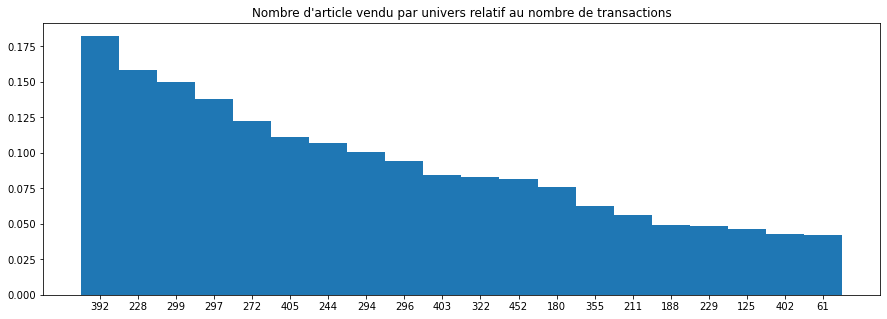

-------------------OHAIN F 2020--------------------------
26021
Time Taken to load recurence: ~0secondes


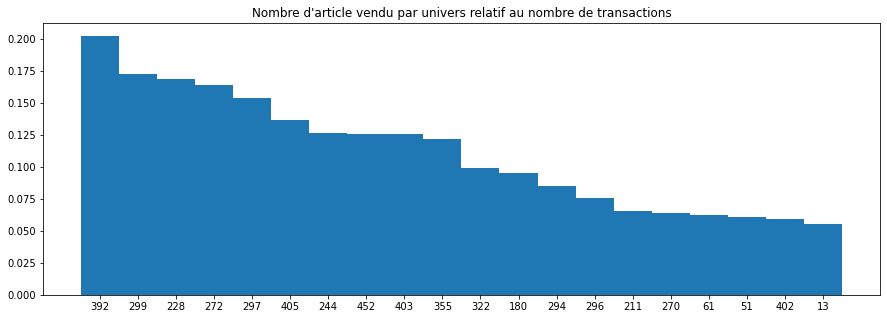

-------------------JURBISE--------------------------
23543
Time Taken to load recurence: ~0secondes


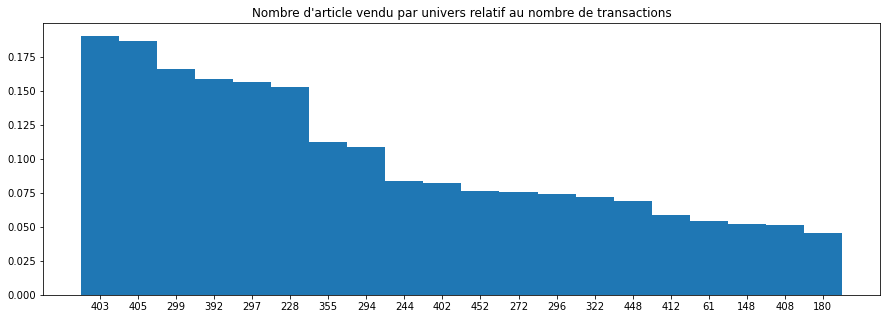

-------------------WEZEMBEEK-OPPEM--------------------------
11496
Time Taken to load recurence: ~0secondes


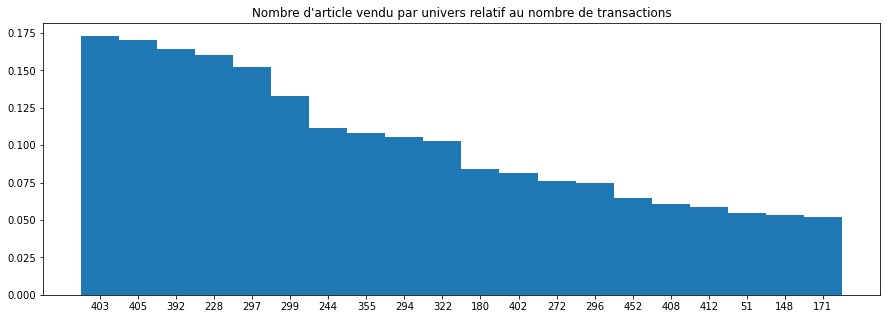

-------------------NEUPRE--------------------------
45851
Time Taken to load recurence: ~0secondes


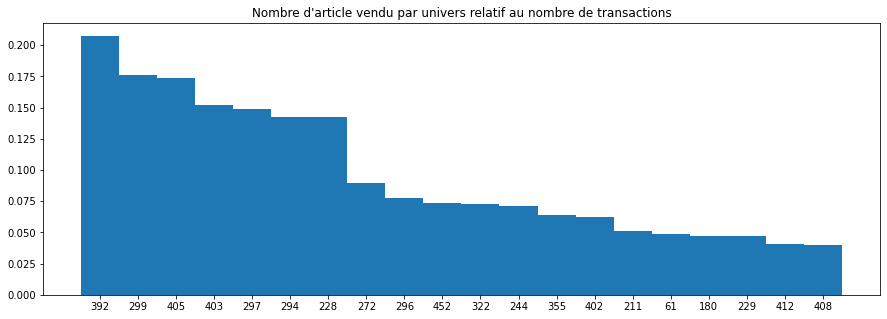

-------------------GRIMBERGEN F 2020--------------------------
3387
Time Taken to load recurence: ~0secondes


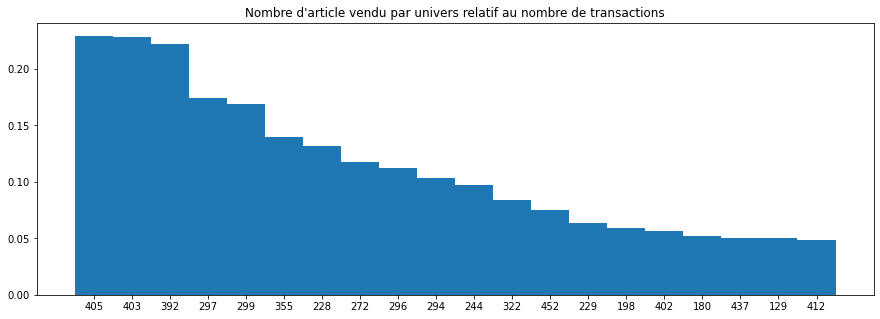

-------------------OVERIJSE--------------------------
10345
Time Taken to load recurence: ~0secondes


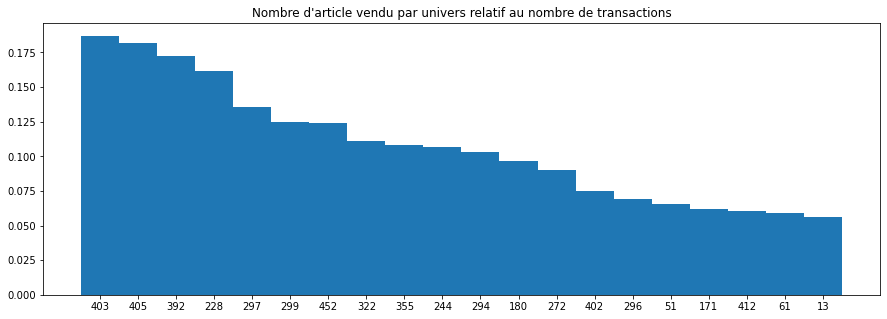

-------------------GANSHOREN--------------------------
21619
Time Taken to load recurence: ~0secondes


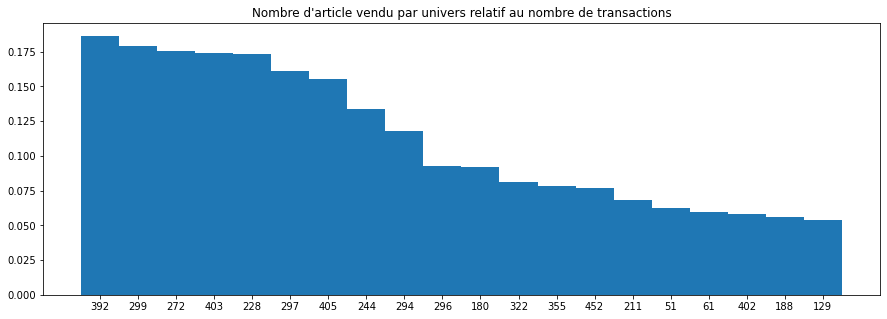

-------------------WOLUWE ST LAMBERT 1--------------------------
18049
Time Taken to load recurence: ~0secondes


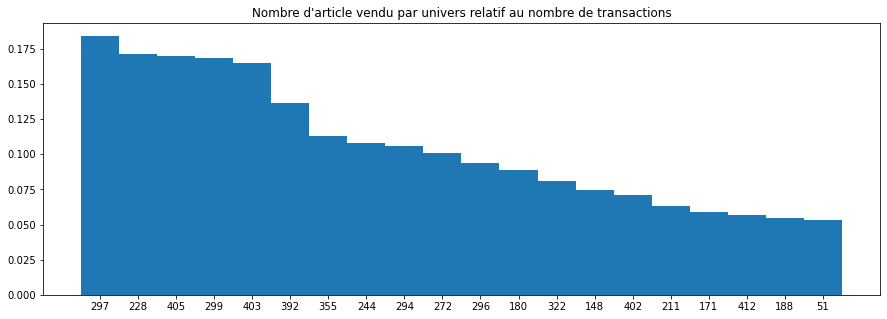

-------------------KRAAINEM--------------------------
29250
Time Taken to load recurence: ~0secondes


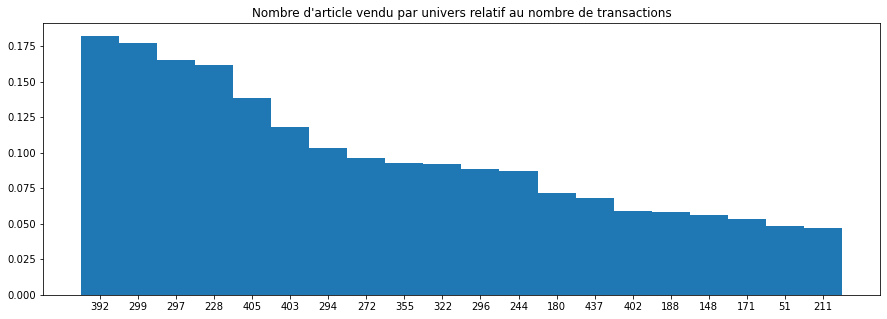

-------------------LA HULPE--------------------------
23168
Time Taken to load recurence: ~0secondes


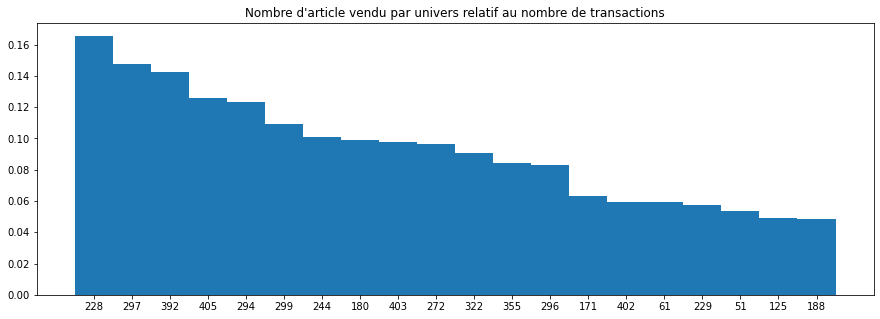

-------------------GENAPPE--------------------------
37399
Time Taken to load recurence: ~0secondes


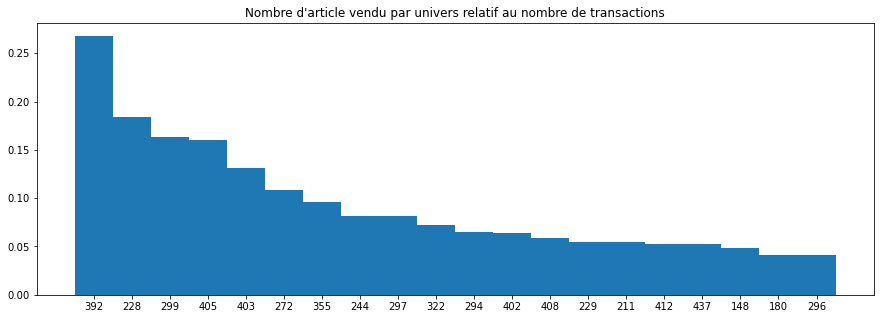

-------------------COURT SAINT ETIENNE--------------------------
26089
Time Taken to load recurence: ~0secondes


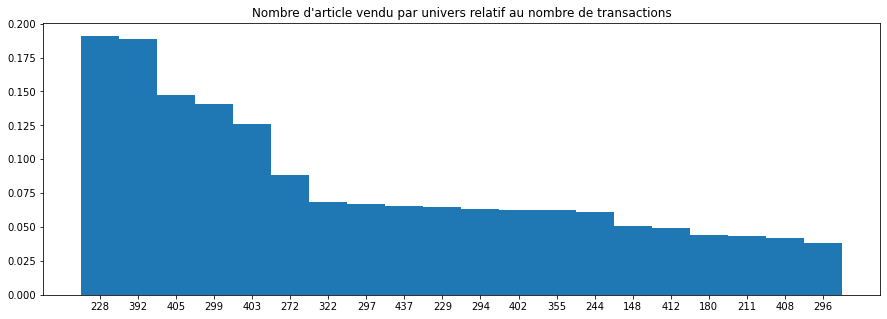

-------------------BRAINE L ALLEUD 1 F 2020--------------------------
851
Time Taken to load recurence: ~0secondes


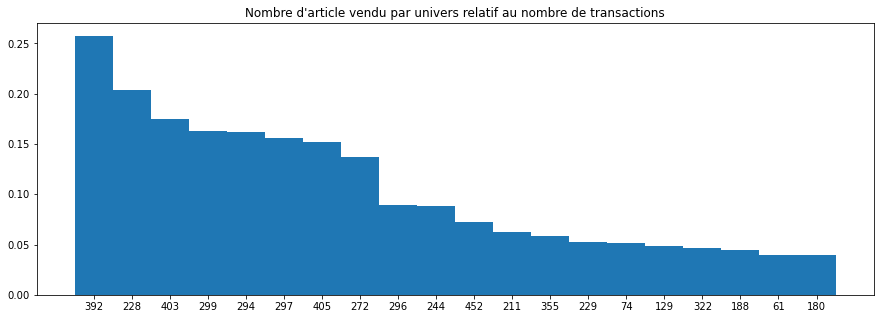

-------------------WATERLOO FAUBOURG--------------------------
9363
Time Taken to load recurence: ~0secondes


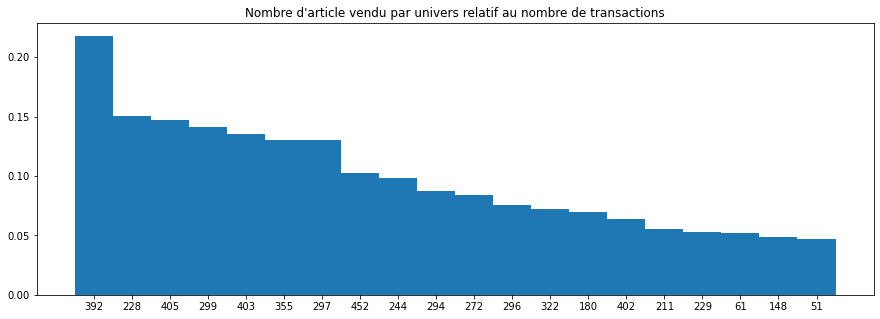

-------------------BOORTMEERBEEK--------------------------
13872
Time Taken to load recurence: ~0secondes


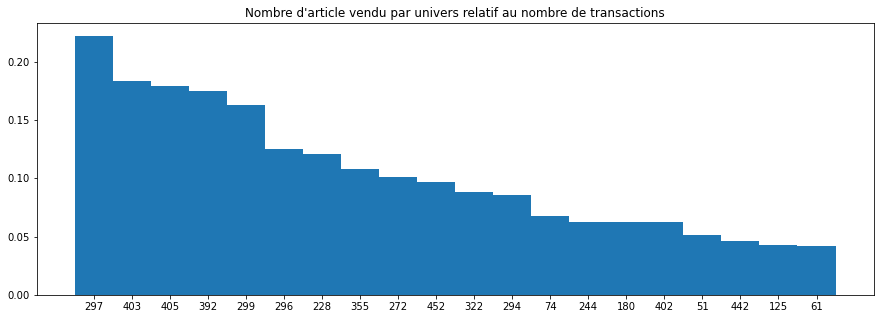

-------------------SINT-MARTENS-LATEM--------------------------
40064
Time Taken to load recurence: ~0secondes


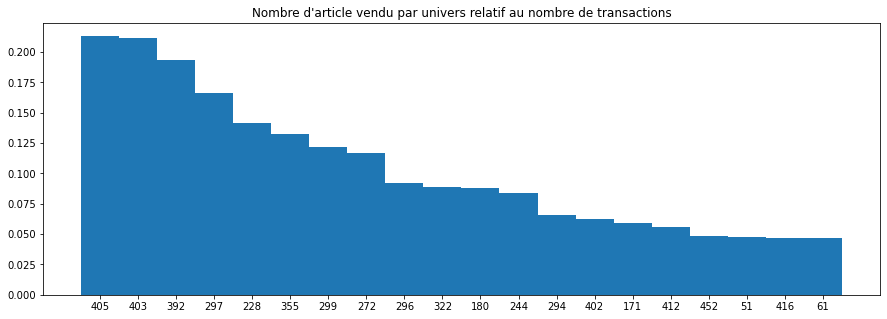

-------------------BRAINE L ALLEUD 1 I 2020--------------------------
28088
Time Taken to load recurence: ~0secondes


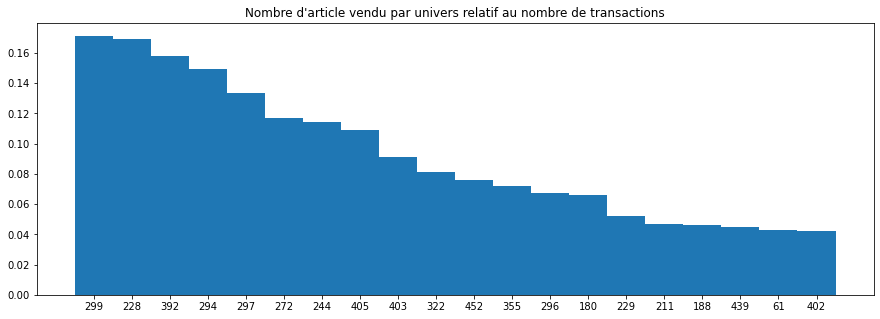

-------------------ALSEMBERG--------------------------
13533
Time Taken to load recurence: ~0secondes


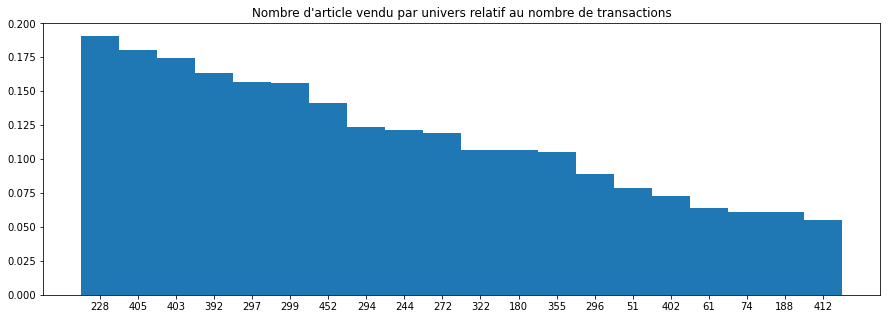

-------------------STRASSEN--------------------------
39034
Time Taken to load recurence: ~0secondes


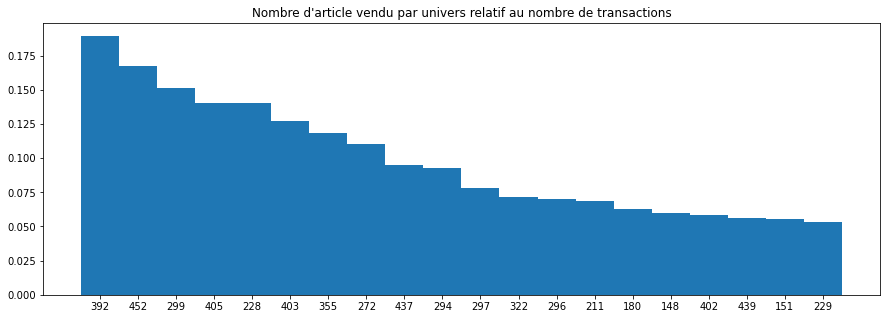

-------------------IXELLES PAGE--------------------------
14106
Time Taken to load recurence: ~0secondes


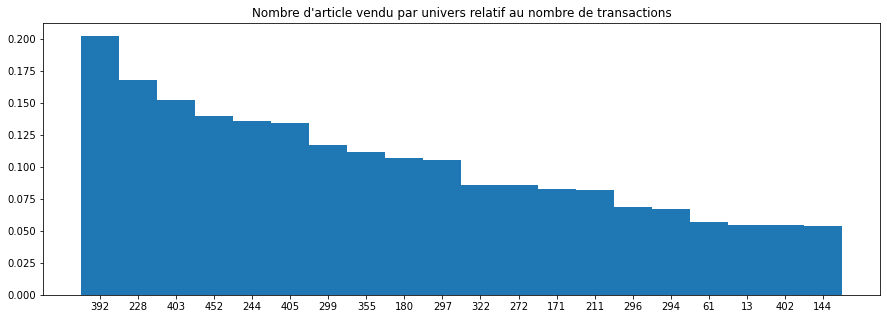

-------------------E&G IXELLES I 2020--------------------------
2327
Time Taken to load recurence: ~0secondes


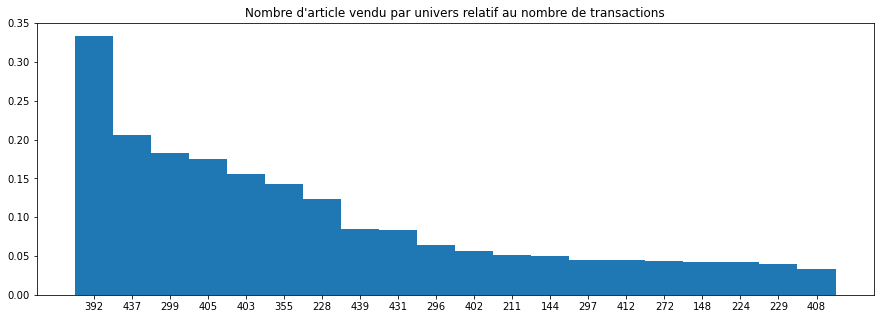

-------------------NIVELLES--------------------------
58235
Time Taken to load recurence: ~0secondes


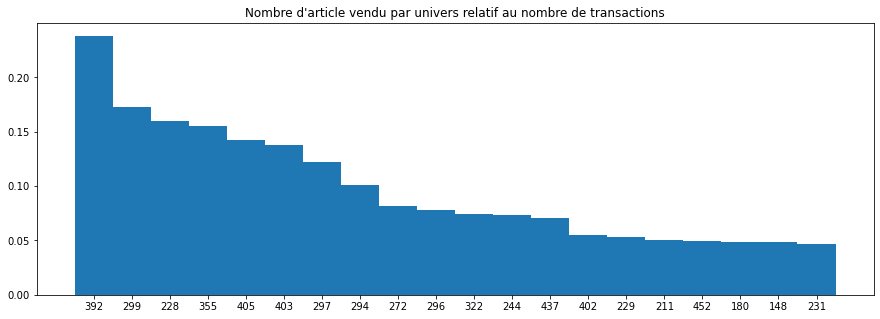

-------------------BRAINE L ALLEUD 2--------------------------
31870
Time Taken to load recurence: ~0secondes


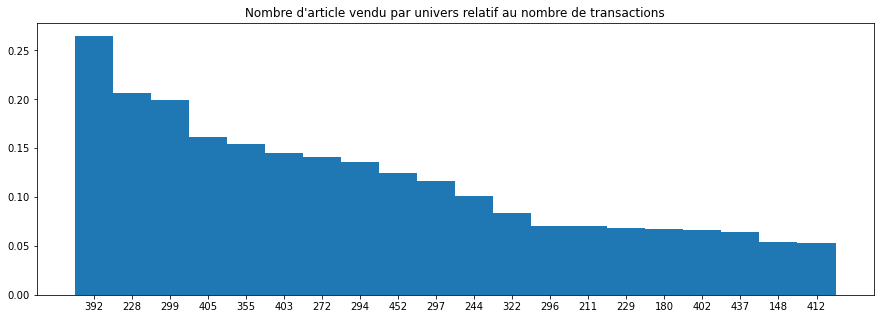

-------------------LIMELETTE--------------------------
30239
Time Taken to load recurence: ~0secondes


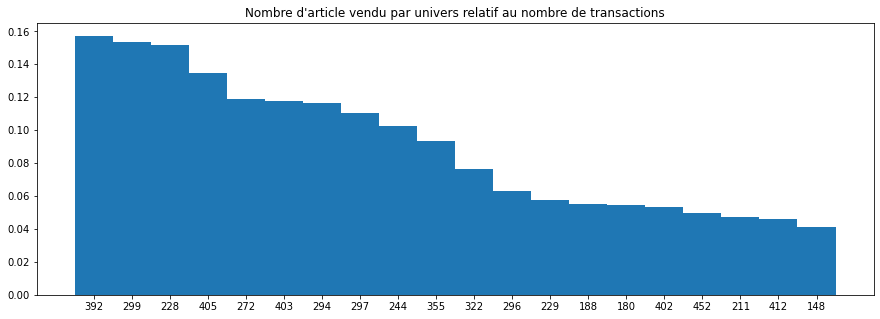

-------------------WATERLOO DREVE--------------------------
28696
Time Taken to load recurence: ~0secondes


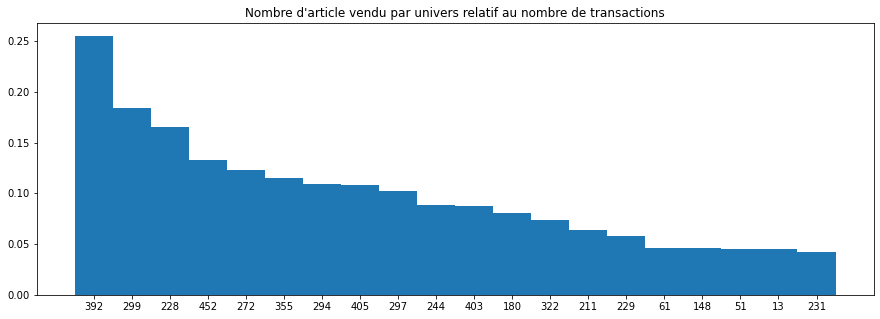

-------------------ITTRE--------------------------
38125
Time Taken to load recurence: ~0secondes


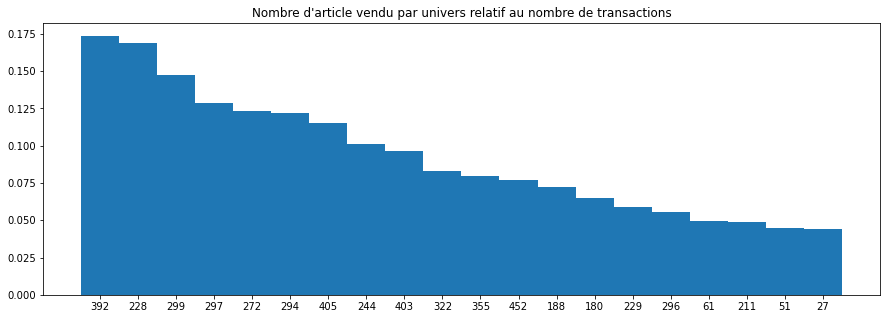

-------------------WOLUWE ST LAMBERT 2--------------------------
33728
Time Taken to load recurence: ~0secondes


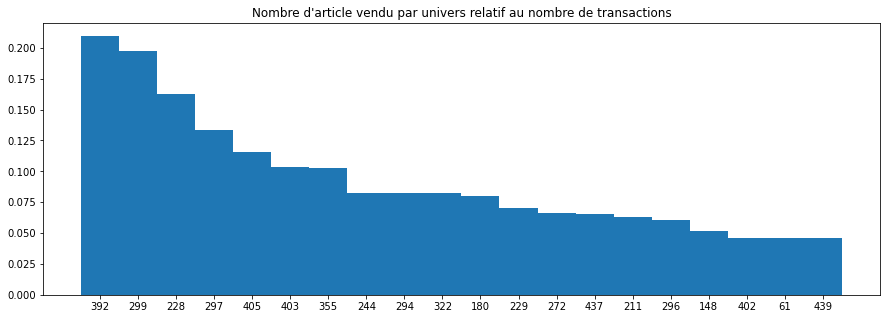

-------------------GREZ DOICEAU--------------------------
10442
Time Taken to load recurence: ~0secondes


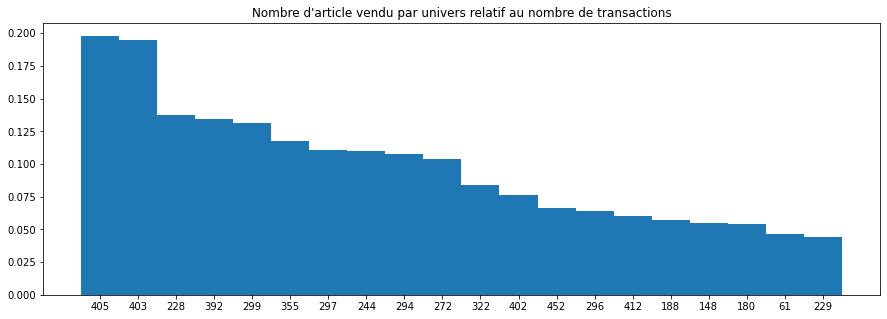

-------------------LILLOIS--------------------------
16626
Time Taken to load recurence: ~0secondes


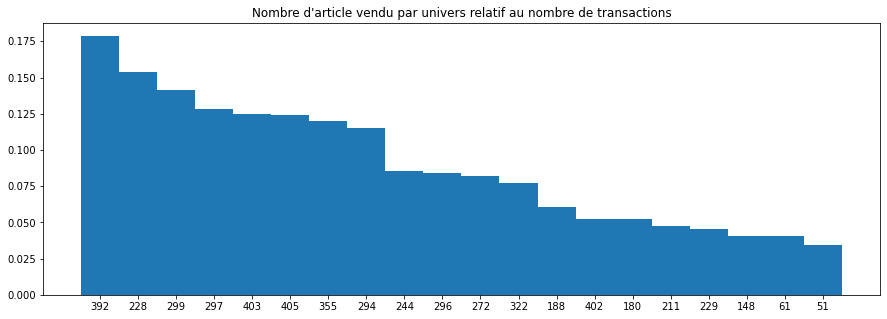

-------------------ARLON--------------------------
15533
Time Taken to load recurence: ~0secondes


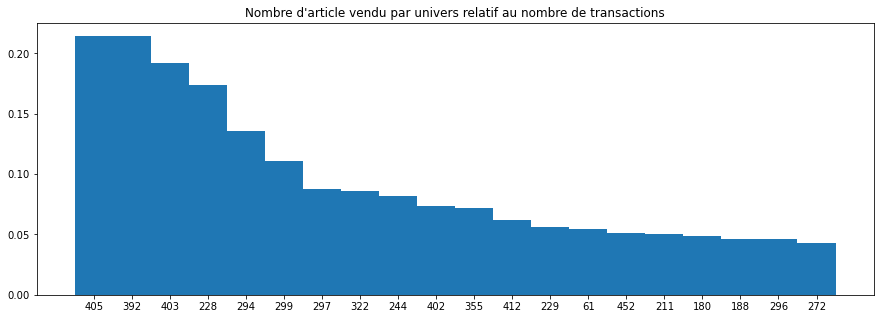

-------------------SINT PIETERS LEEUW--------------------------
30252
Time Taken to load recurence: ~0secondes


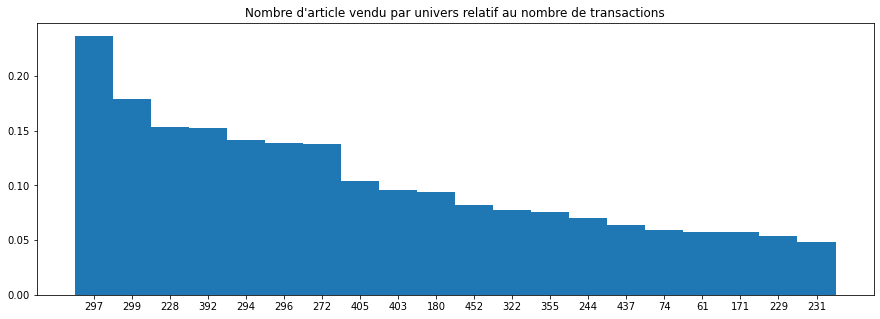

-------------------UCCLE F 2021--------------------------
7247
Time Taken to load recurence: ~0secondes


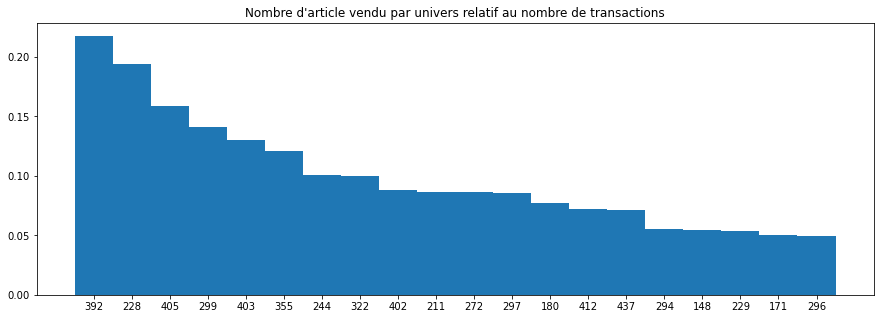

-------------------BRAINE LE COMTE--------------------------
33669
Time Taken to load recurence: ~0secondes


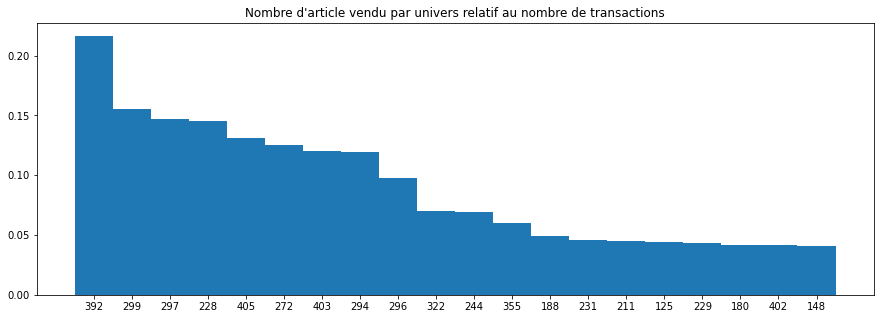

-------------------WOLUWE ST PIERRE--------------------------
35924
Time Taken to load recurence: ~0secondes


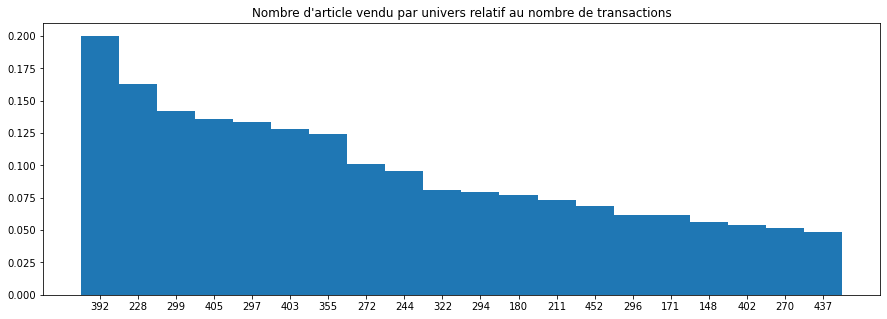

-------------------WEMMEL--------------------------
25224
Time Taken to load recurence: ~0secondes


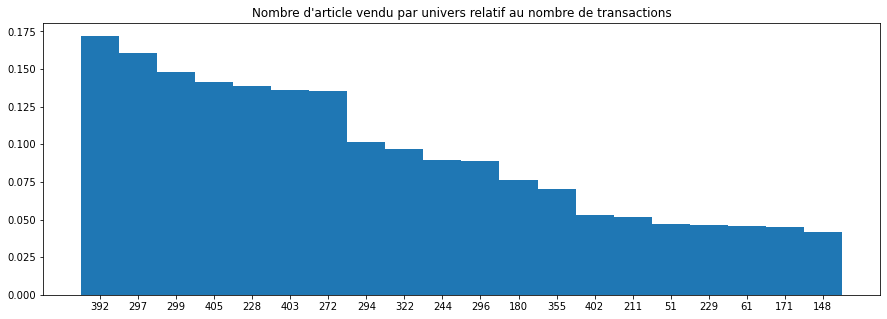

-------------------BRAINE L ALLEUD 1--------------------------
4117
Time Taken to load recurence: ~0secondes


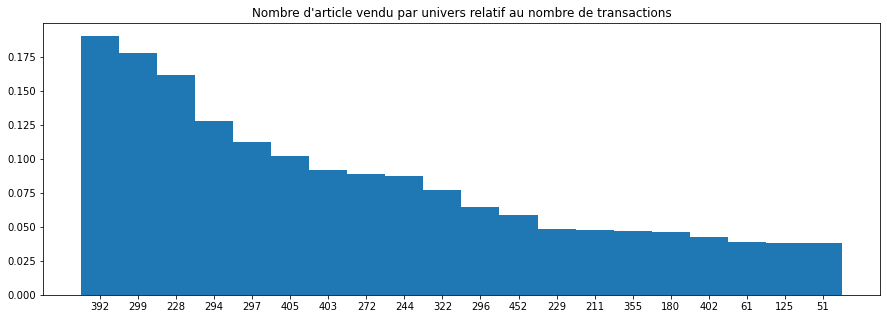

-------------------LIMAL I 2020--------------------------
30243
Time Taken to load recurence: ~0secondes


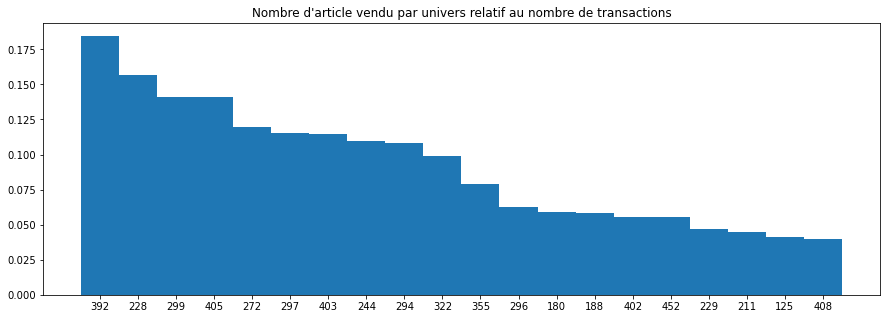

-------------------ANTWERPEN I 2021--------------------------
346
Time Taken to load recurence: ~0secondes


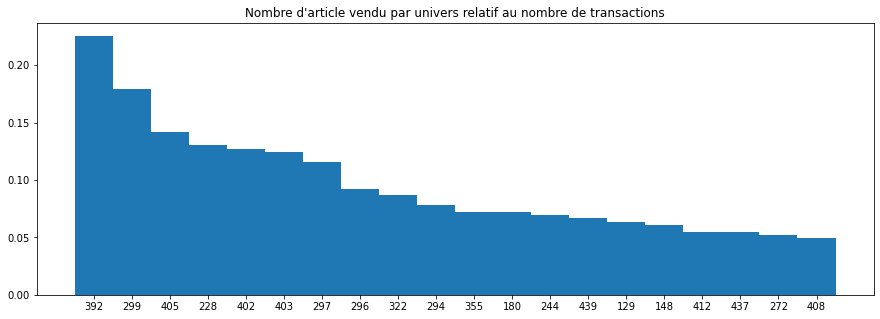

-------------------GRIMBERGEN--------------------------
2443
Time Taken to load recurence: ~0secondes


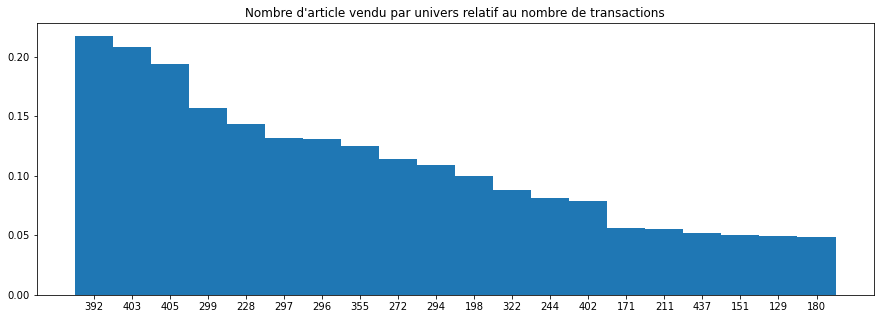

-------------------OHAIN--------------------------
2222
Time Taken to load recurence: ~0secondes


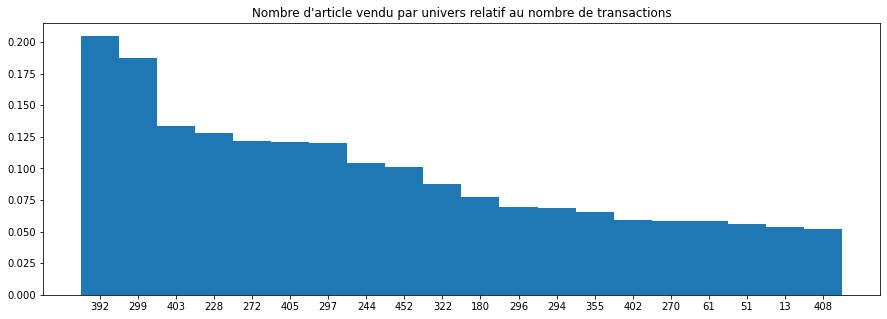

In [64]:
# If do_shop, load recurence for shops
dico_rec_mag = {}
if do_shop:
    for mag_key in all_mag_key:
        print("-------------------" + all_mag_lib[mag_key] + "--------------------------")
        mag_tran = all_mag_tra[mag_key]

        dico_rec_mag[mag_key], mag_nbr_univ = load_recurence(mag_tran)
#         mag_rules = get_rules(mag_tran, min_support, min_confidence, mag_nbr_univ)
#         print_rules(mag_rules, Univers_Depth, conn)

==============0===================
NOT ENOUGH DATA 
==============1===================
316
Time Taken to load recurence: ~0secondes


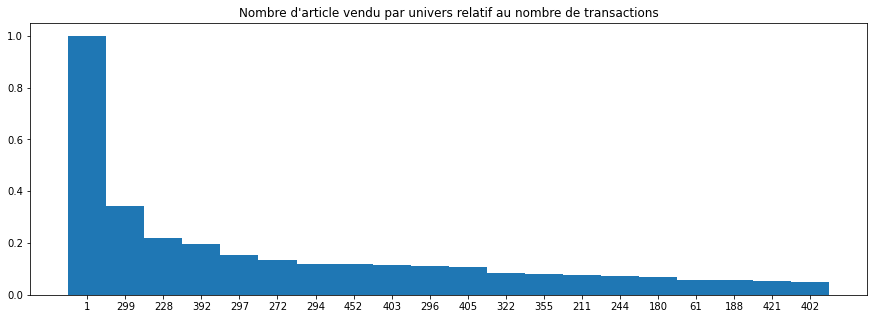

==============2===================
1282
Time Taken to load recurence: ~0secondes


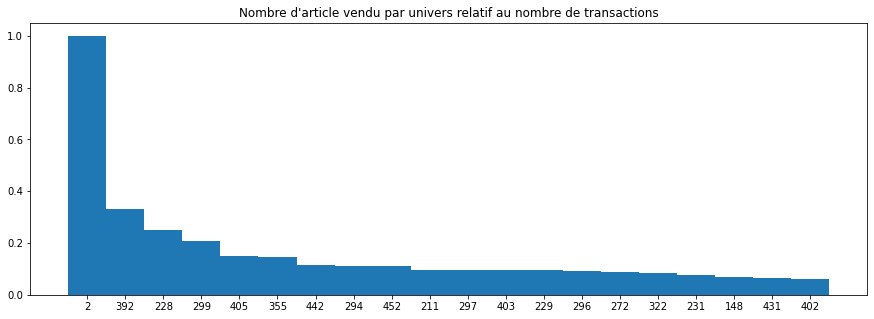

==============3===================
NOT ENOUGH DATA 
==============4===================
NOT ENOUGH DATA 
==============5===================
NOT ENOUGH DATA 
==============6===================
NOT ENOUGH DATA 
==============7===================
NOT ENOUGH DATA 
==============8===================
NOT ENOUGH DATA 
==============9===================
5466
Time Taken to load recurence: ~0secondes


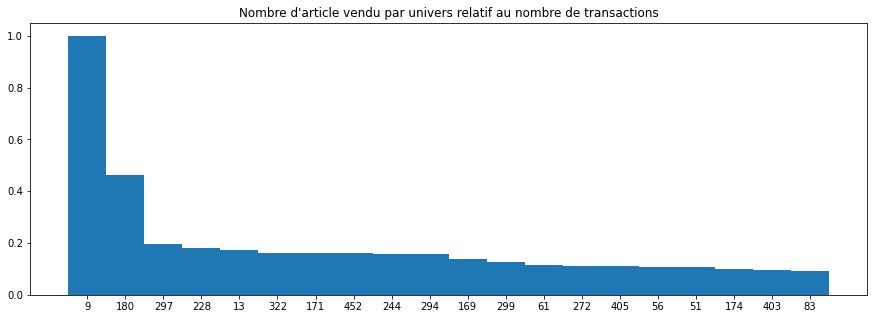

==============10===================
8718
Time Taken to load recurence: ~0secondes


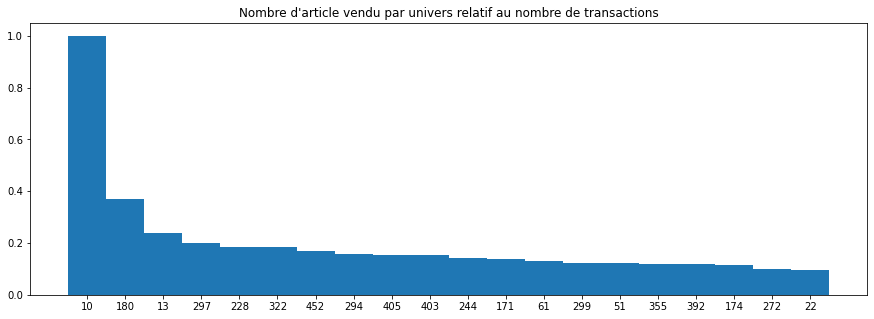

==============11===================
NOT ENOUGH DATA 
==============12===================
976
Time Taken to load recurence: ~0secondes


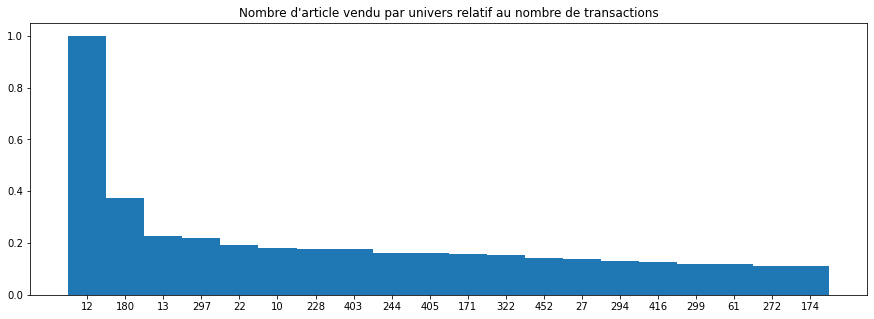

==============13===================
30803
Time Taken to load recurence: ~0secondes


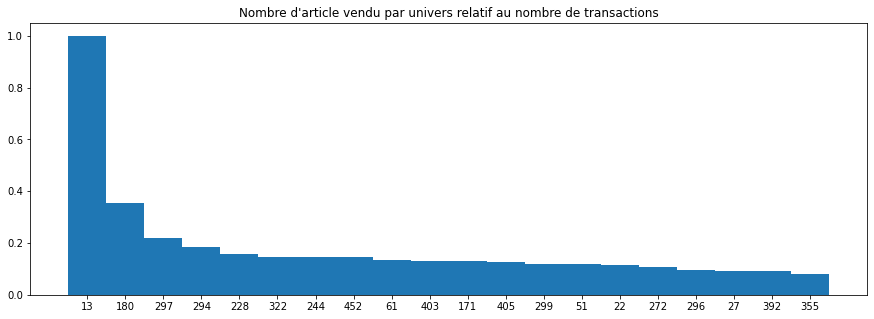

==============14===================
NOT ENOUGH DATA 
==============15===================
106
Time Taken to load recurence: ~0secondes


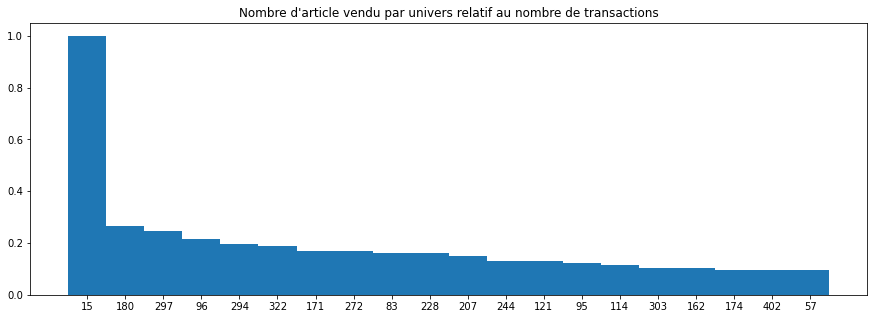

==============16===================
1443
Time Taken to load recurence: ~0secondes


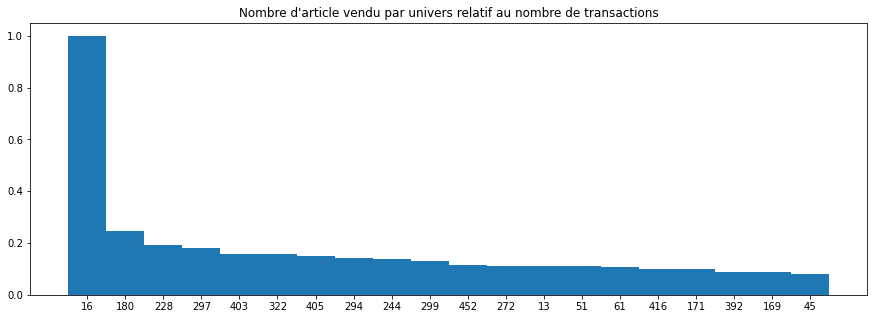

==============17===================
1768
Time Taken to load recurence: ~0secondes


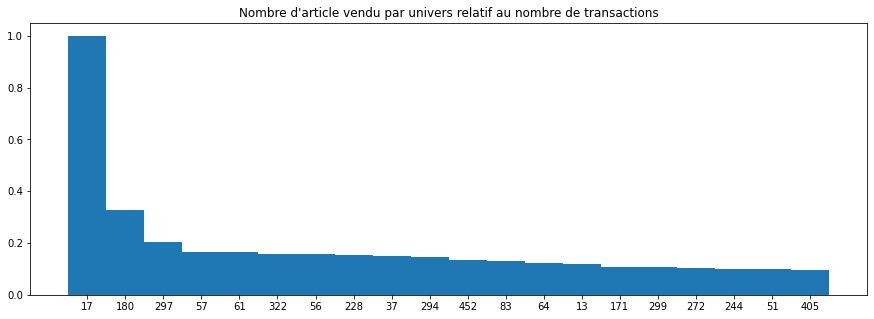

==============18===================
15164
Time Taken to load recurence: ~0secondes


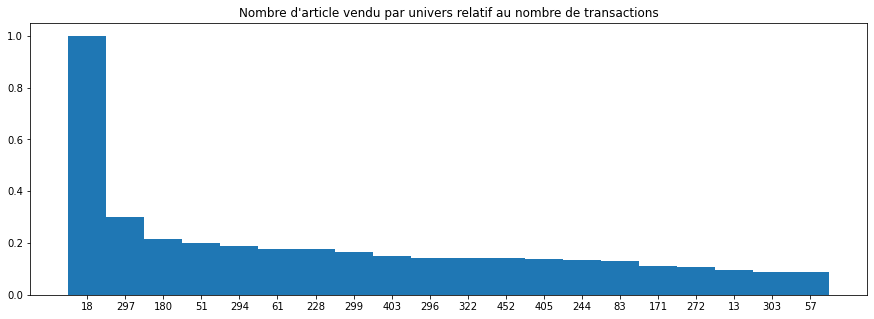

==============19===================
3713
Time Taken to load recurence: ~0secondes


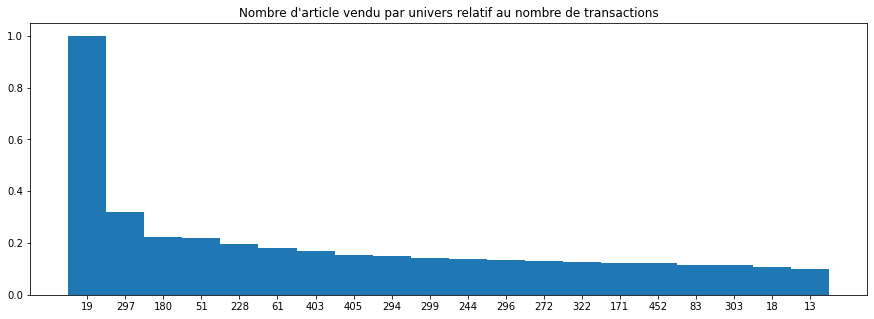

==============20===================
465
Time Taken to load recurence: ~0secondes


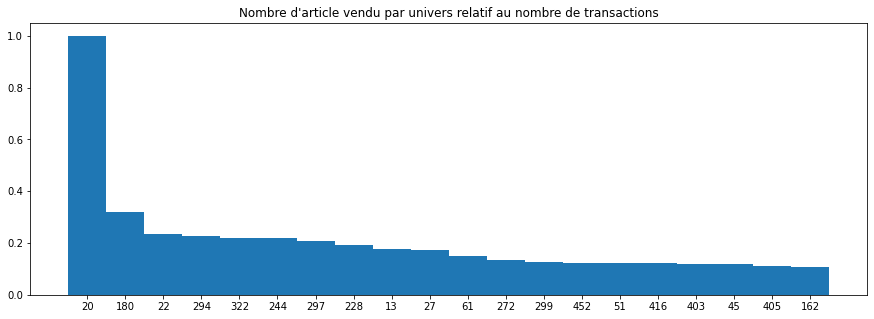

==============21===================
NOT ENOUGH DATA 
==============22===================
26843
Time Taken to load recurence: ~0secondes


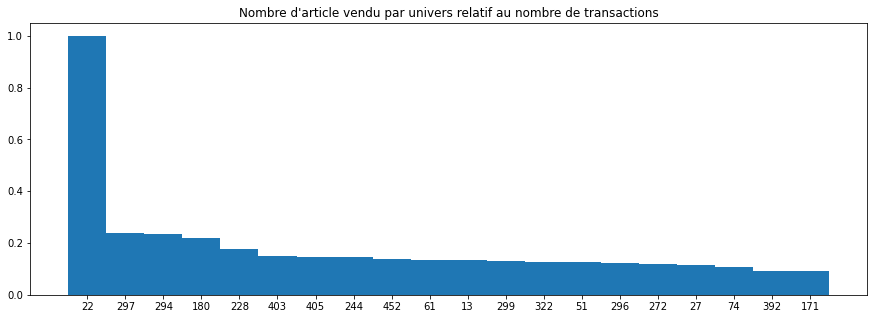

==============23===================
588
Time Taken to load recurence: ~0secondes


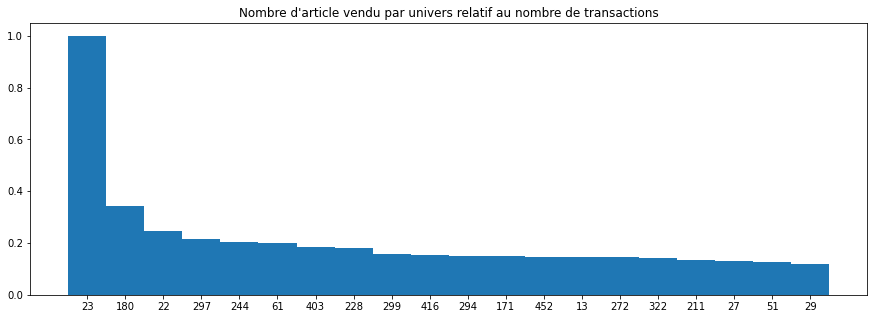

==============24===================
3175
Time Taken to load recurence: ~0secondes


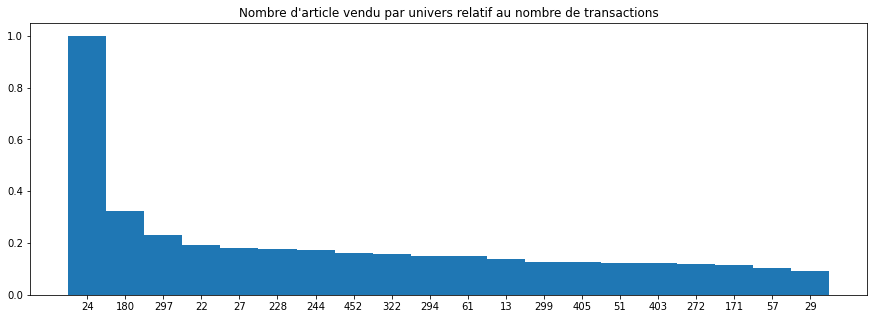

==============25===================
3729
Time Taken to load recurence: ~0secondes


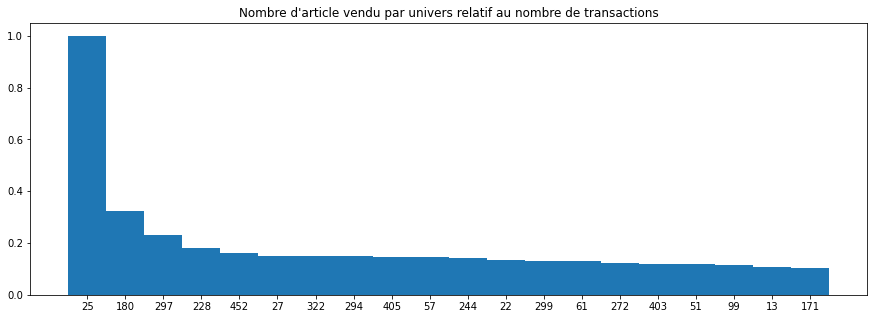

==============26===================
NOT ENOUGH DATA 
==============27===================
25784
Time Taken to load recurence: ~0secondes


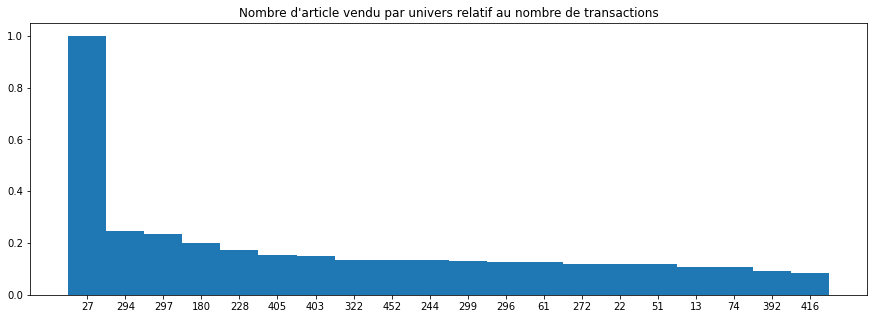

==============28===================
NOT ENOUGH DATA 
==============29===================
8922
Time Taken to load recurence: ~0secondes


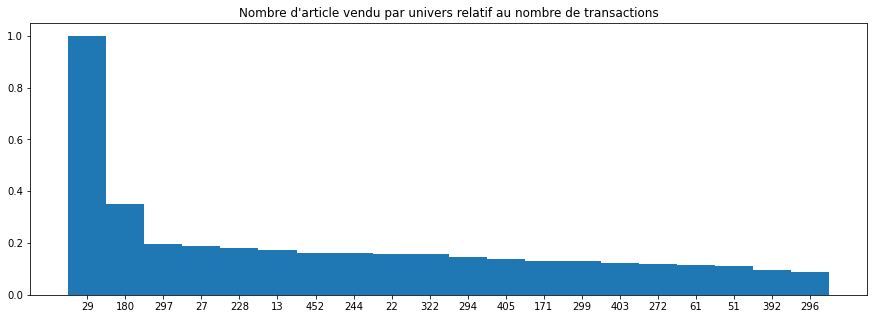

==============30===================
894
Time Taken to load recurence: ~0secondes


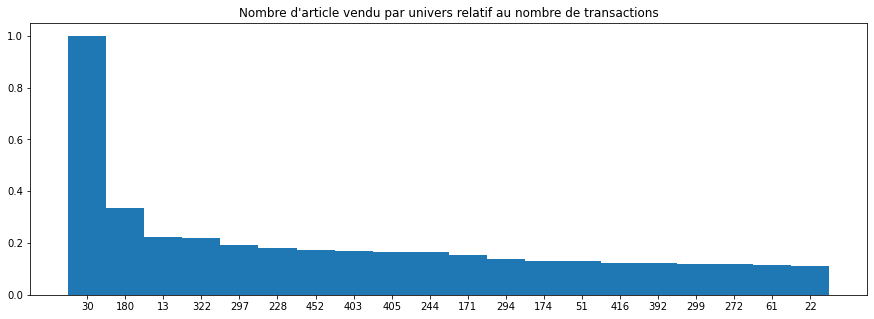

==============31===================
1835
Time Taken to load recurence: ~0secondes


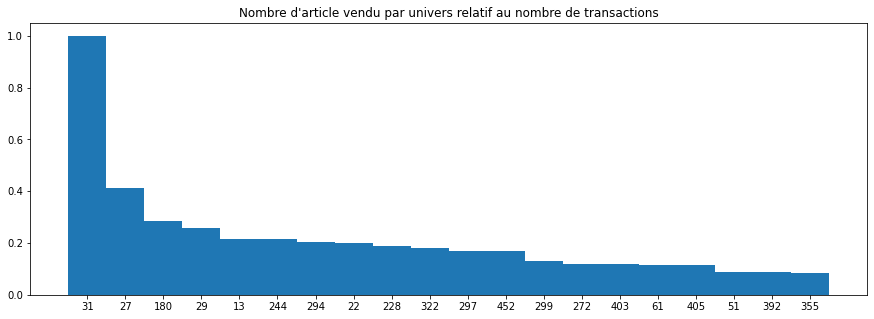

==============32===================
NOT ENOUGH DATA 
==============33===================
NOT ENOUGH DATA 
==============34===================
154
Time Taken to load recurence: ~0secondes


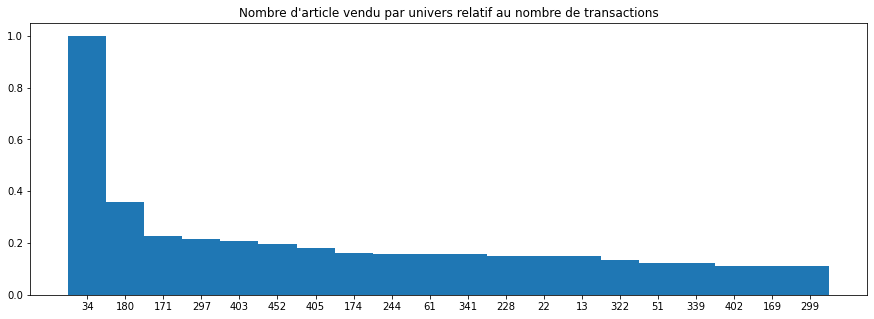

==============35===================
1126
Time Taken to load recurence: ~0secondes


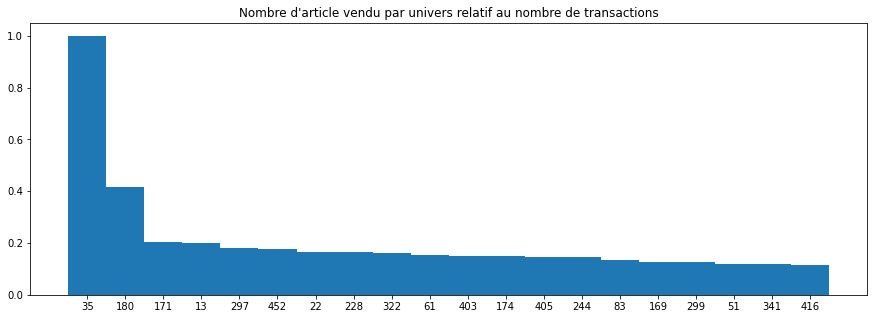

==============36===================
NOT ENOUGH DATA 
==============37===================
9649
Time Taken to load recurence: ~0secondes


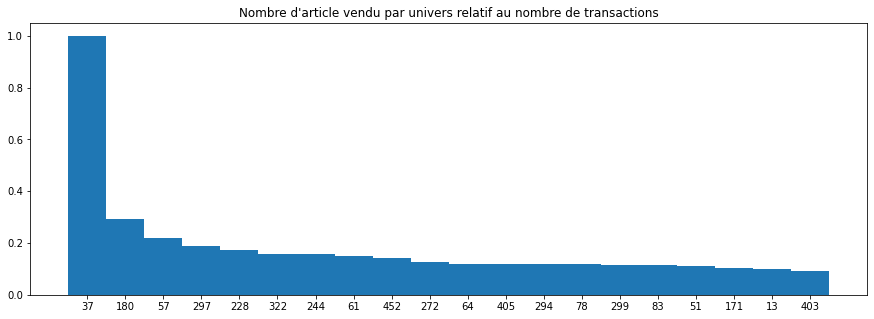

==============38===================
4033
Time Taken to load recurence: ~0secondes


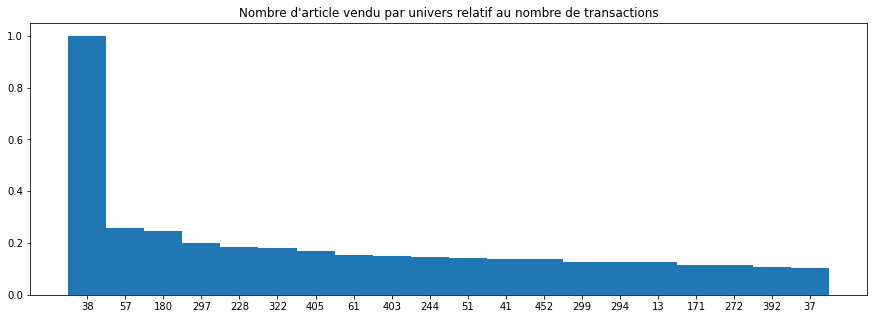

==============39===================
NOT ENOUGH DATA 
==============40===================
NOT ENOUGH DATA 
==============41===================
9314
Time Taken to load recurence: ~0secondes


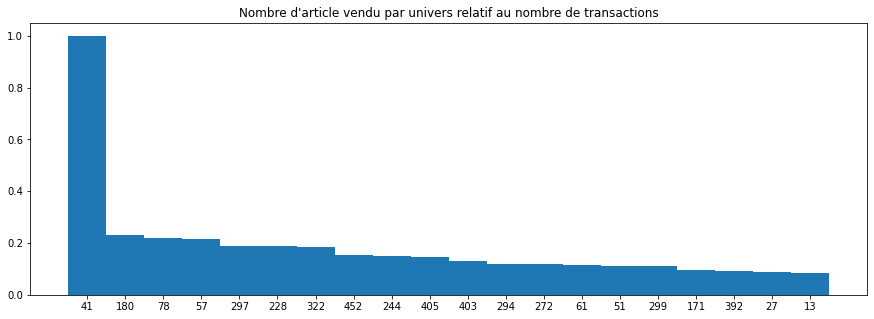

==============42===================
NOT ENOUGH DATA 
==============43===================
NOT ENOUGH DATA 
==============44===================
NOT ENOUGH DATA 
==============45===================
14066
Time Taken to load recurence: ~0secondes


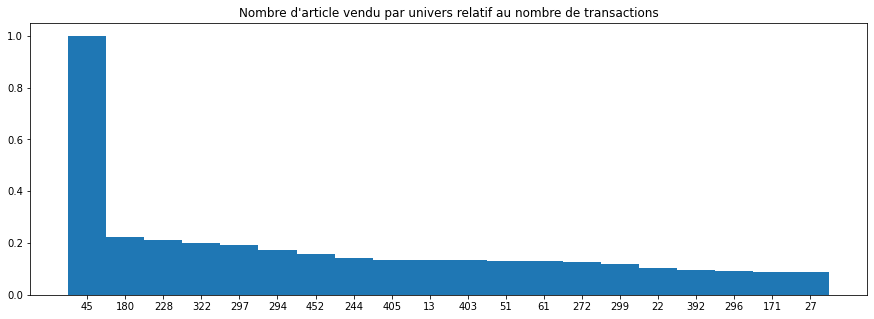

==============46===================
NOT ENOUGH DATA 
==============47===================
NOT ENOUGH DATA 
==============48===================
NOT ENOUGH DATA 
==============49===================
NOT ENOUGH DATA 
==============50===================
NOT ENOUGH DATA 
==============51===================
37989
Time Taken to load recurence: ~0secondes


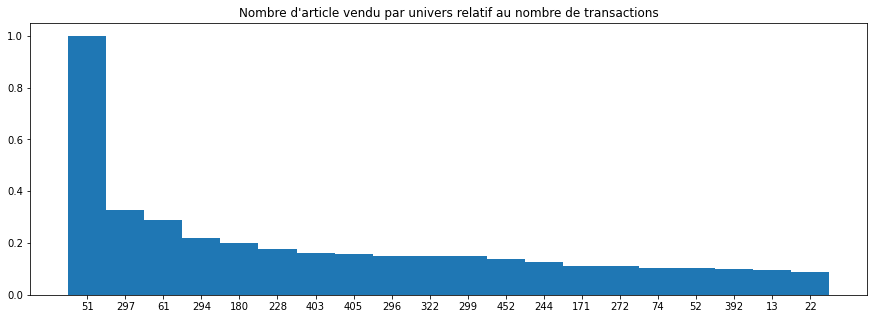

==============52===================
16635
Time Taken to load recurence: ~0secondes


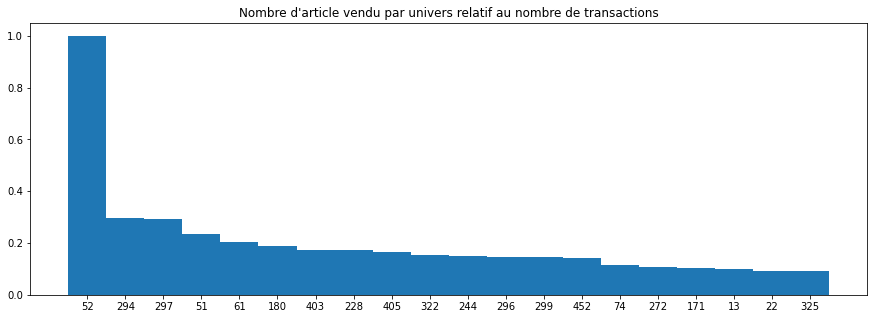

==============53===================
2157
Time Taken to load recurence: ~0secondes


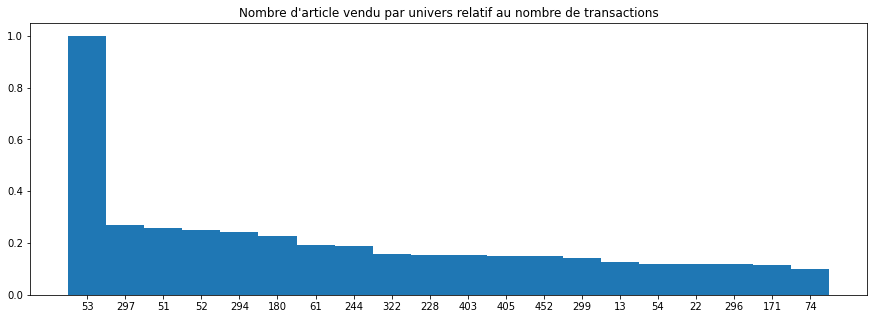

==============54===================
10999
Time Taken to load recurence: ~0secondes


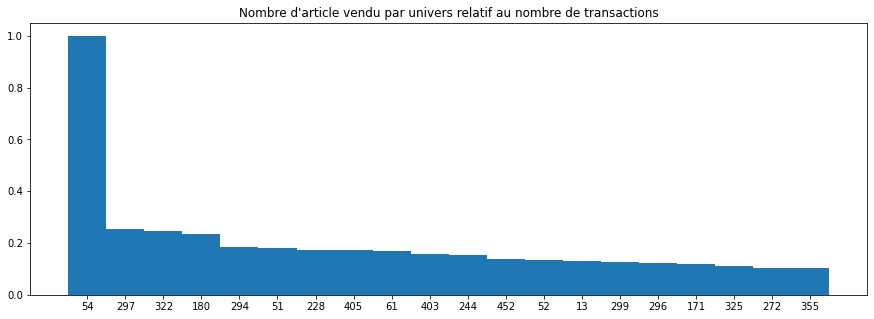

==============55===================
4182
Time Taken to load recurence: ~0secondes


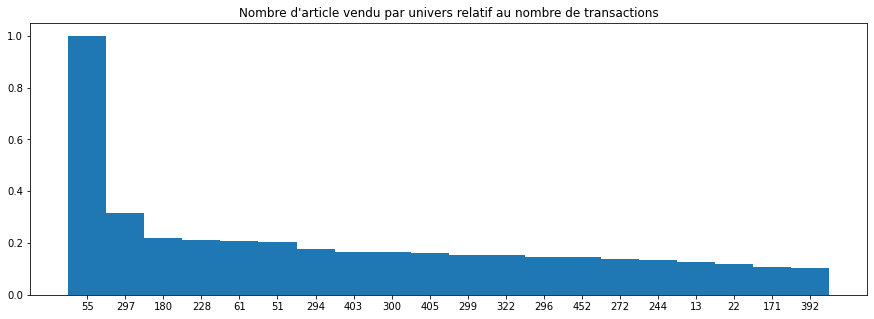

==============56===================
9978
Time Taken to load recurence: ~0secondes


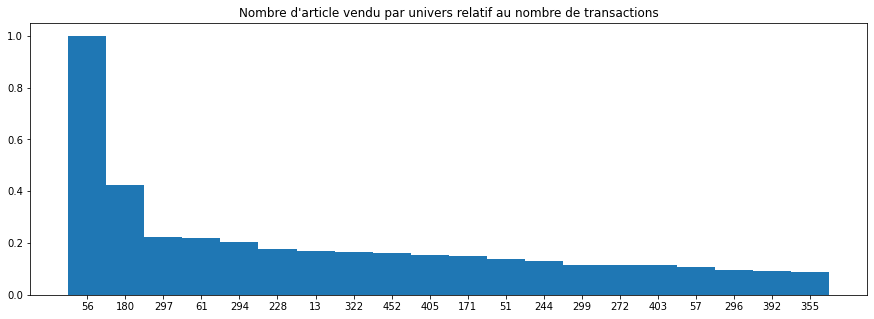

==============57===================
22316
Time Taken to load recurence: ~0secondes


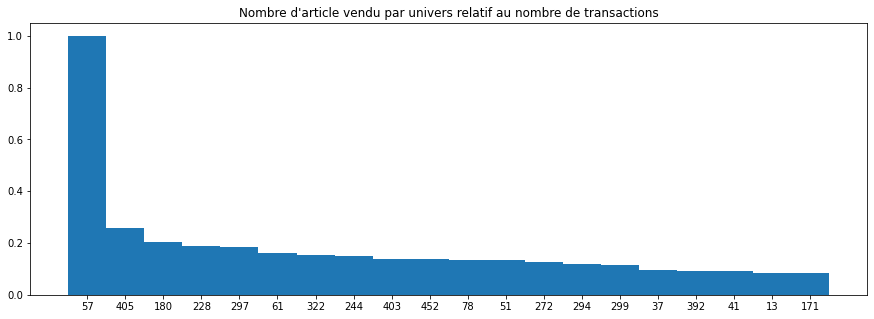

==============58===================
615
Time Taken to load recurence: ~0secondes


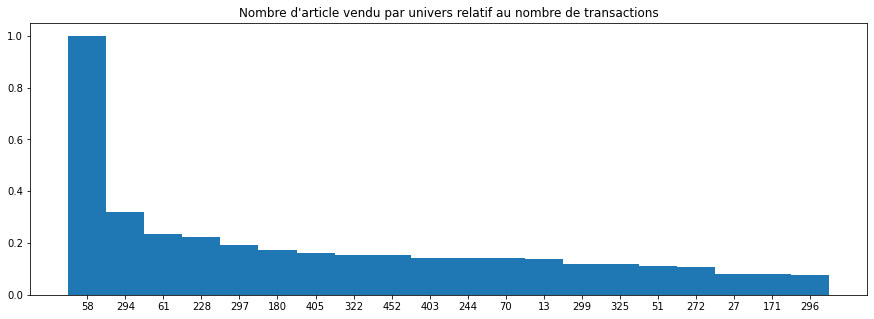

==============59===================
5378
Time Taken to load recurence: ~0secondes


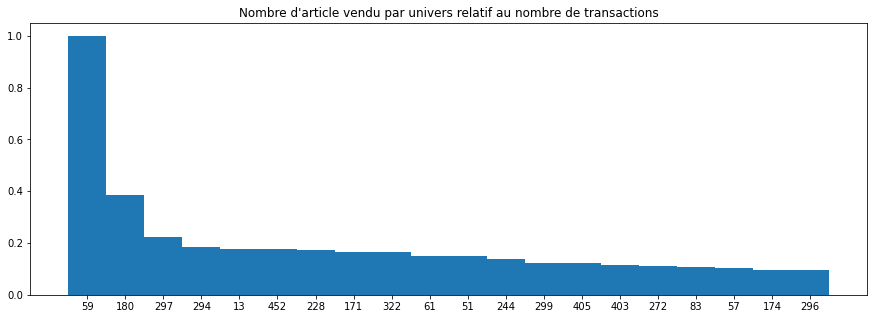

==============60===================
5094
Time Taken to load recurence: ~0secondes


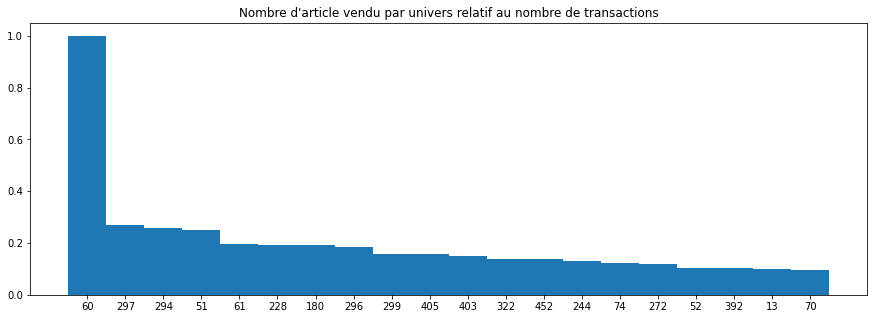

==============61===================
40820
Time Taken to load recurence: ~0secondes


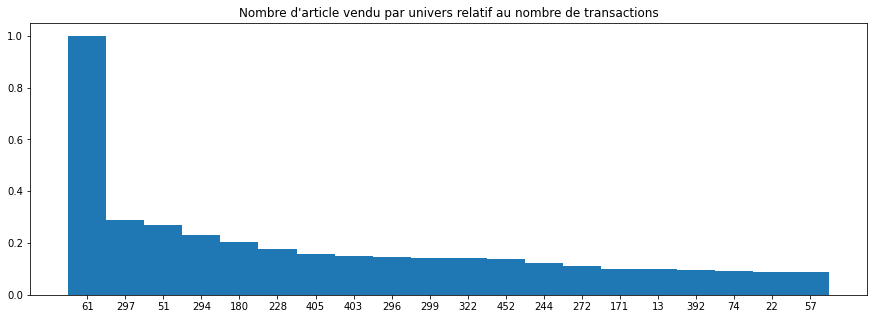

==============62===================
NOT ENOUGH DATA 
==============63===================
NOT ENOUGH DATA 
==============64===================
9323
Time Taken to load recurence: ~0secondes


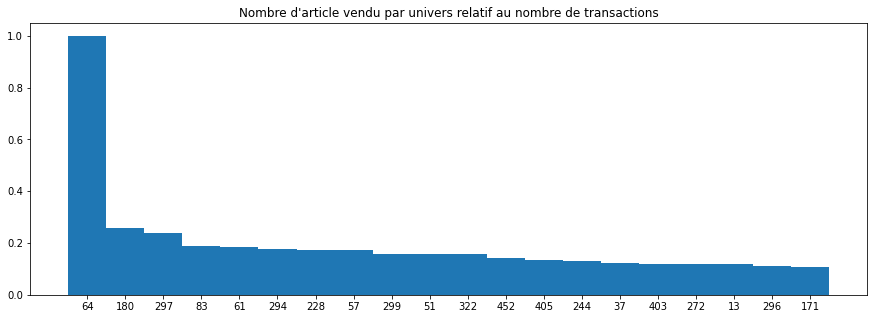

==============65===================
NOT ENOUGH DATA 
==============66===================
5380
Time Taken to load recurence: ~0secondes


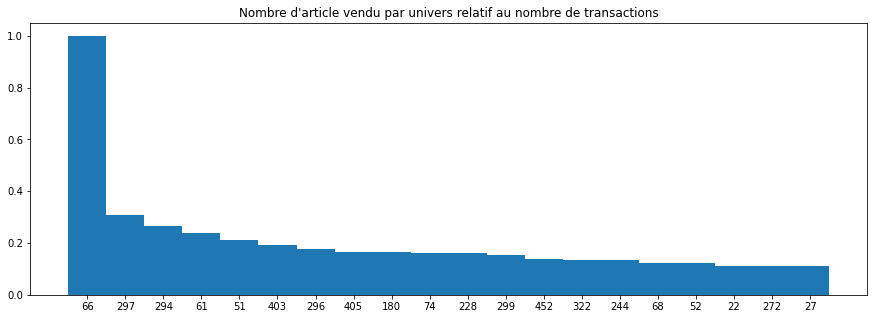

==============67===================
2072
Time Taken to load recurence: ~0secondes


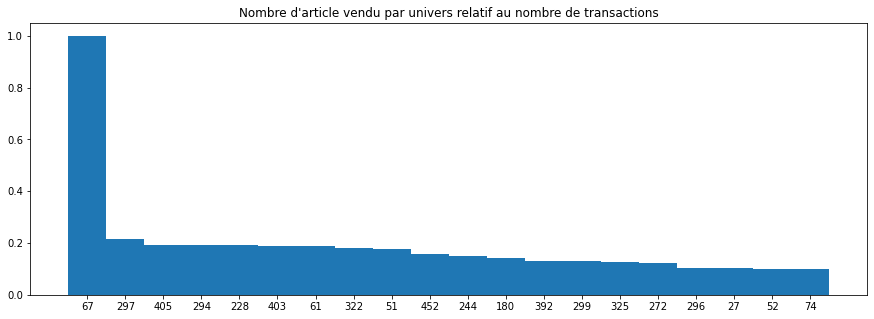

==============68===================
11234
Time Taken to load recurence: ~0secondes


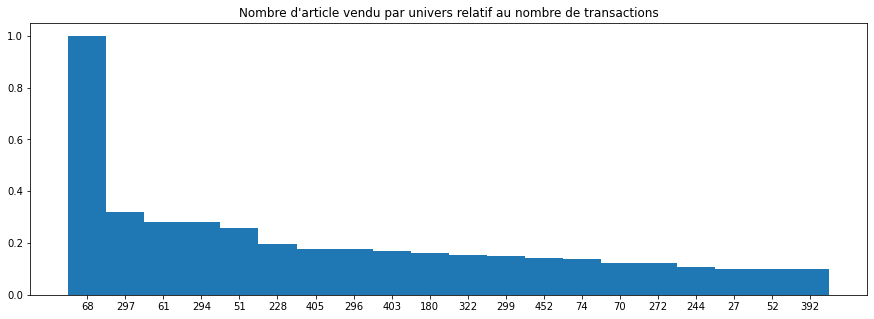

==============69===================
8183
Time Taken to load recurence: ~0secondes


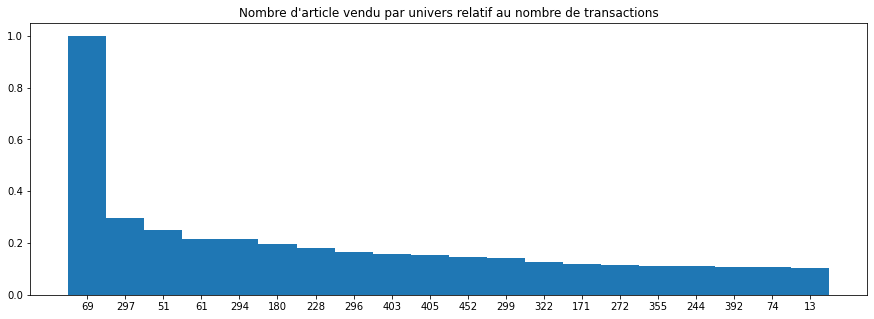

==============70===================
12780
Time Taken to load recurence: ~0secondes


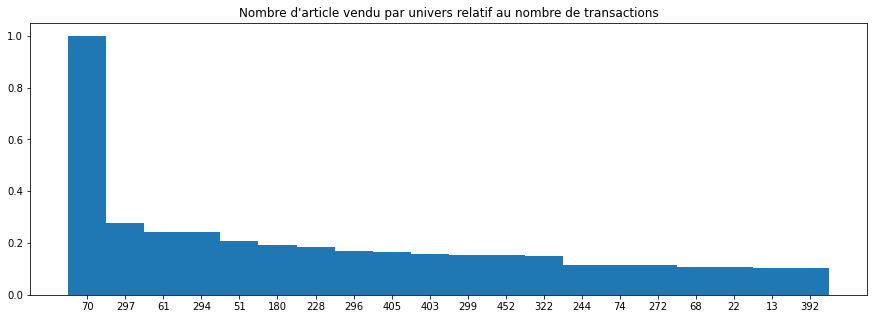

==============71===================
NOT ENOUGH DATA 
==============72===================
NOT ENOUGH DATA 
==============73===================
NOT ENOUGH DATA 
==============74===================
27054
Time Taken to load recurence: ~0secondes


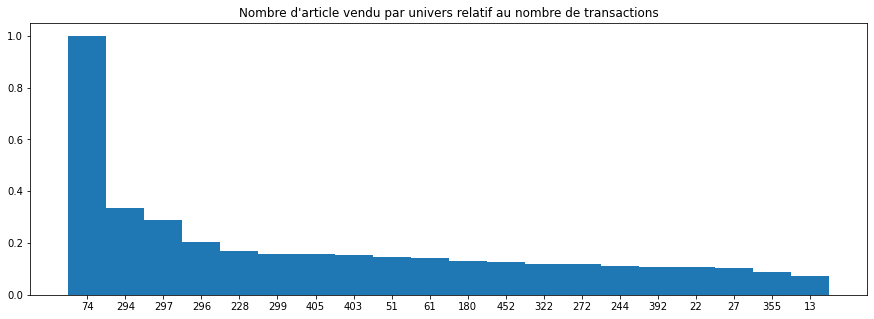

==============75===================
61
Time Taken to load recurence: ~0secondes


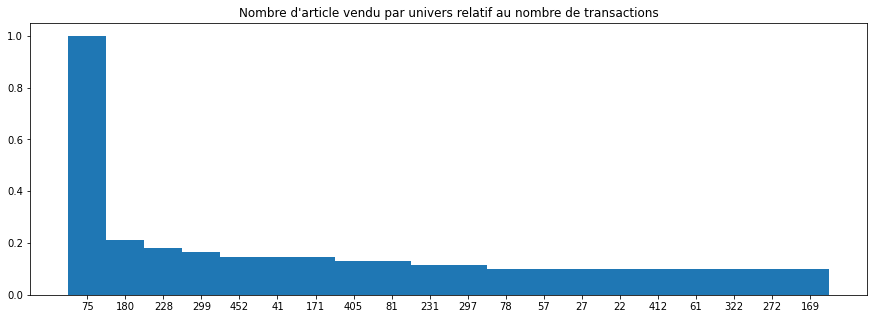

==============76===================
437
Time Taken to load recurence: ~0secondes


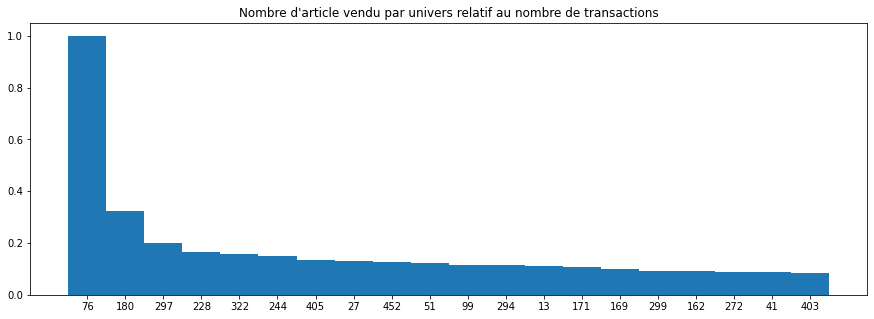

==============77===================
239
Time Taken to load recurence: ~0secondes


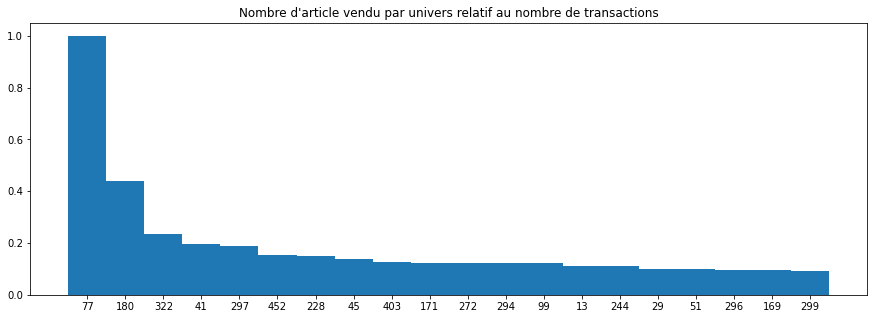

==============78===================
9624
Time Taken to load recurence: ~0secondes


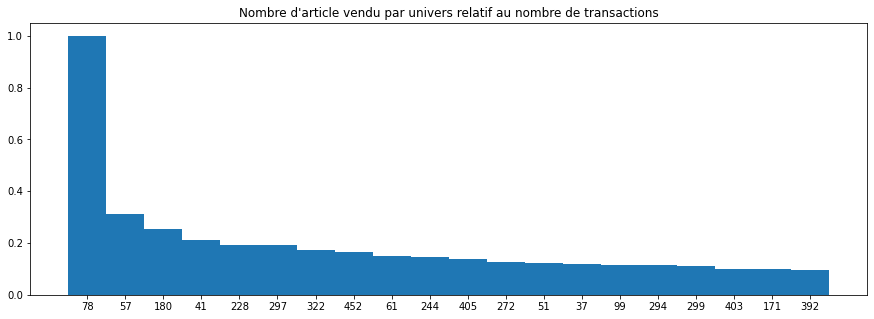

==============79===================
1346
Time Taken to load recurence: ~0secondes


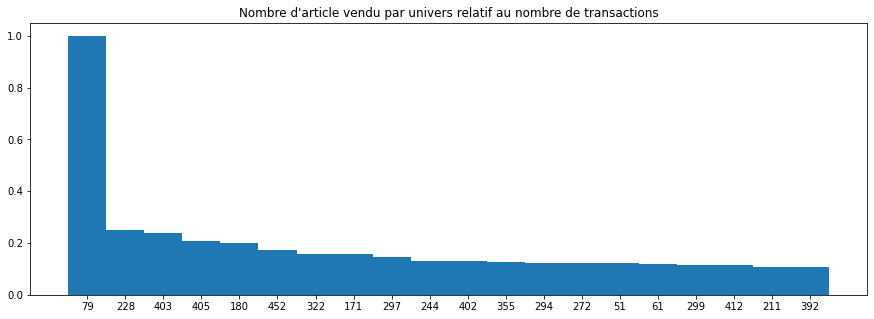

==============80===================
293
Time Taken to load recurence: ~0secondes


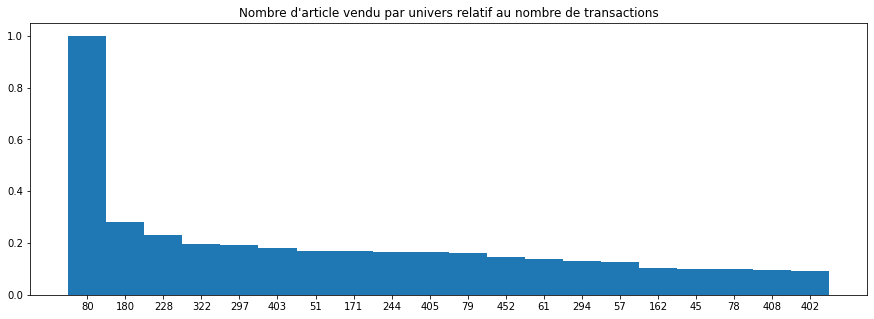

==============81===================
1957
Time Taken to load recurence: ~0secondes


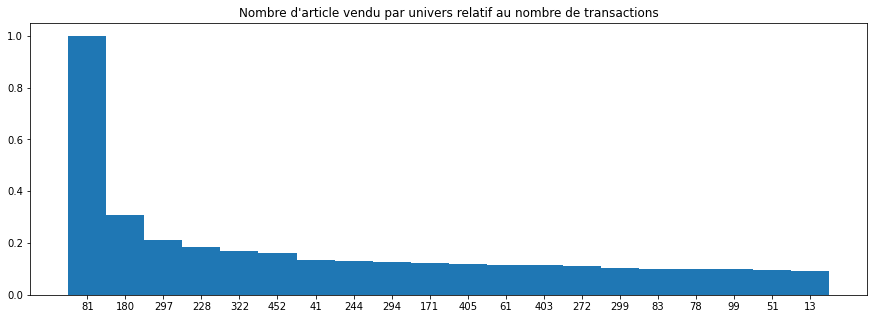

==============82===================
NOT ENOUGH DATA 
==============83===================
21652
Time Taken to load recurence: ~0secondes


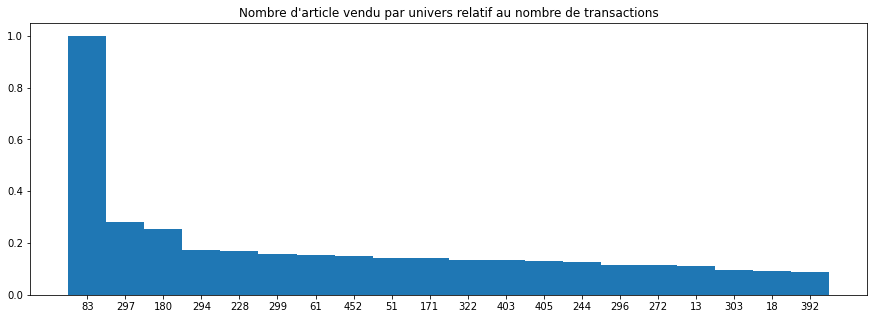

==============84===================
930
Time Taken to load recurence: ~0secondes


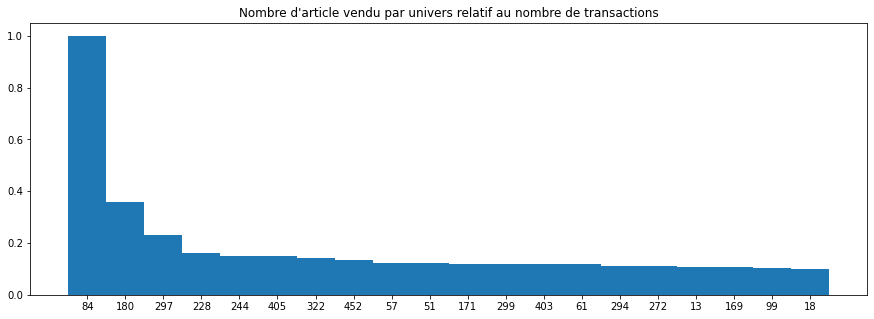

==============85===================
1422
Time Taken to load recurence: ~0secondes


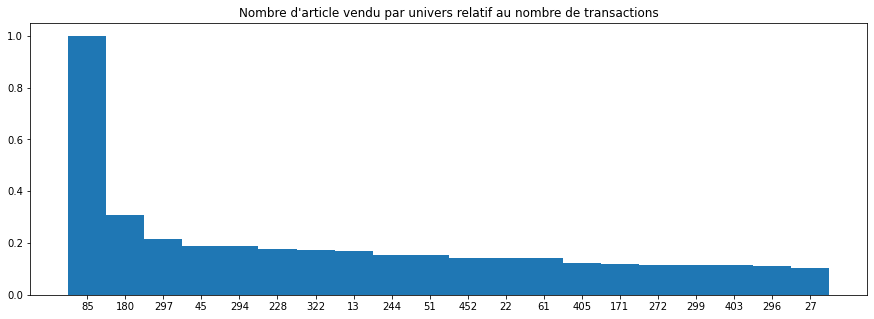

==============86===================
4856
Time Taken to load recurence: ~0secondes


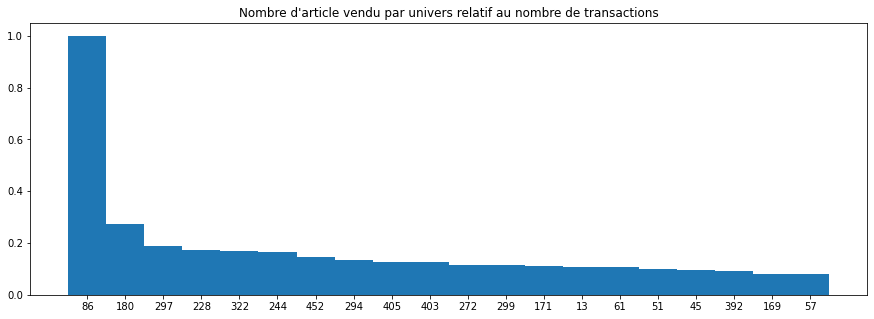

==============87===================
NOT ENOUGH DATA 
==============88===================
3939
Time Taken to load recurence: ~0secondes


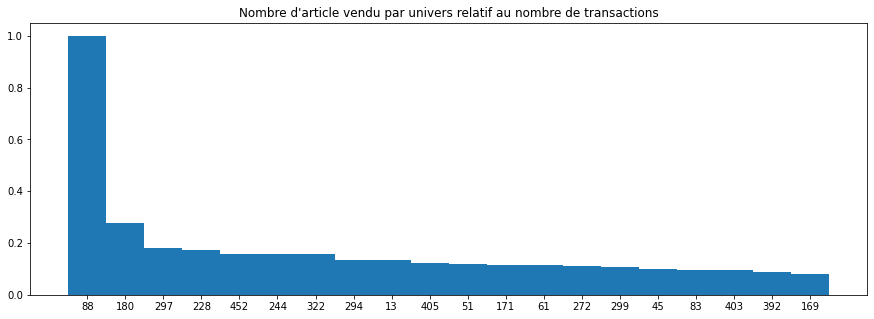

==============89===================
NOT ENOUGH DATA 
==============90===================
NOT ENOUGH DATA 
==============91===================
NOT ENOUGH DATA 
==============92===================
3775
Time Taken to load recurence: ~0secondes


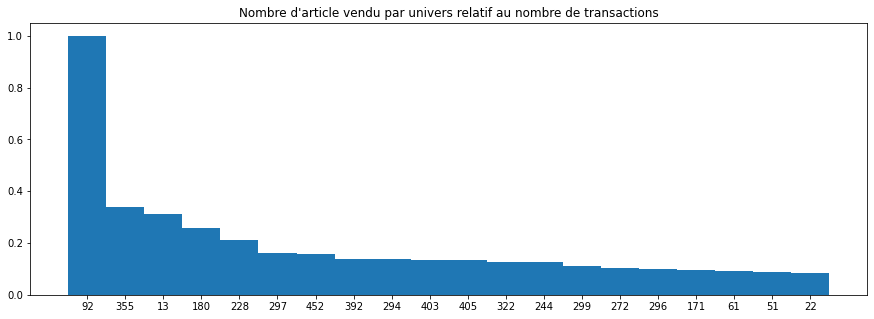

==============93===================
NOT ENOUGH DATA 
==============94===================
1347
Time Taken to load recurence: ~0secondes


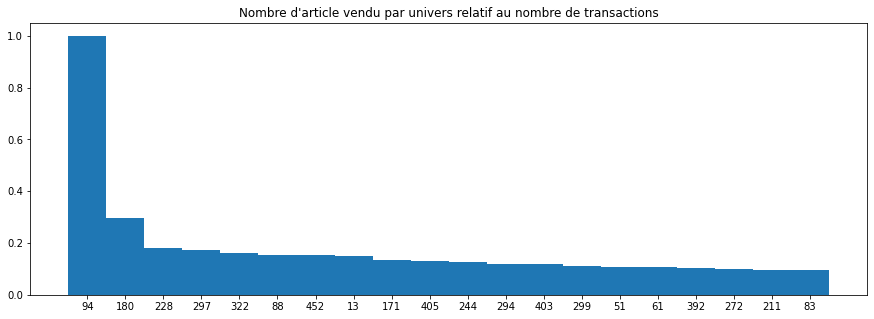

==============95===================
1234
Time Taken to load recurence: ~0secondes


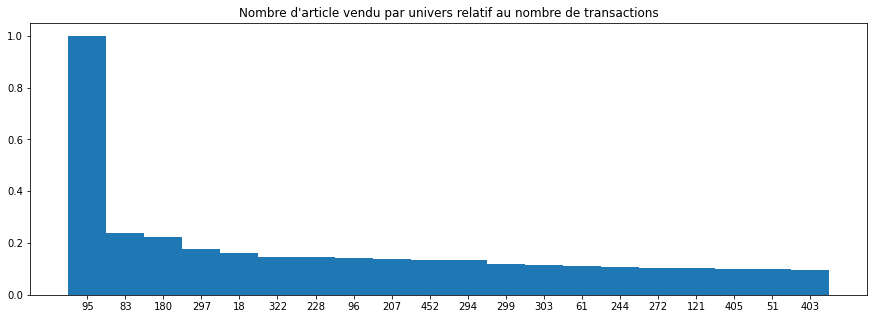

==============96===================
2222
Time Taken to load recurence: ~0secondes


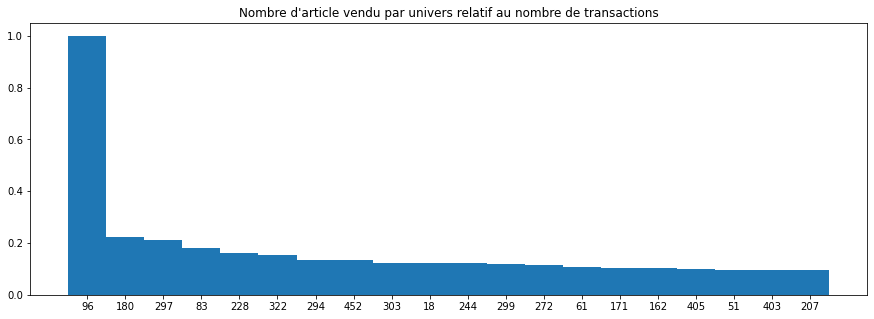

==============97===================
NOT ENOUGH DATA 
==============98===================
7249
Time Taken to load recurence: ~0secondes


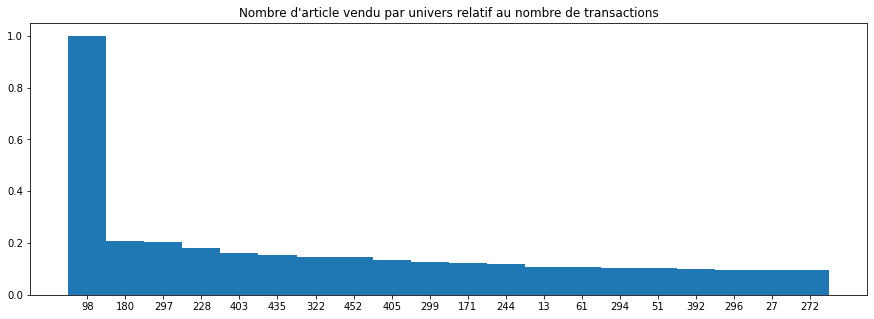

==============99===================
8601
Time Taken to load recurence: ~0secondes


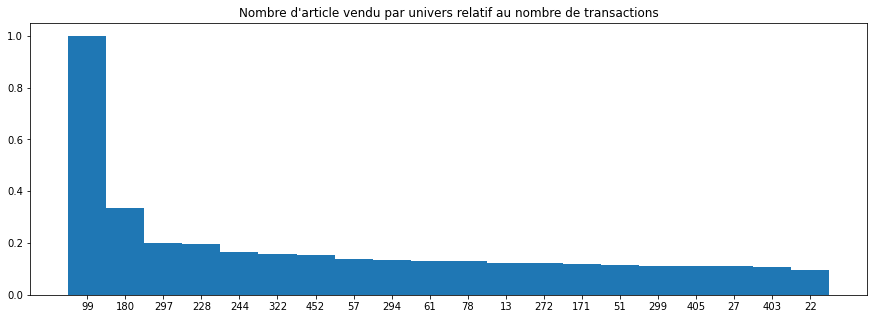

==============100===================
2904
Time Taken to load recurence: ~0secondes


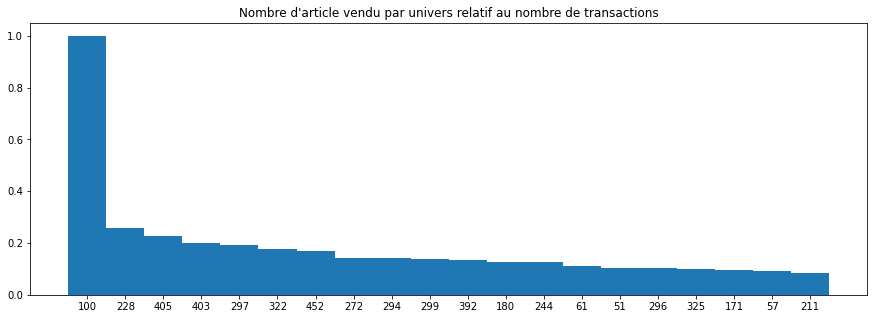

==============101===================
4106
Time Taken to load recurence: ~0secondes


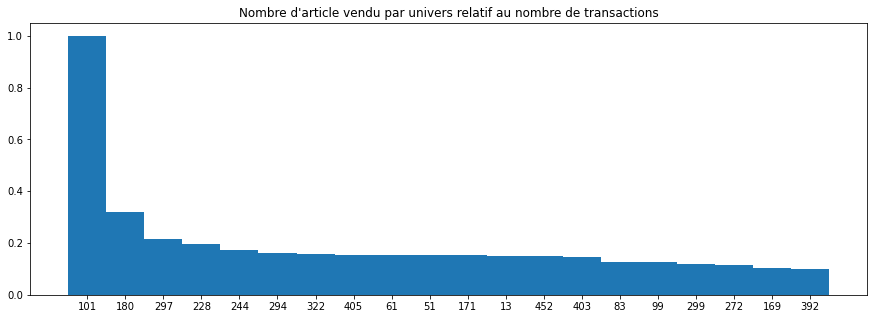

==============102===================
1248
Time Taken to load recurence: ~0secondes


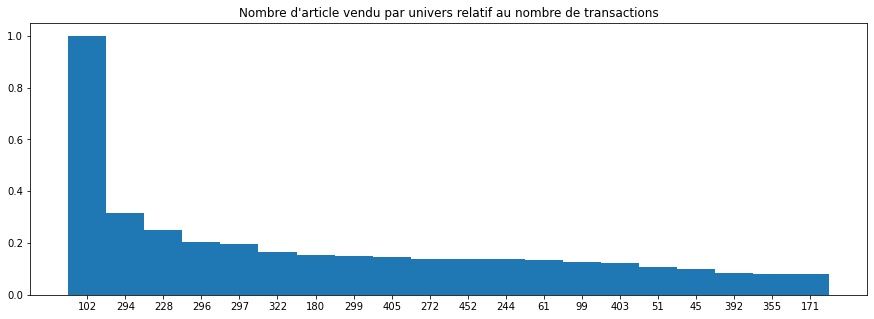

==============103===================
NOT ENOUGH DATA 
==============104===================
NOT ENOUGH DATA 
==============105===================
248
Time Taken to load recurence: ~0secondes


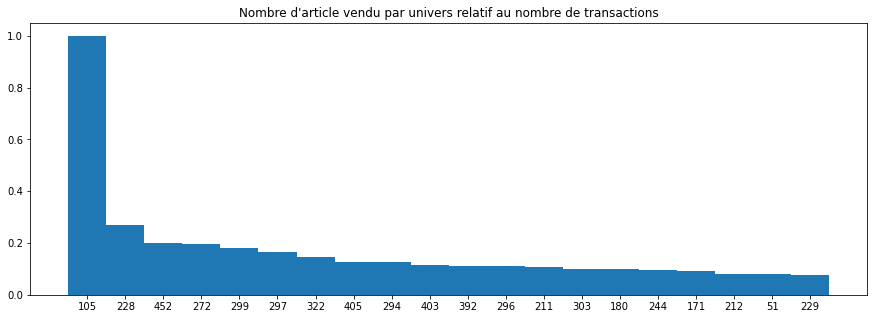

==============106===================
357
Time Taken to load recurence: ~0secondes


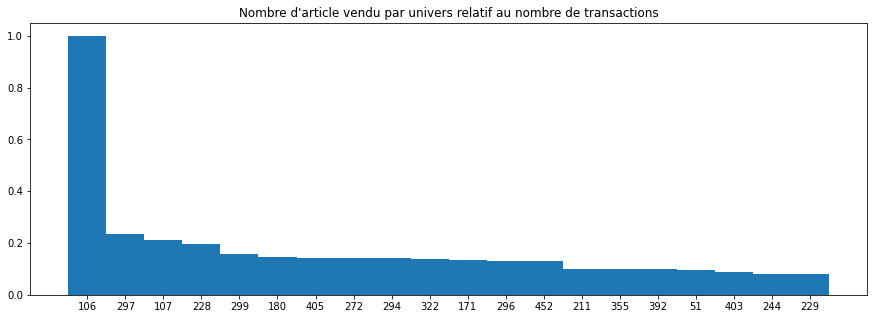

==============107===================
605
Time Taken to load recurence: ~0secondes


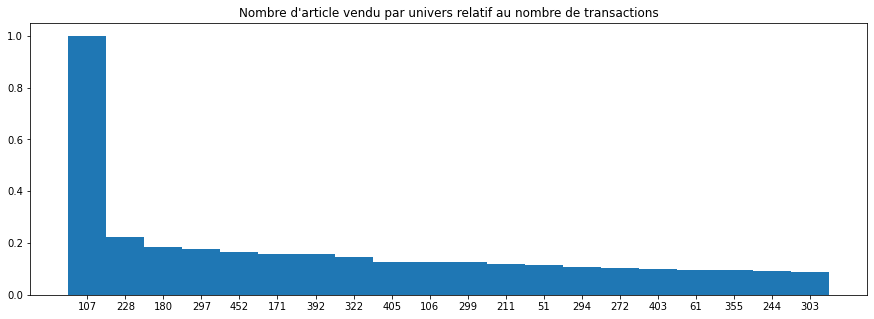

==============108===================
224
Time Taken to load recurence: ~0secondes


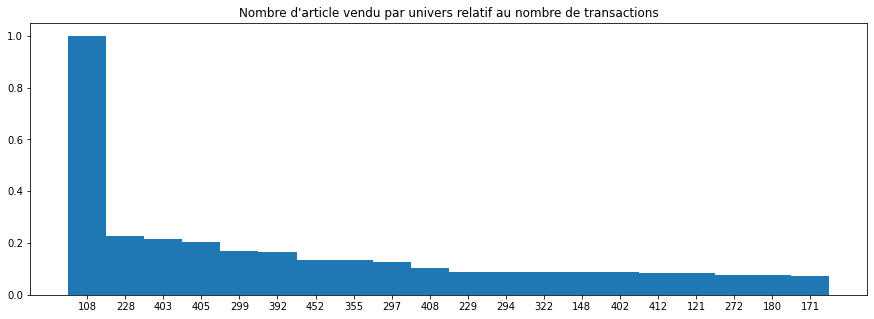

==============109===================
780
Time Taken to load recurence: ~0secondes


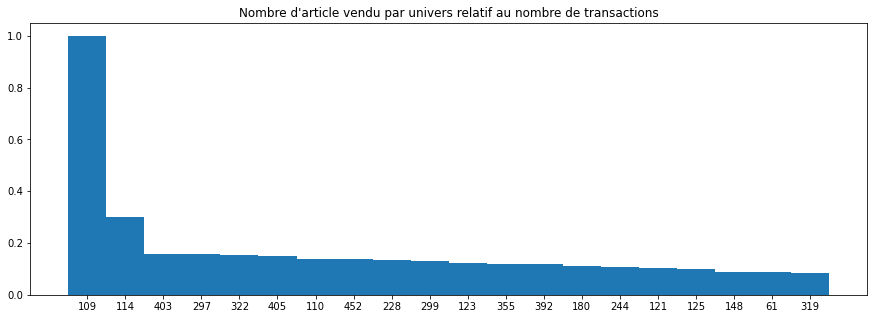

==============110===================
16397
Time Taken to load recurence: ~0secondes


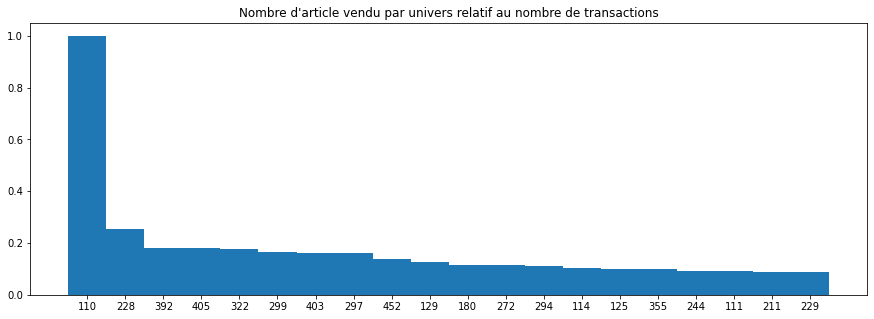

==============111===================
11727
Time Taken to load recurence: ~0secondes


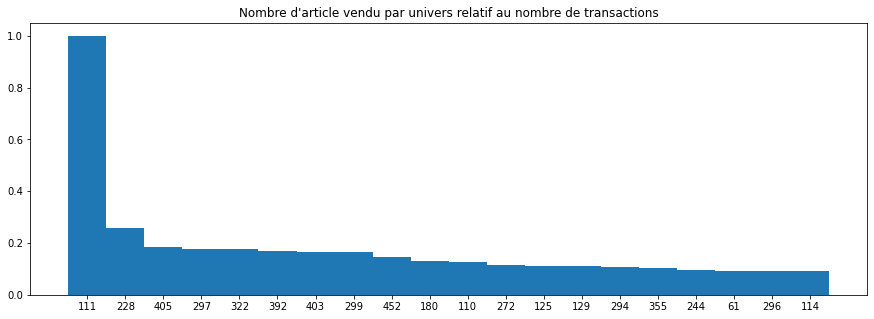

==============112===================
1346
Time Taken to load recurence: ~0secondes


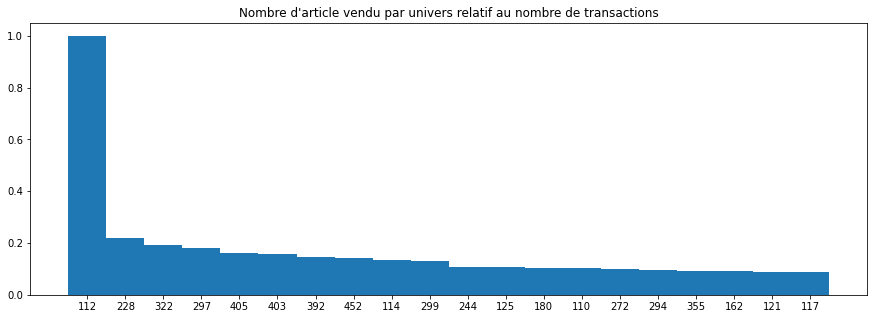

==============113===================
6274
Time Taken to load recurence: ~0secondes


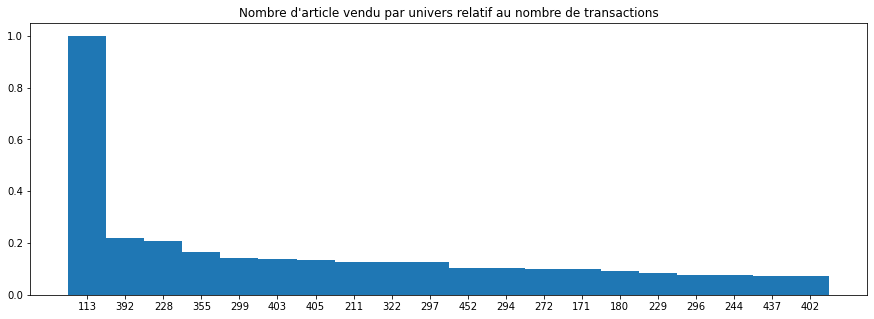

==============114===================
15720
Time Taken to load recurence: ~0secondes


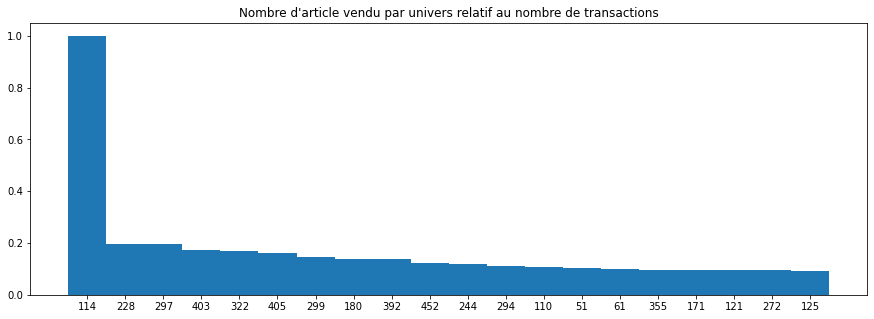

==============115===================
6555
Time Taken to load recurence: ~0secondes


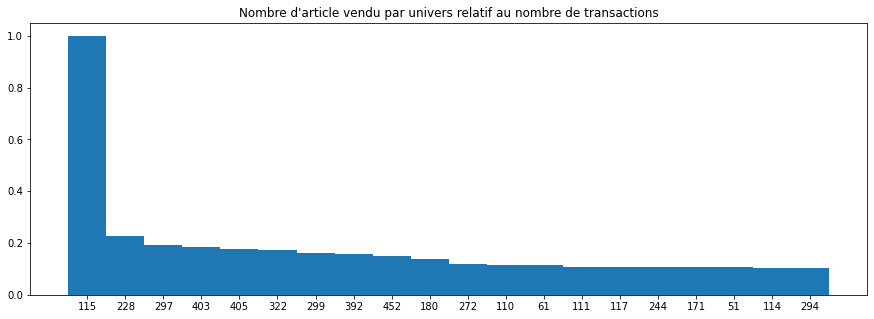

==============116===================
6292
Time Taken to load recurence: ~0secondes


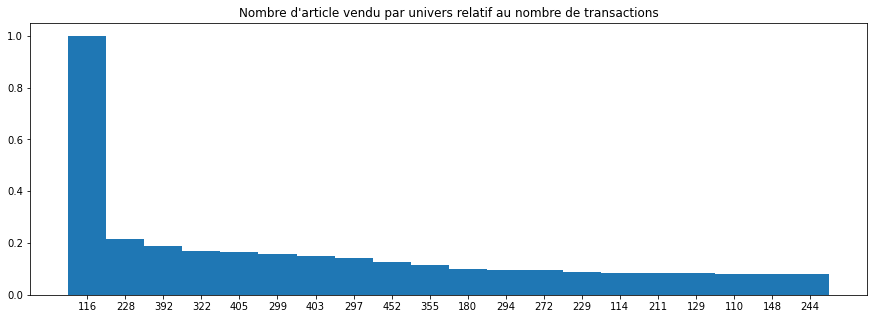

==============117===================
18784
Time Taken to load recurence: ~0secondes


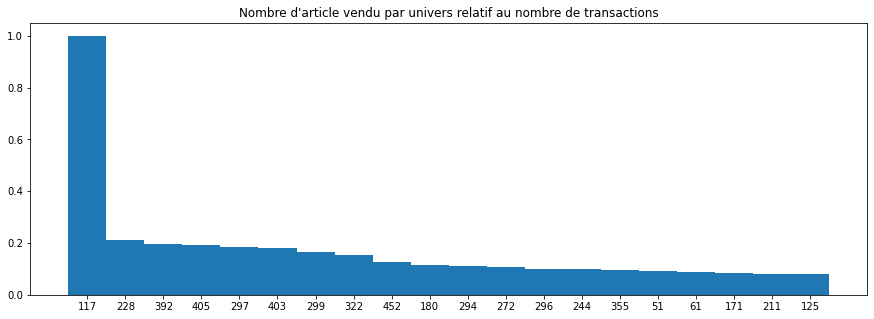

==============118===================
305
Time Taken to load recurence: ~0secondes


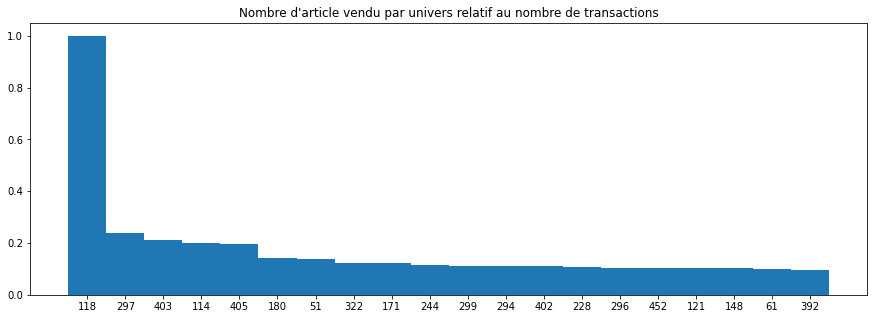

==============119===================
310
Time Taken to load recurence: ~0secondes


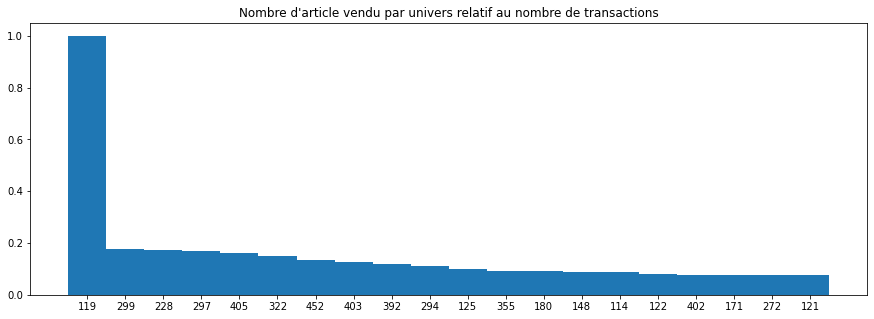

==============120===================
15455
Time Taken to load recurence: ~0secondes


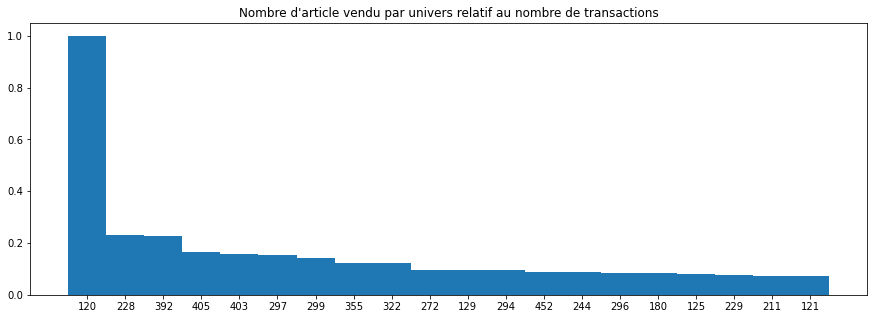

==============121===================
21630
Time Taken to load recurence: ~0secondes


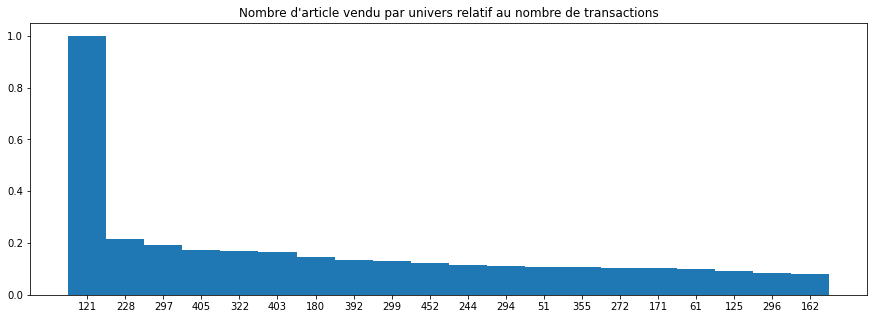

==============122===================
6210
Time Taken to load recurence: ~0secondes


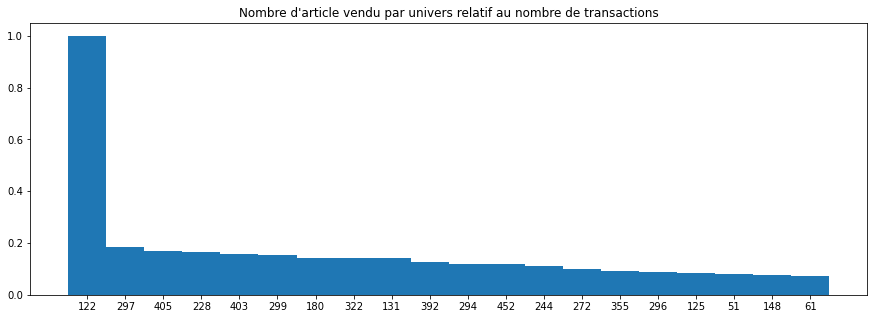

==============123===================
6726
Time Taken to load recurence: ~0secondes


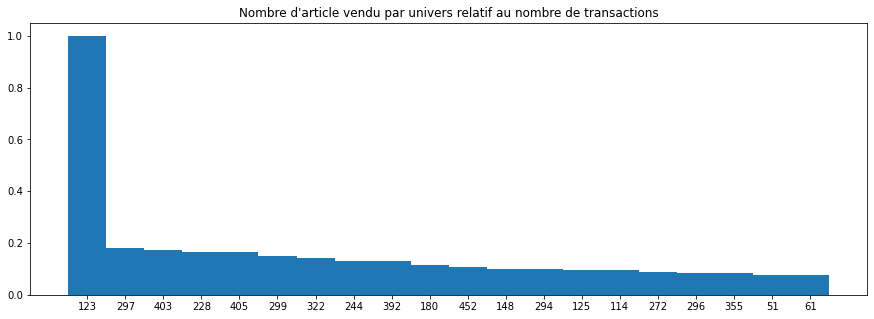

==============124===================
5153
Time Taken to load recurence: ~0secondes


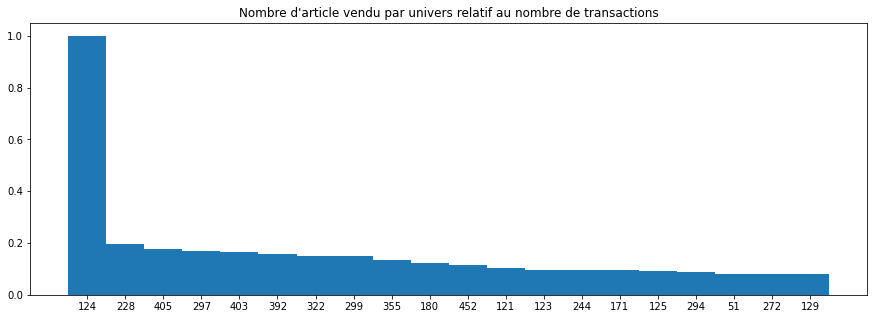

==============125===================
33932
Time Taken to load recurence: ~0secondes


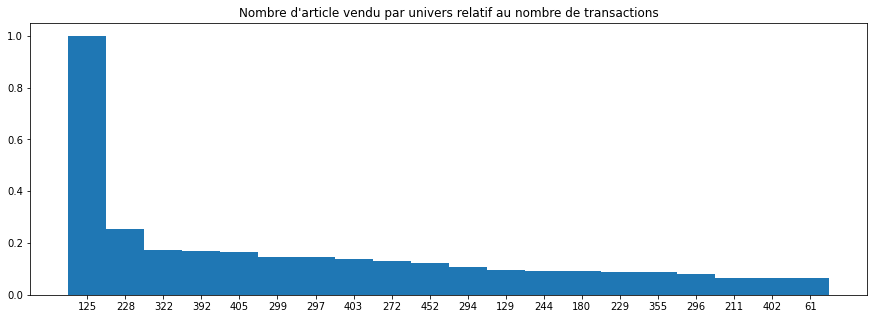

==============126===================
7003
Time Taken to load recurence: ~0secondes


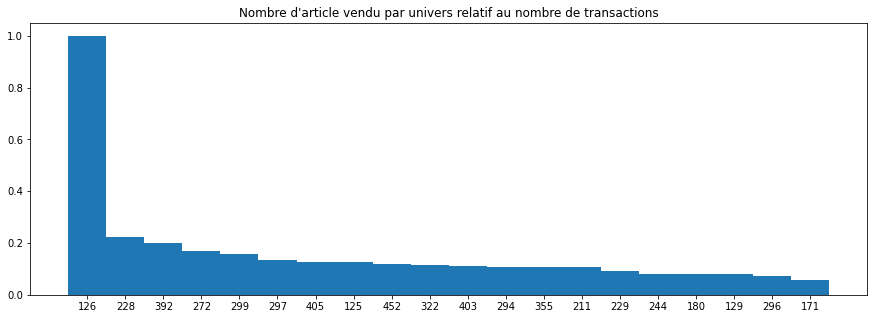

==============127===================
1033
Time Taken to load recurence: ~0secondes


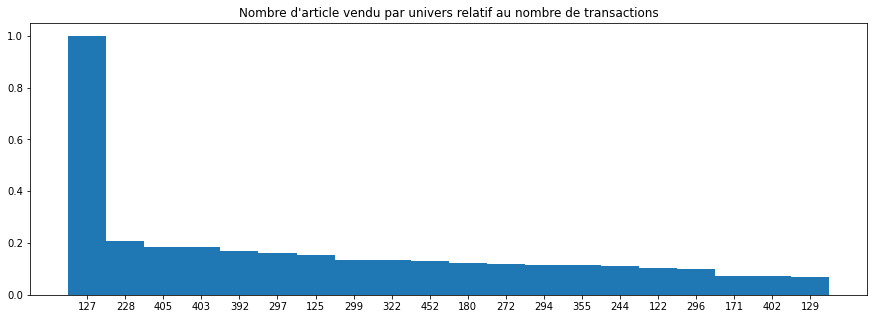

==============128===================
1878
Time Taken to load recurence: ~0secondes


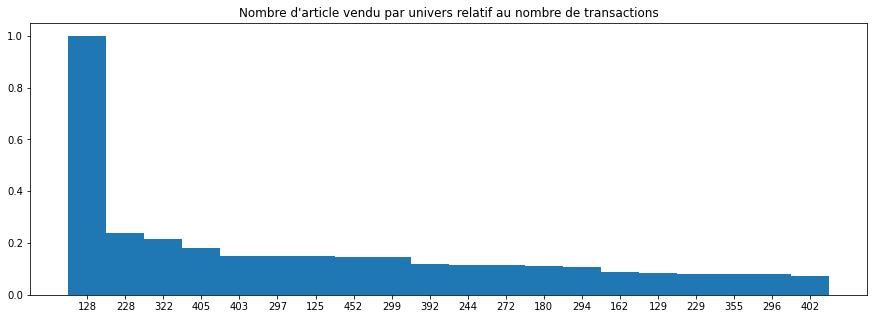

==============129===================
30742
Time Taken to load recurence: ~0secondes


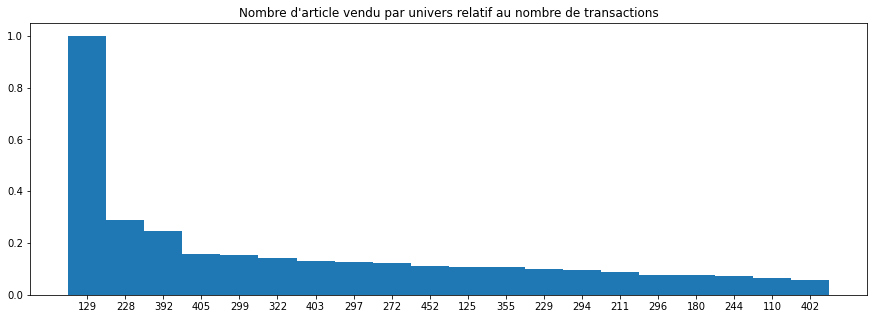

==============130===================
NOT ENOUGH DATA 
==============131===================
5025
Time Taken to load recurence: ~0secondes


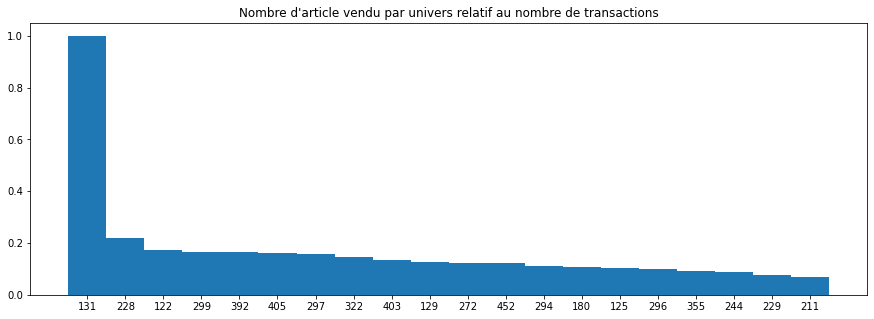

==============132===================
6341
Time Taken to load recurence: ~0secondes


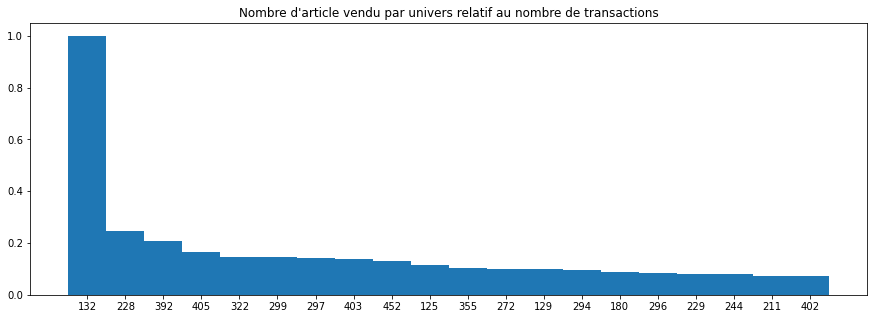

==============133===================
8314
Time Taken to load recurence: ~0secondes


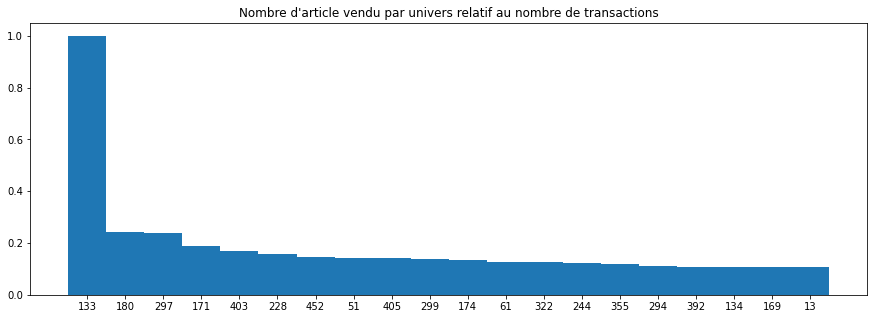

==============134===================
15567
Time Taken to load recurence: ~0secondes


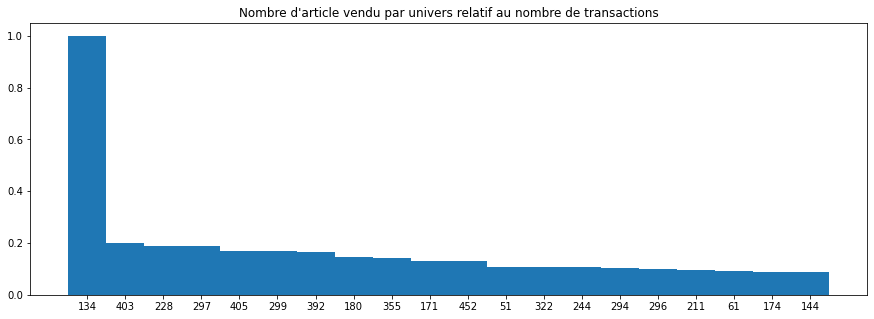

==============135===================
3532
Time Taken to load recurence: ~0secondes


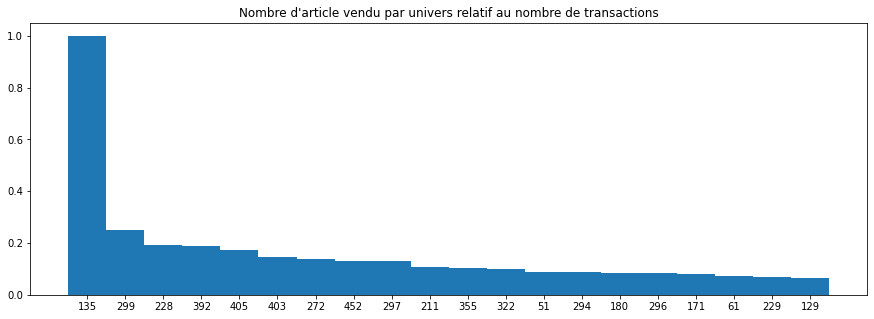

==============136===================
10799
Time Taken to load recurence: ~0secondes


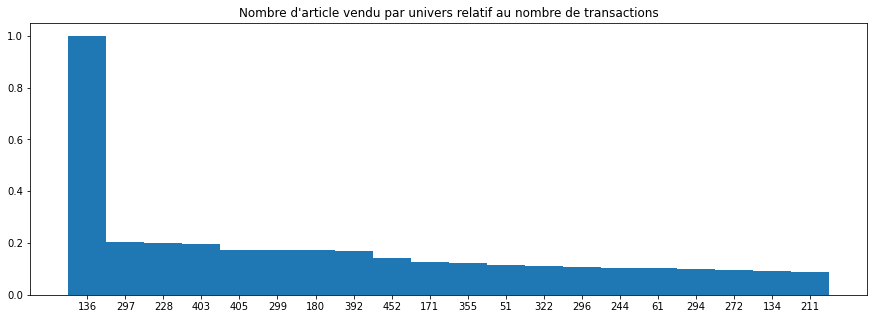

==============137===================
NOT ENOUGH DATA 
==============138===================
7942
Time Taken to load recurence: ~0secondes


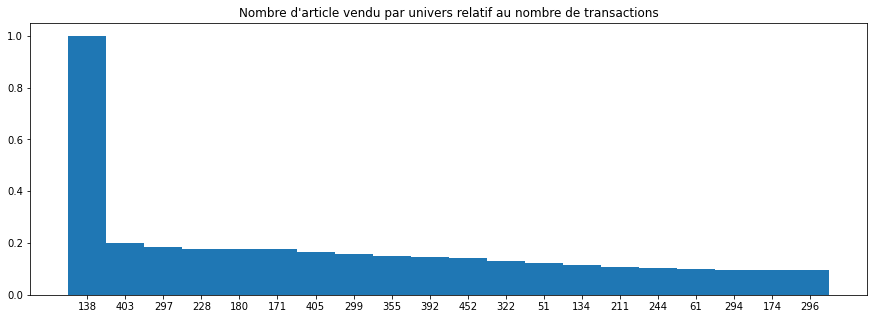

==============139===================
NOT ENOUGH DATA 
==============140===================
NOT ENOUGH DATA 
==============141===================
5687
Time Taken to load recurence: ~0secondes


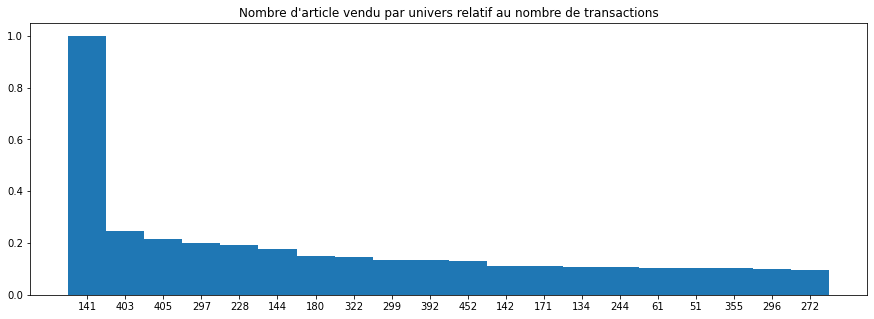

==============142===================
13022
Time Taken to load recurence: ~0secondes


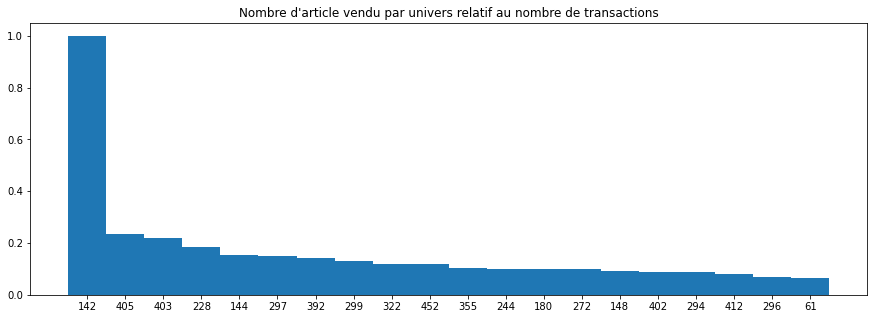

==============143===================
438
Time Taken to load recurence: ~0secondes


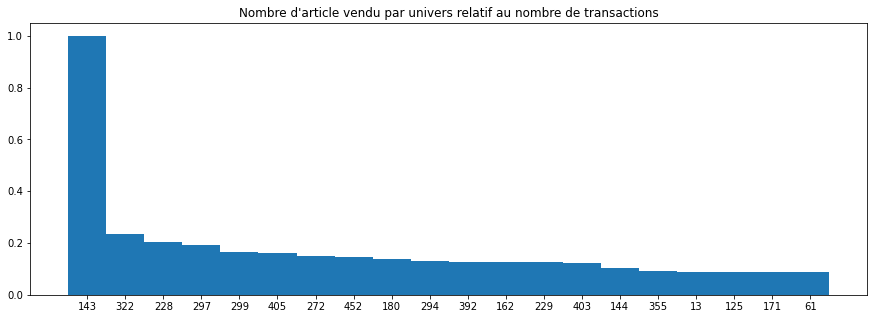

==============144===================
22115
Time Taken to load recurence: ~0secondes


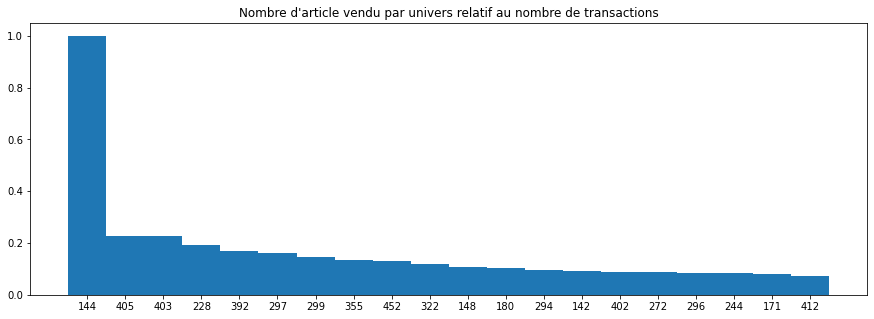

==============145===================
1658
Time Taken to load recurence: ~0secondes


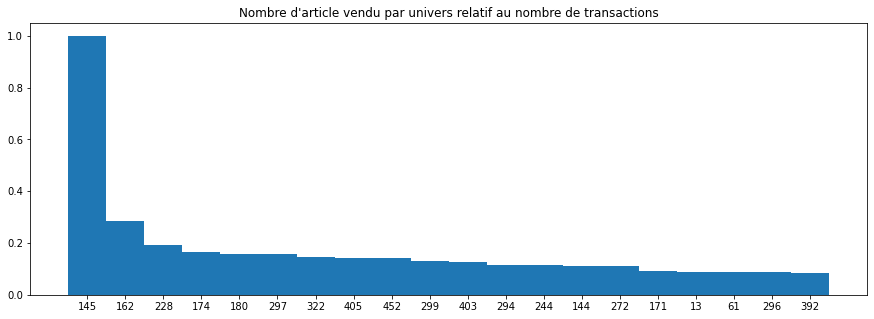

==============146===================
NOT ENOUGH DATA 
==============147===================
18854
Time Taken to load recurence: ~0secondes


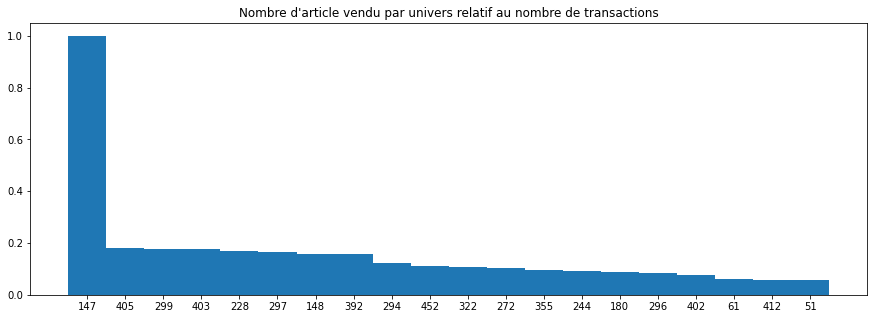

==============148===================
39504
Time Taken to load recurence: ~0secondes


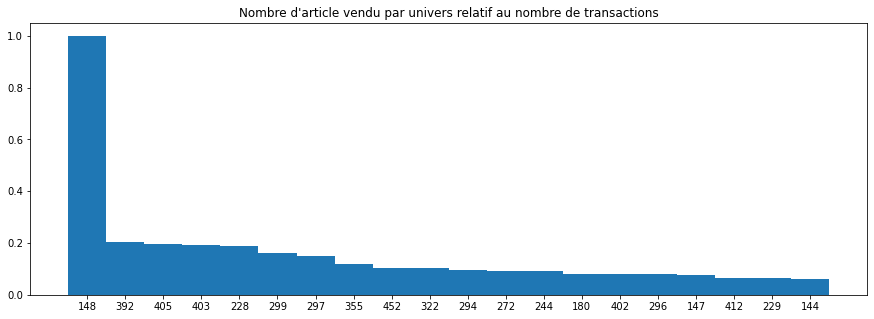

==============149===================
5787
Time Taken to load recurence: ~0secondes


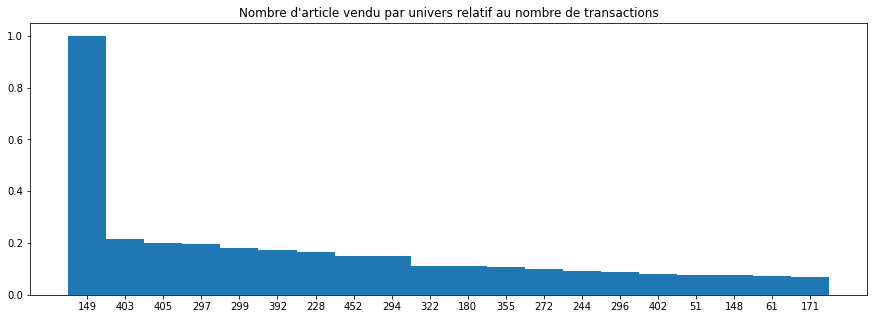

==============150===================
6488
Time Taken to load recurence: ~0secondes


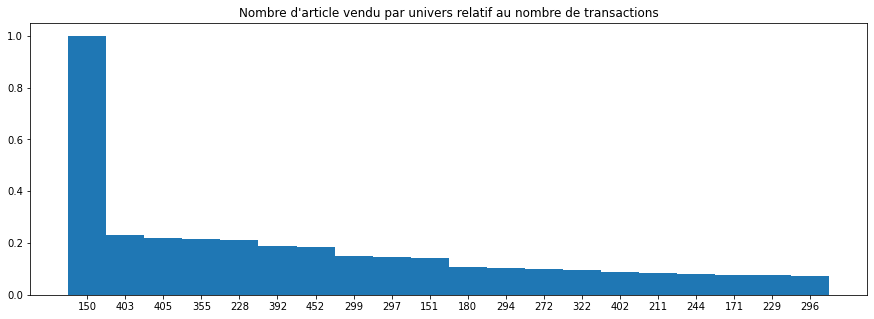

==============151===================
25447
Time Taken to load recurence: ~0secondes


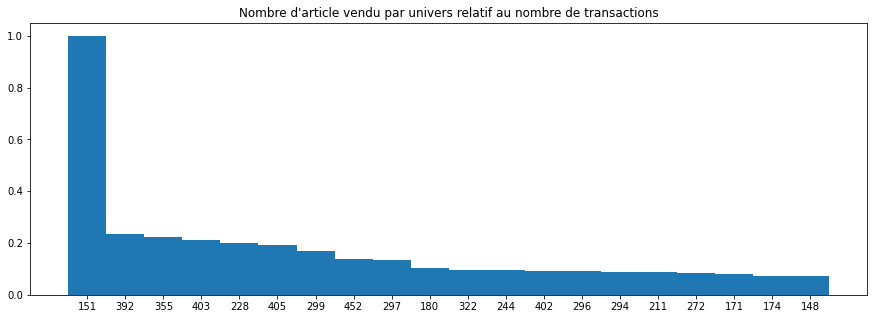

==============152===================
211
Time Taken to load recurence: ~0secondes


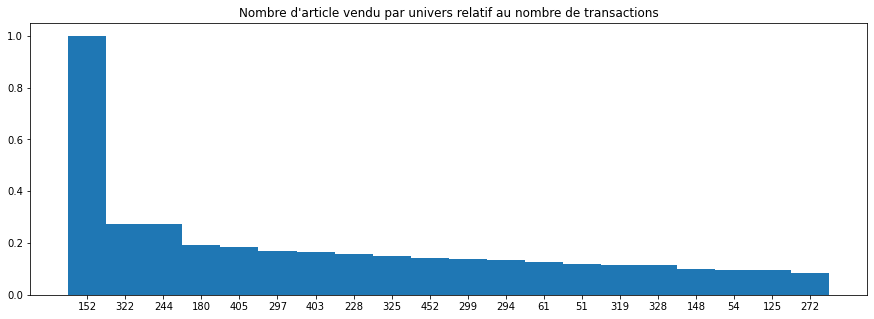

==============153===================
1430
Time Taken to load recurence: ~0secondes


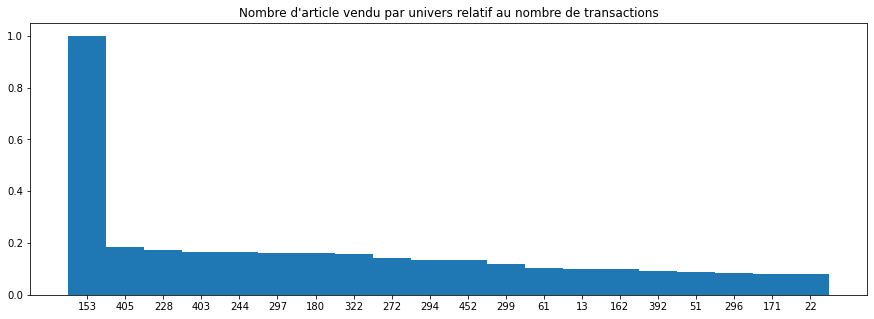

==============154===================
11801
Time Taken to load recurence: ~0secondes


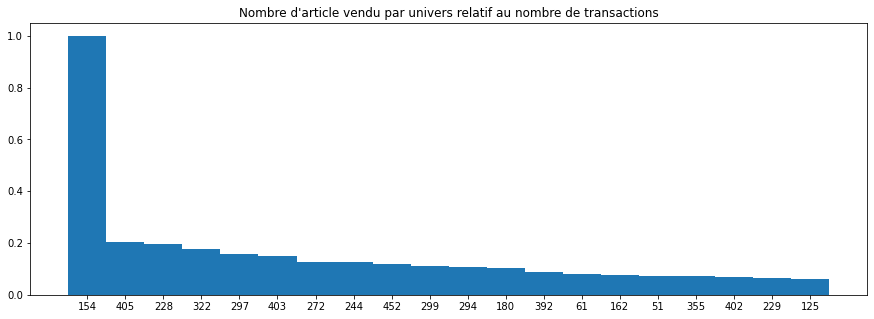

==============155===================
1531
Time Taken to load recurence: ~0secondes


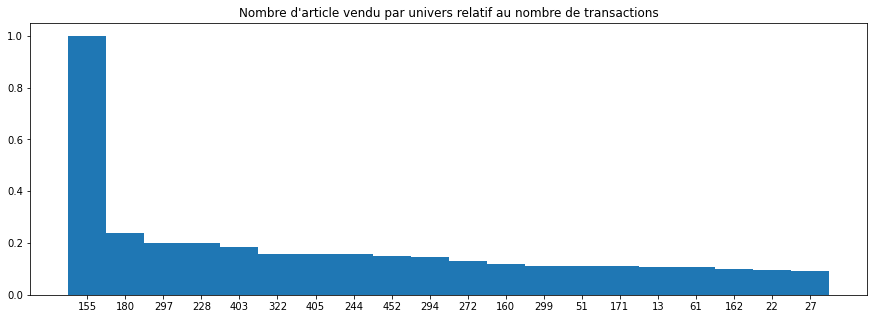

==============156===================
2508
Time Taken to load recurence: ~0secondes


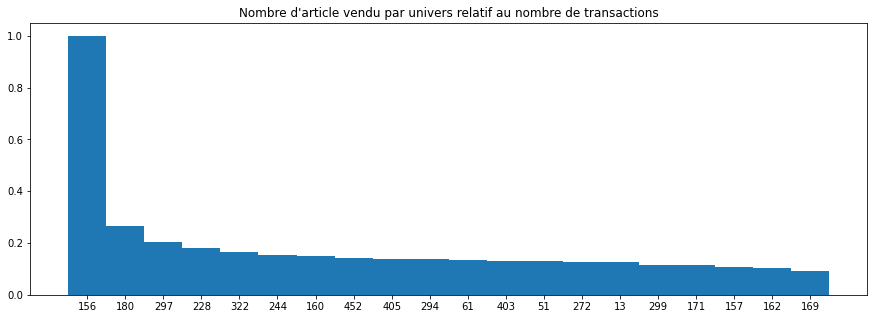

==============157===================
9853
Time Taken to load recurence: ~0secondes


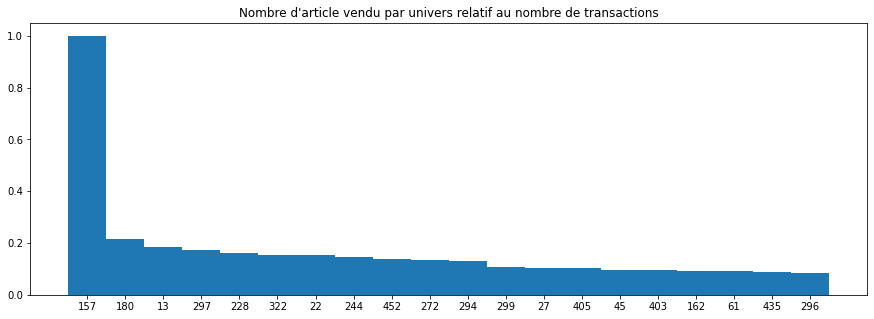

==============158===================
258
Time Taken to load recurence: ~0secondes


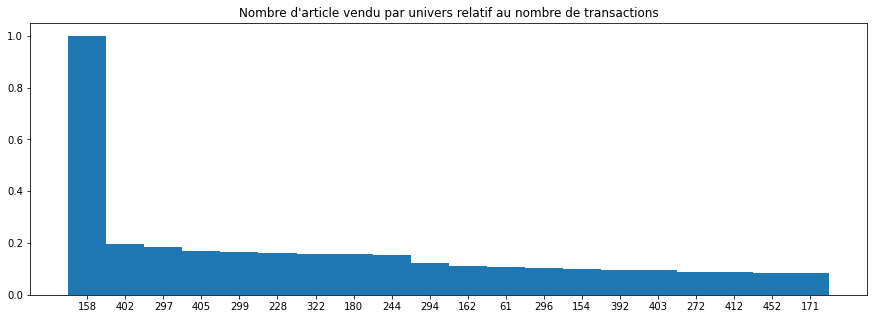

==============159===================
857
Time Taken to load recurence: ~0secondes


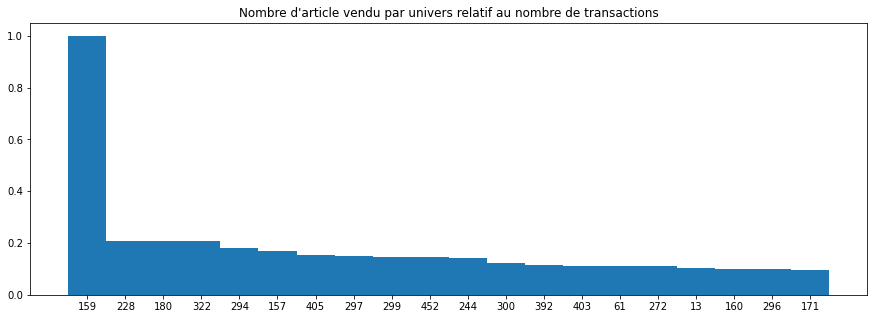

==============160===================
5538
Time Taken to load recurence: ~0secondes


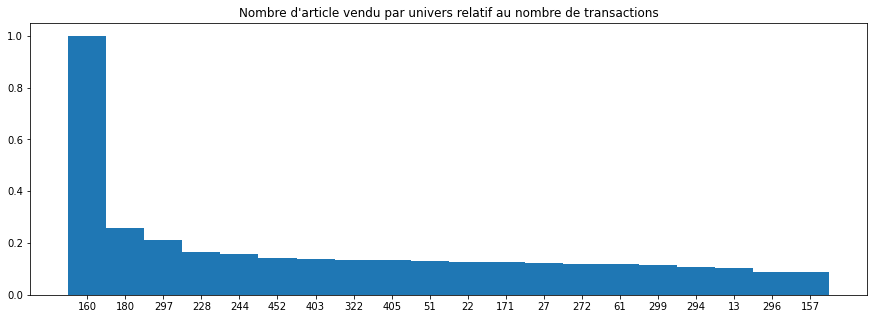

==============161===================
NOT ENOUGH DATA 
==============162===================
30976
Time Taken to load recurence: ~0secondes


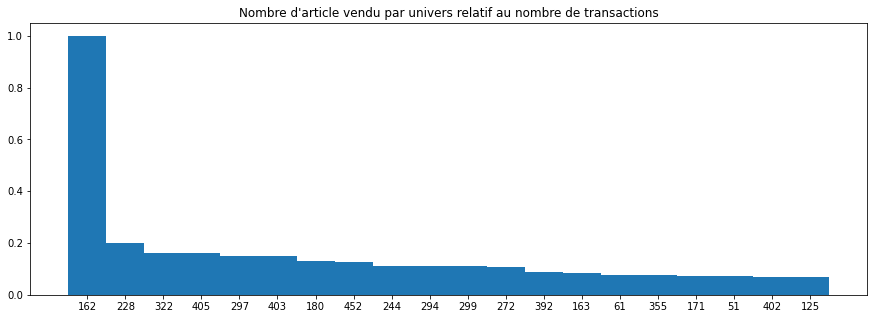

==============163===================
11950
Time Taken to load recurence: ~0secondes


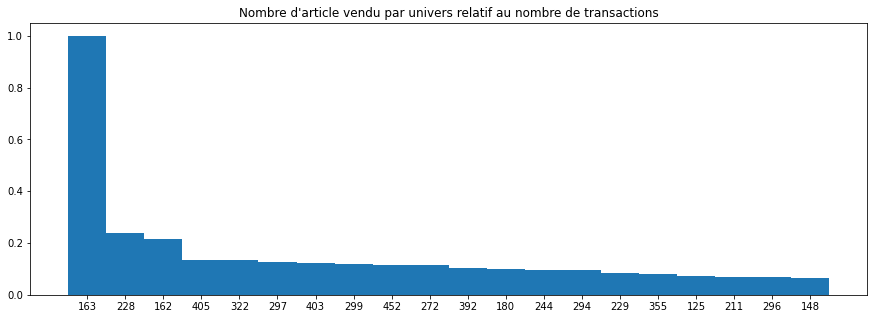

==============164===================
56
Time Taken to load recurence: ~0secondes


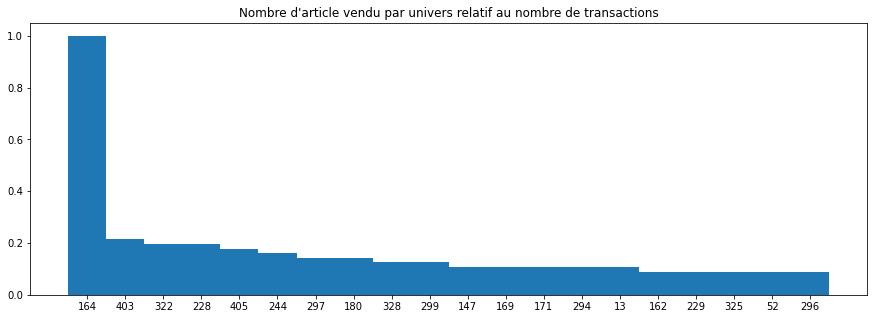

==============165===================
NOT ENOUGH DATA 
==============166===================
NOT ENOUGH DATA 
==============167===================
NOT ENOUGH DATA 
==============168===================
5672
Time Taken to load recurence: ~0secondes


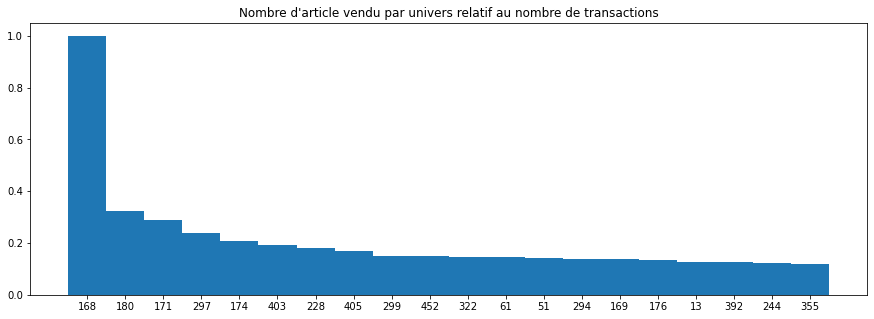

==============169===================
19004
Time Taken to load recurence: ~0secondes


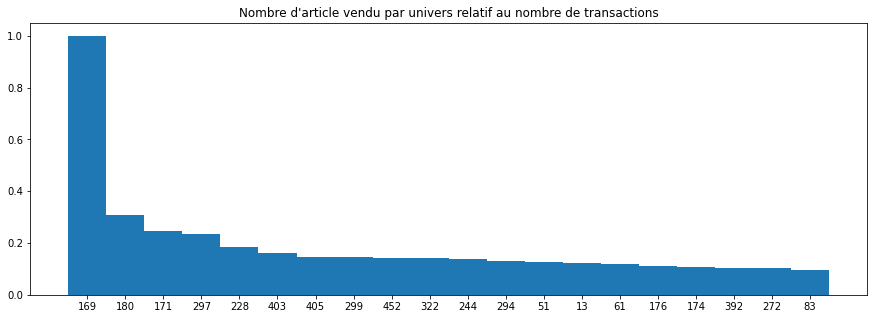

==============170===================
3609
Time Taken to load recurence: ~0secondes


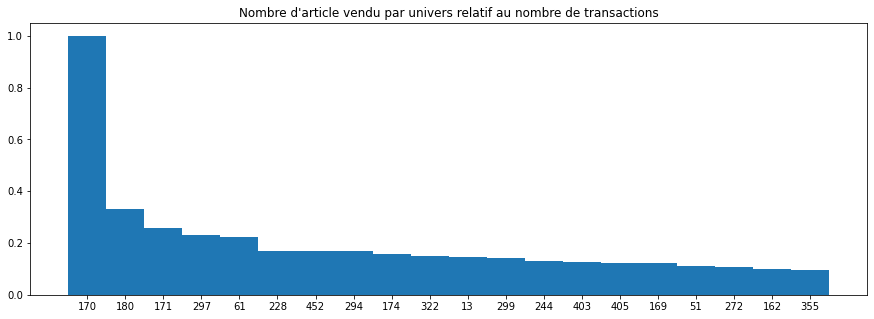

==============171===================
35991
Time Taken to load recurence: ~0secondes


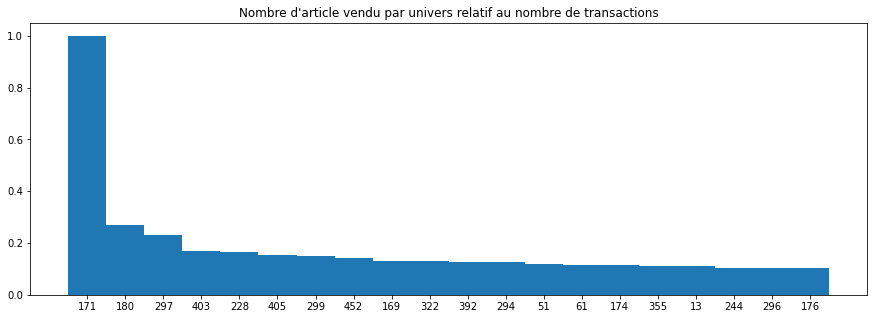

==============172===================
590
Time Taken to load recurence: ~0secondes


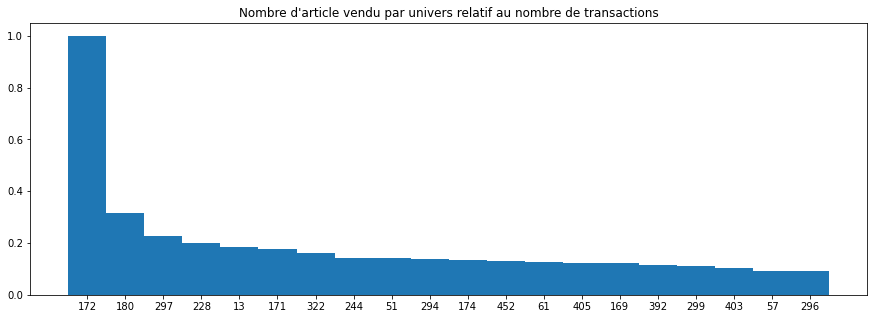

==============173===================
5147
Time Taken to load recurence: ~0secondes


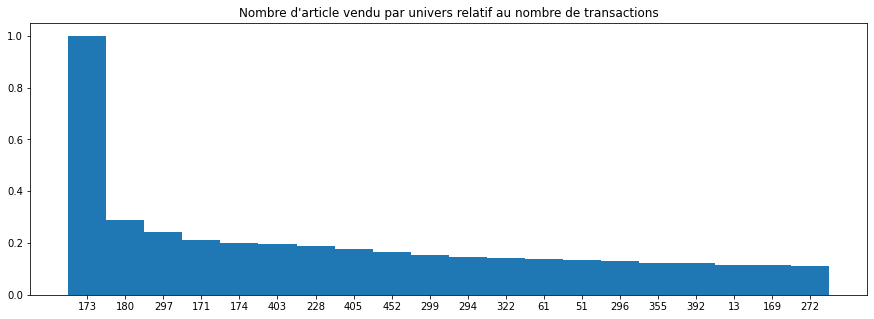

==============174===================
21863
Time Taken to load recurence: ~0secondes


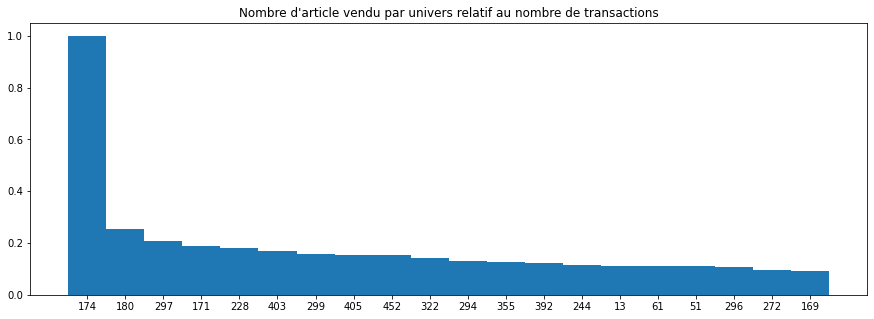

==============175===================
427
Time Taken to load recurence: ~0secondes


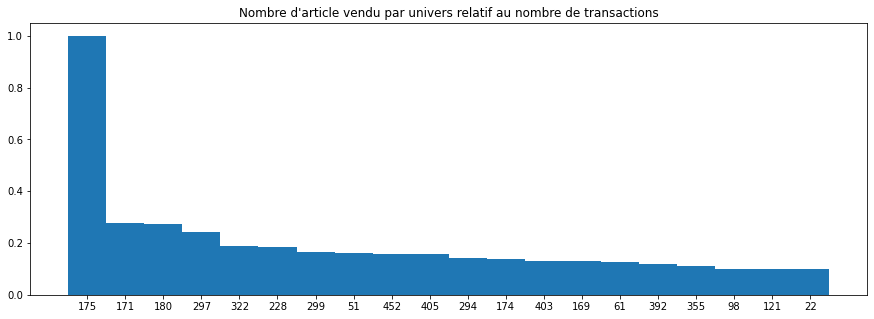

==============176===================
13869
Time Taken to load recurence: ~0secondes


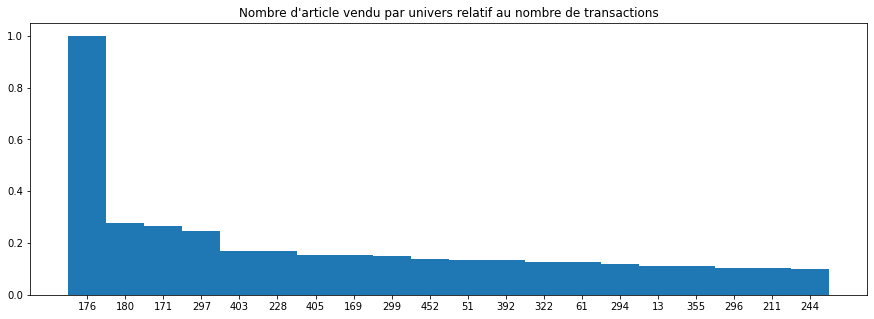

==============177===================
6674
Time Taken to load recurence: ~0secondes


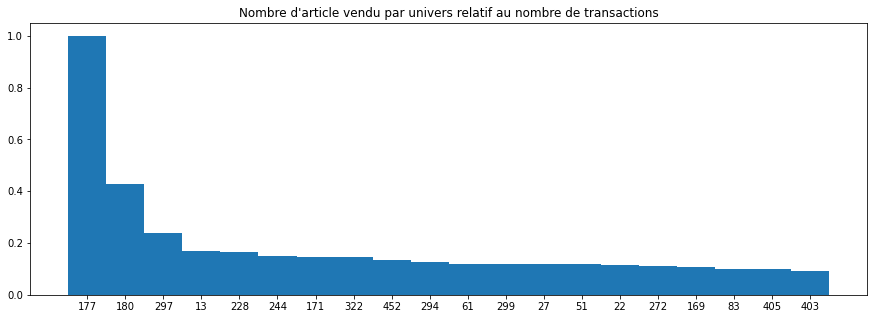

==============178===================
2354
Time Taken to load recurence: ~0secondes


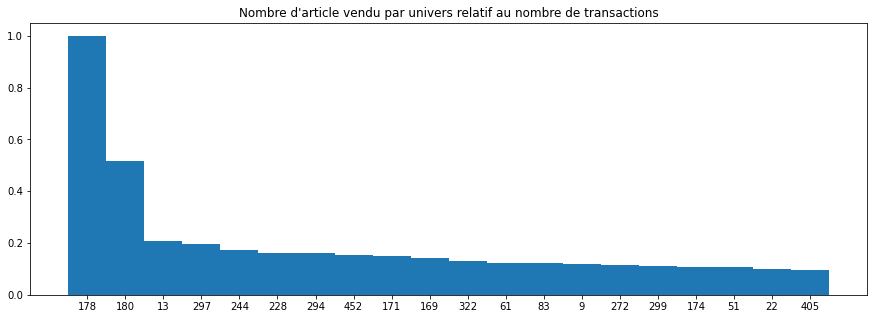

==============179===================
NOT ENOUGH DATA 
==============180===================
61851
Time Taken to load recurence: ~1secondes


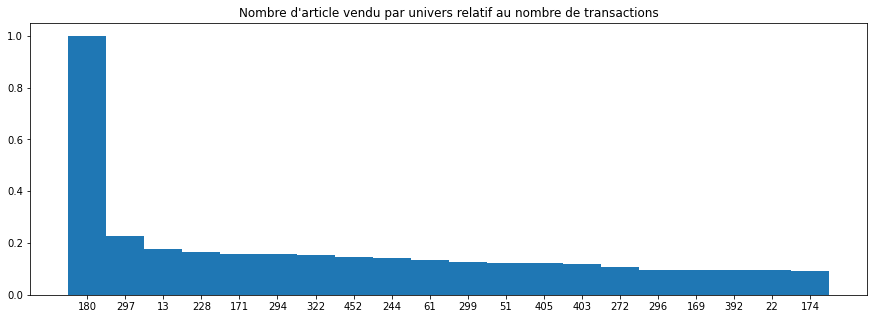

==============181===================
NOT ENOUGH DATA 
==============182===================
NOT ENOUGH DATA 
==============183===================
NOT ENOUGH DATA 
==============184===================
NOT ENOUGH DATA 
==============185===================
NOT ENOUGH DATA 
==============186===================
NOT ENOUGH DATA 
==============187===================
NOT ENOUGH DATA 
==============188===================
37838
Time Taken to load recurence: ~0secondes


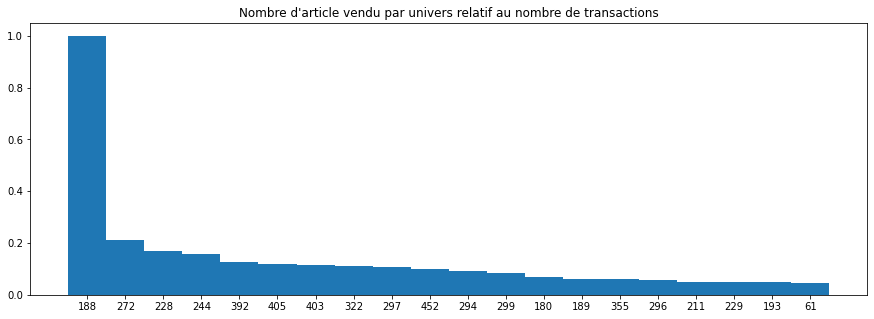

==============189===================
23277
Time Taken to load recurence: ~0secondes


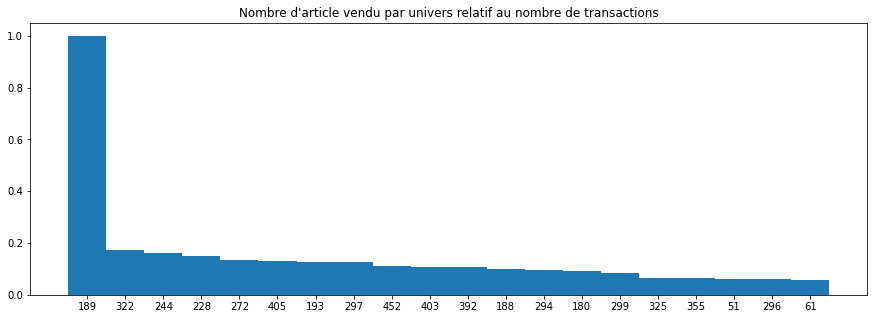

==============190===================
3149
Time Taken to load recurence: ~0secondes


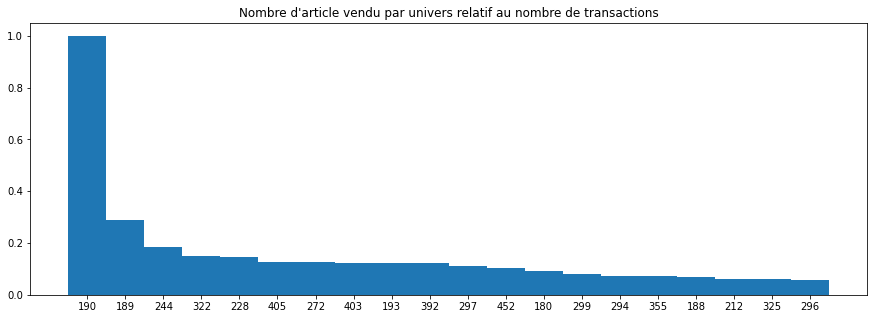

==============191===================
274
Time Taken to load recurence: ~0secondes


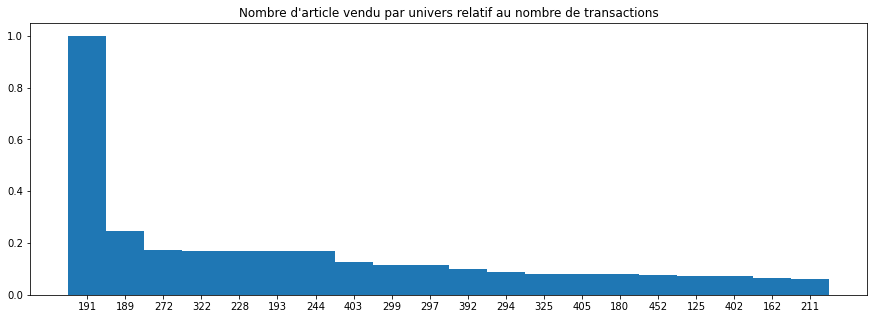

==============192===================
2240
Time Taken to load recurence: ~0secondes


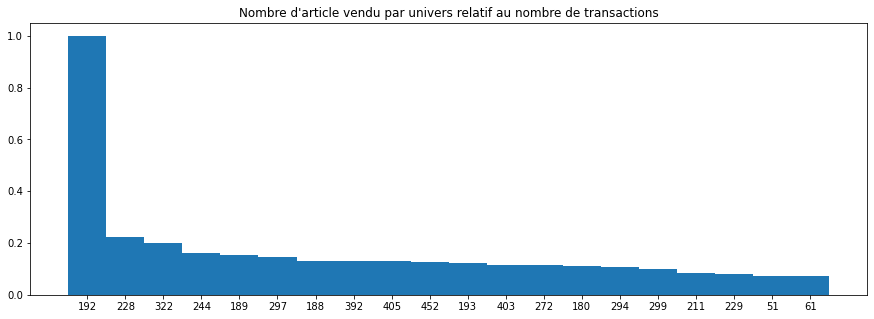

==============193===================
16410
Time Taken to load recurence: ~0secondes


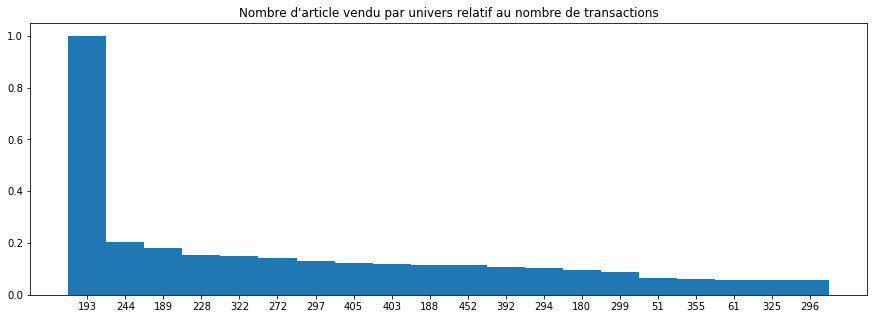

==============194===================
1191
Time Taken to load recurence: ~0secondes


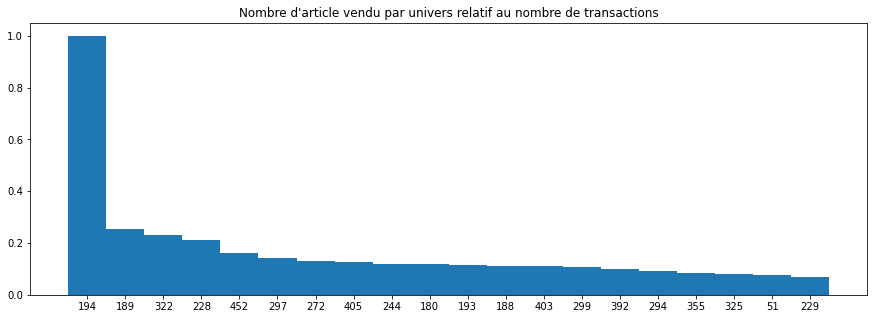

==============195===================
368
Time Taken to load recurence: ~0secondes


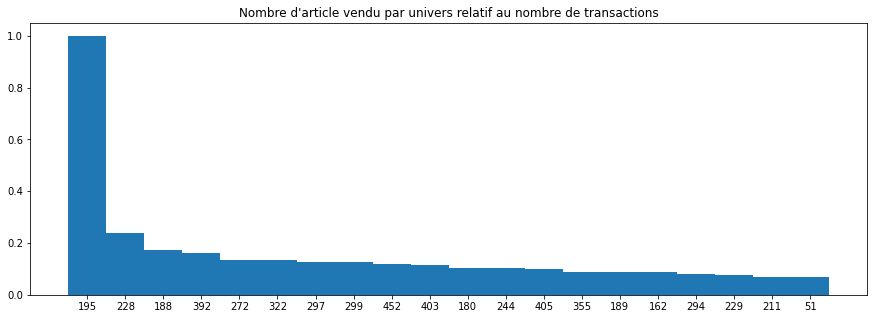

==============196===================
800
Time Taken to load recurence: ~0secondes


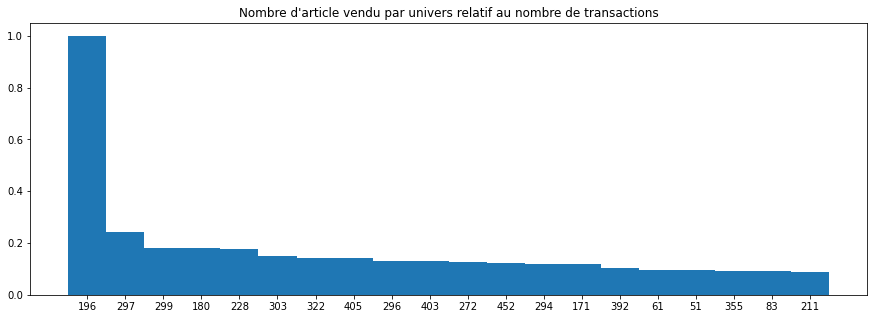

==============197===================
209
Time Taken to load recurence: ~0secondes


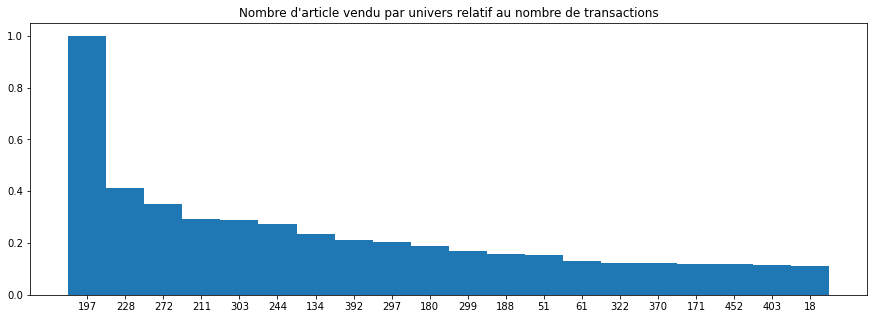

==============198===================
20446
Time Taken to load recurence: ~0secondes


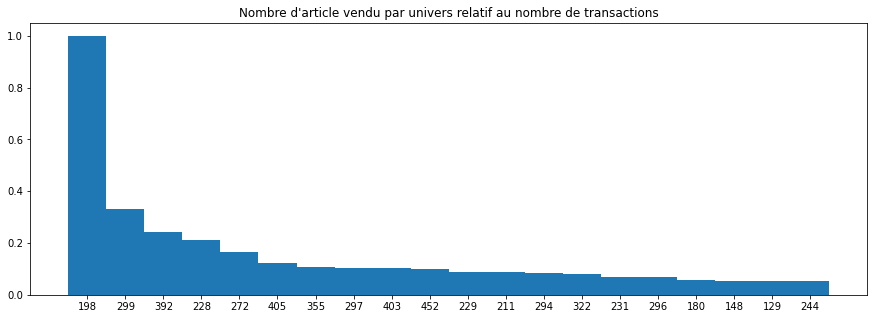

==============199===================
1102
Time Taken to load recurence: ~0secondes


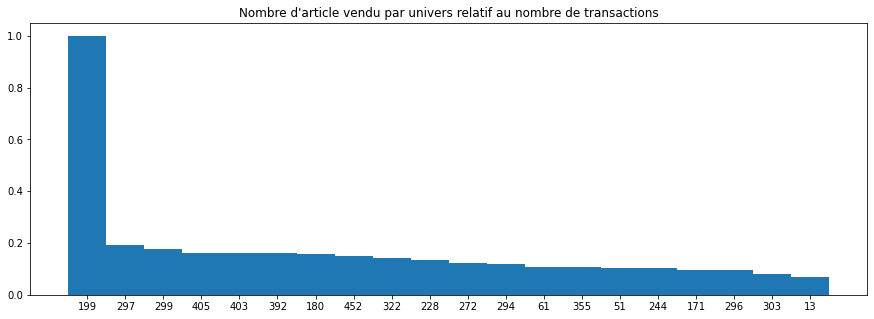

==============200===================
3582
Time Taken to load recurence: ~0secondes


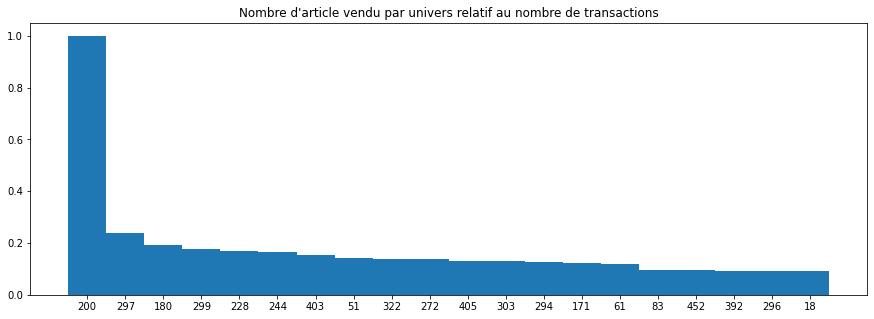

==============201===================
4862
Time Taken to load recurence: ~0secondes


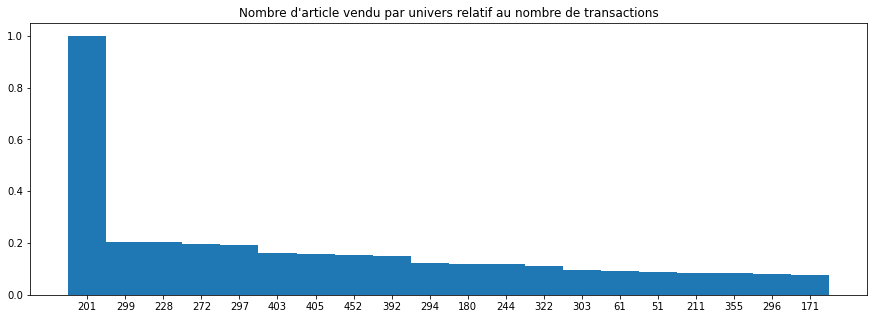

==============202===================
NOT ENOUGH DATA 
==============203===================
1198
Time Taken to load recurence: ~0secondes


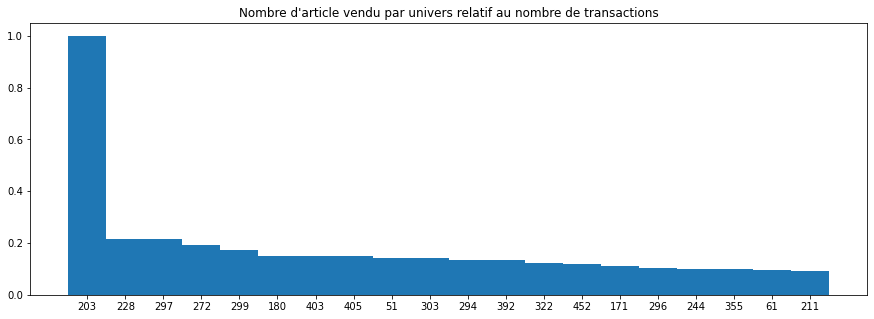

==============204===================
349
Time Taken to load recurence: ~0secondes


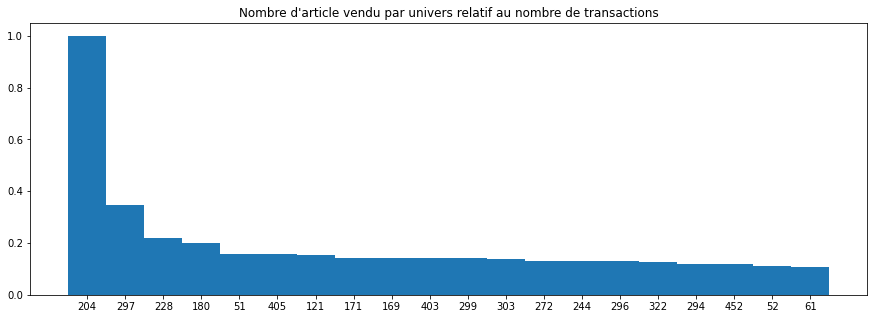

==============205===================
NOT ENOUGH DATA 
==============206===================
629
Time Taken to load recurence: ~0secondes


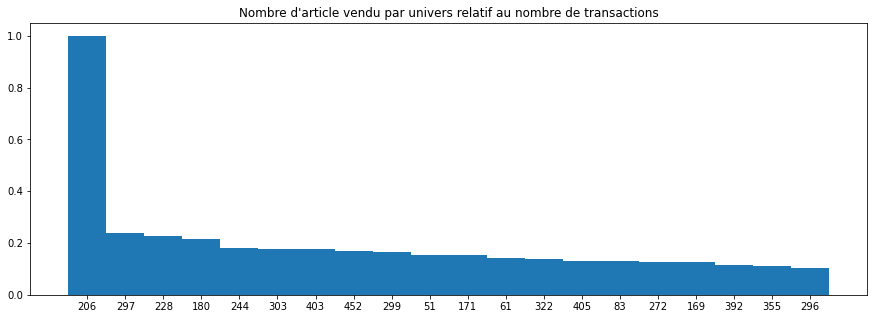

==============207===================
3154
Time Taken to load recurence: ~0secondes


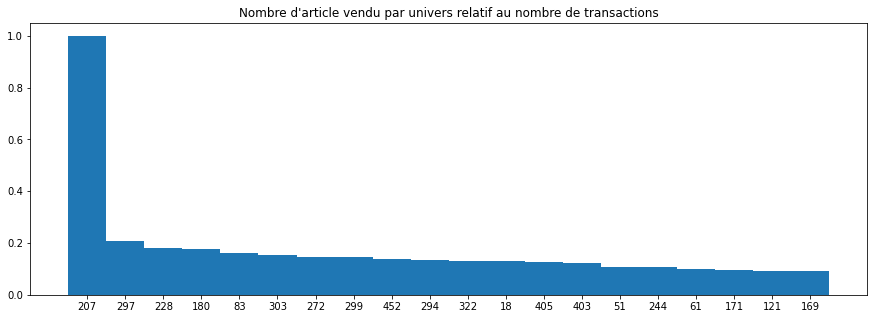

==============208===================
5696
Time Taken to load recurence: ~0secondes


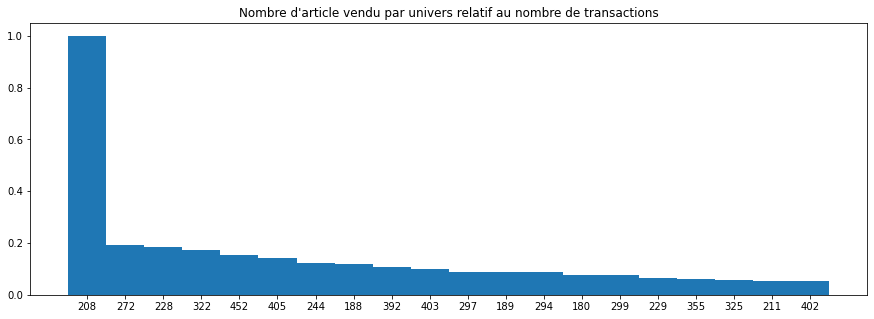

==============209===================
1499
Time Taken to load recurence: ~0secondes


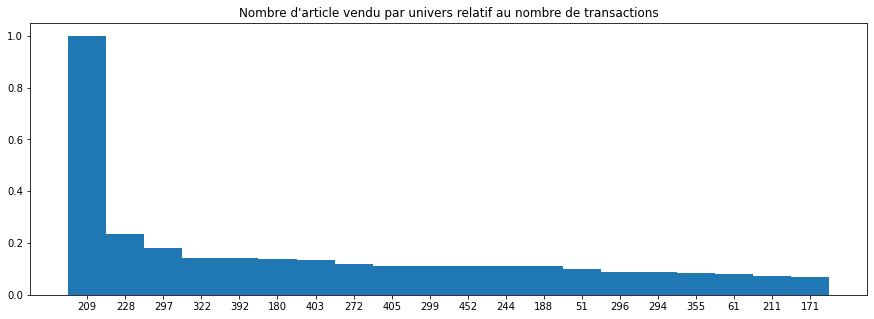

==============210===================
6433
Time Taken to load recurence: ~0secondes


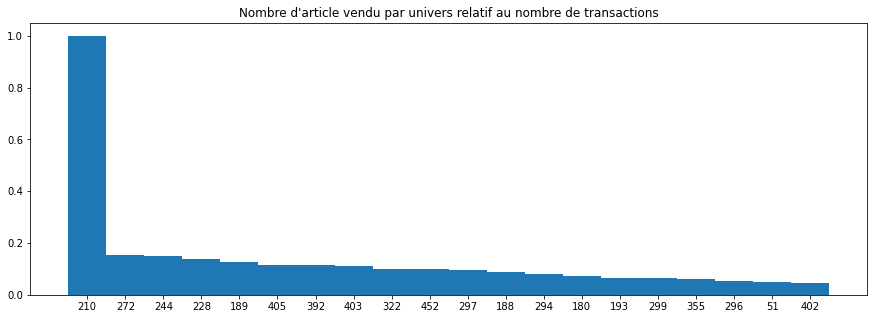

==============211===================
48711
Time Taken to load recurence: ~0secondes


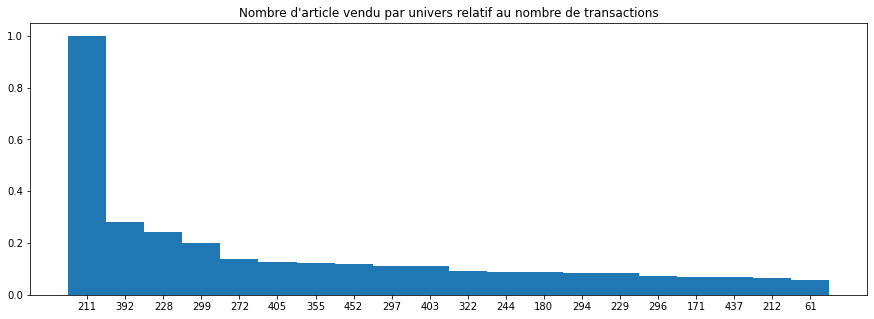

==============212===================
24528
Time Taken to load recurence: ~0secondes


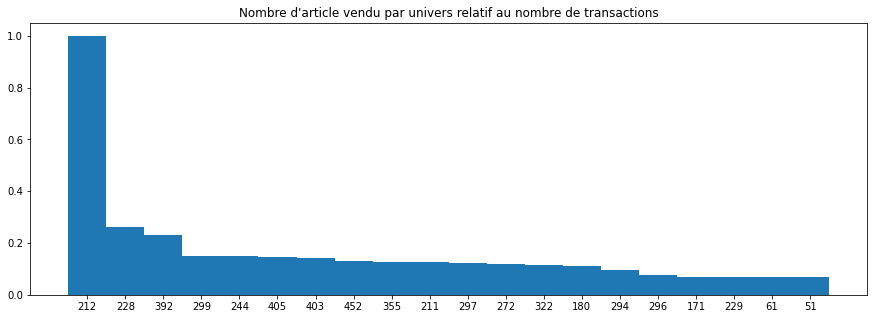

==============213===================
15772
Time Taken to load recurence: ~0secondes


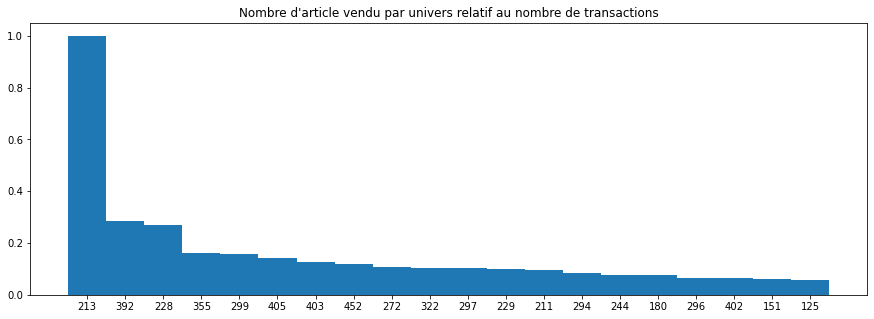

==============214===================
NOT ENOUGH DATA 
==============215===================
10426
Time Taken to load recurence: ~0secondes


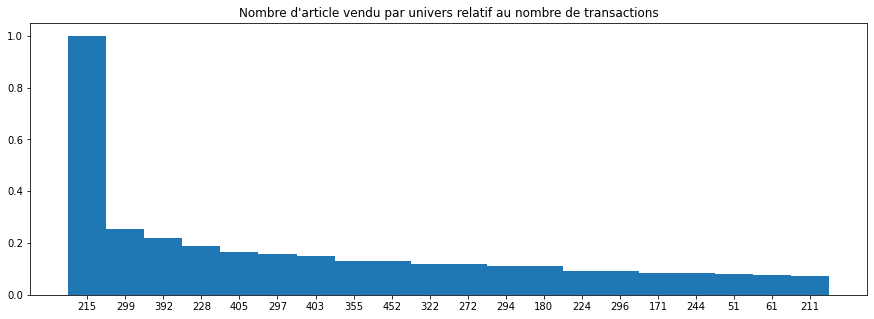

==============216===================
NOT ENOUGH DATA 
==============217===================
NOT ENOUGH DATA 
==============218===================
NOT ENOUGH DATA 
==============219===================
9412
Time Taken to load recurence: ~0secondes


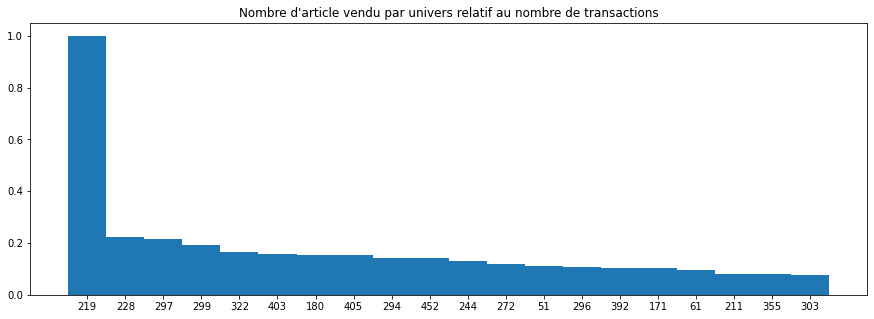

==============220===================
9001
Time Taken to load recurence: ~0secondes


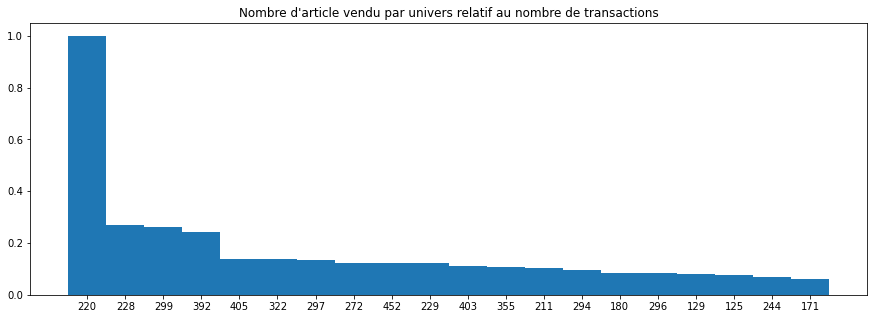

==============221===================
NOT ENOUGH DATA 
==============222===================
1891
Time Taken to load recurence: ~0secondes


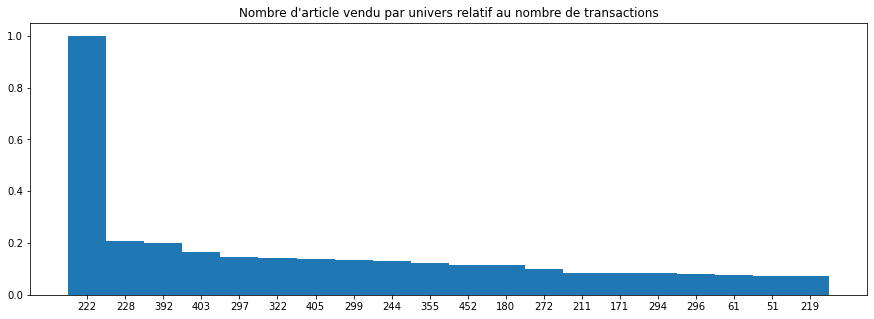

==============223===================
1595
Time Taken to load recurence: ~0secondes


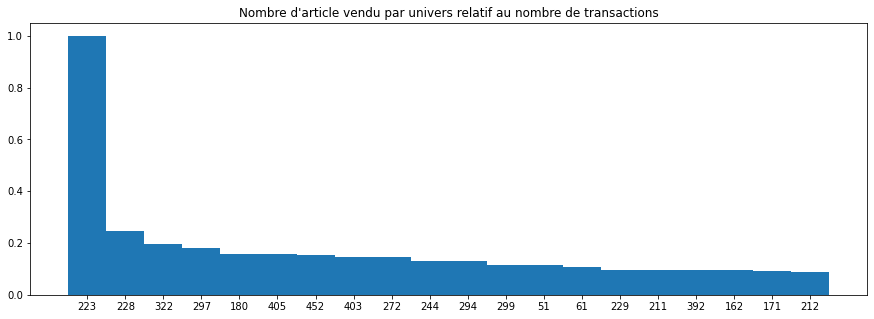

==============224===================
18243
Time Taken to load recurence: ~0secondes


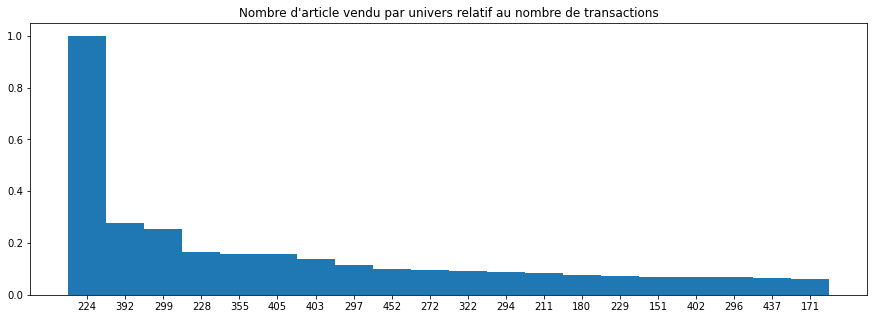

==============225===================
NOT ENOUGH DATA 
==============226===================
NOT ENOUGH DATA 
==============227===================
NOT ENOUGH DATA 
==============228===================
146217
Time Taken to load recurence: ~1secondes


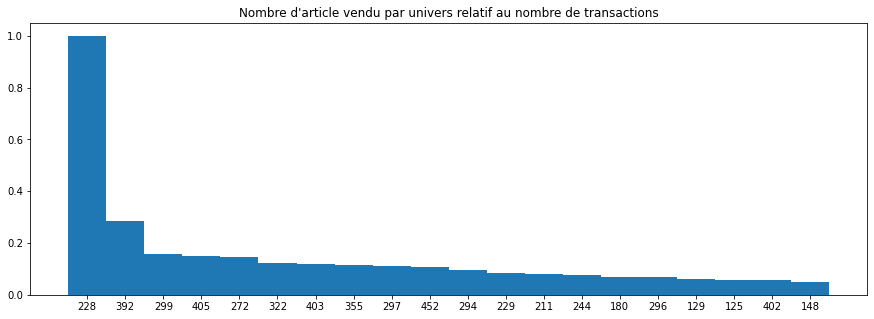

==============229===================
46810
Time Taken to load recurence: ~0secondes


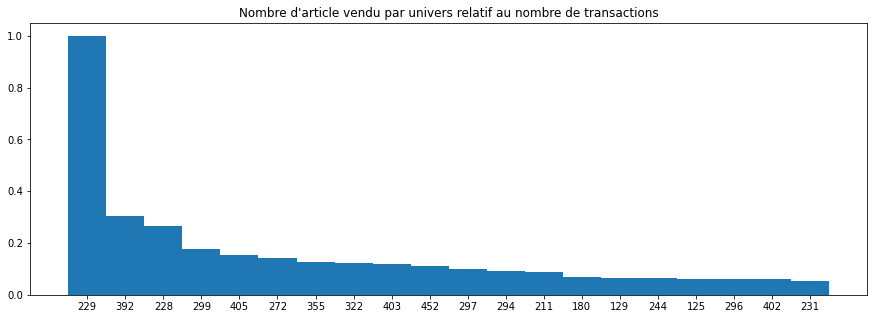

==============230===================
NOT ENOUGH DATA 
==============231===================
31215
Time Taken to load recurence: ~0secondes


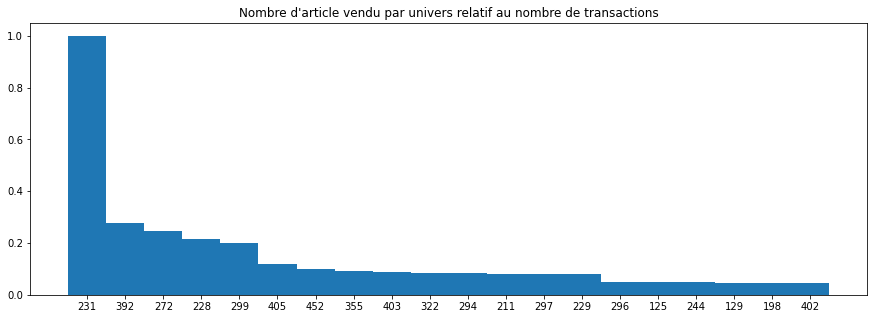

==============232===================
9099
Time Taken to load recurence: ~0secondes


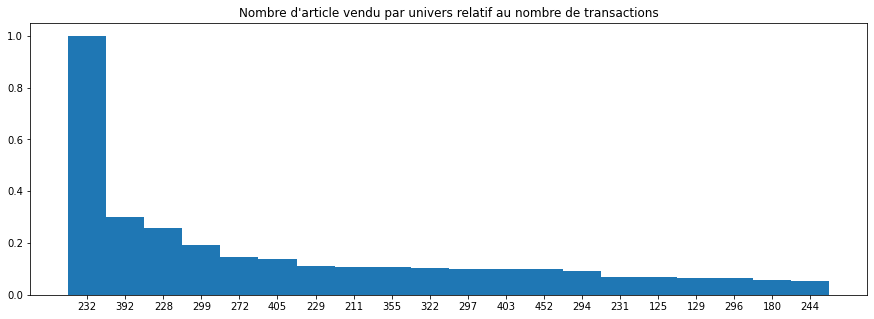

==============233===================
5407
Time Taken to load recurence: ~0secondes


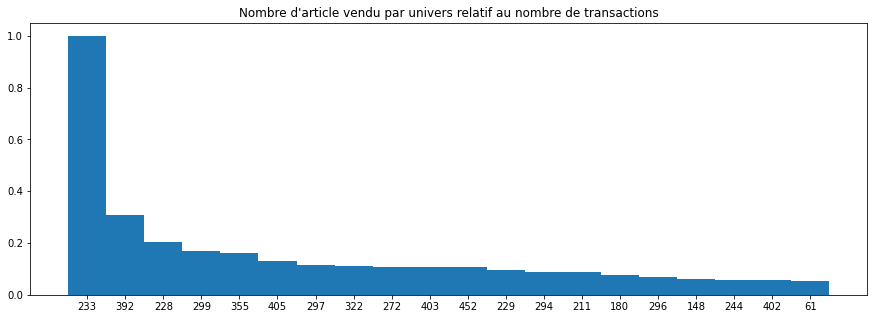

==============234===================
NOT ENOUGH DATA 
==============235===================
2080
Time Taken to load recurence: ~0secondes


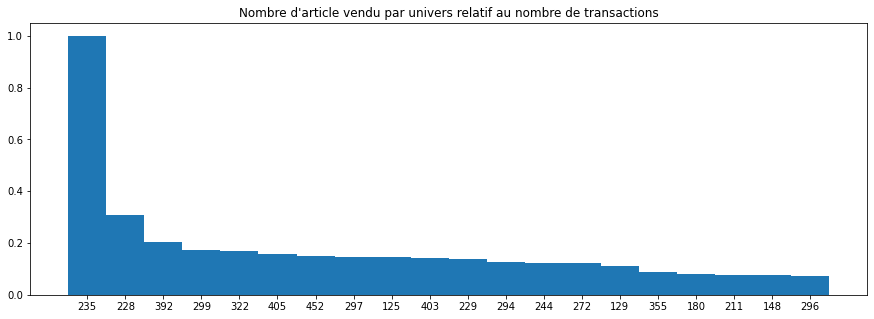

==============236===================
5675
Time Taken to load recurence: ~0secondes


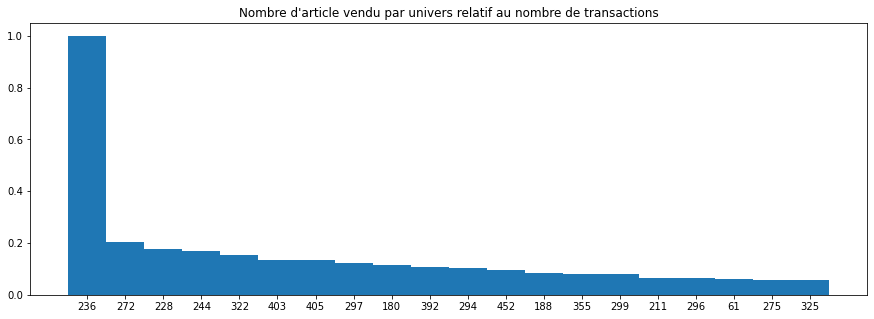

==============237===================
NOT ENOUGH DATA 
==============238===================
1197
Time Taken to load recurence: ~0secondes


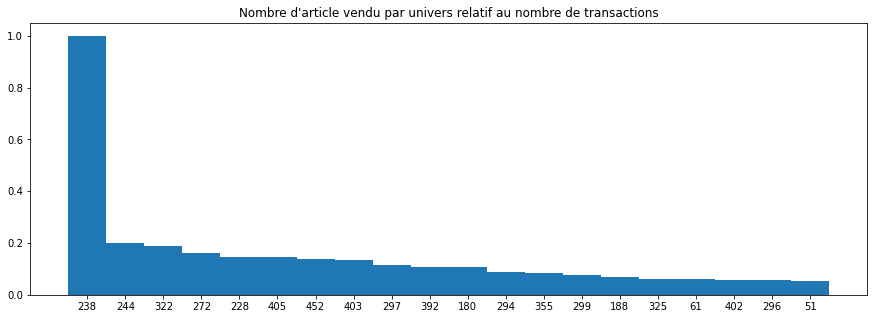

==============239===================
4362
Time Taken to load recurence: ~0secondes


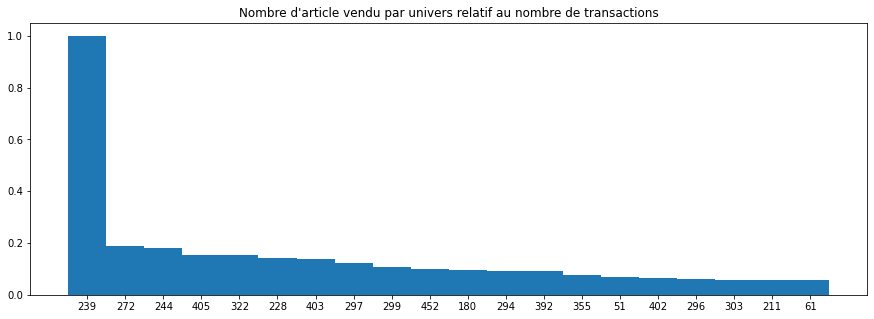

==============240===================
971
Time Taken to load recurence: ~0secondes


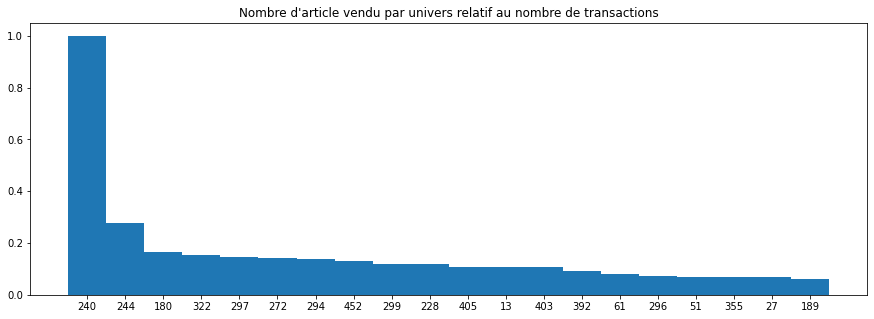

==============241===================
1221
Time Taken to load recurence: ~0secondes


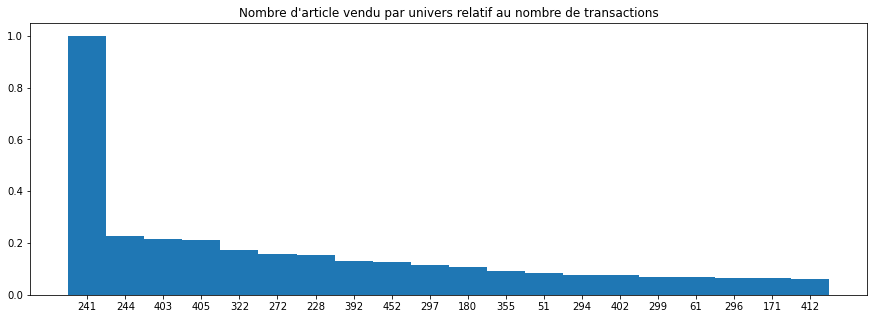

==============242===================
930
Time Taken to load recurence: ~0secondes


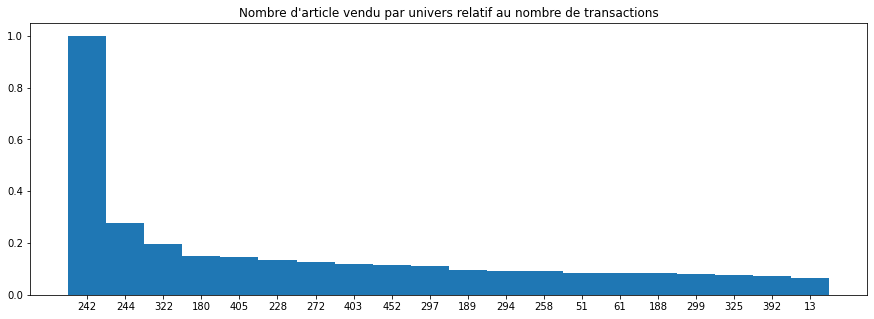

==============243===================
464
Time Taken to load recurence: ~0secondes


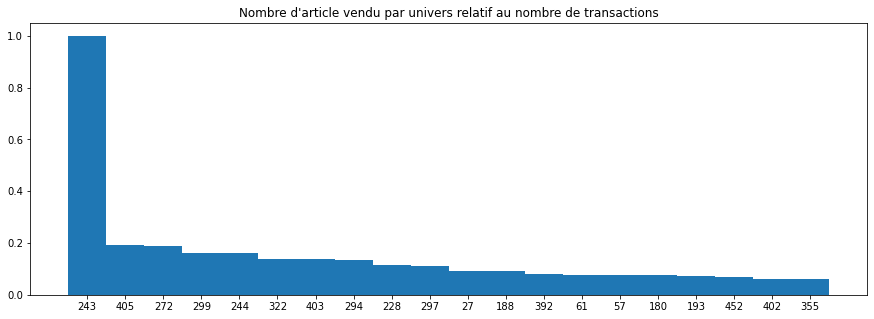

==============244===================
82120
Time Taken to load recurence: ~0secondes


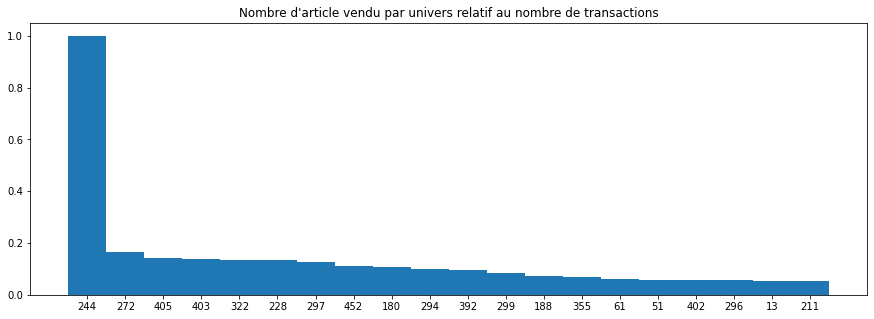

==============245===================
NOT ENOUGH DATA 
==============246===================
NOT ENOUGH DATA 
==============247===================
NOT ENOUGH DATA 
==============248===================
NOT ENOUGH DATA 
==============249===================
NOT ENOUGH DATA 
==============250===================
NOT ENOUGH DATA 
==============251===================
NOT ENOUGH DATA 
==============252===================
NOT ENOUGH DATA 
==============253===================
NOT ENOUGH DATA 
==============254===================
NOT ENOUGH DATA 
==============255===================
NOT ENOUGH DATA 
==============256===================
NOT ENOUGH DATA 
==============257===================
NOT ENOUGH DATA 
==============258===================
3126
Time Taken to load recurence: ~0secondes


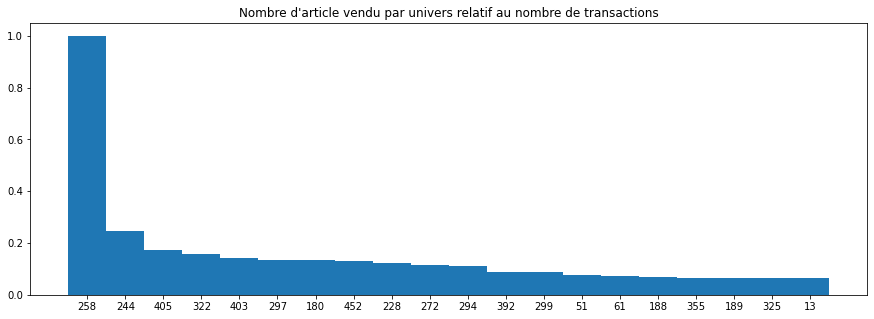

==============259===================
1094
Time Taken to load recurence: ~0secondes


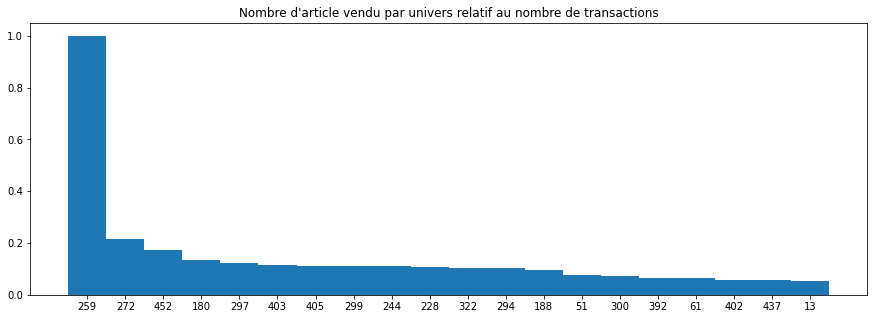

==============260===================
NOT ENOUGH DATA 
==============261===================
NOT ENOUGH DATA 
==============262===================
3534
Time Taken to load recurence: ~0secondes


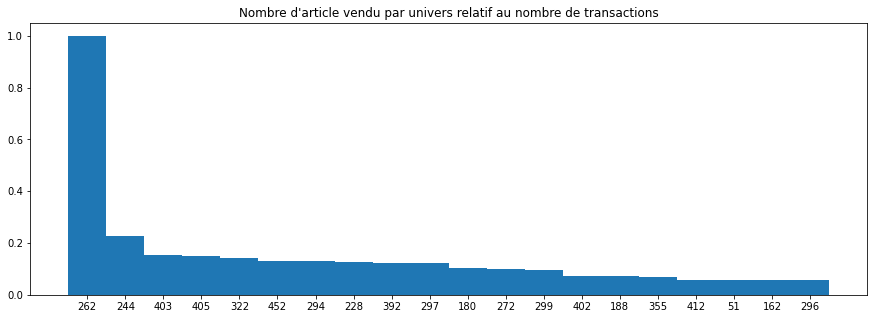

==============263===================
1088
Time Taken to load recurence: ~0secondes


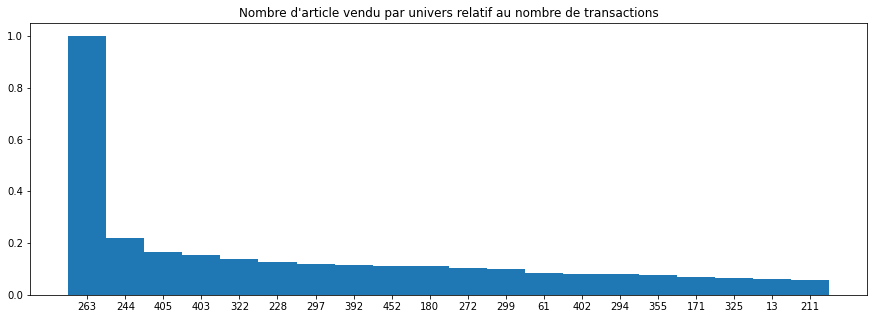

==============264===================
53
Time Taken to load recurence: ~0secondes


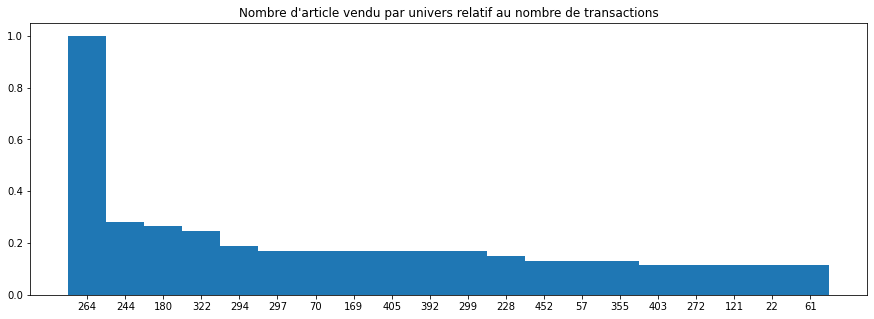

==============265===================
NOT ENOUGH DATA 
==============266===================
1511
Time Taken to load recurence: ~0secondes


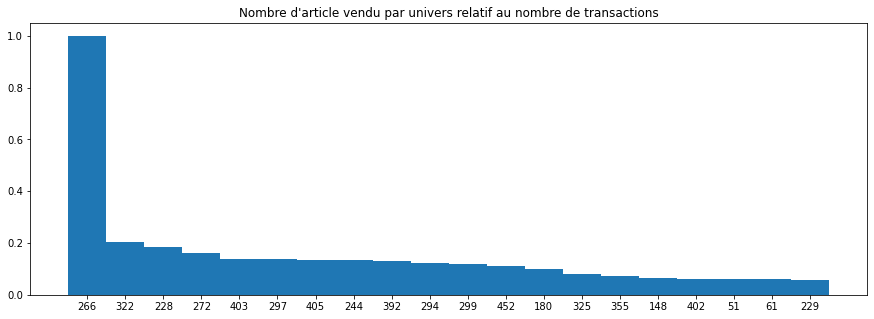

==============267===================
3653
Time Taken to load recurence: ~0secondes


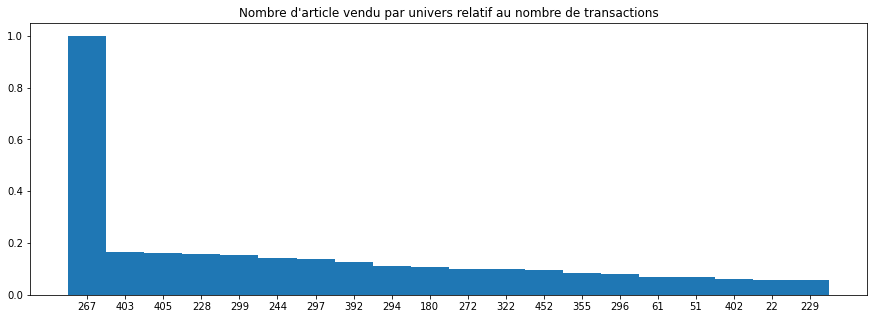

==============268===================
NOT ENOUGH DATA 
==============269===================
4642
Time Taken to load recurence: ~0secondes


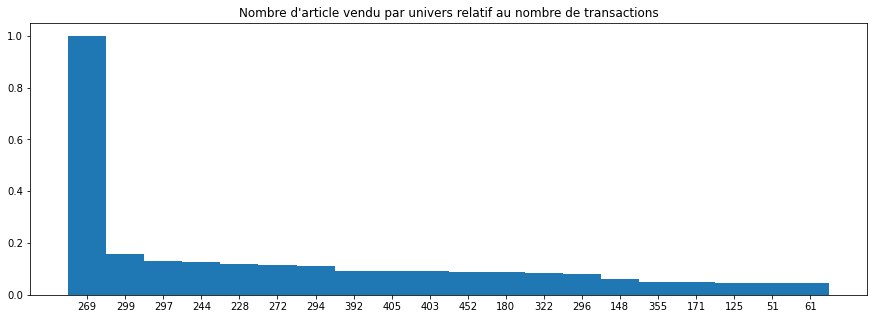

==============270===================
7803
Time Taken to load recurence: ~0secondes


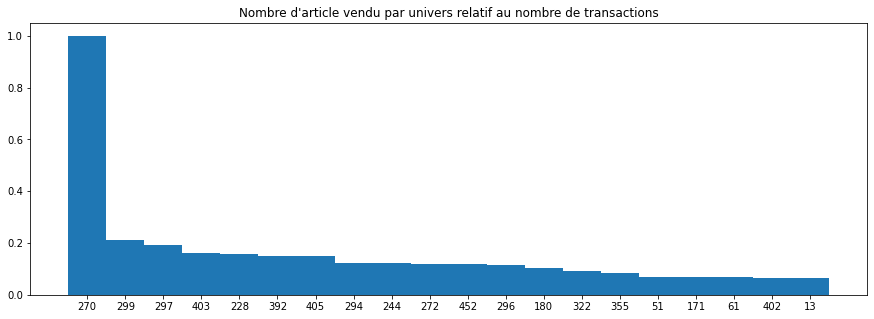

==============271===================
5029
Time Taken to load recurence: ~0secondes


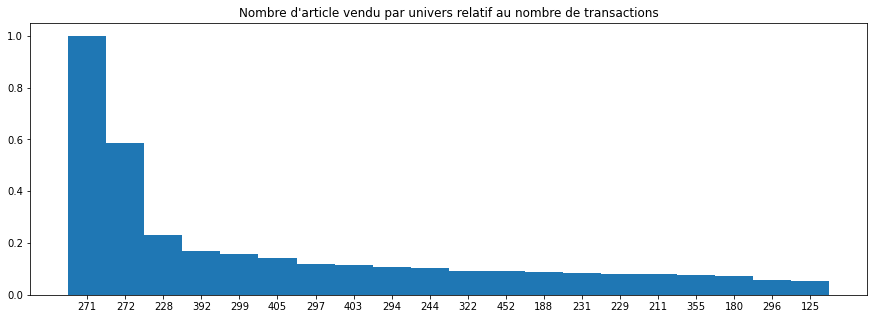

==============272===================
98435
Time Taken to load recurence: ~1secondes


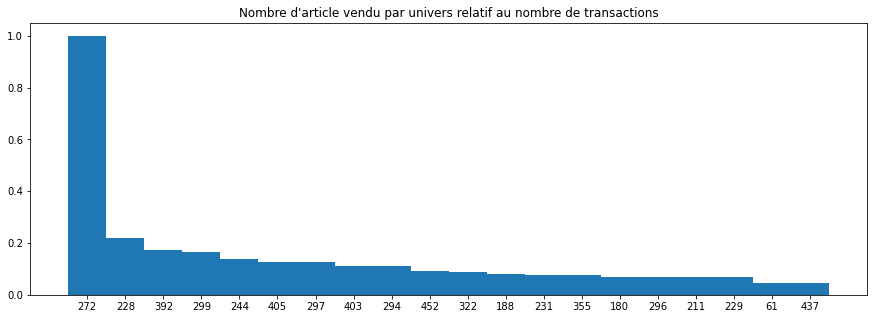

==============273===================
1194
Time Taken to load recurence: ~0secondes


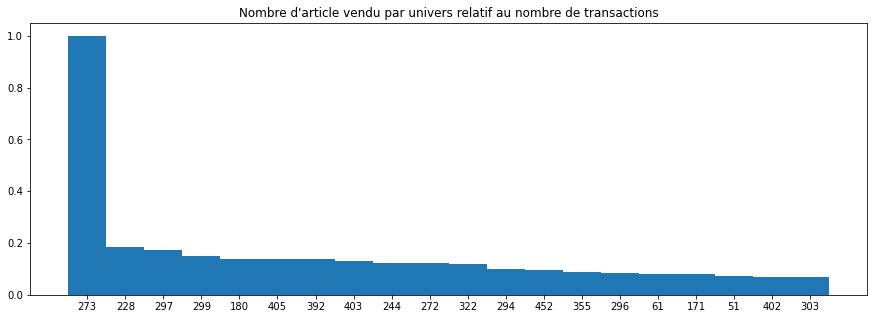

==============274===================
NOT ENOUGH DATA 
==============275===================
6336
Time Taken to load recurence: ~0secondes


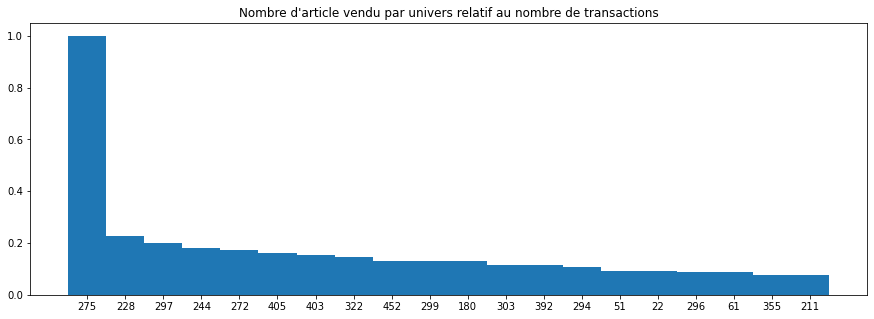

==============276===================
3121
Time Taken to load recurence: ~0secondes


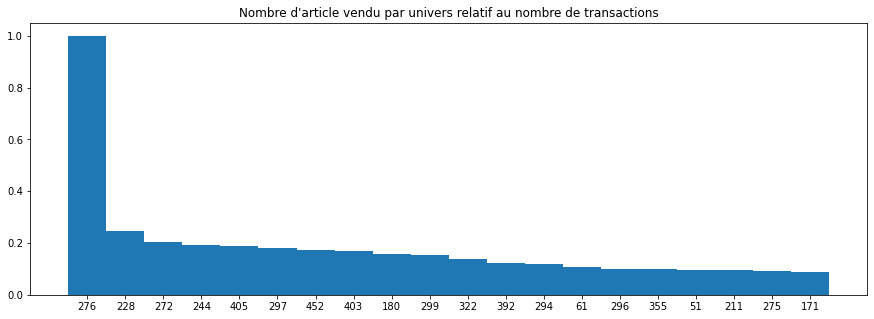

==============277===================
8573
Time Taken to load recurence: ~0secondes


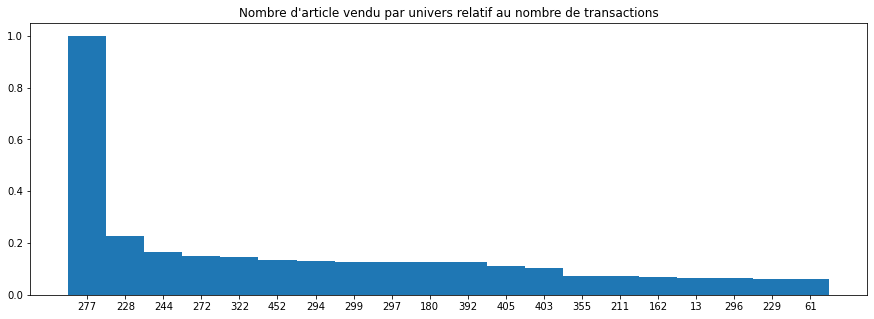

==============278===================
NOT ENOUGH DATA 
==============279===================
NOT ENOUGH DATA 
==============280===================
NOT ENOUGH DATA 
==============281===================
NOT ENOUGH DATA 
==============282===================
NOT ENOUGH DATA 
==============283===================
NOT ENOUGH DATA 
==============284===================
NOT ENOUGH DATA 
==============285===================
NOT ENOUGH DATA 
==============286===================
2718
Time Taken to load recurence: ~0secondes


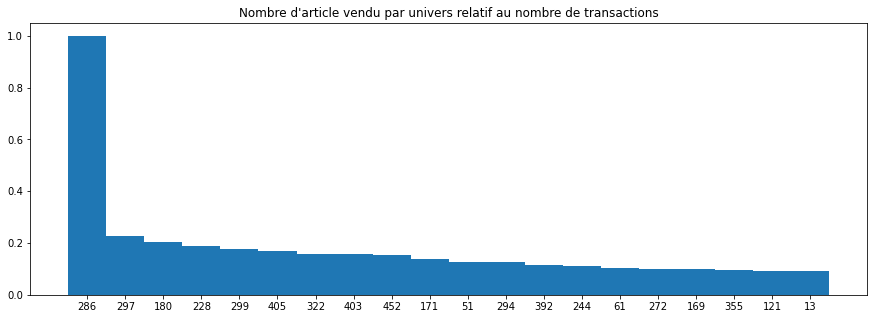

==============287===================
9490
Time Taken to load recurence: ~0secondes


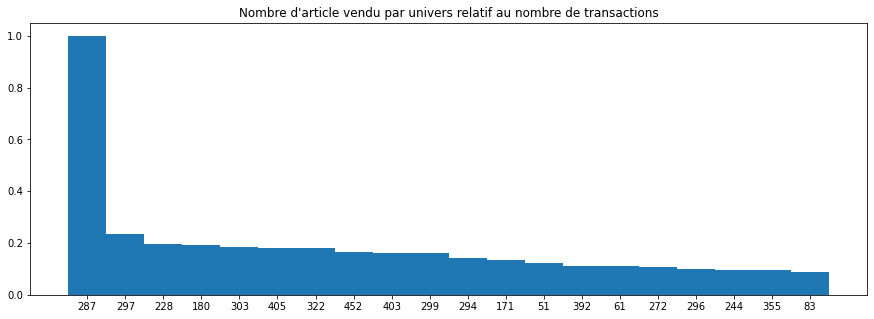

==============288===================
7073
Time Taken to load recurence: ~0secondes


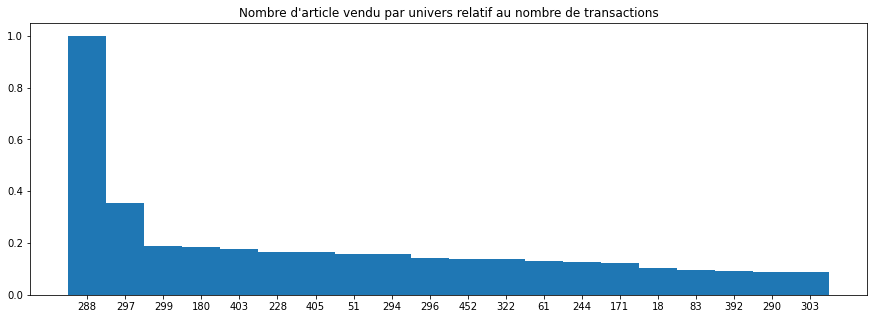

==============289===================
1476
Time Taken to load recurence: ~0secondes


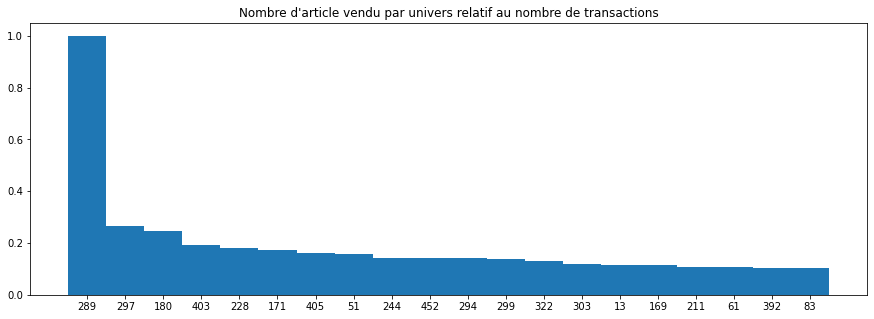

==============290===================
7030
Time Taken to load recurence: ~0secondes


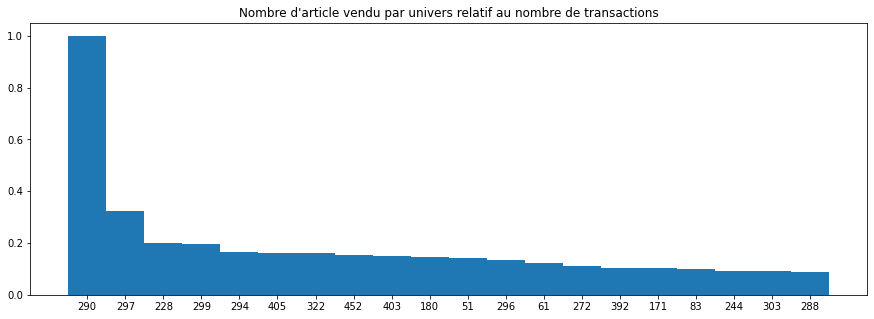

==============291===================
1017
Time Taken to load recurence: ~0secondes


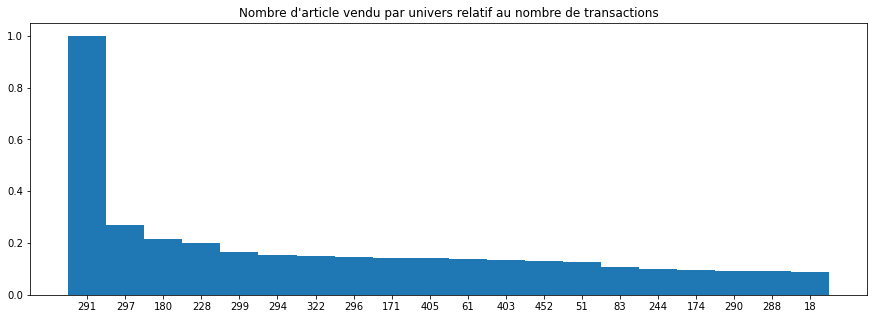

==============292===================
3848
Time Taken to load recurence: ~0secondes


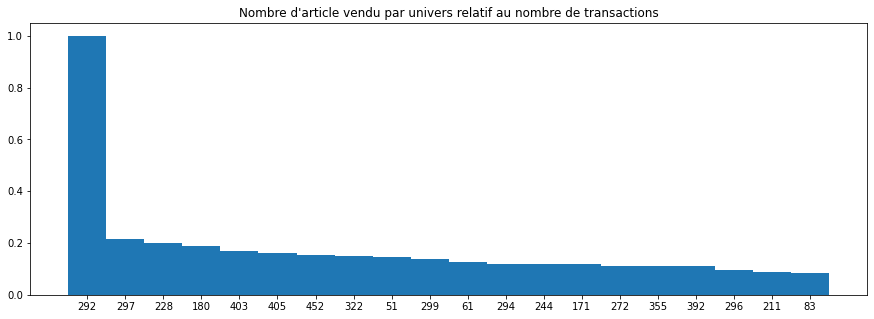

==============293===================
1660
Time Taken to load recurence: ~0secondes


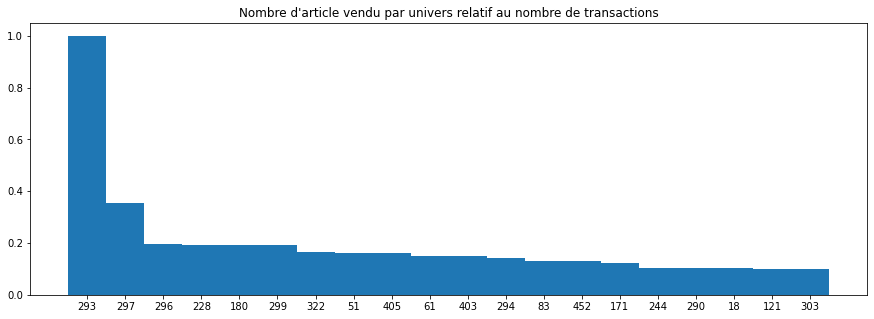

==============294===================
95198
Time Taken to load recurence: ~1secondes


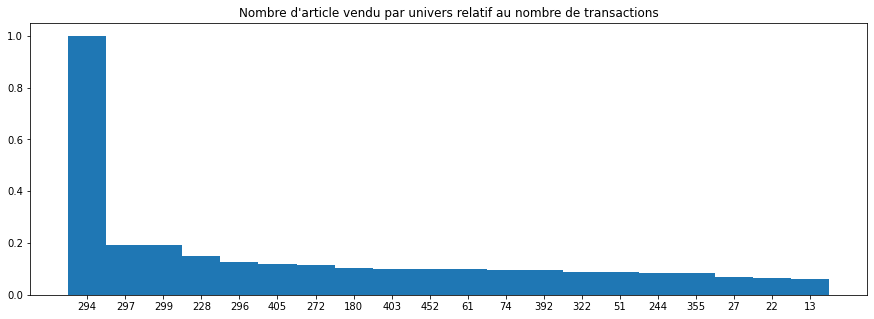

==============295===================
NOT ENOUGH DATA 
==============296===================
68231
Time Taken to load recurence: ~1secondes


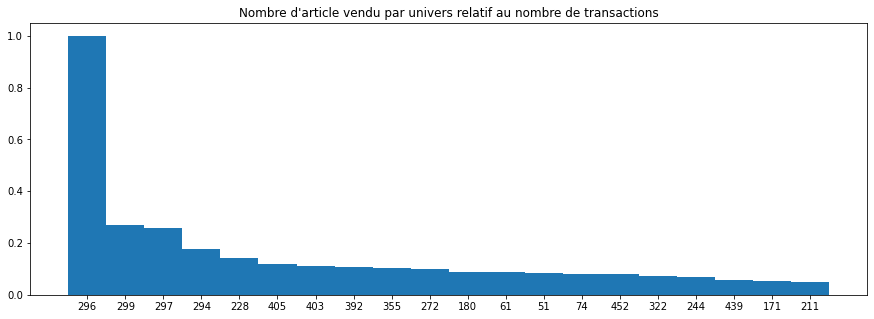

==============297===================
122152
Time Taken to load recurence: ~1secondes


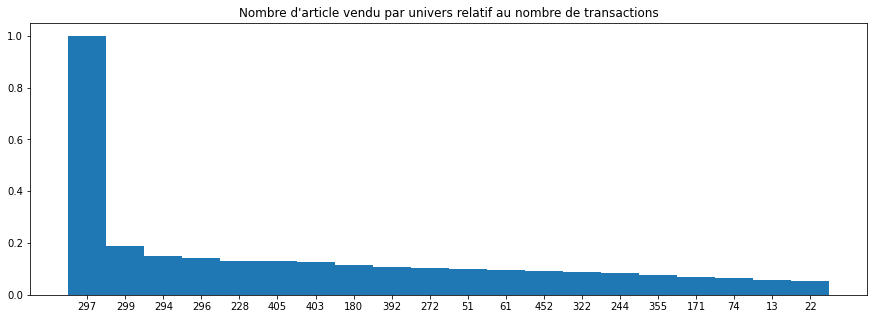

==============298===================
12026
Time Taken to load recurence: ~0secondes


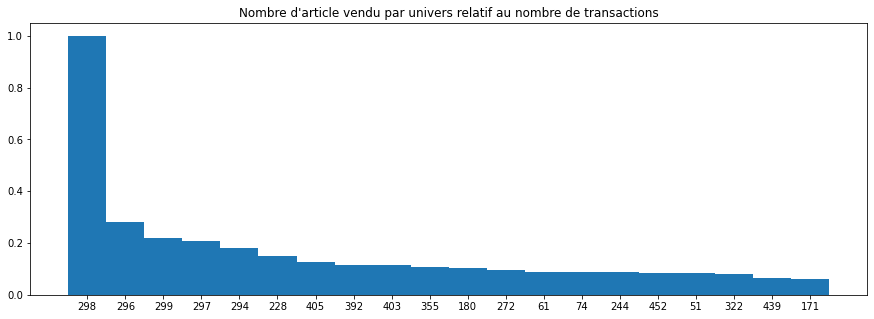

==============299===================
143717
Time Taken to load recurence: ~1secondes


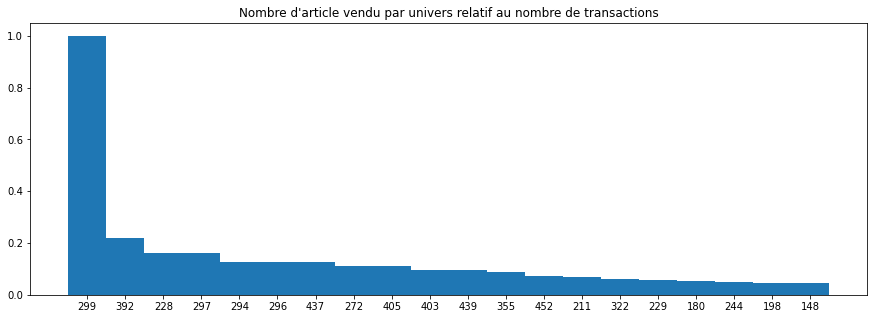

==============300===================
19042
Time Taken to load recurence: ~0secondes


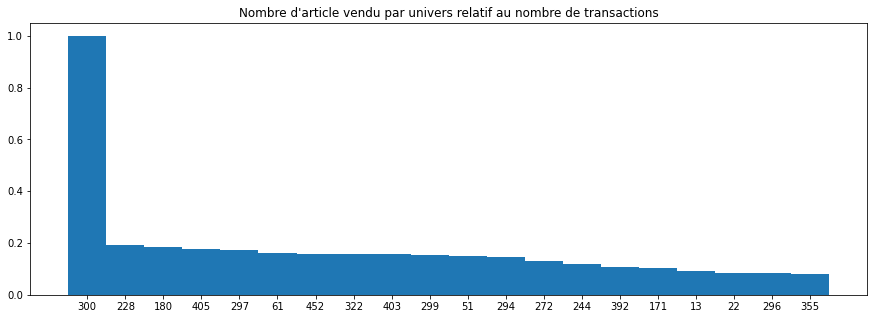

==============301===================
6854
Time Taken to load recurence: ~0secondes


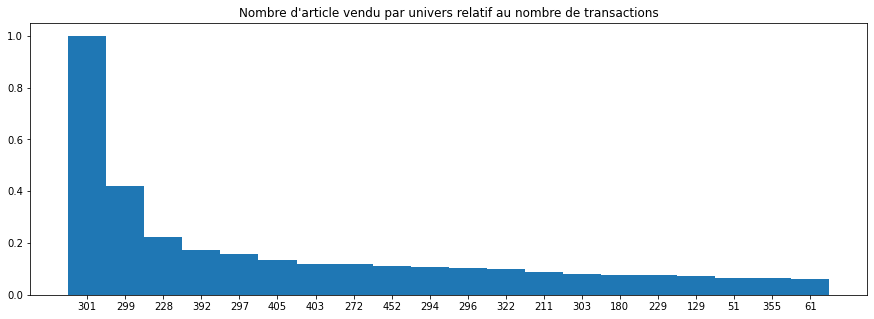

==============302===================
4200
Time Taken to load recurence: ~0secondes


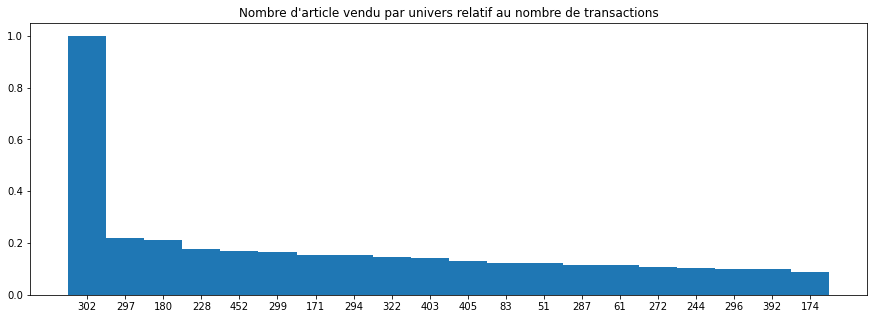

==============303===================
19518
Time Taken to load recurence: ~0secondes


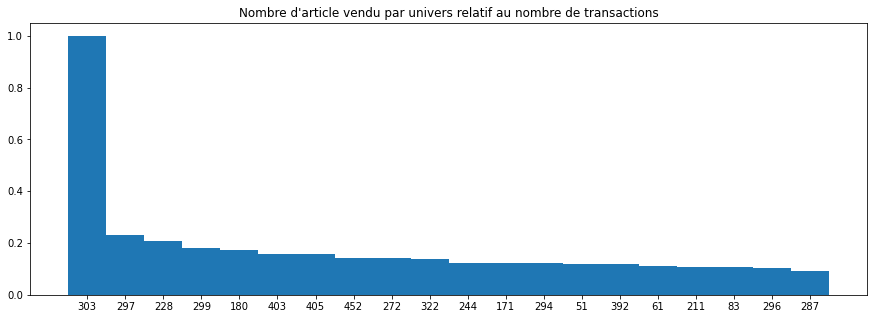

==============304===================
210
Time Taken to load recurence: ~0secondes


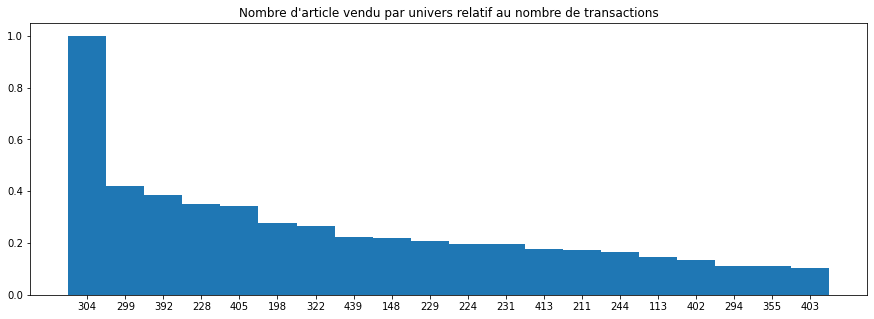

==============305===================
3831
Time Taken to load recurence: ~0secondes


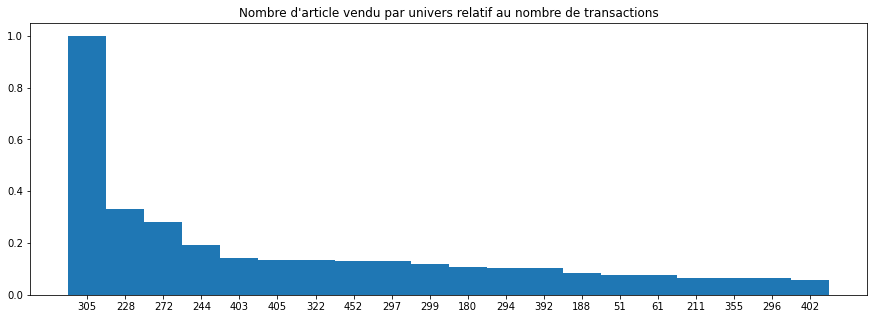

==============306===================
2302
Time Taken to load recurence: ~0secondes


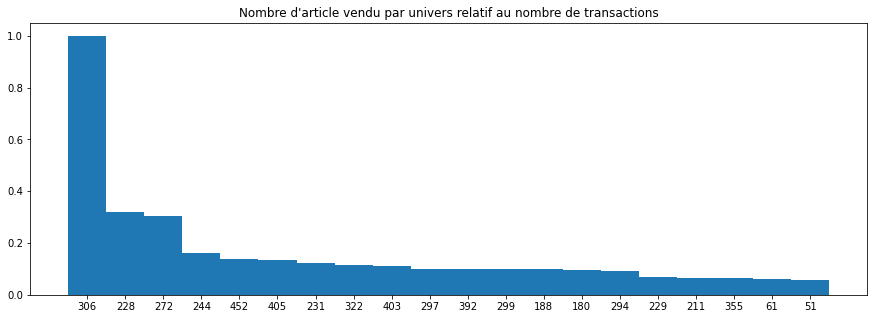

==============307===================
2084
Time Taken to load recurence: ~0secondes


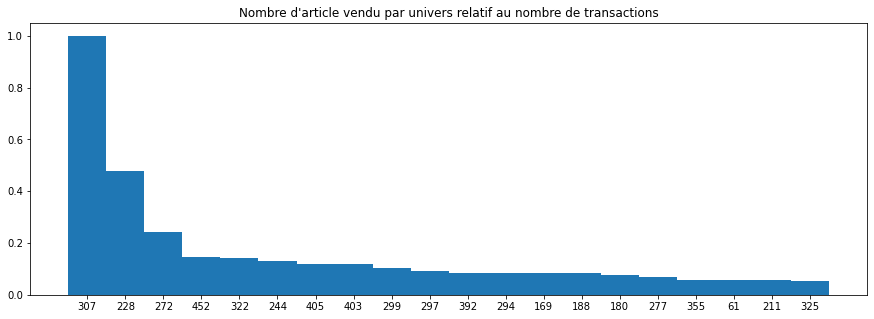

==============308===================
1583
Time Taken to load recurence: ~0secondes


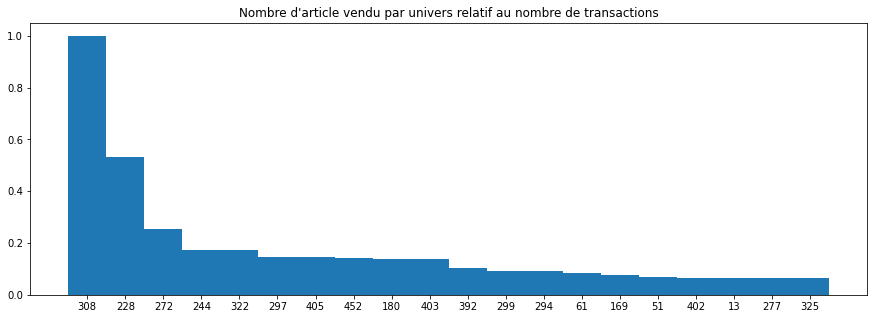

==============309===================
195
Time Taken to load recurence: ~0secondes


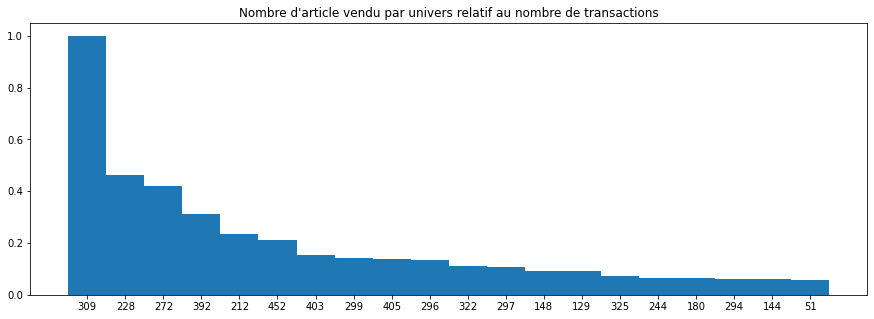

==============310===================
1393
Time Taken to load recurence: ~0secondes


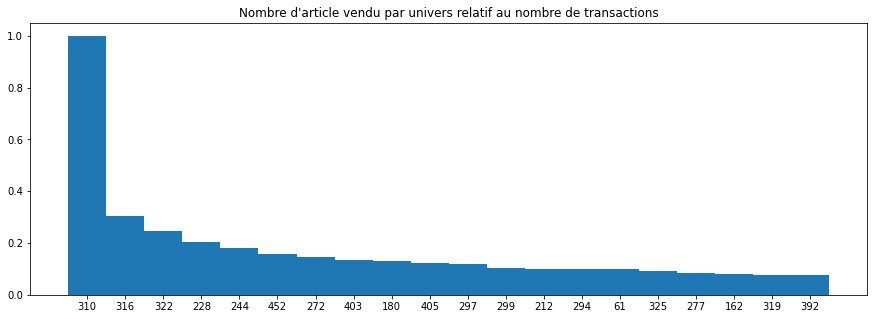

==============311===================
5429
Time Taken to load recurence: ~0secondes


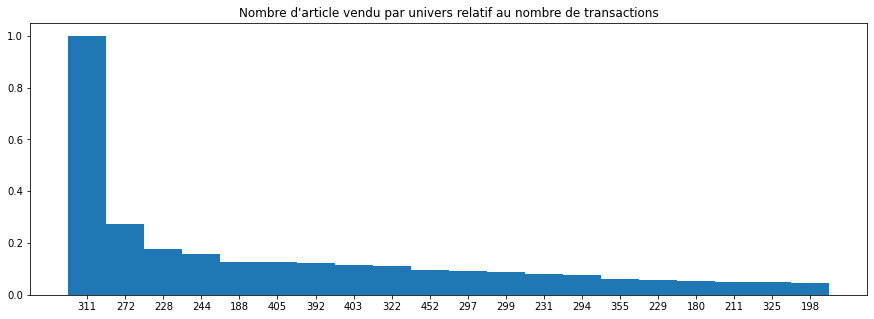

==============312===================
4590
Time Taken to load recurence: ~0secondes


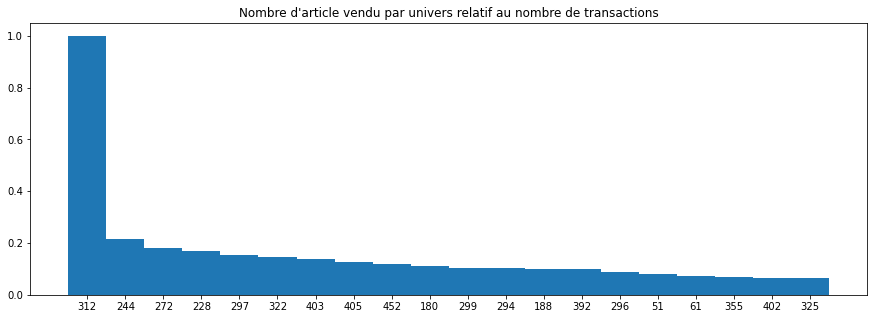

==============313===================
3071
Time Taken to load recurence: ~0secondes


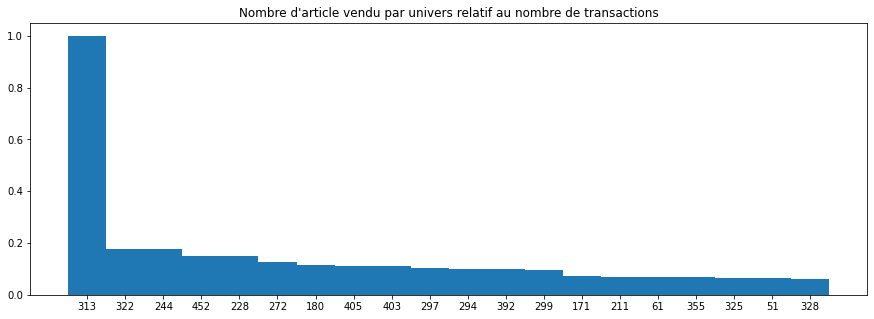

==============314===================
96
Time Taken to load recurence: ~0secondes


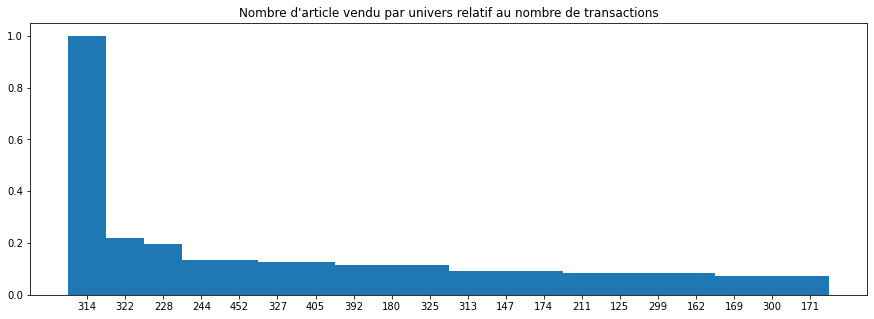

==============315===================
311
Time Taken to load recurence: ~0secondes


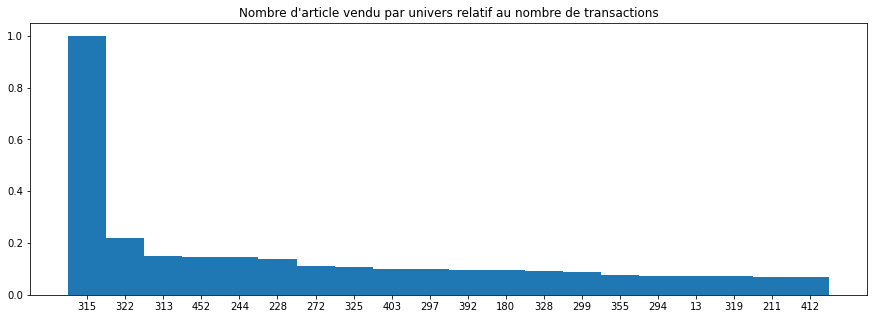

==============316===================
9008
Time Taken to load recurence: ~0secondes


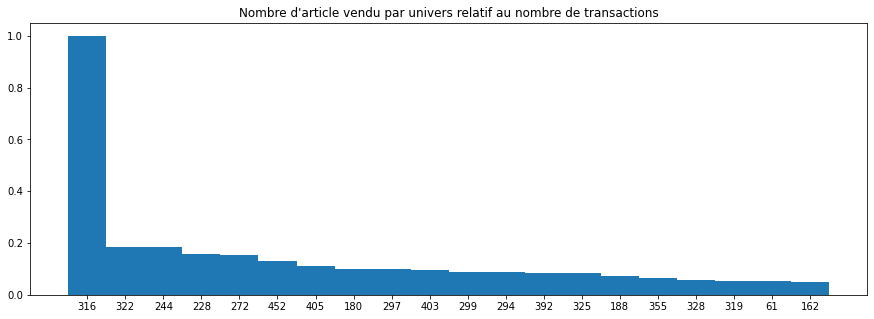

==============317===================
2714
Time Taken to load recurence: ~0secondes


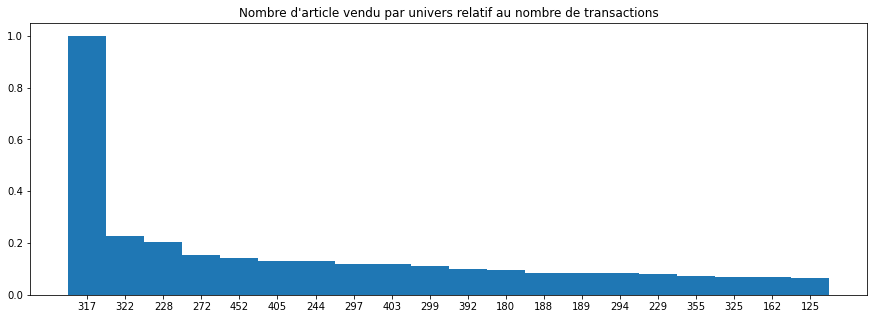

==============318===================
551
Time Taken to load recurence: ~0secondes


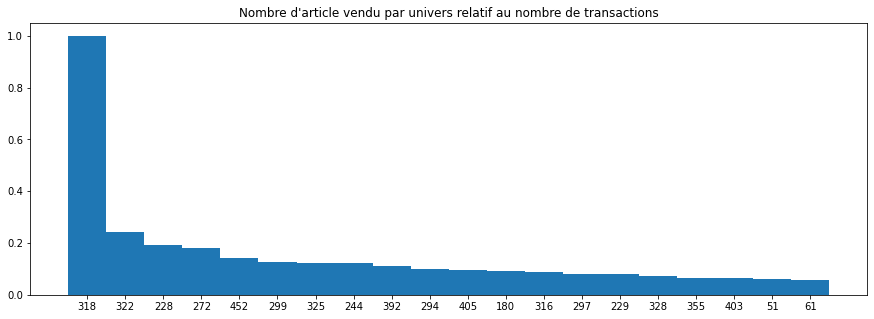

==============319===================
16886
Time Taken to load recurence: ~0secondes


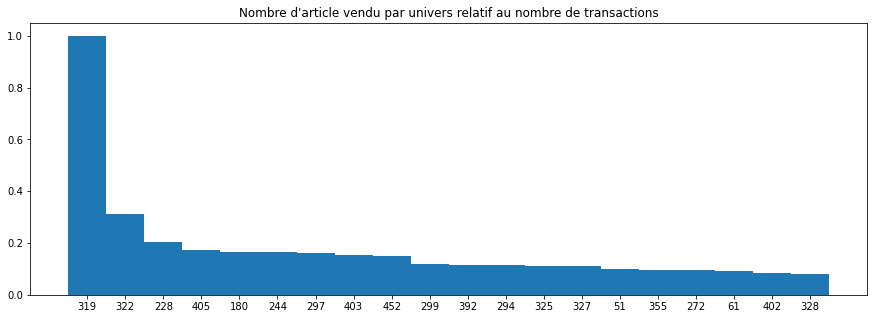

==============320===================
1226
Time Taken to load recurence: ~0secondes


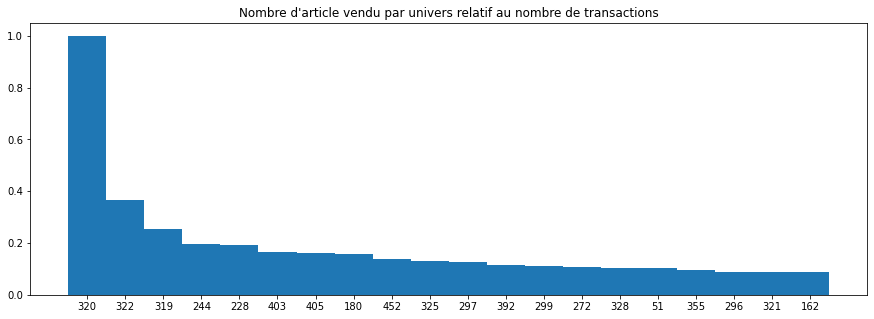

==============321===================
10914
Time Taken to load recurence: ~0secondes


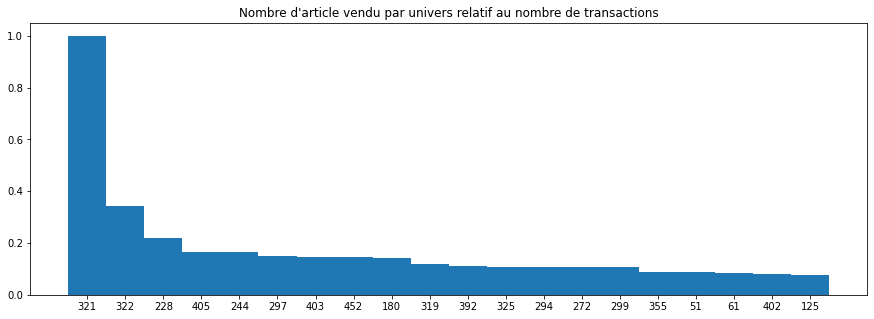

==============322===================
74538
Time Taken to load recurence: ~1secondes


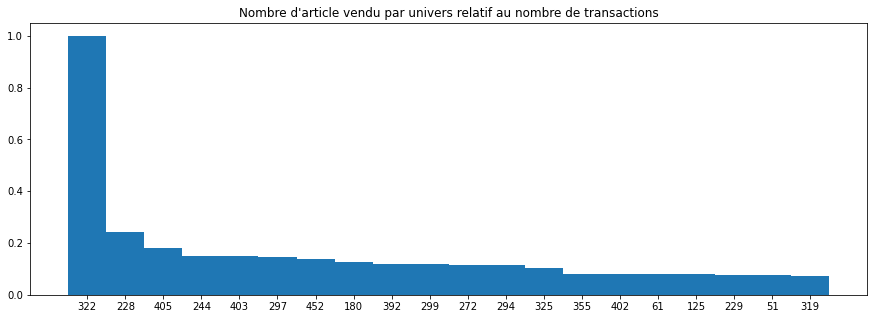

==============323===================
2559
Time Taken to load recurence: ~0secondes


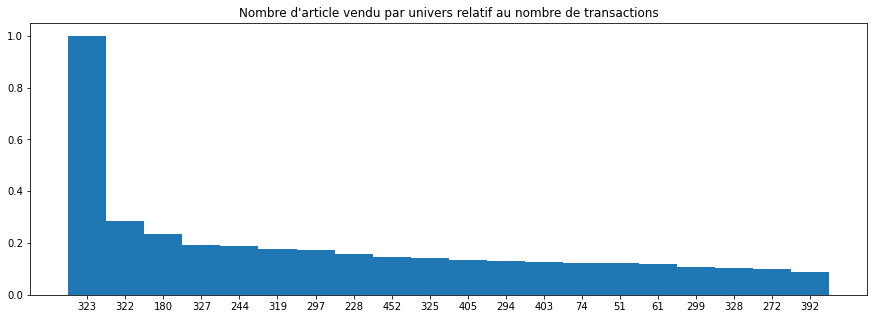

==============324===================
4446
Time Taken to load recurence: ~0secondes


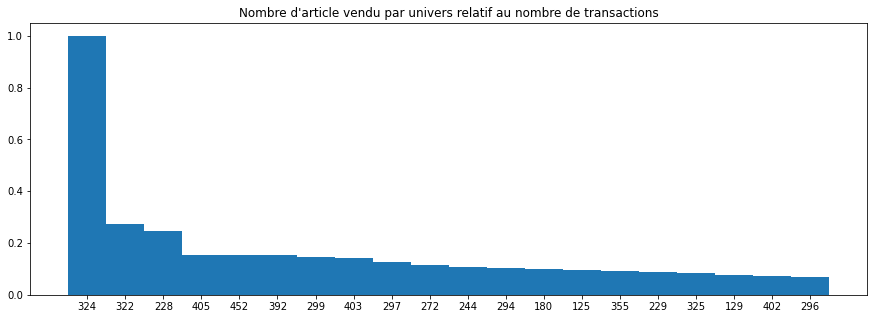

==============325===================
26210
Time Taken to load recurence: ~0secondes


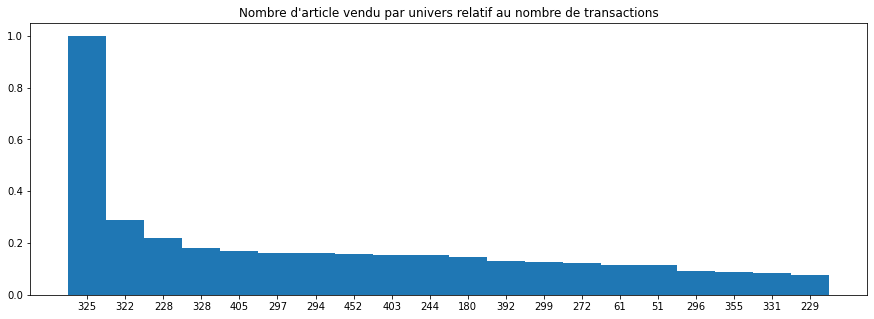

==============326===================
207
Time Taken to load recurence: ~0secondes


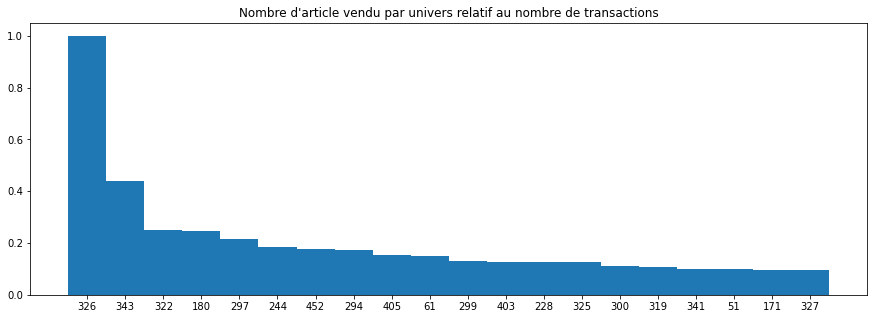

==============327===================
9863
Time Taken to load recurence: ~0secondes


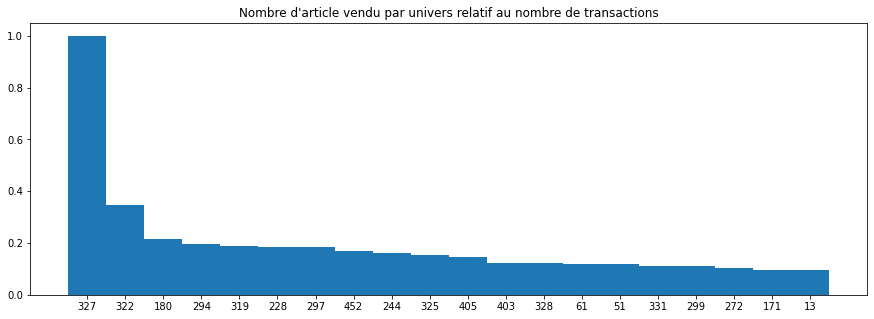

==============328===================
13680
Time Taken to load recurence: ~0secondes


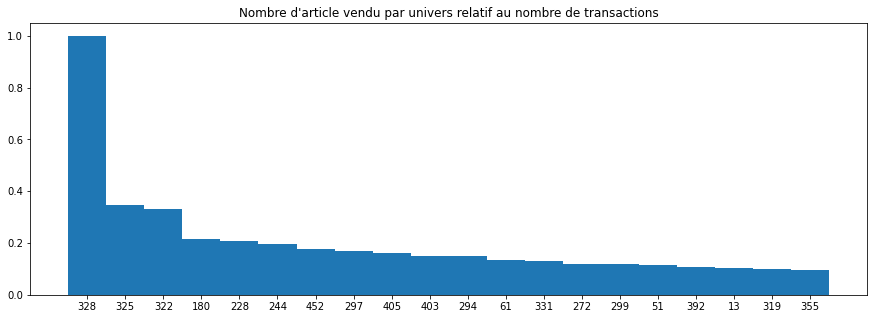

==============329===================
764
Time Taken to load recurence: ~0secondes


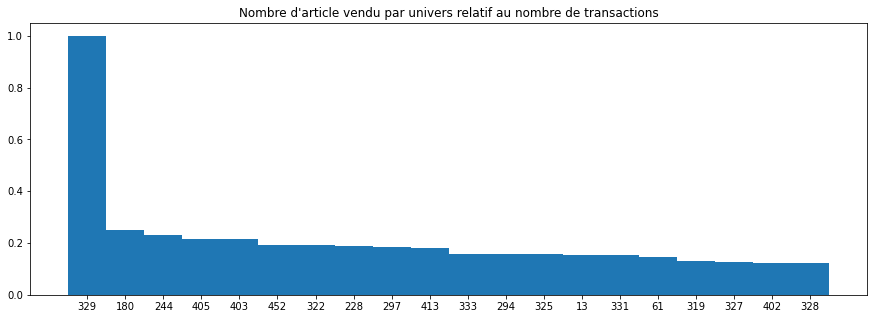

==============330===================
NOT ENOUGH DATA 
==============331===================
8820
Time Taken to load recurence: ~0secondes


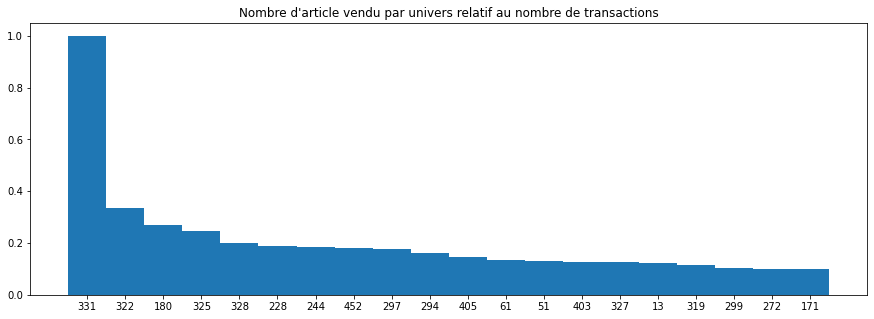

==============332===================
163
Time Taken to load recurence: ~0secondes


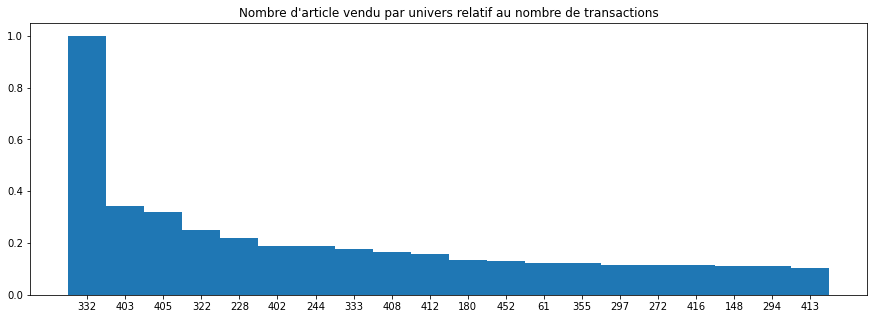

==============333===================
4630
Time Taken to load recurence: ~0secondes


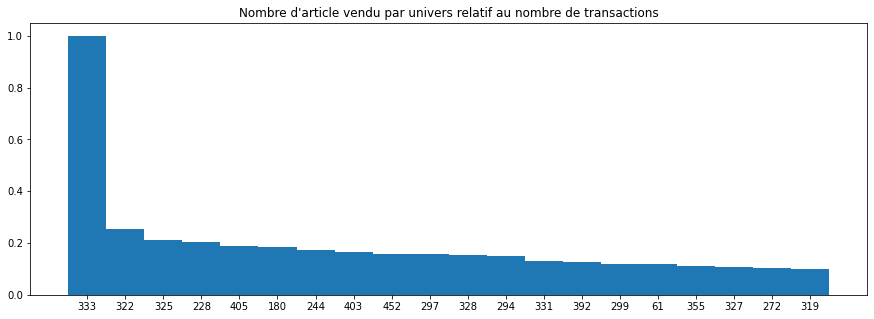

==============334===================
2104
Time Taken to load recurence: ~0secondes


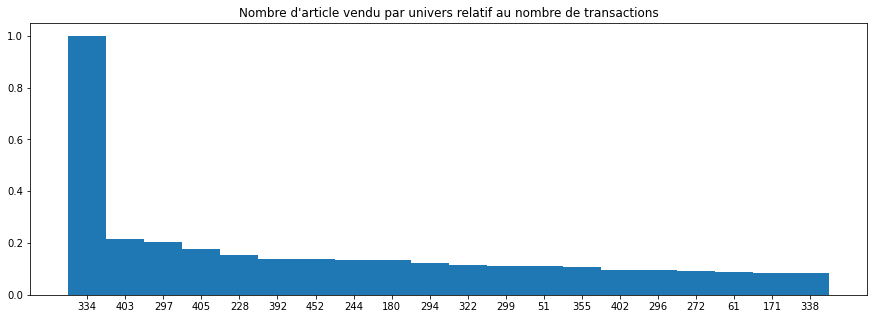

==============335===================
747
Time Taken to load recurence: ~0secondes


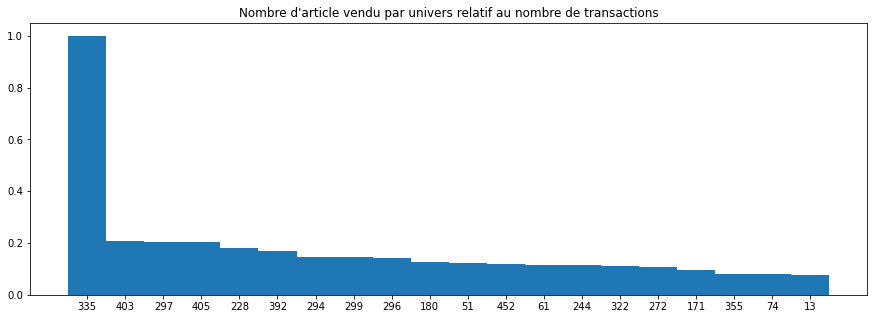

==============336===================
2464
Time Taken to load recurence: ~0secondes


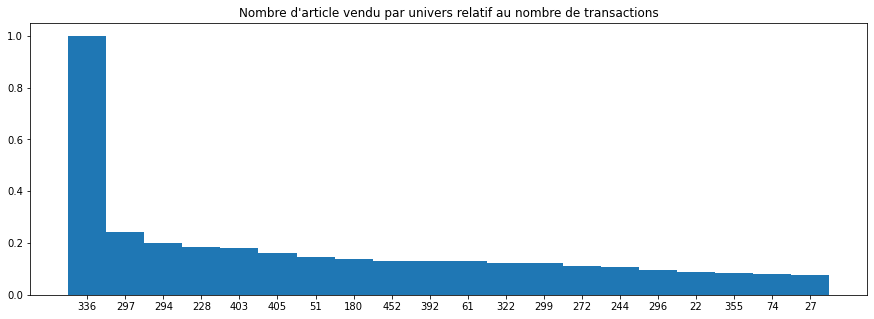

==============337===================
431
Time Taken to load recurence: ~0secondes


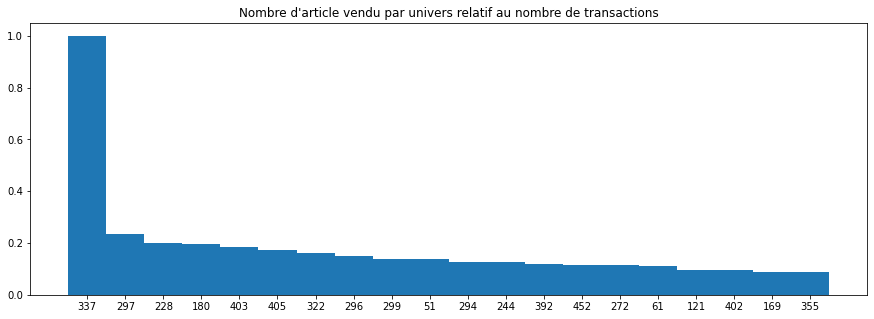

==============338===================
1654
Time Taken to load recurence: ~0secondes


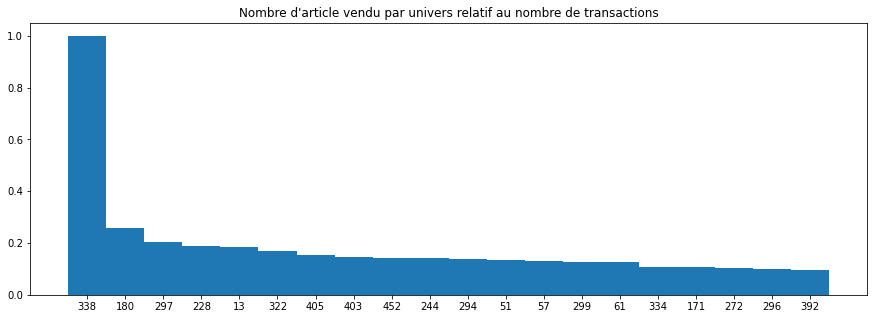

==============339===================
7577
Time Taken to load recurence: ~0secondes


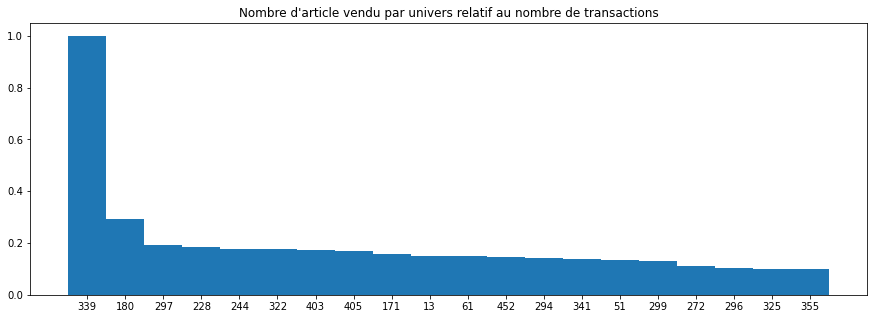

==============340===================
NOT ENOUGH DATA 
==============341===================
10164
Time Taken to load recurence: ~0secondes


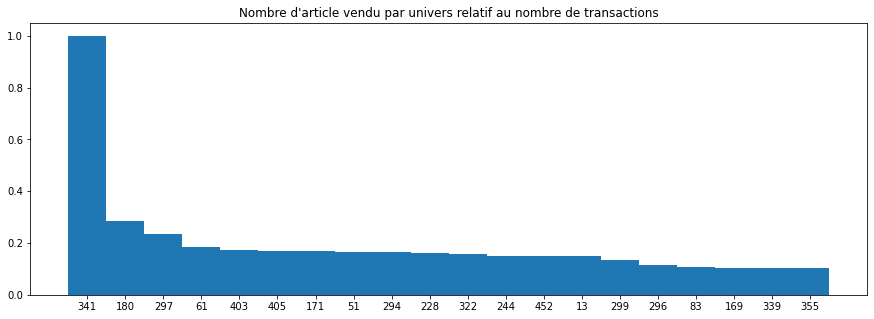

==============342===================
653
Time Taken to load recurence: ~0secondes


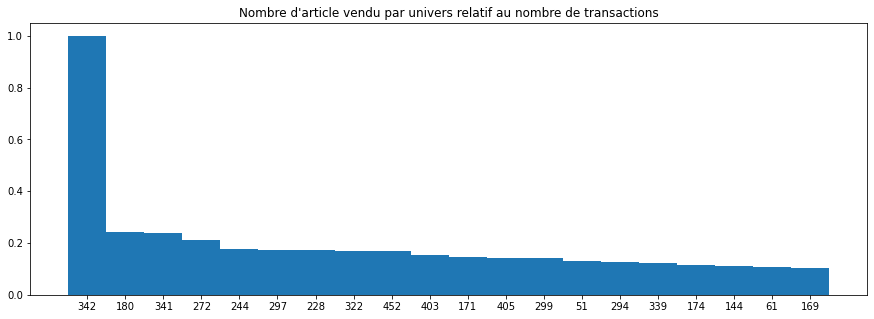

==============343===================
1234
Time Taken to load recurence: ~0secondes


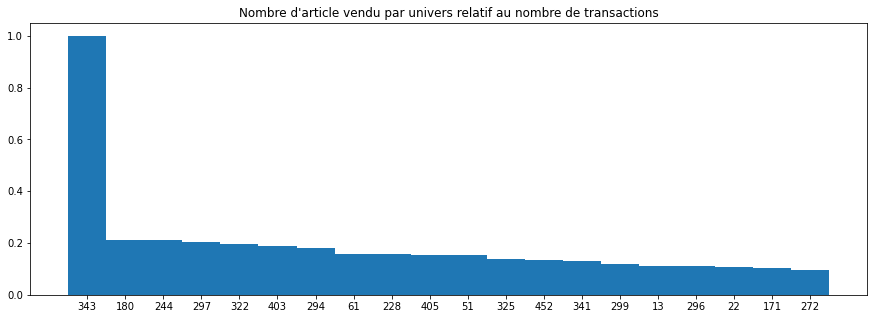

==============344===================
2519
Time Taken to load recurence: ~0secondes


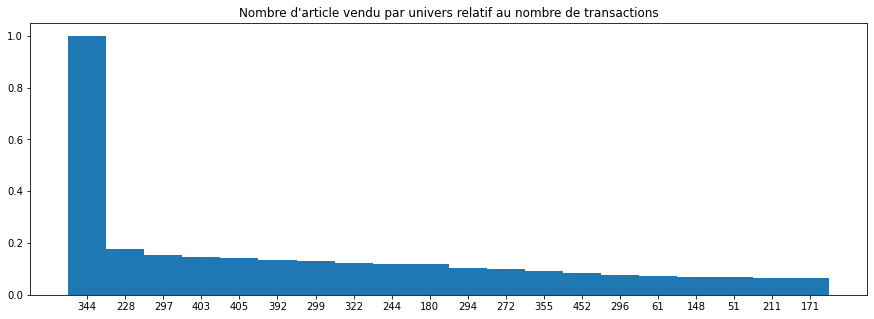

==============345===================
NOT ENOUGH DATA 
==============346===================
425
Time Taken to load recurence: ~0secondes


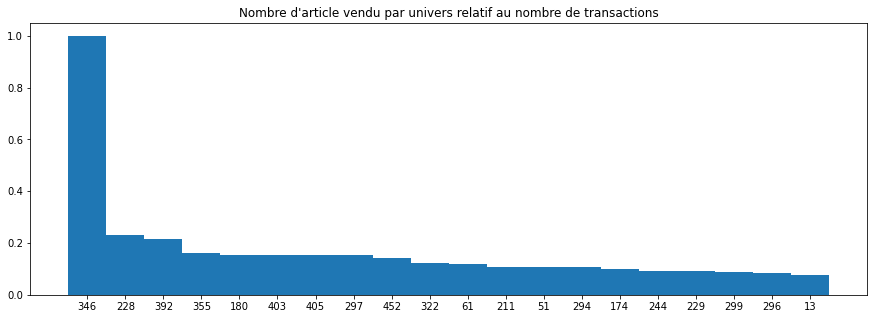

==============347===================
NOT ENOUGH DATA 
==============348===================
5495
Time Taken to load recurence: ~0secondes


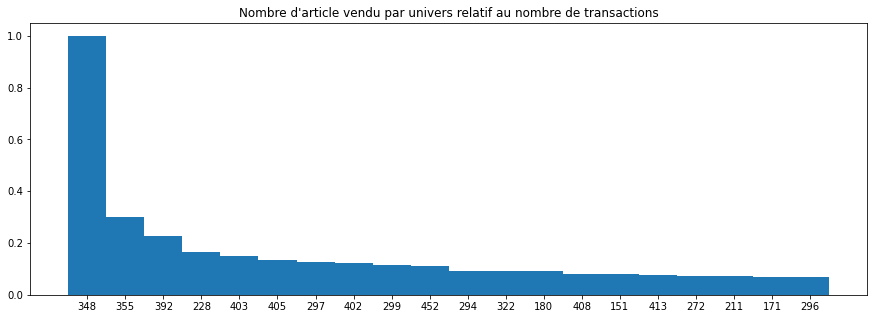

==============349===================
NOT ENOUGH DATA 
==============350===================
NOT ENOUGH DATA 
==============351===================
NOT ENOUGH DATA 
==============352===================
NOT ENOUGH DATA 
==============353===================
NOT ENOUGH DATA 
==============354===================
NOT ENOUGH DATA 
==============355===================
90964
Time Taken to load recurence: ~1secondes


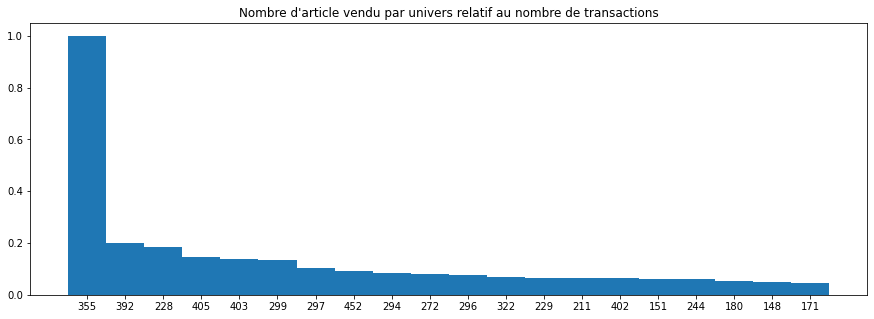

==============356===================
NOT ENOUGH DATA 
==============357===================
NOT ENOUGH DATA 
==============358===================
NOT ENOUGH DATA 
==============359===================
NOT ENOUGH DATA 
==============360===================
NOT ENOUGH DATA 
==============361===================
NOT ENOUGH DATA 
==============362===================
2755
Time Taken to load recurence: ~0secondes


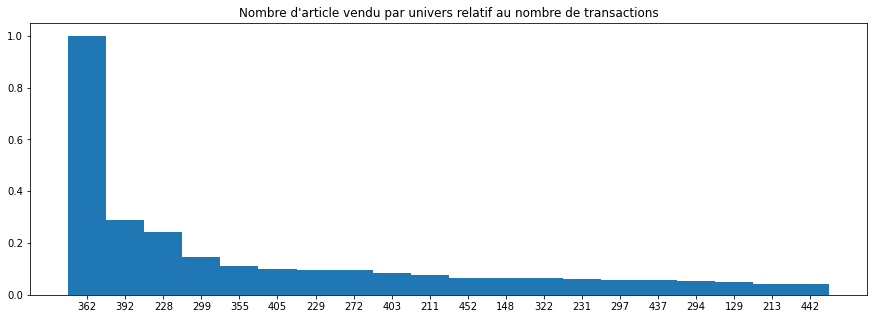

==============363===================
NOT ENOUGH DATA 
==============364===================
NOT ENOUGH DATA 
==============365===================
NOT ENOUGH DATA 
==============366===================
754
Time Taken to load recurence: ~0secondes


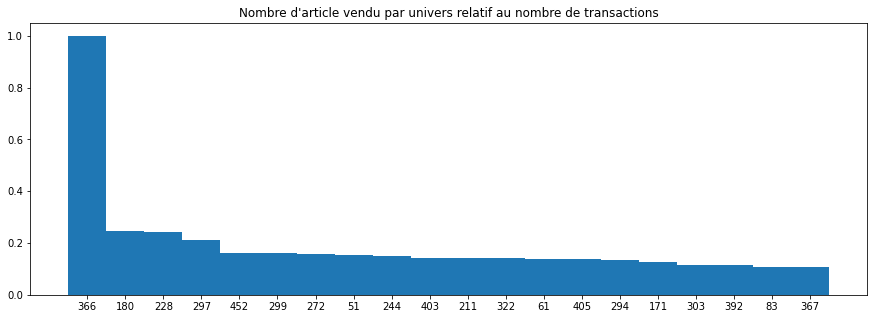

==============367===================
462
Time Taken to load recurence: ~0secondes


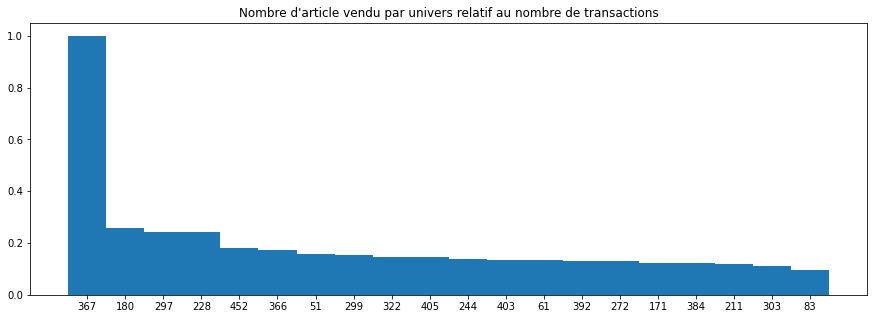

==============368===================
84
Time Taken to load recurence: ~0secondes


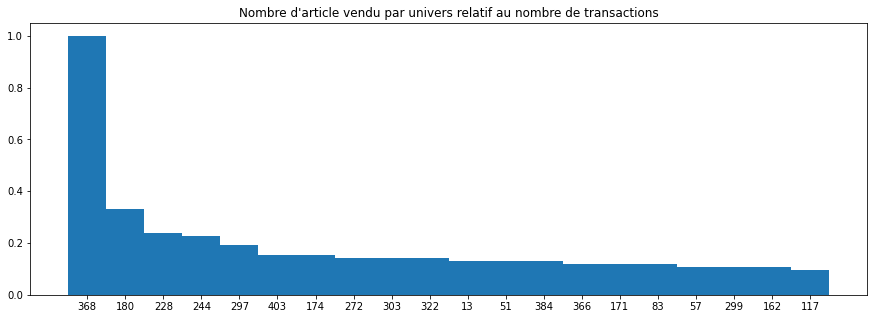

==============369===================
1808
Time Taken to load recurence: ~0secondes


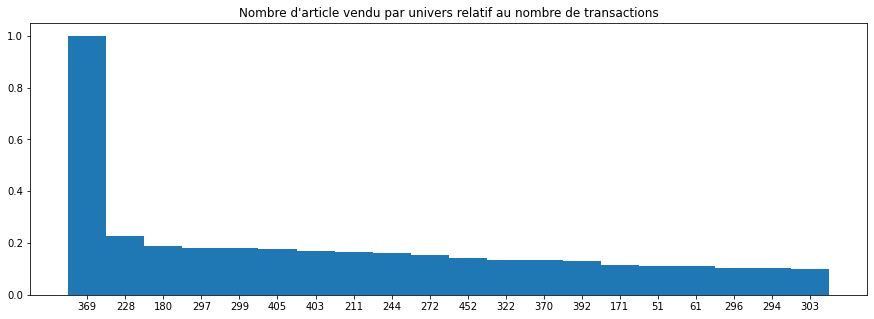

==============370===================
6095
Time Taken to load recurence: ~0secondes


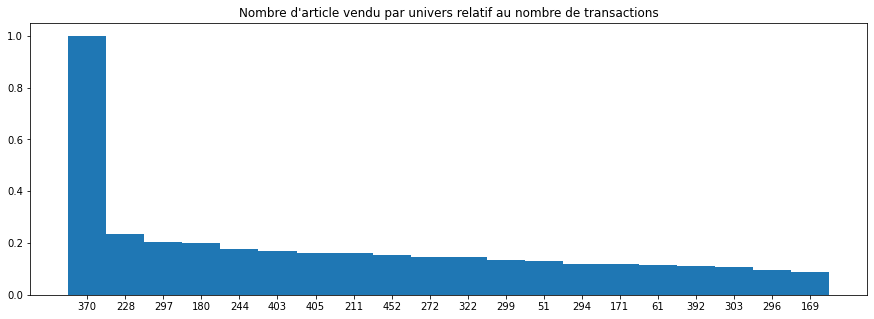

==============371===================
NOT ENOUGH DATA 
==============372===================
542
Time Taken to load recurence: ~0secondes


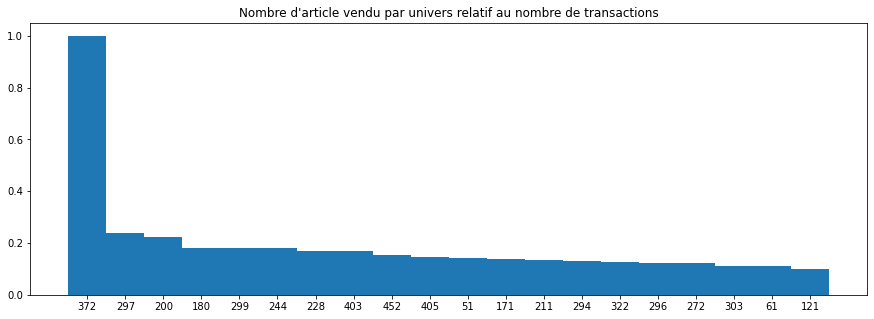

==============373===================
386
Time Taken to load recurence: ~0secondes


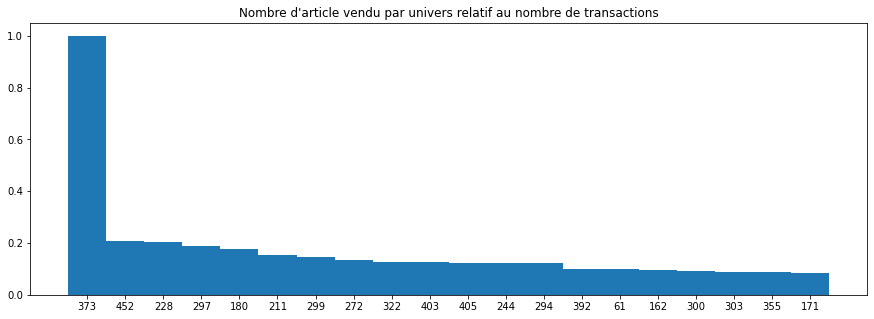

==============374===================
261
Time Taken to load recurence: ~0secondes


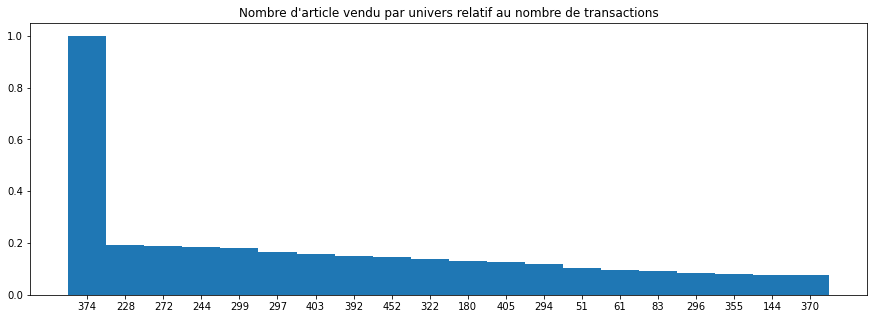

==============375===================
1561
Time Taken to load recurence: ~0secondes


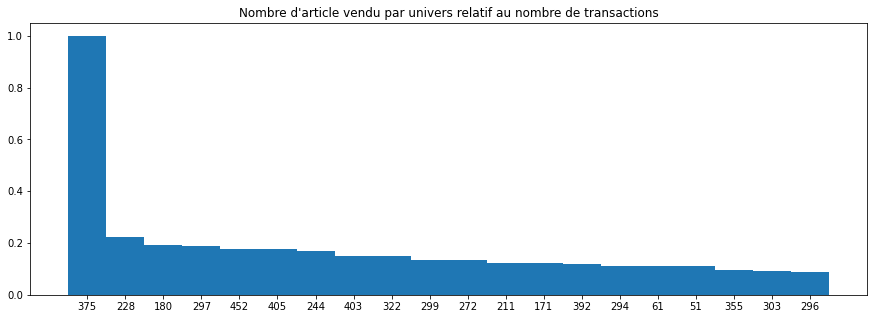

==============376===================
886
Time Taken to load recurence: ~0secondes


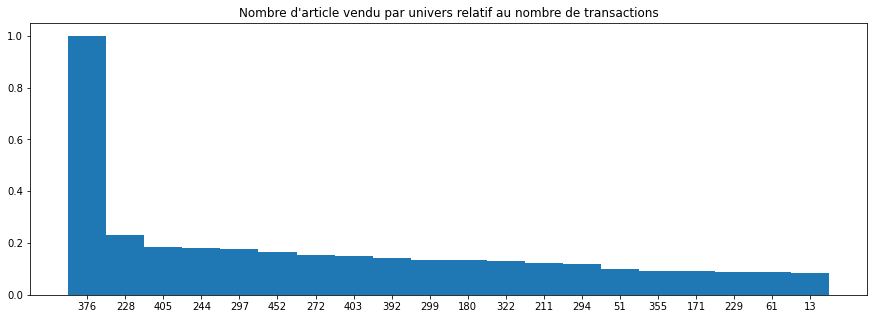

==============377===================
1680
Time Taken to load recurence: ~0secondes


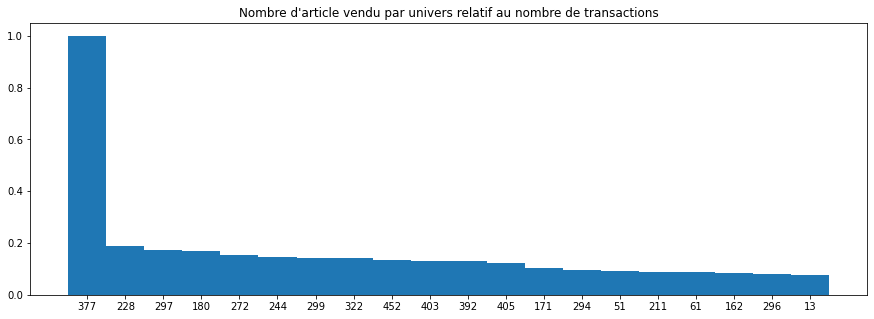

==============378===================
384
Time Taken to load recurence: ~0secondes


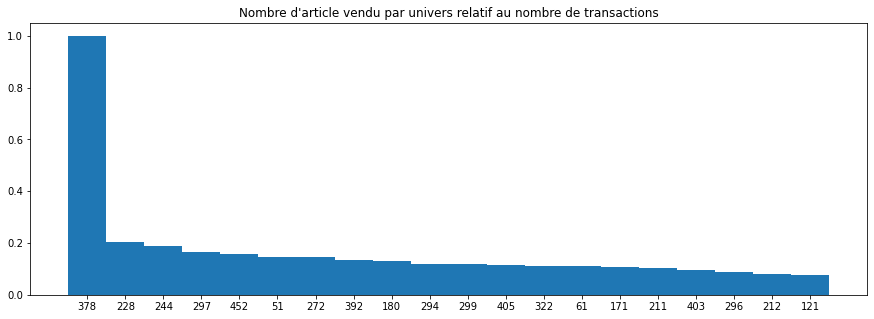

==============379===================
1275
Time Taken to load recurence: ~0secondes


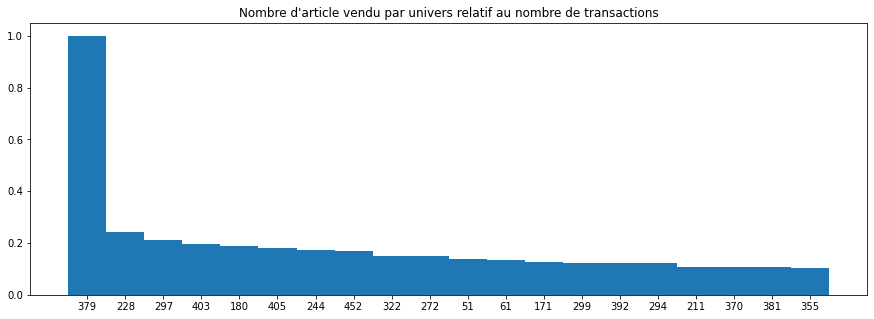

==============380===================
1218
Time Taken to load recurence: ~0secondes


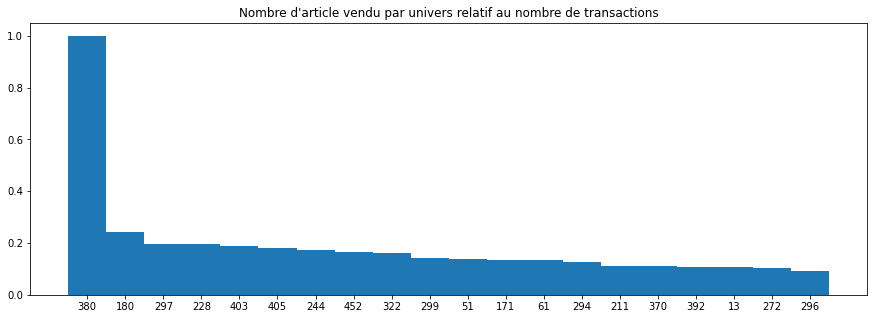

==============381===================
594
Time Taken to load recurence: ~0secondes


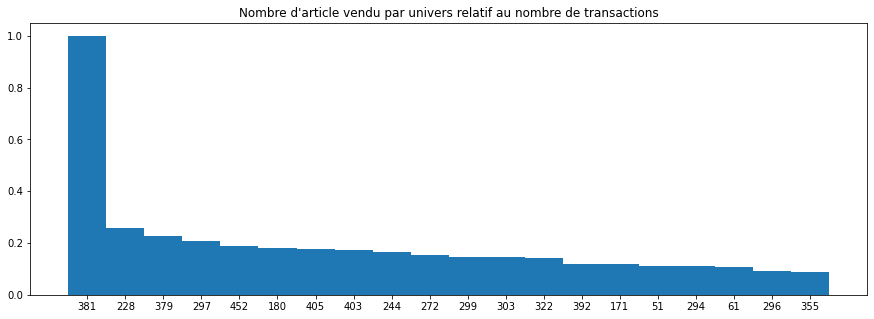

==============382===================
2248
Time Taken to load recurence: ~0secondes


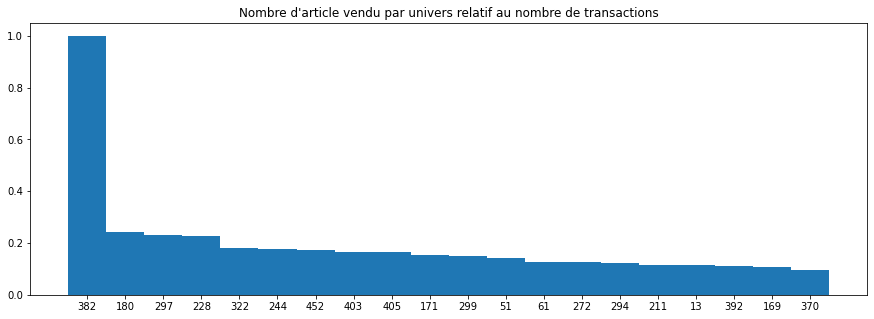

==============383===================
NOT ENOUGH DATA 
==============384===================
2702
Time Taken to load recurence: ~0secondes


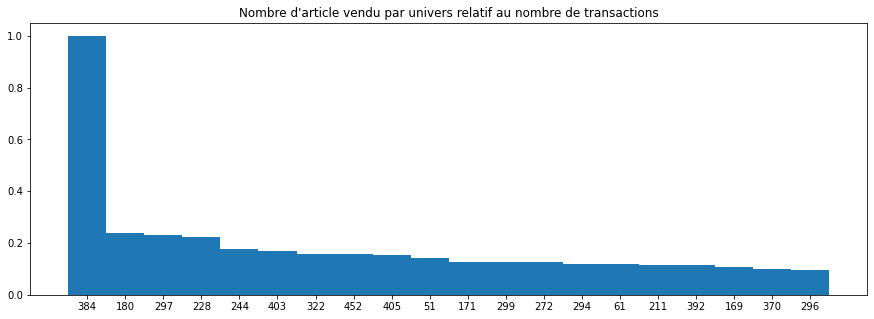

==============385===================
NOT ENOUGH DATA 
==============386===================
4148
Time Taken to load recurence: ~0secondes


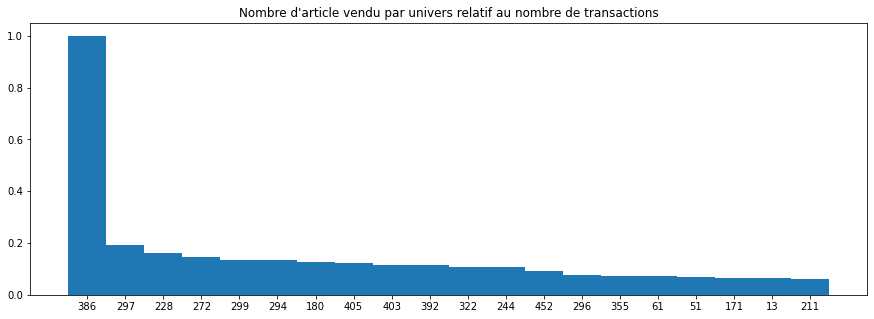

==============387===================
1456
Time Taken to load recurence: ~0secondes


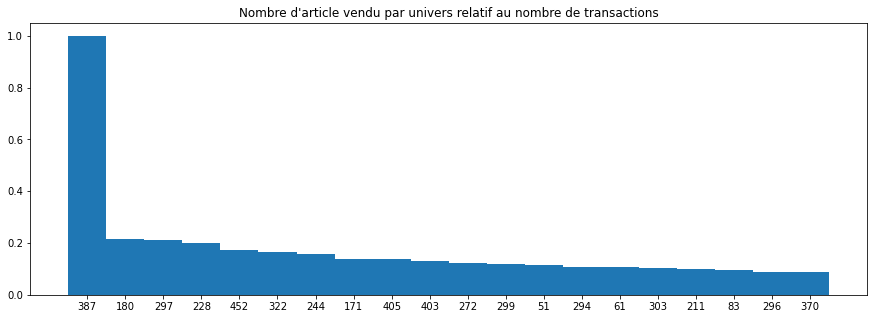

==============388===================
NOT ENOUGH DATA 
==============389===================
NOT ENOUGH DATA 
==============390===================
NOT ENOUGH DATA 
==============391===================
NOT ENOUGH DATA 
==============392===================
178061
Time Taken to load recurence: ~1secondes


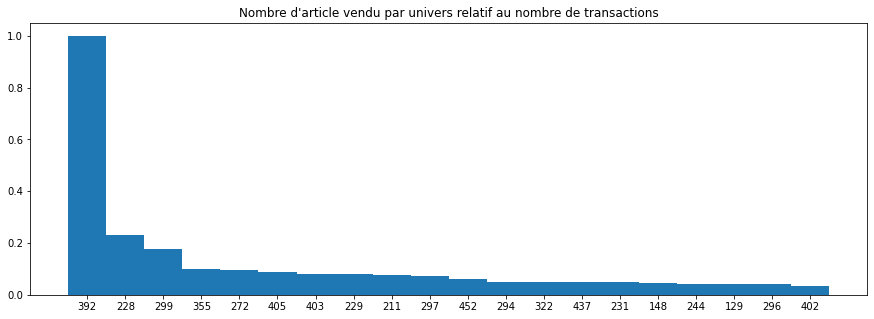

==============393===================
NOT ENOUGH DATA 
==============394===================
NOT ENOUGH DATA 
==============395===================
NOT ENOUGH DATA 
==============396===================
NOT ENOUGH DATA 
==============397===================
NOT ENOUGH DATA 
==============398===================
NOT ENOUGH DATA 
==============399===================
NOT ENOUGH DATA 
==============400===================
NOT ENOUGH DATA 
==============401===================
NOT ENOUGH DATA 
==============402===================
51241
Time Taken to load recurence: ~0secondes


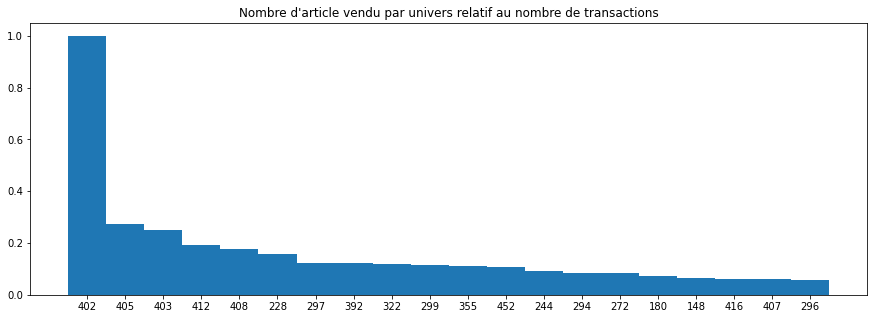

==============403===================
121643
Time Taken to load recurence: ~1secondes


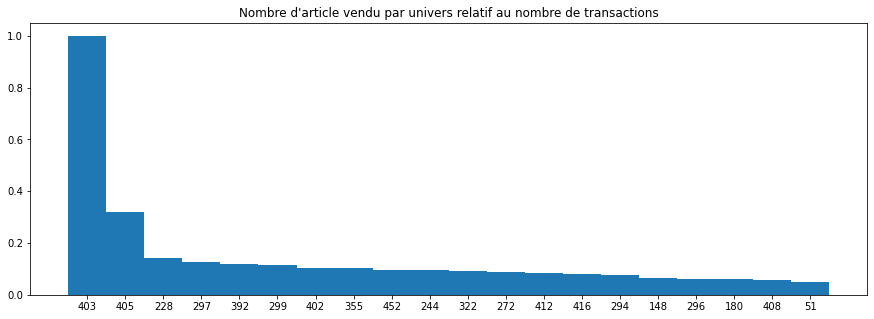

==============404===================
NOT ENOUGH DATA 
==============405===================
132713
Time Taken to load recurence: ~1secondes


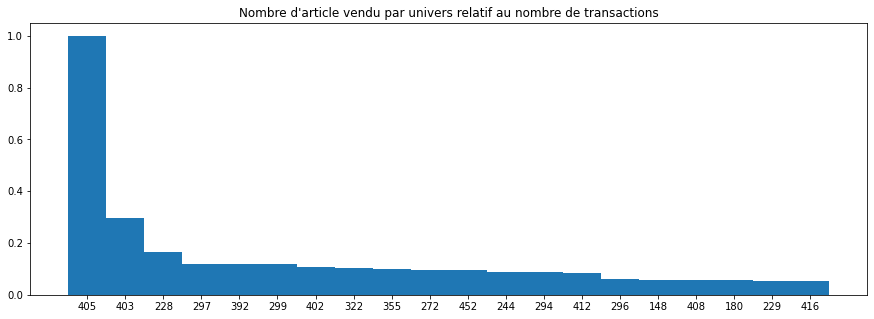

==============406===================
NOT ENOUGH DATA 
==============407===================
13449
Time Taken to load recurence: ~0secondes


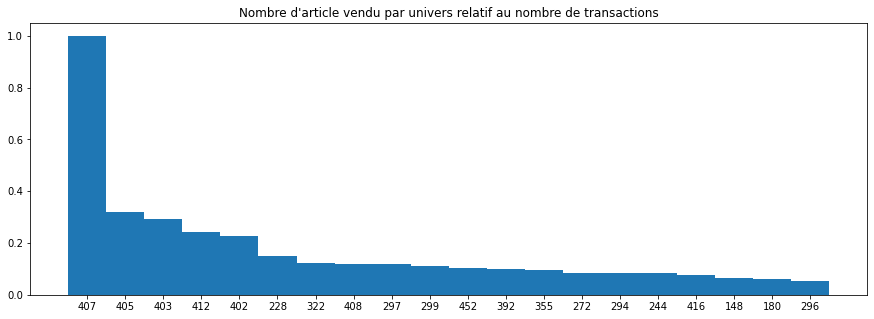

==============408===================
32029
Time Taken to load recurence: ~0secondes


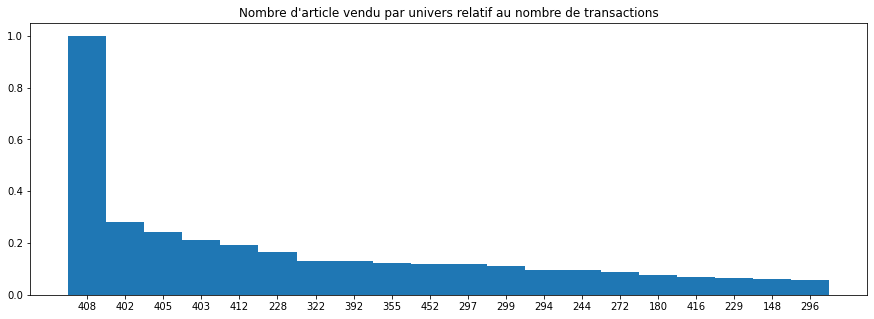

==============409===================
NOT ENOUGH DATA 
==============410===================
1964
Time Taken to load recurence: ~0secondes


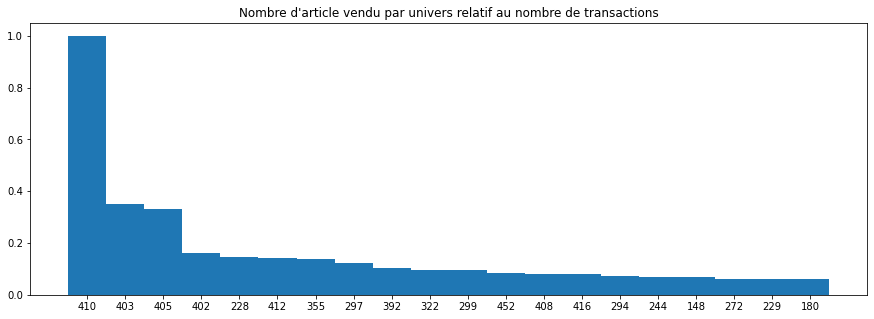

==============411===================
7123
Time Taken to load recurence: ~0secondes


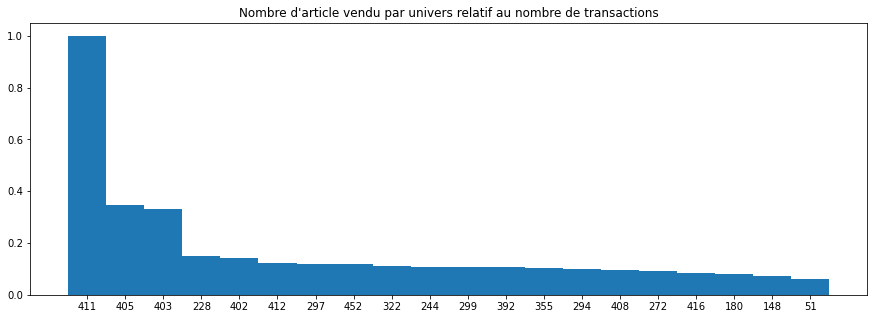

==============412===================
38516
Time Taken to load recurence: ~0secondes


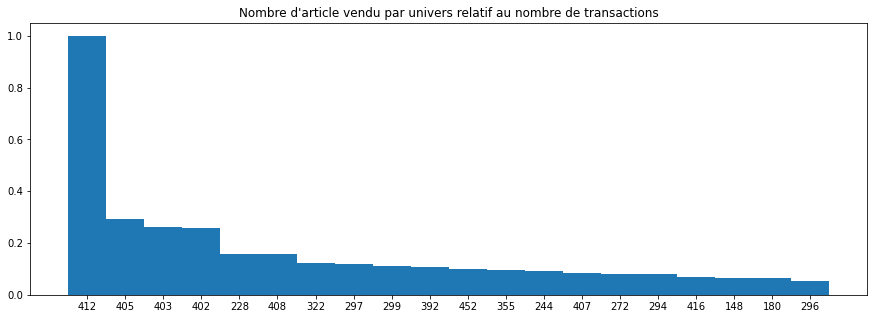

==============413===================
14253
Time Taken to load recurence: ~0secondes


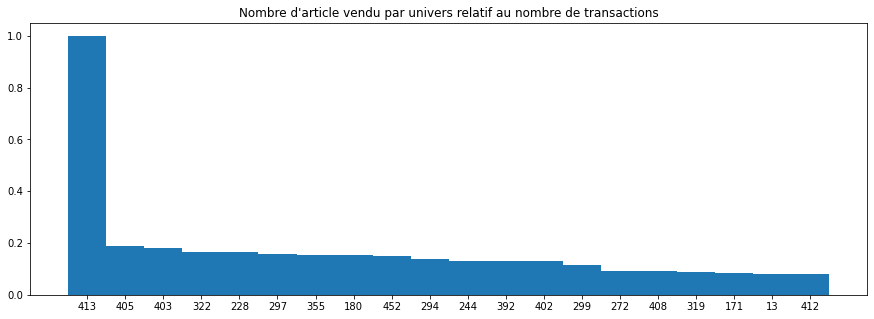

==============414===================
NOT ENOUGH DATA 
==============415===================
NOT ENOUGH DATA 
==============416===================
25137
Time Taken to load recurence: ~0secondes


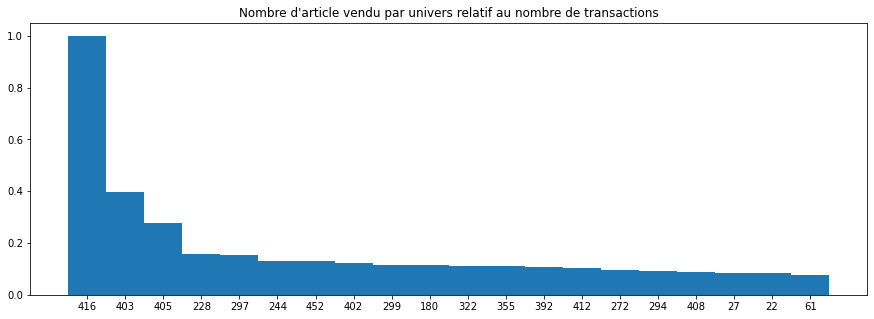

==============417===================
NOT ENOUGH DATA 
==============418===================
NOT ENOUGH DATA 
==============419===================
NOT ENOUGH DATA 
==============420===================
NOT ENOUGH DATA 
==============421===================
95
Time Taken to load recurence: ~0secondes


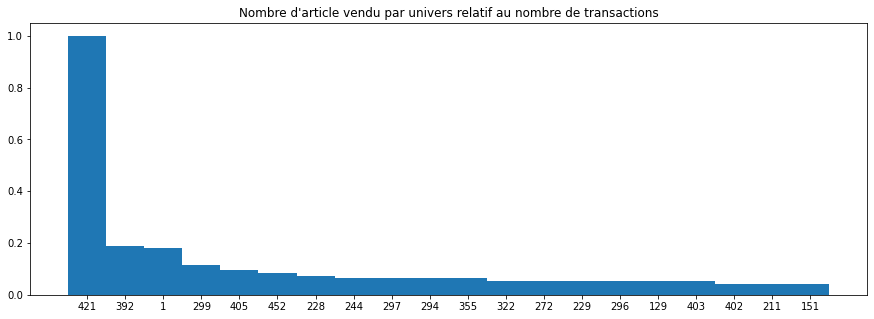

==============422===================
NOT ENOUGH DATA 
==============423===================
NOT ENOUGH DATA 
==============424===================
NOT ENOUGH DATA 
==============425===================
NOT ENOUGH DATA 
==============426===================
NOT ENOUGH DATA 
==============427===================
NOT ENOUGH DATA 
==============428===================
NOT ENOUGH DATA 
==============429===================
NOT ENOUGH DATA 
==============430===================
NOT ENOUGH DATA 
==============431===================
8637
Time Taken to load recurence: ~0secondes


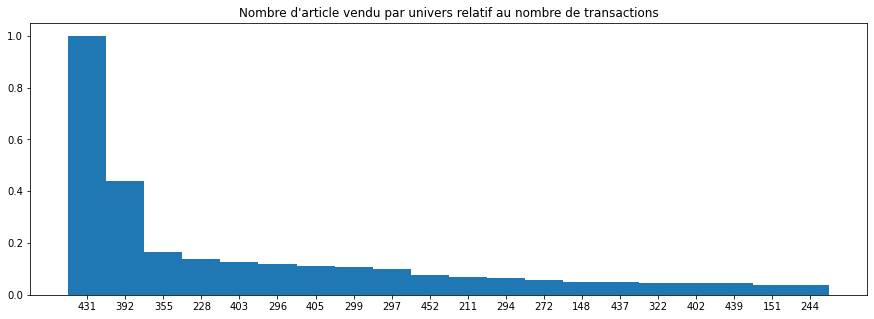

==============432===================
5400
Time Taken to load recurence: ~0secondes


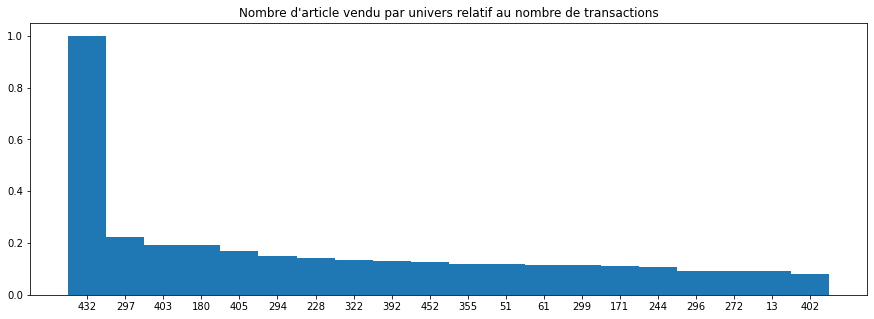

==============433===================
361
Time Taken to load recurence: ~0secondes


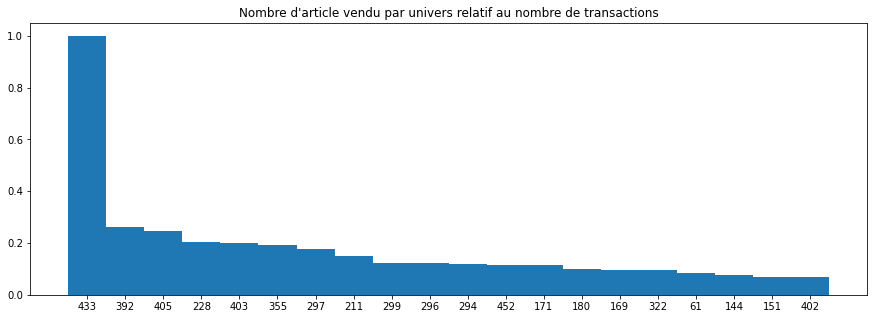

==============434===================
NOT ENOUGH DATA 
==============435===================
18555
Time Taken to load recurence: ~0secondes


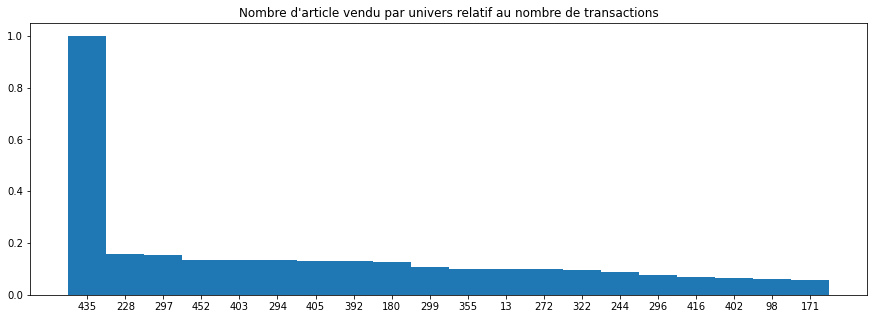

==============436===================
151
Time Taken to load recurence: ~0secondes


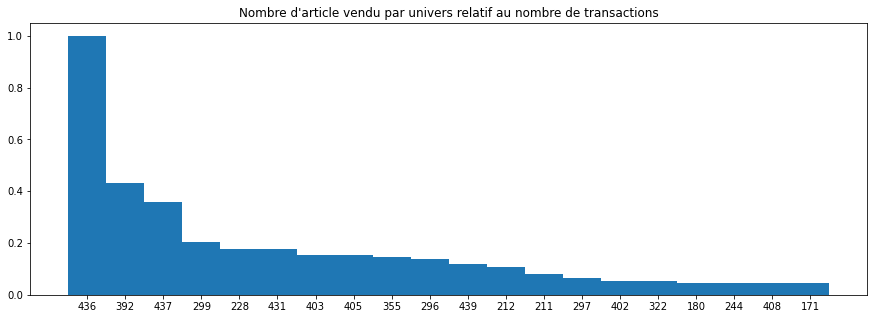

==============437===================
40746
Time Taken to load recurence: ~0secondes


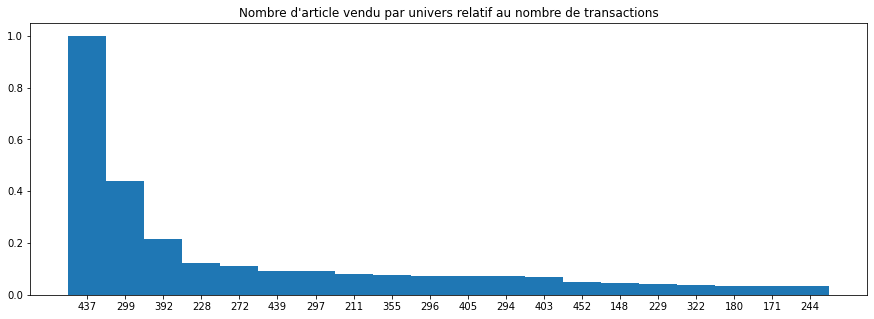

==============438===================
9736
Time Taken to load recurence: ~0secondes


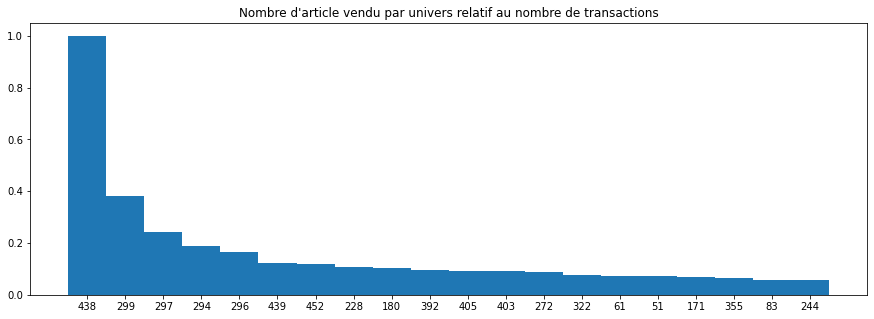

==============439===================
28918
Time Taken to load recurence: ~0secondes


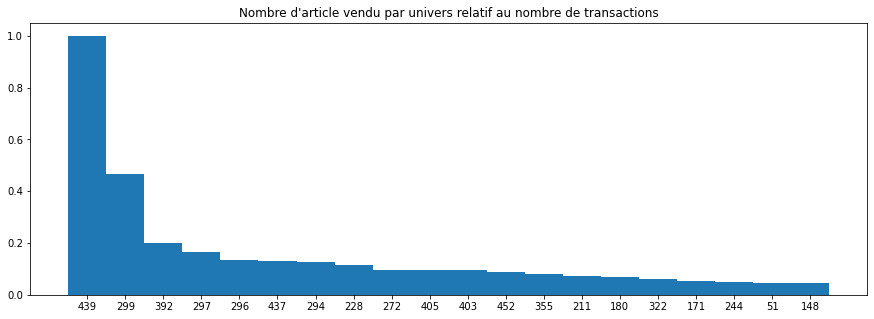

==============440===================
NOT ENOUGH DATA 
==============441===================
NOT ENOUGH DATA 
==============442===================
12518
Time Taken to load recurence: ~0secondes


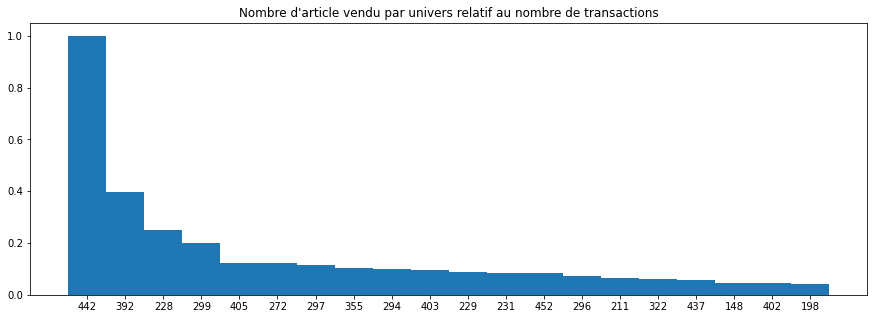

==============443===================
NOT ENOUGH DATA 
==============444===================
NOT ENOUGH DATA 
==============445===================
NOT ENOUGH DATA 
==============446===================
NOT ENOUGH DATA 
==============447===================
NOT ENOUGH DATA 
==============448===================
3055
Time Taken to load recurence: ~0secondes


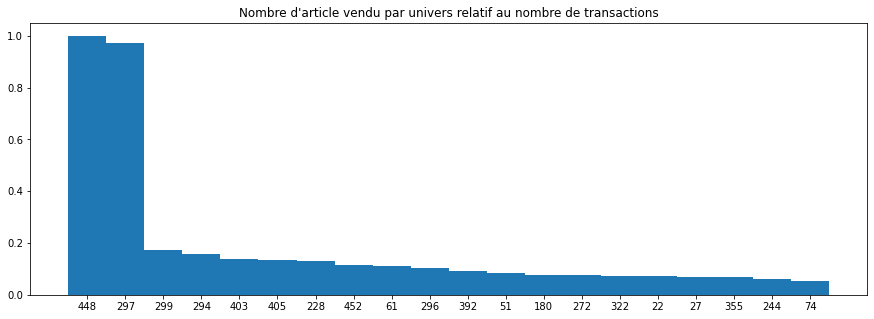

==============449===================
NOT ENOUGH DATA 
==============450===================
NOT ENOUGH DATA 
==============451===================
NOT ENOUGH DATA 
==============452===================
61932
Time Taken to load recurence: ~1secondes


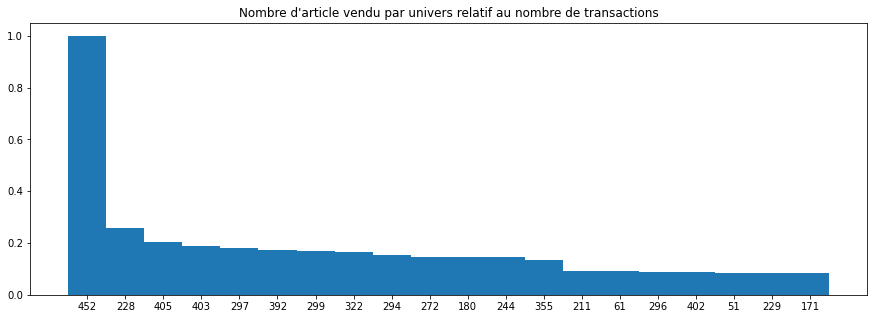

==============453===================
614
Time Taken to load recurence: ~0secondes


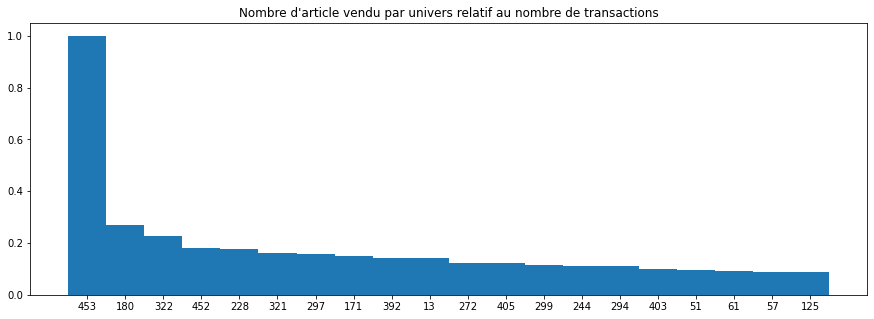

==============454===================
NOT ENOUGH DATA 
==============455===================
9375
Time Taken to load recurence: ~0secondes


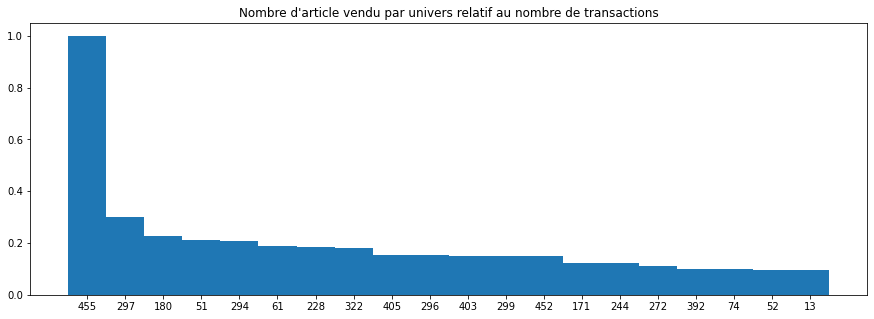

==============456===================
NOT ENOUGH DATA 
==============457===================
NOT ENOUGH DATA 
==============458===================
NOT ENOUGH DATA 
==============459===================
NOT ENOUGH DATA 
==============460===================
3628
Time Taken to load recurence: ~0secondes


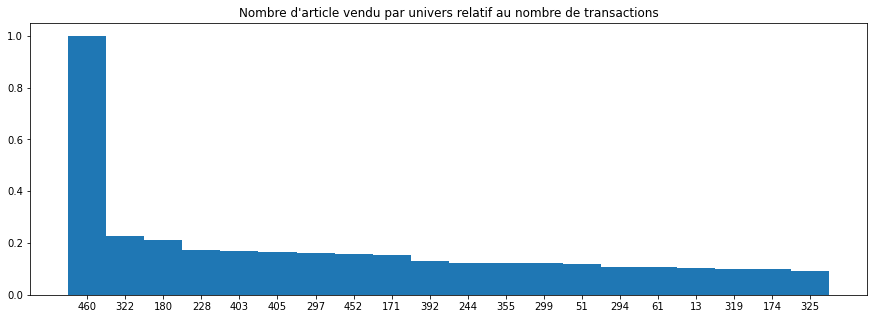

==============461===================
NOT ENOUGH DATA 
==============462===================
NOT ENOUGH DATA 
==============463===================
NOT ENOUGH DATA 
==============464===================
NOT ENOUGH DATA 
==============465===================
NOT ENOUGH DATA 
==============466===================
NOT ENOUGH DATA 
==============467===================
NOT ENOUGH DATA 
==============468===================
NOT ENOUGH DATA 
==============469===================
NOT ENOUGH DATA 
==============470===================
NOT ENOUGH DATA 
==============471===================
NOT ENOUGH DATA 
==============472===================
NOT ENOUGH DATA 
==============473===================
NOT ENOUGH DATA 
==============474===================
NOT ENOUGH DATA 
==============475===================
NOT ENOUGH DATA 
==============476===================
NOT ENOUGH DATA 
==============477===================
NOT ENOUGH DATA 
==============478===================
2962
Time Taken to load recurence: ~0secondes

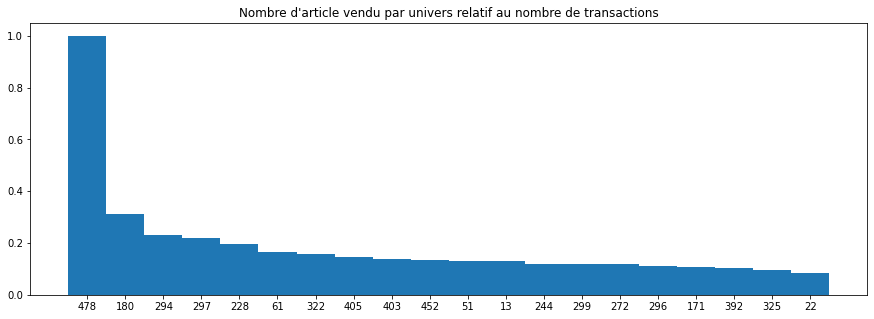

==============479===================
NOT ENOUGH DATA 
==============480===================
NOT ENOUGH DATA 
==============481===================
106
Time Taken to load recurence: ~0secondes


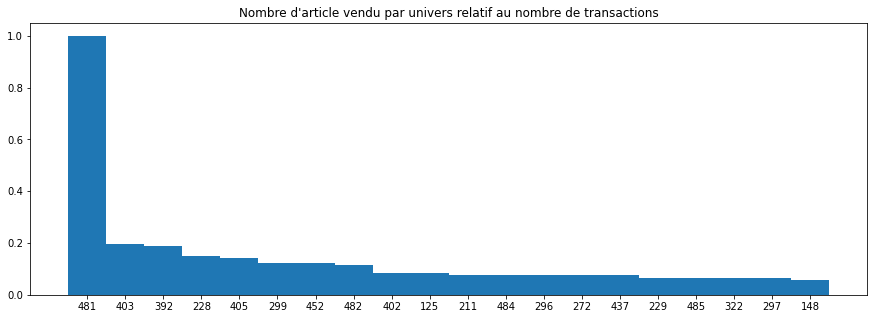

==============482===================
748
Time Taken to load recurence: ~0secondes


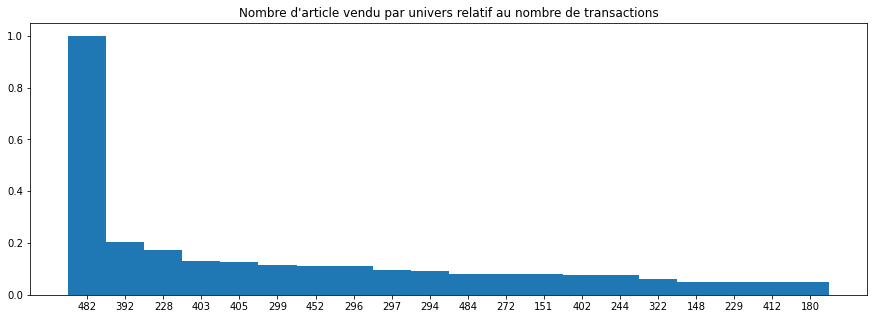

==============483===================
284
Time Taken to load recurence: ~0secondes


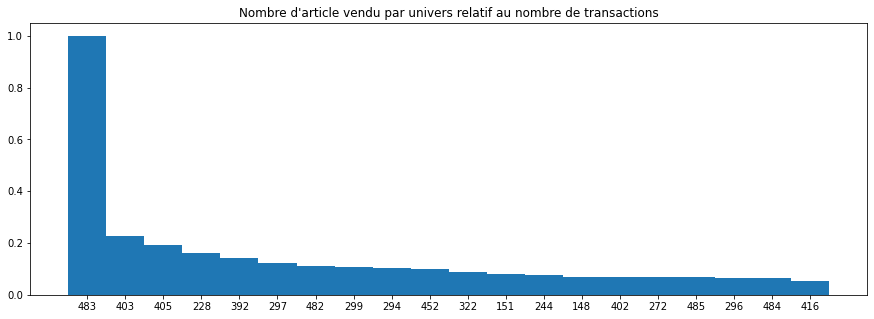

==============484===================
1020
Time Taken to load recurence: ~0secondes


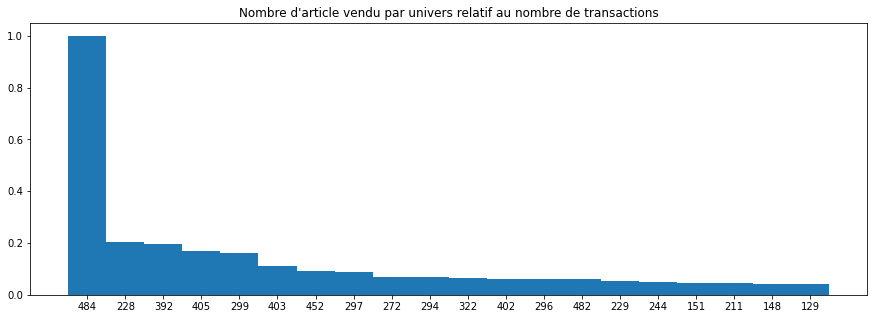

==============485===================
535
Time Taken to load recurence: ~0secondes


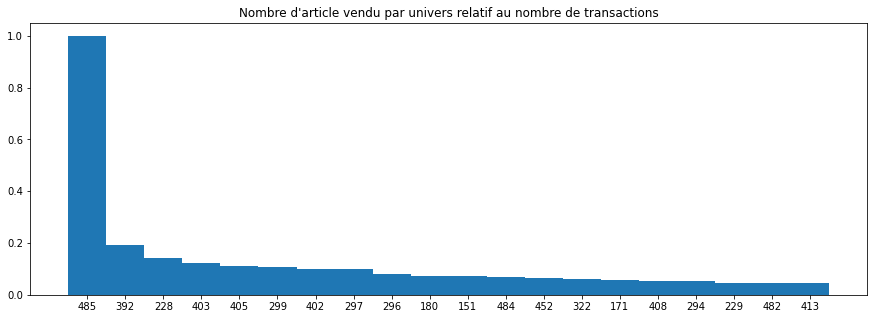

==============486===================
NOT ENOUGH DATA 
==============487===================
NOT ENOUGH DATA 
==============488===================
NOT ENOUGH DATA 
==============489===================
NOT ENOUGH DATA 
==============490===================
NOT ENOUGH DATA 
==============491===================
NOT ENOUGH DATA 
Time Taken to load all metrics: ~220secondes


In [65]:
# For all Universe, load the metrics 
start = time()

dico_metrics = {}
dico_rec_art = {}

for key in all_univ_key:
    print("==============" + str(key)+"===================")
    
    trans           = univ_transactions[key]
    CA_without_univ = univ_CA_sans_univ[key]
    CA_univ         = univ_CA[key]
    
    N = len(trans)
    if N <= 50:
        print("NOT ENOUGH DATA ")
        continue
    
    # Load recurence and #article per transactions
    nbr_article_sans_univ, nbr_article_univ = get_nbr_sans_univ(trans, [key])
    dico_rec_art[key], _ = load_recurence(trans)
    
    """
        8 metrics sont calculées :
            - "Proportion d'achat (%)" : Nombre de transactions contenant l'univers / nombre total de transactions
            - "Proportion d'achat seul": Nombre de fois que l'univers à été acheté seul / nombre de transactions contenant l'univers
            - "CA univ"       : CA totale produit par l'unif
            - "CA moyen univ" : "CA univ" / nombre de transaction contenant l'univers
            - "Nombre moyen article en plus" : Nombre d'article acheté qui ne sont pas dans l'univers dans les transactions contenant l'univers / nombre de transactions contenant l'univers
            - "CA en plus"       : CA totale des transactions contenant l'univers - "CA univ"
            - "CA moyen en plus" :"CA en plus" / nombre de transaction contenant l'univers
    """
    dico_metrics[key] = {"Proportion d'achat (%)": round(N*100/len(transactions),2),
                         "Proportion achat seul (%)": round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2),
                         "Nombre moyen d'univ":round(sum(nbr_article_univ)/N, 2),
                         "CA univ":round(CA_univ,2),
                         "CA moyen univ":round(CA_univ/N,2),
                         "Nombre moyen article en plus": round(sum(nbr_article_sans_univ)/N, 2),
                         "CA en plus": round(CA_without_univ,2),
                         "CA moyen en plus":round(CA_without_univ/N,2)}
    
print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 

In [66]:
# Transform dico_metrics to dataframe
dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                 data  = dico_metrics.values())
# Sort dataframe by a speific column
dataframe_metrics=dataframe_metrics.sort_values(by=dataframe_metrics.columns[0], axis = 0, ascending=False)
print(dataframe_metrics.head(10))

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
392                   19.57                      13.56                 1.49   
228                   16.07                       1.91                 1.39   
299                   15.80                       4.72                 2.18   
405                   14.59                       7.54                 1.55   
297                   13.43                       5.87                 1.25   
403                   13.37                       7.76                 1.63   
272                   10.82                       2.92                 1.22   
294                   10.46                       4.63                 1.34   
355                   10.00                       9.09                 1.25   
244                    9.03                       7.74                 1.36   

        CA univ  CA moyen univ  Nombre moyen article en plus  CA en plus  \
392   863597.90           4.85                        

In [67]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~4501secondes


# INSERT INTO DB

In [68]:
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

DB_insert = 'DelitraiteurBI_ResultML'

In [69]:
# TEST & CREATE Connexion
params = urllib.parse.quote_plus(login)
insert_engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = insert_engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_UNIVERS+".KEY] FROM ["+DB_insert+"].[DWH].[Dim_"+TABLE_UNIVERS+"]", conn)
print(df)

conn.close()

   Univers.KEY
0           -1
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9


### Create Simulation Item

In [70]:
now = date.today()
sql_cmd = '''
INSERT INTO ['''+DB_insert+'''].[PML].[Simulation]
           ([Simulation.TEMPS.KEY]
           ,[Simulation.Database]
           ,[Simulation.Usecase_libelle]
           ,[Simulation.flags_only_fidelity]
           ,[Simulation.Nbr_data])
     VALUES
           ('''+str(now.year*10000 + now.month*100 + now.day)+'''
           ,'''+"'"+str(DB)+"'"+'''
           ,'Panier_Metrics_Article'
           ,'''+str(int(bool(take_only_fid)))+'''
           ,'''+str(nbr_data)+''')

'''

print(sql_cmd)

conn = insert_engine.connect()
conn.execute(sql_cmd)
conn.close()


INSERT INTO [DelitraiteurBI_ResultML].[PML].[Simulation]
           ([Simulation.TEMPS.KEY]
           ,[Simulation.Database]
           ,[Simulation.Usecase_libelle]
           ,[Simulation.flags_only_fidelity]
           ,[Simulation.Nbr_data])
     VALUES
           (20220809
           ,'DelitraiteurBI_Prod'
           ,'Panier_Metrics_Article'
           ,1
           ,5000000)




In [71]:
sql_cmd = '''SELECT [Simulation.KEY] FROM ['''+DB_insert+'''].[PML].[Simulation] ORDER BY [Simulation.KEY] DESC'''
conn = insert_engine.connect()
simulation_key = pd.read_sql(sql_cmd, conn).values[0][0]
conn.close()
print(simulation_key)

13


### Instert Univers Metrics

In [72]:
conn = insert_engine.connect()
for key,val in dataframe_metrics.to_dict('index').items():
#     print(list(val.values()))
    sql_cmd = '''INSERT INTO ['''+DB_insert+'''].[PML].[Univers_Metrics]
           ([Univers_Metrics.SIMULATION.KEY]
           ,[Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Transactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Transactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES ('''+str(simulation_key)+''',
        '''+str(key)+''',
        '''+str(int(bool(take_only_fid)))+''',
        '''+str(len(transactions))+''',
        '''+str(list(val.values())[0])+''',
        '''+str(list(val.values())[1])+''',
        '''+str(list(val.values())[2])+''',
        '''+str(list(val.values())[3])+''',
        '''+str(list(val.values())[4])+''',
        '''+str(list(val.values())[5])+''',
        '''+str(list(val.values())[6])+''',
        '''+str(list(val.values())[7])+''')'''
                                                                                             
#     print(sql_cmd)
    conn.execute(sql_cmd)
conn.close()

### Insert Proportion d'Article par Univers

In [73]:
conn = insert_engine.connect()
for key,val in dico_rec_art.items():
    i = 0
    for univ,prop in val.items():
        if prop >= 0.01:
            sql_cmd = '''
            INSERT INTO ['''+DB_insert+'''].[PML].[Proportion_Article_par_transactions]
               ([Proportion_Article_par_transactions.SIMULATION.KEY]
               ,[Proportion_Article_par_transactions.UNIVERS_filtre.KEY]
               ,[Proportion_Article_par_transactions.MAGASIN_filtre.KEY]
               ,[Proportion_Article_par_transactions.UNIVERS_proportion.KEY]
               ,[Proportion_Article_par_transactions.Classement]
               ,[Proportion_Article_par_transactions.Proportion]
               ,[Proportion_Article_par_transactions.flags_only_fidelity])
         VALUES
               ('''+str(simulation_key)+''',
                '''+str(key)+'''
               ,'''+"Null"+'''
               ,'''+str(univ)+'''
               ,'''+str(i)+'''
               ,'''+str(round(prop*100,2))+'''
               ,'''+str(int(bool(take_only_fid)))+''')
           '''
            i+=1
            
#             print(sql_cmd)           
            conn.execute(sql_cmd)
        else:
            break
conn.close()

### Insert Proportion D'article par Magasin

In [74]:
conn = insert_engine.connect()
for key,val in dico_rec_mag.items():
    i = 1
    for univ,prop in val.items():
        if prop >= 0.01:
            sql_cmd = '''
            INSERT INTO ['''+DB_insert+'''].[PML].[Proportion_Article_par_transactions]
               ([Proportion_Article_par_transactions.SIMULATION.KEY]
               ,[Proportion_Article_par_transactions.UNIVERS_filtre.KEY]
               ,[Proportion_Article_par_transactions.MAGASIN_filtre.KEY]
               ,[Proportion_Article_par_transactions.UNIVERS_proportion.KEY]
               ,[Proportion_Article_par_transactions.Classement]
               ,[Proportion_Article_par_transactions.Proportion]
               ,[Proportion_Article_par_transactions.flags_only_fidelity])
         VALUES
               ('''+str(simulation_key)+''',
                '''+"Null"+'''
               ,'''+str(key)+'''
               ,'''+str(univ)+'''
               ,'''+str(i)+'''
               ,'''+str(round(prop*100,2))+'''
               ,'''+str(int(bool(take_only_fid)))+''')
           '''
            i+=1
            
#             print(sql_cmd)           
            conn.execute(sql_cmd)
        else:
            break
conn.close()

### Insert Proportion d'article générale

In [75]:
conn = insert_engine.connect()    
i = 1
for univ,prop in rec_article.items():
    if prop >= 0.01:
        sql_cmd = '''
        INSERT INTO ['''+DB_insert+'''].[PML].[Proportion_Article_par_transactions]
           ([Proportion_Article_par_transactions.SIMULATION.KEY]
           ,[Proportion_Article_par_transactions.UNIVERS_filtre.KEY]
           ,[Proportion_Article_par_transactions.MAGASIN_filtre.KEY]
           ,[Proportion_Article_par_transactions.UNIVERS_proportion.KEY]
           ,[Proportion_Article_par_transactions.Classement]
           ,[Proportion_Article_par_transactions.Proportion]
           ,[Proportion_Article_par_transactions.flags_only_fidelity])
     VALUES
           ('''+str(simulation_key)+''',
            '''+"Null"+'''
           ,'''+"Null"+'''
           ,'''+str(univ)+'''
           ,'''+str(i)+'''
           ,'''+str(round(prop*100,2))+'''
           ,'''+str(int(bool(take_only_fid)))+''')
       '''
        i+=1

#             print(sql_cmd)           
        conn.execute(sql_cmd)
    else:
        break
conn.close()

### Insert Rules 

In [76]:
conn = insert_engine.connect()
for rule in rules:
    if len(rule.lhs) > 2 or len(rule.rhs) > 2 or rule.lift <= 1:
        continue
    
    sql_cmd = '''
    INSERT INTO ['''+DB_insert+'''].[PML].[Rules_Univers]
   ([Rules_Univers.SIMULATION.KEY]
   ,[Rules_Univers.UNIVERS_left_1.KEY]
   ,[Rules_Univers.UNIVERS_left_2.KEY]
   ,[Rules_Univers.UNIVERS_right_1.KEY]
   ,[Rules_Univers.UNIVERS_right_2.KEY]
   ,[Rules_Univers.confidence]
   ,[Rules_Univers.support]
   ,[Rules_Univers.lift]
   ,[Rules_Univers.conviction]
   ,[Rules_Univers.flags_only_fidelity])
VALUES
   ('''+str(simulation_key)+''',
    '''+str(rule.lhs[0])+'''
   ,'''+("Null" if len(rule.lhs) == 1 else str(rule.lhs[1]))+'''
   ,'''+str(rule.rhs[0])+'''
   ,'''+("Null" if len(rule.rhs) == 1 else str(rule.rhs[1]))+'''
   ,'''+str(round(rule.confidence,3))+'''
   ,'''+str(round(rule.support,4))+'''
   ,'''+str(round(rule.lift,2))+'''
   ,'''+str(round(rule.conviction,3))+'''
   ,'''+str(int(bool(take_only_fid)))+''')
   '''
    

#     print(sql_cmd)           
    conn.execute(sql_cmd)
conn.close()

## Old but Gold

In [78]:
segment_key = 42

sql_command = '''SELECT [Client_Segment.CONSOMMATEUR.KEY]
  FROM [DelitraiteurBI_ResultML].[PML].[Client_Segment]
    WHERE [Client_Segment.SEGMENT.KEY] = ''' + str(segment_key)


conn = insert_engine.connect()
client_keys = pd.read_sql(sql_command, conn).values[:,0]
conn.close()

print(client_keys)

[22501 33357 57062 ... 16414 57787 78792]


In [31]:
start = time()

segment = 1

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE   + '''.KEY], ''' + ('''
['''+ TABLE_ENTETE   +'''.'''+TABLE_MAGASIN+'''.KEY],''')*int(do_shop) + '''
['''     + RECETTE_DETAIL + ''']
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + CONSOMMATEUR    + ''']
ON [''' + CONSOMMATEUR    + '''.Key] = ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY]
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
AND ['''      + CONSOMMATEUR  + '''.KEY] != -1
AND ['''+ CONSOMMATEUR  +'''.Segment_Clientele] = ''' + str(segment) + 

sql_command += '''ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()


# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)